# Module 1: Impute Missing Values

In this module, missing values will be imputed using autoencoder techniques in order to tidy up the data for future analysis and modelling.

## Load libraries

In [326]:
import numpy as np
import pandas as pd
import category_encoders as ce
import re
import tensorflow as tf
import warnings
from geopy.geocoders import GoogleV3
from geopy.geocoders import Nominatim
import time
import requests
from requests.exceptions import ConnectionError

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Deep NNs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

## FUNCTIONS

In [2]:
def date_2_features (df, colname):

    # convert to column to timestamp
    df[colname] = pd.to_datetime(df[colname])

    # find the minimum date
    min_date = df[colname].min()

    # calculate number of days since minimum date
    cname = colname+'_days_since_first'
    df[cname] = (df[colname] - min_date).dt.days

    # extract year
    cname = colname+'_year'
    df[cname] = df[colname].dt.year
    # extract month
    cname = colname+'_month'
    df[cname] = df[colname].dt.month
    # extract day
    cname = colname+'_day'
    df[cname] = df[colname].dt.day
    # extract day of week
    cname = colname+'_day_week'
    df[cname] = df[colname].dt.dayofweek
    
    return df

In [75]:
def get_lat_long_addr_from_post(row):
    # Obtain address
    post = row['postcode']
    # Initiate an instance
    geolocator = Nominatim(user_agent = 'address_geocoder')
    # Obtain location
    location = geolocator.geocode(post)
    # Handle missing values
    latitude = None
    longitude = None
    address = None
    if location is not None:
        # Obtain address
        address = location[0]
        # Obtain latitude
        latitude = location.latitude
        # Obtain longitude
        longitude = location.longitude
    
    return latitude, longitude, address

## Read table

In [3]:
df = pd.read_csv('df.csv', index_col=0)

Display how many missing values each feature contains

In [4]:
df.isna().sum()

transaction_id                            0
product_id                                0
customer_id                               0
transaction_date                          0
online_order                              0
order_status                              0
brand                                   197
product_line                            197
product_class                           197
product_size                            197
list_price                                0
standard_cost                           197
date_product_first_sold                 197
first_name                                0
last_name                                 0
gender                                    0
past_3_years_bike_related_purchases       3
DOB                                     449
job_title                              2397
job_industry_category                  3232
wealth_segment                            3
deceased_indicator                        0
owns_car                        

## Null value imputation

In this section, I will look at null values for overlapping features present in data for new and for existing customers. The number of null values will then be assessed in each dataset.  

The null values for existing customers will be imputed based on all usable features available for the existing customers datasets.  

Alternatively, the null values for prospective new customers will also be imputed based on available new customer data.

For both imputations, autoencoder deep learning models will be used. However, the models will be different and trained on different features since not all features are present in both datasets.  

Note that geo-coordinates will be extracted instead of working with addresses as it is a bit more relevant to the business problem statement: we want to identify regions of interest.

### Categorical encoding

First, all rows containing missing values will be dropped. Job title and job industry features will also be dropped since they contain a sizable proportion of missing values.  

Second, categorical variables will be encoded numerically either using ordinal numerical encoding or binary encoding.

#### Drop rows with null values

In [5]:
# Remove features with many nulls
df_nonulls = df.drop(columns=['DOB', 'job_title', 'job_industry_category'])

# Drop rows with nulls
df_nonulls = df_nonulls.dropna()

# Check for nulls
df_nonulls.isna().sum()

The table does not contain any null values at this stage. Now all values will have to be converted to numeric formats for autoencoders. Two methods will be used.
1. Ordinal numeric encoding
    - product size
    - wealth_segment
2. Binary encoding
    - brand
    - product_line
    - product_class
    - product_size
    - wealth_segment
    - job_title
    - job_industry_category
    - gender
3. Binary designation
    - online order
    - owns_car
    - order status
4. Date to numeric encoding (extract)
    - year
    - month
    - day of month
    - day of week
    - days since min
5. Geolocation coordinates will be obtained from address columns 
    - address
    - postcode
    - state
    - country

#### 1. Ordinal encoding

##### `product_size`

In [7]:
# Define dictionary:
dict_repl = {'small' : 0, 'medium' : 1, 'large' : 2}

# Replace values"
df_nonulls['product_size'].replace(dict_repl, inplace=True)

##### `wealth_segment`

In [9]:
# Define dictionary:
dict_repl = {'Mass Customer' : 0, 'Affluent Customer' : 1, 'High Net Worth' : 2}

# Replace values"
df_nonulls['wealth_segment'].replace(dict_repl, inplace=True)

#### 2. Binary designation

- online order
    - True : 1
    - False : 0
- owns_car
    - Yes : 1
    - No : 0
- order status
    - Approved : 0
    - Cancelled : 1
- diceased indicator
    - N : 0
    - Y : 1

In [10]:
# Define dictionary:
dict_repl = {
    'online_order' : {'True' : 1, 'False' : 0},
    'owns_car' : {'Yes' : 1, 'No' : 0},
    'order_status' : {'Approved' : 0, 'Cancelled' : 1}
}

# Replace values"
df_nonulls.replace(dict_repl, inplace=True)

# Define dictionary:
dict_repl = {'Y' : 1,
             'N' : 0
}

# Replace values"
df_nonulls['deceased_indicator'].replace(dict_repl, inplace=True)

#### 4. Feature engineering for dates

In [12]:
# Drop names for convenience
df = df_nonulls.drop(columns=['first_name', 'last_name'])

##### `transaction_date`

In [13]:
df = date_2_features (df_nonulls, colname='transaction_date')

##### `date_product_first_sold`

In [14]:
df = date_2_features(df, colname='date_product_first_sold')

##### `DOB`

For the date of birth, several steps will be taken:
1. Remove values for deceased customers.
2. Check for errors and outliers.
3. Extract number of years since the earlies available DOB.
4. Impute the median of all DOB for missing values.

In [49]:
df_old = pd.read_csv('df.csv', index_col=0)

In [54]:
df = df.merge(df_old['DOB'], right_index=True, left_index=True, how='left')
df.isna().sum()

transaction_id                                0
product_id                                    0
customer_id                                   0
online_order                                  0
order_status                                  0
brand                                         0
product_line                                  0
product_class                                 0
product_size                                  0
list_price                                    0
standard_cost                                 0
first_name                                    0
last_name                                     0
gender                                        0
past_3_years_bike_related_purchases           0
wealth_segment                                0
deceased_indicator                            0
owns_car                                      0
tenure                                        0
address                                       0
postcode                                

In [69]:
del df_old

In [ ]:
# Convert DOB to datetime
df['DOB'] = pd.to_datetime(df['DOB'])

In [88]:
# Check for deceased customers
df.loc[df['deceased_indicator']==1,['transaction_id', 'customer_id', 'deceased_indicator', 'DOB']]

,transaction_id,customer_id,deceased_indicator,DOB
3358,562,753,1,1970-03-07
3359,7319,753,1,1970-03-07
3360,8269,753,1,1970-03-07
3361,12095,753,1,1970-03-07
3362,16083,753,1,1970-03-07
3363,18329,753,1,1970-03-07
3364,18829,753,1,1970-03-07
3365,19682,753,1,1970-03-07


>We can see that a single customer that has made 8 transactions is deceased. These entries will be excluded from downstream analysis.

In [91]:
# Drop entries for deceased customers
df = df[df['deceased_indicator'] != 1]

# Sanity check
# Check for deceased customers
df.loc[df['deceased_indicator']==1,['transaction_id', 'customer_id', 'deceased_indicator', 'DOB']].shape[0]

0

>Since all entries pertain to customers that are not deceased, the `deceased_indicator` column does no longer provide any useful information and will be dropped as well.

In [92]:
df.drop(columns='deceased_indicator', inplace=True)

Let us now plot the `DOB`s to see if there are any outliers and inconsistencies that need to be addressed.

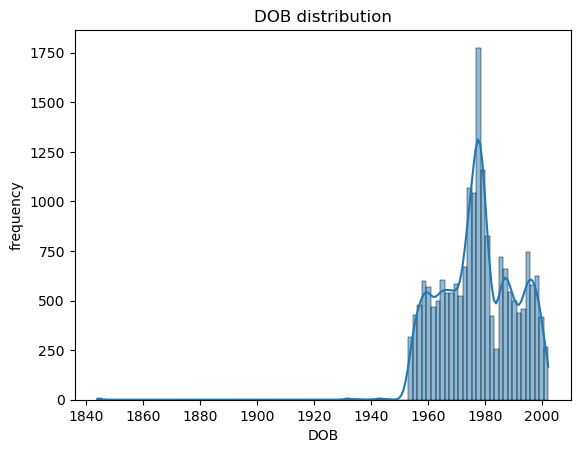

In [95]:
plt.figure()
sns.histplot(df['DOB'], bins=100, kde=True)
plt.title('DOB distribution')
plt.xlabel('DOB')
plt.ylabel('frequency')
plt.show()

It seems there are some values at around 1930 and around 1840. While DOB in 1930 is possible, one in the 1840s is almost certainly an error.

In [81]:
# Extract earliest DOB
min_DOB = df['DOB'].min()

print(min_DOB)

1843-12-21 00:00:00


<div class="alert alert-danger">
    <strong>ERROR DOB!:</strong> We can see that the earliest DOB is in 1843, which is likely an error.
</div>

The dataframe will now be ordered by dates in ascending order and the first 10 entries corresponding to the earliest DOBs will be displayed.

In [105]:
df_sorted = df.sort_values(by = 'DOB')
df_sorted_grouped = df_sorted.groupby(['customer_id', 'DOB', 'job_title'])['list_price'].sum().reset_index()
display(df_sorted_grouped.sort_values(by='DOB', ascending=True))

,customer_id,DOB,job_title,list_price
29,34,1843-12-21,Legal Assistant,12098.83
700,720,1931-10-23,Recruiting Manager,13004.35
1058,1092,1935-08-22,VP Quality Control,4893.72
3322,3410,1940-09-22,unknown,2965.89
2352,2413,1943-08-11,Environmental Specialist,8666.87
...,...,...,...,...
413,422,2002-01-06,unknown,5465.00
2787,2858,2002-01-09,Recruiting Manager,6672.94
3347,3435,2002-01-15,Senior Editor,6384.02
1840,1888,2002-01-26,Food Chemist,5775.32


We see that the earliest `DOB` is 1843-12-21. This customer is not listed as deceased and has spent a considerable amount altogether. Let us examine how long ago the transactions were made and compare this to the oldest transaction in the list.

In [110]:
display(df.loc[df['customer_id']==34,['transaction_date_days_since_first']])
print(df['transaction_date_days_since_first'].min())

,transaction_date_days_since_first
5902,181
5903,233
5904,96
5905,43
5906,175
5907,203
5909,99
5910,261


0


It appears the transactions are not as old. Let us compare them to the DOB for other customers in the same range.

In [113]:
df_43_261 = df.loc[(df['transaction_date_days_since_first']>=43) & (df['transaction_date_days_since_first']<=261),
       ['DOB']]

In [114]:
# Earliest DOB
print('Earliest DOB:', df_43_261['DOB'].min())

# Latest DOB
print('Latest DOB:', df_43_261['DOB'].max())

# Median DOB
median_43_261_DOB = df_43_261['DOB'].median()
print('Median DOB:', median_43_261_DOB)

Earliest DOB: 1843-12-21 00:00:00
Latest DOB: 2002-03-11 00:00:00
Median DOB: 1977-08-30 00:00:00


>We can see that the earliest DOB is the one we just flagged and the latest is 2002. We will therefore replace the faulty earliest DOB with the median DOB of customers that have had transactions at around the same time as the flagged customer. Note that 1843 may simply be a typo for 1943 as well.

In [117]:
df.loc[df['DOB']==df['DOB'].min(),'DOB'] = median_43_261_DOB

# Sanity check
df['DOB'].min()

Timestamp('1935-08-22 00:00:00')

Now the earliest DOB is in 1935, which is acceptable.  

We can now proceed with calculating `years_since_1st_DOB`.

In [118]:
# Obtain earliest DOB
min_dob = df['DOB'].min()

# New column to calculate years since min
df['years_since_1st_DOB'] = (df['DOB'] - min_dob).dt.days / 365.25

# Sanity check
df[['DOB', 'years_since_1st_DOB']]

,DOB,years_since_1st_DOB
0,1955-01-11,19.389459
1,1955-01-11,19.389459
2,1955-01-11,19.389459
3,1979-02-04,43.455168
4,1979-02-04,43.455168
...,...,...
19995,1997-07-18,61.905544
19996,1992-11-30,57.275838
19997,1992-11-30,57.275838
19998,1967-01-30,31.441478


We can now remove the DOB column and repeat for the new customer list.

In [123]:
df.drop(columns='DOB', inplace=True)

# Save data
df.to_csv('df_1.csv')

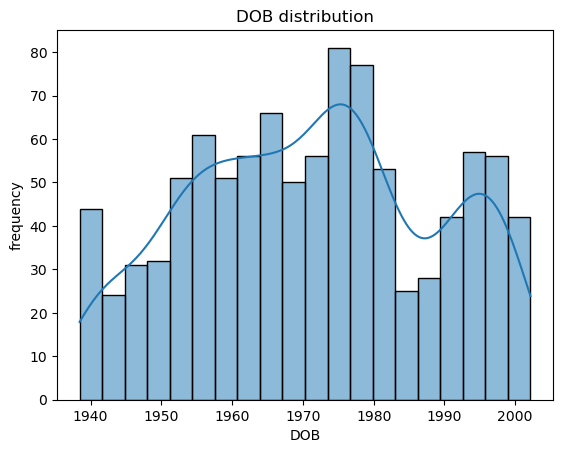

In [127]:
# Convert DOB to datetime
df_new['DOB'] = pd.to_datetime(df_new['DOB'])

# Plot the distribution of the DOB
plt.figure()
sns.histplot(df_new['DOB'], bins=20, kde=True)
plt.title('DOB distribution')
plt.xlabel('DOB')
plt.ylabel('frequency')
plt.show()

Does not seem like there are missing or unexpected values for the new customer `DOB` feature.  

Let us see how many null values there are:

In [128]:
df_new['DOB'].isna().sum()

17

>There are 17 null values, which will be imputed by simply replacing them with the median.

In [129]:
df_new['DOB'].fillna(df_new['DOB'].median(), inplace=True)

# Sanity check
df_new['DOB'].isna().sum()

0

>Now we will calculate years since the earliest DOB for the existing customers.

In [133]:
# New column to calculate years since min
df_new['years_since_1st_DOB'] = (df_new['DOB'] - min_dob).dt.days / 365.25

# Sanity check
df_new[['DOB', 'years_since_1st_DOB']]

,DOB,years_since_1st_DOB
4004,1957-07-12,21.889117
4005,1970-03-22,34.581793
4006,1974-08-28,39.017112
4007,1979-01-28,43.436003
4008,1965-09-21,30.083504
...,...,...
4999,1959-10-07,24.125941
5000,2001-10-17,66.154689
5001,1954-10-05,19.121150
5002,1952-12-17,17.322382


In [135]:
# Remove DOB column
df_new.drop(columns='DOB', inplace=True)

In [136]:
df_new.to_csv('df_new_1.csv')

##### Tidy up

I can now remove unnecessary columns such as `transaction_date`, `date_product_first_sold` and `transaction_date_year` (since it is 2017 for all entries).

In [15]:
df.drop(columns=['transaction_date', 'date_product_first_sold', 'transaction_date_year'], inplace=True)

In [132]:
df_new.columns

Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'property_valuation', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Rank', 'Value',
       'geo_address', 'latitude', 'longitude'],
      dtype='object')

#### 5. Geolocation

For the address, longitude and latitude coordinates (geocoding) I will obtain the address, latitude and longitude from the `postcode` and the cross-reference the address I obtained with the full address obtained by merging the `address`, `state`, `country` columns of the dataframe.

In [ ]:
# Construct a new column address_full
df['address_full'] = df['address'] + ', ' + df['state'] + ', ' + df['country']

In [47]:
# Convert postcode to integer
df['postcode'] = df['postcode'].astype(int)

Now I will use the `postcode` to obtain the address (as `address_postcode`), `latitude` and `longitude`.

In [110]:
# Apply the function to each row of the DataFrame
geolocator = Nominatim(user_agent='address_geocoder')

# Process in batches of 5
batch_size = 500

# Delay by 10 sec after each batch
delay_seconds = 1

# Initialize lists to store data
latitude_list = []
longitude_list = []
address_list = []

# Handel connection issues and retries
max_retries = 3
retry_delay = 15

***ITERATE FOR BATCHES OF 1000*** (In order not to get blocked)

In [172]:
# Loop through dataframe in batches:
# Define subset:
batch_df = df.iloc[19000:(len(df)+1)]
# Iterate over each row of batch:
for index, row in batch_df.iterrows():
    post = row['postcode']


    # Retry logic for network issues
    for retry in range(max_retries):
        try:
            # geocode the postcode
            location = geolocator.geocode(f'{post}, Australia', timeout=10)  # Reduced timeout
            break  # Success, exit the retry loop
        except ConnectionError as e:
            print(f"Connection error (retry {retry + 1}/{max_retries}): {e}")
            time.sleep(retry_delay)
    else:
        # If all retries fail, handle the error
        print("Max retries exceeded, unable to establish a connection.")
        location = None  # Set location to None in case of failure

    # Handel nulls
    if location is not None:
        # Extract latitude and add to list
        latitude_list.append(location.latitude)
        # Extract longitude and add to list
        longitude_list.append(location.longitude)
        # Extract address and add to list
        address_list.append(location.address)
    else:
        latitude_list.append(None)
        longitude_list.append(None)
        address_list.append(None)

    # Introduce a delay before next request
    time.sleep(delay_seconds)
print(f'Batch processed!')

Batch processed!


In [193]:
# Add geocoding and address to table
df[['geo_address', 'latitude', 'longitude']] = pd.DataFrame({
    'geo_address' : address_list,
    'latitude' : latitude_list,
    'longitude' : longitude_list})

Now let us check how many of the street names provided overlap with the street names obtained from geolocation the postcode.

In [216]:
# Define pattern
pattern = r'\d+\s(.*?)\s'

# Extract street names from address
st_address = df['address'].str.extract(pattern)

# Define pattern for geo_address
pattern_geo = r'^(.*?),'

# Extract street names from geo_address
st_geo_address = df['geo_address'].str.extract(pattern_geo)

# Count total street overlaps in rows
print('Total overlap in streets from address and from geo-located address (by postal code):\
', sum(st_geo_address.notna() & st_geo_address.isin(st_address)))

Total overlap in streets from address and from geo-located address (by postal code): 0


<div class="alert alert-danger">
    <strong>INCONSISTENT!:</strong> There is NO overlap between the street names given by the company and those obtained from the postcode. The address and geo-coordinates obtained from the postcode will be used for downstream analysis. An important caveat here is that this strategy will be valid if more clients buy online and have their orders delivered. For the latter customers, the postcode would be required for proper delivery. As it happens, the online purchases are split at around the middle. I therefore judge the strategy of using the postcode as an anchor point for the customer geolocation as acceptable.
</div>

In [217]:
# Save:
df.to_csv('df_geoloc.csv')

In [223]:
# Clean up
del pattern_geo, pattern, st_address, st_geo_address,\
address_list, latitude_list,\
longitude_list, location

#### Geolocation for prospective new customers

In [8]:
# Apply the function to each row of the DataFrame
geolocator = Nominatim(user_agent='address_geocoder')

# Delay by 10 sec after each batch
delay_seconds = 1

# Initialize lists to store data
latitude_list = []
longitude_list = []
address_list = []

# Handel connection issues and retries
max_retries = 3
retry_delay = 15

# Read new customers data
df_new = pd.read_csv('newcustomerlist_clean1_reindexed.csv', index_col=0)

# Extract address and geo-coordinates for new customers:

# Define lists
address_list = []
latitude_list = []
longitude_list = []

# Iterate over each row of batch:
for index, row in df_new.iterrows():
    post = row['postcode']


    # Retry logic for network issues
    for retry in range(max_retries):
        try:
            # geocode the postcode
            location = geolocator.geocode(f'{post}, Australia', timeout=2)
            break  # Success, exit the retry loop
        except ConnectionError as e:
            print(f"Connection error (retry {retry + 1}/{max_retries}): {e}")
            time.sleep(retry_delay)
    else:
        # If all retries fail, handle the error
        print("Max retries exceeded, unable to establish a connection.")
        location = None  # Set location to None in case of failure

    # Handel nulls
    if location is not None:
        # Extract latitude and add to list
        latitude_list.append(location.latitude)
        # Extract longitude and add to list
        longitude_list.append(location.longitude)
        # Extract address and add to list
        address_list.append(location.address)
    else:
        latitude_list.append(None)
        longitude_list.append(None)
        address_list.append(None)

    # Introduce a delay before next request
    time.sleep(delay_seconds)
print(f'Batch processed!')

Batch processed!


In [19]:
# Add geocoding and address to table
df_new['geo_address'] = address_list
df_new['latitude'] = latitude_list
df_new['longitude'] = longitude_list

Now let us check how many of the street names provided overlap with the street names obtained from geolocation the postcode.

In [21]:
# Define pattern
pattern = r'\d+\s(.*?)\s'

# Extract street names from address
st_address = df_new['address'].str.extract(pattern)

# Define pattern for geo_address
pattern_geo = r'^(.*?),'

# Extract street names from geo_address
st_geo_address = df_new['geo_address'].str.extract(pattern_geo)

# Count total street overlaps in rows
print('Total overlap in streets from address and from geo-located address (by postal code):\
', sum(st_geo_address.notna() & st_geo_address.isin(st_address)))

Total overlap in streets from address and from geo-located address (by postal code): 0


<div class="alert alert-danger">
    <strong>INCONSISTENT!:</strong> There is NO overlap between the street names given by the company and those obtained from the postcode. The address and geo-coordinates obtained from the postcode will be used for downstream analysis.
</div>

There is not overlap for prospective customers as well. Only the latitude and longitude will be kept for downstream analysis.

In [23]:
# Remove provide address columns
df_new.drop(columns=['address', 'postcode', 'state', 'country'], inplace = True)

In [24]:
# Save new customer data with updated geolocations
df_new.to_csv('df_new_cust_geo.csv')

---
---
---

>I will now impute `job_title` and `job_industry_category` to ***unknown*** for both existing and new customers.

In [42]:
# Replace null with unknown for job_title
df['job_title'].fillna('unknown', inplace=True)
df_new['job_title'].fillna('unknown', inplace=True)

# Replace null with unknown for job_industry_categry
df['job_industry_category'].fillna('unknown', inplace=True)
df_new['job_industry_category'].fillna('unknown', inplace=True)

Now I will check whether each customer has a unique job title and job industry. If not, the unknown categories will be replaced with the job title and job_industry-category available.

In [66]:
# Check that each customer is associated with a unique job
df['job_title_count'] = df.groupby('customer_id')['job_title'].nunique()
df.loc[df['job_title_count']>1,['customer_id', 'job_title', 'job_industry_category','job_title_count']].shape[0]

# Check that each customer is associated with a unique job category
df['job_cat_count'] = df.groupby('customer_id')['job_industry_category'].nunique()
df.loc[df['job_cat_count']>1,['customer_id', 'job_title', 'job_industry_category','job_cat_count']].shape[0]

0

There are no unknown jobs for customers that have provided job details on other occasions.

#### 3. Binary encoding

Now I will binary encode all categorical variables in order to impute the missing latitude and longitude for the existing customers.

In [141]:
# Check which features are categorical
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19765 entries, 0 to 19999
Data columns (total 39 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   transaction_id                            19765 non-null  int64  
 1   product_id                                19765 non-null  int64  
 2   customer_id                               19765 non-null  int64  
 3   online_order                              19765 non-null  bool   
 4   order_status                              19765 non-null  int64  
 5   brand                                     19765 non-null  object 
 6   product_line                              19765 non-null  object 
 7   product_class                             19765 non-null  object 
 8   product_size                              19765 non-null  int64  
 9   list_price                                19765 non-null  float64
 10  standard_cost                     

Apart from `job_title` and `job_industry_category`, other categorical variables that will have to be binary-encoded are:
- `brand`
- `product_line`
- `product_class`
- `gender`  

Features that are not expected to bring any new information will be dropped entirely:
- `transaction_id`
- `product_id`
- `customer_id`
- `first_name`
- `last_name`
- `address`
- `postcode`
- `state`
- `country`
- `address_full`
- `geo_address`

In [142]:
df.drop(columns = [
    'transaction_id', 'product_id', 'customer_id',
    'first_name', 'last_name', 'address',
    'postcode', 'state', 'country', 'address_full',
    'geo_address'], inplace=True)

# Same for new customers
df_new.drop(columns = )

Now let us binary-encode all categorical variables.

In [157]:
# Instantiate encoder
encoder = ce.BinaryEncoder(cols = [
    'brand', 'product_line', 'product_class', 'gender',
    'job_title', 'job_industry_category'
])

# Encode categorical columns
df_encoded = encoder.fit_transform(df)

In [158]:
# Save encoded data
df_encoded.to_csv('df_binenc.csv')

## Autoencoder

>Now that we have all values in a numeric format, we can use autoencoder - neural network architecture to make predictions about missing values for `latitude`, `longitude` and `years_since_1st_DOB`.  

The model will be trained and validated on a subset of the data that does not contain nulls and then used to predict null values.

### Train/test split

The data will be split in such a way that the train set contains no missing values and all the missing values make up a proportion of the test subset. The dataframe will be split while stratifying on all variables. Rows containing `NaN`s from the train subset will be added over to the test subset so that the train subset only contains non-null values for properly training the model.

In [292]:
# subset out all rows with missing values
df_encoded_nulls = df_encoded[(df_encoded['latitude'].isna()) |\
                              (df_encoded['longitude'].isna()) |\
                              (df_encoded['years_since_1st_DOB'].isna())
                             ]

# subset all rows without missing values
df_encoded_no_nulls = df_encoded[~df_encoded.index.isin(df_encoded_nulls.index)]

# Convert online order to binary
df_encoded_no_nulls.loc[:,'online_order'] = df_encoded_no_nulls.loc[:,'online_order'].replace({True : 1, False : 0})

# Define column names to stratify on
cols_2_strat = ['order_status', 'online_order',
                'gender_0', 'gender_1',
                'wealth_segment',
                'owns_car'
                ]

# Train-test split on data without missing values
df_train, df_test = train_test_split(df_encoded_no_nulls, test_size=0.2, stratify=df_encoded_no_nulls[cols_2_strat])

# add subset with all missing rows to test data
df_test = pd.concat([df_test, df_encoded_nulls], ignore_index=False)

C:\Users\Admin\anaconda3\envs\deeplearning\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### Impute nulls with median

In [293]:
# Create a flag for rows containing nulls in test set
df_test_flag_lat = df_test['latitude'].isna()
df_test_flag_lon = df_test['longitude'].isna()
df_test_flag_DOB = df_test['years_since_1st_DOB'].isna()

# Now I will impute the null values with the median before imputing using an autoencoder
lat_median = df_test['latitude'].median()
lon_median = df_test['longitude'].median()
dob_median = df_test['years_since_1st_DOB'].median()

### Fit autoencoder

#### Optimize hyperparameters

##### Optimization functions

In [336]:
def construct_autoencoder (input_dim, 
                           encoder_neur = [256, 128, 64, 32], 
                           decoder_neur = [64, 128], optimizer='adam'):
   #input_layer
    input_layer = Input(shape = (input_dim,))
    # encoder
    encoded1 = Dense(256, activation='relu')(input_layer)
    encoded1 = BatchNormalization()(encoded1)
    encoded2 = Dense(128, activation='relu')(encoded1)
    encoded2 = BatchNormalization()(encoded2)
    encoded3 = Dense(64, activation='relu')(encoded2)
    encoded3 = BatchNormalization()(encoded3)
    encoded4 = Dense(32, activation='relu')(encoded3)
    encoded4 = BatchNormalization()(encoded4)
    # decoder
    decoded1 = Dense(64, activation='relu')(encoded4)
    decoded1 = BatchNormalization()(decoded1)
    decoded2 = Dense(128, activation='relu')(decoded1)
    decoded2 = BatchNormalization()(decoded2)
    output_layer = Dense(input_dim, activation='linear')(decoded2)
    # create model
    model = Model(inputs=input_layer, outputs=output_layer)
    # compile model
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [345]:
def kfold_cv_feature (df_train, num_folds, model, epochs, batch_size, feature, verbose=0):
    # convert to array
    X_train = df_train.to_numpy()
    # initialize cross-validation
    kf = KFold(n_splits = num_folds, shuffle=True)
    # list for MSE
    mse_scores = []
    
    # Iterate over all Ks
    for train_index, val_index in kf.split(X_train):
        # Split data for training and validation set
        x_train, x_test = X_train[train_index], X_train[val_index]
        # Obtain actual values for prediction
        y_train = df_train[feature].iloc[train_index].to_numpy()
        y_test = df_train[feature].iloc[val_index].to_numpy()
        # fit model
        model.fit(x_train, x_train, epochs = epochs, batch_size = batch_size, verbose=verbose, validation_data = (x_test, x_test))
        # Obtain predictions for validation set
        predicted_values = model.predict(x_test)
        # Extract specific feature of interest
        predicted_feature = predicted_values[:, df_train.columns.get_loc(feature)]
        # Calculate mse for specified feature only
        mse = mean_squared_error(y_test, predicted_feature)
        mse_scores.append(mse)
    return np.mean(mse_scores)

##### Optimize model for `latitude`

In [343]:
# build a model
model = construct_autoencoder (input_dim = df_train.shape[1], 
                           encoder_neur = [256, 128, 64, 32], 
                           decoder_neur = [64, 128], optimizer='adam')

Construct different combinations of batch sizes and number of epochs to train the model for and test model performance for assessing `latitude`.

In [344]:
# batch sizes
batch_sizes = [64, 256, 2048, 8192]
# number of epochs to train
epochs = [25, 100, 250, 1000]

# Instantiate dict
cv_mse = {}

# Iterate over all combinations
for batch_size in batch_sizes:
    for epoch in epochs:
        # K-fold
        mse = kfold_cv_feature (df_train, 
                                num_folds=5, 
                                model=model, epochs=epoch, 
                                batch_size=batch_size, 
                                feature='latitude', verbose=0)
        print(f'Obtained MSE of {mse} for {batch_size} batch_size and {epoch} epochs.')
        cv_mse[(batch_size, epoch)] = mse

# Create a table with results
cv_mse_df = pd.DataFrame(cv_mse.items(), columns=['batch_size-epochs', 'MSE'])

# Sort for best MSE
cv_mse_df.sort_values(by='MSE', inplace=True)

display(cv_mse_df)

Epoch 1/25
191/191 [==============================] - 1s 3ms/step - loss: 886099.2500 - val_loss: 868280.5625
Epoch 2/25
191/191 [==============================] - 0s 2ms/step - loss: 871995.3125 - val_loss: 852864.8750
Epoch 3/25
191/191 [==============================] - 0s 2ms/step - loss: 847967.7500 - val_loss: 819643.4375
Epoch 4/25
191/191 [==============================] - 0s 2ms/step - loss: 815864.8125 - val_loss: 779525.6250
Epoch 5/25
191/191 [==============================] - 0s 2ms/step - loss: 777919.0625 - val_loss: 740357.9375
Epoch 6/25
191/191 [==============================] - 0s 2ms/step - loss: 736479.1875 - val_loss: 699761.5000
Epoch 7/25
191/191 [==============================] - 0s 3ms/step - loss: 692876.6250 - val_loss: 653353.5000
Epoch 8/25
191/191 [==============================] - 0s 2ms/step - loss: 648256.1250 - val_loss: 611006.8750
Epoch 9/25
191/191 [==============================] - 0s 2ms/step - loss: 603371.5000 - val_loss: 574130.5625
Epoch 10/2

192/192 [==============================] - 1s 3ms/step - loss: 2978.0181 - val_loss: 3237610752.0000
Epoch 1/25
192/192 [==============================] - 1s 3ms/step - loss: 3790.8477 - val_loss: 1147.9073
Epoch 2/25
192/192 [==============================] - 1s 3ms/step - loss: 3762.2825 - val_loss: 432.5825
Epoch 3/25
192/192 [==============================] - 1s 3ms/step - loss: 3532.1626 - val_loss: 529.2010
Epoch 4/25
192/192 [==============================] - 1s 3ms/step - loss: 3474.6409 - val_loss: 3005.4961
Epoch 5/25
192/192 [==============================] - 1s 3ms/step - loss: 3458.7690 - val_loss: 1097.8362
Epoch 6/25
192/192 [==============================] - 1s 3ms/step - loss: 3470.5383 - val_loss: 323.2918
Epoch 7/25
192/192 [==============================] - 1s 3ms/step - loss: 3431.9685 - val_loss: 1096.3290
Epoch 8/25
192/192 [==============================] - 1s 3ms/step - loss: 4002.4465 - val_loss: 716.6164
Epoch 9/25
192/192 [==============================] - 1

191/191 [==============================] - 0s 3ms/step - loss: 3480.1128 - val_loss: 285.0199
Epoch 27/100
191/191 [==============================] - 0s 2ms/step - loss: 3543.8594 - val_loss: 148.3506
Epoch 28/100
191/191 [==============================] - 0s 2ms/step - loss: 3526.3020 - val_loss: 425.9086
Epoch 29/100
191/191 [==============================] - 0s 2ms/step - loss: 3517.8872 - val_loss: 443.1224
Epoch 30/100
191/191 [==============================] - 0s 2ms/step - loss: 3255.7461 - val_loss: 110.5140
Epoch 31/100
191/191 [==============================] - 0s 2ms/step - loss: 3510.1924 - val_loss: 258.6193
Epoch 32/100
191/191 [==============================] - 0s 2ms/step - loss: 2581.0891 - val_loss: 483.2107
Epoch 33/100
191/191 [==============================] - 0s 2ms/step - loss: 2952.6460 - val_loss: 179.2628
Epoch 34/100
191/191 [==============================] - 0s 2ms/step - loss: 3340.1951 - val_loss: 494.2047
Epoch 35/100
191/191 [============================

Epoch 3/100
192/192 [==============================] - 1s 3ms/step - loss: 3502.8652 - val_loss: 146.7935
Epoch 4/100
192/192 [==============================] - 1s 3ms/step - loss: 3075.3875 - val_loss: 536.7369
Epoch 5/100
192/192 [==============================] - 1s 3ms/step - loss: 3047.0325 - val_loss: 730.3922
Epoch 6/100
192/192 [==============================] - 1s 3ms/step - loss: 3471.2380 - val_loss: 808.8915
Epoch 7/100
192/192 [==============================] - 1s 3ms/step - loss: 3214.5420 - val_loss: 382.2336
Epoch 8/100
192/192 [==============================] - 1s 3ms/step - loss: 3281.8142 - val_loss: 453.2542
Epoch 9/100
192/192 [==============================] - 1s 3ms/step - loss: 2951.5474 - val_loss: 130.2458
Epoch 10/100
192/192 [==============================] - 1s 3ms/step - loss: 3273.4236 - val_loss: 176.1603
Epoch 11/100
192/192 [==============================] - 1s 3ms/step - loss: 3119.1990 - val_loss: 178.3553
Epoch 12/100
192/192 [======================

192/192 [==============================] - 1s 3ms/step - loss: 3227.3452 - val_loss: 543.8913
Epoch 80/100
192/192 [==============================] - 1s 3ms/step - loss: 3182.8728 - val_loss: 732.1353
Epoch 81/100
192/192 [==============================] - 1s 3ms/step - loss: 3258.6851 - val_loss: 486.2062
Epoch 82/100
192/192 [==============================] - 1s 3ms/step - loss: 3042.6670 - val_loss: 376.1243
Epoch 83/100
192/192 [==============================] - 1s 3ms/step - loss: 2834.2534 - val_loss: 416.8008
Epoch 84/100
192/192 [==============================] - 1s 3ms/step - loss: 3387.4971 - val_loss: 300.0339
Epoch 85/100
192/192 [==============================] - 1s 3ms/step - loss: 3166.8799 - val_loss: 99.7108
Epoch 86/100
192/192 [==============================] - 1s 3ms/step - loss: 3393.1387 - val_loss: 345.0818
Epoch 87/100
192/192 [==============================] - 1s 3ms/step - loss: 3082.4822 - val_loss: 502.0209
Epoch 88/100
192/192 [=============================

Epoch 56/100
192/192 [==============================] - 1s 3ms/step - loss: 3020.5327 - val_loss: 208.4015
Epoch 57/100
192/192 [==============================] - 1s 3ms/step - loss: 2589.7126 - val_loss: 167.6702
Epoch 58/100
192/192 [==============================] - 1s 3ms/step - loss: 3879.2886 - val_loss: 255.8492
Epoch 59/100
192/192 [==============================] - 1s 3ms/step - loss: 3011.4185 - val_loss: 104.1038
Epoch 60/100
192/192 [==============================] - 1s 3ms/step - loss: 3296.5417 - val_loss: 115.3845
Epoch 61/100
192/192 [==============================] - 1s 3ms/step - loss: 3533.3467 - val_loss: 586.8409
Epoch 62/100
192/192 [==============================] - 1s 3ms/step - loss: 3054.5061 - val_loss: 164.2493
Epoch 63/100
192/192 [==============================] - 1s 3ms/step - loss: 3128.6646 - val_loss: 490.1158
Epoch 64/100
192/192 [==============================] - 1s 3ms/step - loss: 3349.9785 - val_loss: 350.7558
Epoch 65/100
192/192 [===============

192/192 [==============================] - 1s 3ms/step - loss: 3505.2656 - val_loss: 420.5674
Epoch 33/100
192/192 [==============================] - 1s 3ms/step - loss: 2931.9744 - val_loss: 396.4727
Epoch 34/100
192/192 [==============================] - 1s 3ms/step - loss: 3074.8054 - val_loss: 219.6943
Epoch 35/100
192/192 [==============================] - 1s 3ms/step - loss: 3011.8511 - val_loss: 294.0677
Epoch 36/100
192/192 [==============================] - 1s 3ms/step - loss: 3111.8999 - val_loss: 305.2960
Epoch 37/100
192/192 [==============================] - 1s 3ms/step - loss: 2910.6228 - val_loss: 267.8289
Epoch 38/100
192/192 [==============================] - 1s 3ms/step - loss: 2893.8425 - val_loss: 450.7229
Epoch 39/100
192/192 [==============================] - 1s 3ms/step - loss: 3771.4873 - val_loss: 856.8810
Epoch 40/100
192/192 [==============================] - 1s 3ms/step - loss: 3520.8677 - val_loss: 311.3294
Epoch 41/100
192/192 [============================

192/192 [==============================] - 1s 3ms/step - loss: 2952.7852 - val_loss: 433181632.0000
Epoch 9/100
192/192 [==============================] - 1s 3ms/step - loss: 2962.2051 - val_loss: 3373381120.0000
Epoch 10/100
192/192 [==============================] - 1s 3ms/step - loss: 2846.4929 - val_loss: 2008800768.0000
Epoch 11/100
192/192 [==============================] - 1s 3ms/step - loss: 3031.5825 - val_loss: 343663168.0000
Epoch 12/100
192/192 [==============================] - 1s 3ms/step - loss: 3167.8672 - val_loss: 303384128.0000
Epoch 13/100
192/192 [==============================] - 1s 3ms/step - loss: 3360.9744 - val_loss: 763526400.0000
Epoch 14/100
192/192 [==============================] - 1s 3ms/step - loss: 3339.9626 - val_loss: 7983206912.0000
Epoch 15/100
192/192 [==============================] - 1s 3ms/step - loss: 3009.7815 - val_loss: 599211648.0000
Epoch 16/100
192/192 [==============================] - 1s 3ms/step - loss: 3340.0718 - val_loss: 914268736

192/192 [==============================] - 1s 3ms/step - loss: 3145.3506 - val_loss: 333.8921
Epoch 83/100
192/192 [==============================] - 1s 3ms/step - loss: 3219.6348 - val_loss: 131.7320
Epoch 84/100
192/192 [==============================] - 1s 3ms/step - loss: 2500.3369 - val_loss: 934.9591
Epoch 85/100
192/192 [==============================] - 1s 3ms/step - loss: 2874.3142 - val_loss: 167.5013
Epoch 86/100
192/192 [==============================] - 1s 3ms/step - loss: 3436.7520 - val_loss: 200.3328
Epoch 87/100
192/192 [==============================] - 1s 3ms/step - loss: 2709.2976 - val_loss: 255.2828
Epoch 88/100
192/192 [==============================] - 1s 3ms/step - loss: 3233.1348 - val_loss: 129.5390
Epoch 89/100
192/192 [==============================] - 1s 3ms/step - loss: 3225.2473 - val_loss: 359.3246
Epoch 90/100
192/192 [==============================] - 1s 3ms/step - loss: 3558.3372 - val_loss: 218.4989
Epoch 91/100
192/192 [============================

191/191 [==============================] - 0s 3ms/step - loss: 3301.6262 - val_loss: 26.4613
Epoch 59/250
191/191 [==============================] - 0s 2ms/step - loss: 3321.9810 - val_loss: 275.2684
Epoch 60/250
191/191 [==============================] - 0s 3ms/step - loss: 3418.7634 - val_loss: 157.2158
Epoch 61/250
191/191 [==============================] - 1s 3ms/step - loss: 3476.3049 - val_loss: 121.4841
Epoch 62/250
191/191 [==============================] - 0s 2ms/step - loss: 3590.7527 - val_loss: 130.2672
Epoch 63/250
191/191 [==============================] - 0s 2ms/step - loss: 3053.0488 - val_loss: 76.2145
Epoch 64/250
191/191 [==============================] - 0s 2ms/step - loss: 3004.6189 - val_loss: 129.3716
Epoch 65/250
191/191 [==============================] - 0s 2ms/step - loss: 3114.3325 - val_loss: 69.4414
Epoch 66/250
191/191 [==============================] - 0s 2ms/step - loss: 2843.9048 - val_loss: 240.6478
Epoch 67/250
191/191 [==============================]

191/191 [==============================] - 0s 2ms/step - loss: 3603.3008 - val_loss: 3840899584.0000
Epoch 134/250
191/191 [==============================] - 0s 2ms/step - loss: 2905.2847 - val_loss: 4915471360.0000
Epoch 135/250
191/191 [==============================] - 1s 3ms/step - loss: 3754.6372 - val_loss: 8239401472.0000
Epoch 136/250
191/191 [==============================] - 0s 2ms/step - loss: 3229.6587 - val_loss: 2469363200.0000
Epoch 137/250
191/191 [==============================] - 0s 2ms/step - loss: 2847.3752 - val_loss: 6057054720.0000
Epoch 138/250
191/191 [==============================] - 0s 2ms/step - loss: 3567.1021 - val_loss: 11022063616.0000
Epoch 139/250
191/191 [==============================] - 0s 2ms/step - loss: 2840.5002 - val_loss: 13198930944.0000
Epoch 140/250
191/191 [==============================] - 0s 3ms/step - loss: 3022.7334 - val_loss: 9071834112.0000
Epoch 141/250
191/191 [==============================] - 0s 3ms/step - loss: 2941.0491 - val

191/191 [==============================] - 0s 2ms/step - loss: 3901.9280 - val_loss: 72.0113
Epoch 206/250
191/191 [==============================] - 1s 3ms/step - loss: 3514.2253 - val_loss: 29.6920
Epoch 207/250
191/191 [==============================] - 0s 3ms/step - loss: 3204.5156 - val_loss: 64.8185
Epoch 208/250
191/191 [==============================] - 0s 3ms/step - loss: 3151.2434 - val_loss: 46.9321
Epoch 209/250
191/191 [==============================] - 1s 3ms/step - loss: 3442.8103 - val_loss: 20.7987
Epoch 210/250
191/191 [==============================] - 0s 2ms/step - loss: 3065.6833 - val_loss: 62.9043
Epoch 211/250
191/191 [==============================] - 0s 3ms/step - loss: 3523.7007 - val_loss: 40.8425
Epoch 212/250
191/191 [==============================] - 1s 3ms/step - loss: 3224.4902 - val_loss: 129.9556
Epoch 213/250
191/191 [==============================] - 0s 3ms/step - loss: 2619.4719 - val_loss: 44.0213
Epoch 214/250
191/191 [===========================

192/192 [==============================] - 1s 3ms/step - loss: 3247.2520 - val_loss: 582.9837
Epoch 32/250
192/192 [==============================] - 1s 3ms/step - loss: 3388.6252 - val_loss: 292.8940
Epoch 33/250
192/192 [==============================] - 1s 3ms/step - loss: 3060.2642 - val_loss: 308.6275
Epoch 34/250
192/192 [==============================] - 1s 3ms/step - loss: 3534.0342 - val_loss: 295.3106
Epoch 35/250
192/192 [==============================] - 1s 3ms/step - loss: 3498.4399 - val_loss: 209.1358
Epoch 36/250
192/192 [==============================] - 1s 3ms/step - loss: 2853.7456 - val_loss: 212.6413
Epoch 37/250
192/192 [==============================] - 1s 3ms/step - loss: 3456.1731 - val_loss: 812.2986
Epoch 38/250
192/192 [==============================] - 1s 3ms/step - loss: 3760.1836 - val_loss: 266.0067
Epoch 39/250
192/192 [==============================] - 1s 3ms/step - loss: 3195.7720 - val_loss: 104.7703
Epoch 40/250
192/192 [============================

192/192 [==============================] - 1s 3ms/step - loss: 3262.2488 - val_loss: 430.8197
Epoch 108/250
192/192 [==============================] - 1s 3ms/step - loss: 3126.2834 - val_loss: 518.9617
Epoch 109/250
192/192 [==============================] - 1s 3ms/step - loss: 3102.6384 - val_loss: 404.3732
Epoch 110/250
192/192 [==============================] - 1s 3ms/step - loss: 3702.3247 - val_loss: 153.3383
Epoch 111/250
192/192 [==============================] - 1s 3ms/step - loss: 2821.8152 - val_loss: 115.9005
Epoch 112/250
192/192 [==============================] - 1s 3ms/step - loss: 3179.4294 - val_loss: 57.8898
Epoch 113/250
192/192 [==============================] - 1s 3ms/step - loss: 3233.2227 - val_loss: 395.3192
Epoch 114/250
192/192 [==============================] - 1s 3ms/step - loss: 3054.3074 - val_loss: 257.3517
Epoch 115/250
192/192 [==============================] - 1s 3ms/step - loss: 3412.0835 - val_loss: 439.7443
Epoch 116/250
192/192 [====================

192/192 [==============================] - 1s 3ms/step - loss: 3349.2207 - val_loss: 146.2522
Epoch 184/250
192/192 [==============================] - 1s 3ms/step - loss: 2833.9863 - val_loss: 349.2569
Epoch 185/250
192/192 [==============================] - 1s 3ms/step - loss: 2708.4402 - val_loss: 215.5265
Epoch 186/250
192/192 [==============================] - 1s 3ms/step - loss: 2924.0288 - val_loss: 275.6314
Epoch 187/250
192/192 [==============================] - 1s 3ms/step - loss: 3408.2720 - val_loss: 142.6997
Epoch 188/250
192/192 [==============================] - 1s 3ms/step - loss: 2982.5637 - val_loss: 221.3877
Epoch 189/250
192/192 [==============================] - 1s 3ms/step - loss: 3125.3953 - val_loss: 463.3268
Epoch 190/250
192/192 [==============================] - 1s 3ms/step - loss: 3024.7148 - val_loss: 43.3089
Epoch 191/250
192/192 [==============================] - 1s 3ms/step - loss: 3388.7754 - val_loss: 164.3342
Epoch 192/250
192/192 [====================

192/192 [==============================] - 1s 5ms/step - loss: 3106.3733 - val_loss: 108.3472
Epoch 10/250
192/192 [==============================] - 1s 5ms/step - loss: 3303.3337 - val_loss: 247.7277
Epoch 11/250
192/192 [==============================] - 1s 4ms/step - loss: 3356.2749 - val_loss: 152.0798
Epoch 12/250
192/192 [==============================] - 1s 4ms/step - loss: 3251.8271 - val_loss: 231.0264
Epoch 13/250
192/192 [==============================] - 1s 4ms/step - loss: 3127.8645 - val_loss: 616.6998
Epoch 14/250
192/192 [==============================] - 1s 4ms/step - loss: 3244.6279 - val_loss: 265.4391
Epoch 15/250
192/192 [==============================] - 1s 3ms/step - loss: 3026.9683 - val_loss: 303.1259
Epoch 16/250
192/192 [==============================] - 1s 3ms/step - loss: 2487.6030 - val_loss: 136.2231
Epoch 17/250
192/192 [==============================] - 1s 3ms/step - loss: 3527.5232 - val_loss: 292.0548
Epoch 18/250
192/192 [============================

192/192 [==============================] - 1s 3ms/step - loss: 3495.8208 - val_loss: 187.3329
Epoch 86/250
192/192 [==============================] - 1s 3ms/step - loss: 2647.8257 - val_loss: 180.4862
Epoch 87/250
192/192 [==============================] - 1s 3ms/step - loss: 3238.4880 - val_loss: 259.3957
Epoch 88/250
192/192 [==============================] - 1s 3ms/step - loss: 2684.0129 - val_loss: 121.6380
Epoch 89/250
192/192 [==============================] - 1s 3ms/step - loss: 2949.5188 - val_loss: 263.1639
Epoch 90/250
192/192 [==============================] - 1s 3ms/step - loss: 2628.7053 - val_loss: 240.4053
Epoch 91/250
192/192 [==============================] - 1s 3ms/step - loss: 3523.8069 - val_loss: 69.4856
Epoch 92/250
192/192 [==============================] - 1s 3ms/step - loss: 3545.1484 - val_loss: 225.9659
Epoch 93/250
192/192 [==============================] - 1s 3ms/step - loss: 2771.2812 - val_loss: 141.8037
Epoch 94/250
192/192 [=============================

192/192 [==============================] - 1s 3ms/step - loss: 3559.4226 - val_loss: 230.9998
Epoch 162/250
192/192 [==============================] - 1s 3ms/step - loss: 3436.6450 - val_loss: 112.1826
Epoch 163/250
192/192 [==============================] - 1s 3ms/step - loss: 2964.1145 - val_loss: 237.3472
Epoch 164/250
192/192 [==============================] - 1s 3ms/step - loss: 3055.3259 - val_loss: 234.7341
Epoch 165/250
192/192 [==============================] - 1s 3ms/step - loss: 2706.8962 - val_loss: 565.9968
Epoch 166/250
192/192 [==============================] - 1s 3ms/step - loss: 3753.6533 - val_loss: 286.8581
Epoch 167/250
192/192 [==============================] - 1s 3ms/step - loss: 3182.8835 - val_loss: 1192.6277
Epoch 168/250
192/192 [==============================] - 1s 3ms/step - loss: 3224.2136 - val_loss: 239.2841
Epoch 169/250
192/192 [==============================] - 1s 3ms/step - loss: 2864.5251 - val_loss: 275.2155
Epoch 170/250
192/192 [==================

Epoch 237/250
192/192 [==============================] - 1s 3ms/step - loss: 3559.4768 - val_loss: 464.8293
Epoch 238/250
192/192 [==============================] - 1s 3ms/step - loss: 3186.4727 - val_loss: 184.3627
Epoch 239/250
192/192 [==============================] - 1s 3ms/step - loss: 2963.4431 - val_loss: 183.3147
Epoch 240/250
192/192 [==============================] - 1s 3ms/step - loss: 3268.7397 - val_loss: 353.5075
Epoch 241/250
192/192 [==============================] - 1s 3ms/step - loss: 3427.0352 - val_loss: 317.2567
Epoch 242/250
192/192 [==============================] - 1s 3ms/step - loss: 3495.3582 - val_loss: 273.6034
Epoch 243/250
192/192 [==============================] - 1s 3ms/step - loss: 2966.3296 - val_loss: 225.4763
Epoch 244/250
192/192 [==============================] - 1s 3ms/step - loss: 2741.5029 - val_loss: 219.4781
Epoch 245/250
192/192 [==============================] - 1s 3ms/step - loss: 2415.9150 - val_loss: 278.9817
Epoch 246/250
192/192 [=====

192/192 [==============================] - 1s 3ms/step - loss: 3034.2305 - val_loss: 171.5652
Epoch 64/250
192/192 [==============================] - 1s 3ms/step - loss: 3211.3440 - val_loss: 273.1910
Epoch 65/250
192/192 [==============================] - 1s 3ms/step - loss: 3276.3779 - val_loss: 430.7598
Epoch 66/250
192/192 [==============================] - 1s 3ms/step - loss: 3172.8281 - val_loss: 435.2657
Epoch 67/250
192/192 [==============================] - 1s 3ms/step - loss: 3274.3711 - val_loss: 357.7953
Epoch 68/250
192/192 [==============================] - 1s 3ms/step - loss: 3105.0310 - val_loss: 194.2305
Epoch 69/250
192/192 [==============================] - 1s 3ms/step - loss: 3408.8176 - val_loss: 1780.7382
Epoch 70/250
192/192 [==============================] - 1s 3ms/step - loss: 3443.6096 - val_loss: 178.6316
Epoch 71/250
192/192 [==============================] - 1s 3ms/step - loss: 2977.4875 - val_loss: 337.8827
Epoch 72/250
192/192 [===========================

192/192 [==============================] - 1s 3ms/step - loss: 3078.0103 - val_loss: 78.6009
Epoch 140/250
192/192 [==============================] - 1s 3ms/step - loss: 3138.0737 - val_loss: 259.9109
Epoch 141/250
192/192 [==============================] - 1s 3ms/step - loss: 3676.2163 - val_loss: 168.6291
Epoch 142/250
192/192 [==============================] - 1s 3ms/step - loss: 3000.9736 - val_loss: 156.6495
Epoch 143/250
192/192 [==============================] - 1s 3ms/step - loss: 2778.3044 - val_loss: 348.5849
Epoch 144/250
192/192 [==============================] - 1s 3ms/step - loss: 2779.8108 - val_loss: 316.2300
Epoch 145/250
192/192 [==============================] - 1s 3ms/step - loss: 3375.0193 - val_loss: 172.6341
Epoch 146/250
192/192 [==============================] - 1s 3ms/step - loss: 2902.2996 - val_loss: 199.8922
Epoch 147/250
192/192 [==============================] - 1s 3ms/step - loss: 2620.0547 - val_loss: 353.9890
Epoch 148/250
192/192 [====================

192/192 [==============================] - 1s 3ms/step - loss: 3220.3235 - val_loss: 456.0106
Epoch 216/250
192/192 [==============================] - 1s 3ms/step - loss: 2764.5242 - val_loss: 969.5853
Epoch 217/250
192/192 [==============================] - 1s 3ms/step - loss: 3072.3772 - val_loss: 172.0166
Epoch 218/250
192/192 [==============================] - 1s 3ms/step - loss: 3627.6631 - val_loss: 234.3973
Epoch 219/250
192/192 [==============================] - 1s 3ms/step - loss: 3246.2949 - val_loss: 517.5522
Epoch 220/250
192/192 [==============================] - 1s 3ms/step - loss: 3291.9878 - val_loss: 147.9891
Epoch 221/250
192/192 [==============================] - 1s 3ms/step - loss: 3060.3860 - val_loss: 283.2205
Epoch 222/250
192/192 [==============================] - 1s 3ms/step - loss: 2987.7185 - val_loss: 189.2278
Epoch 223/250
192/192 [==============================] - 1s 3ms/step - loss: 3507.4390 - val_loss: 224.6887
Epoch 224/250
192/192 [===================

192/192 [==============================] - 1s 3ms/step - loss: 2942.5181 - val_loss: 130.8723
Epoch 42/250
192/192 [==============================] - 1s 3ms/step - loss: 3199.1577 - val_loss: 234.5769
Epoch 43/250
192/192 [==============================] - 1s 3ms/step - loss: 3129.9517 - val_loss: 526.2296
Epoch 44/250
192/192 [==============================] - 1s 3ms/step - loss: 3175.7930 - val_loss: 292.1349
Epoch 45/250
192/192 [==============================] - 1s 3ms/step - loss: 3777.8911 - val_loss: 169.7449
Epoch 46/250
192/192 [==============================] - 1s 3ms/step - loss: 3310.6697 - val_loss: 255.6842
Epoch 47/250
192/192 [==============================] - 1s 3ms/step - loss: 2939.9590 - val_loss: 360.0190
Epoch 48/250
192/192 [==============================] - 1s 3ms/step - loss: 3499.6741 - val_loss: 190.3793
Epoch 49/250
192/192 [==============================] - 1s 3ms/step - loss: 3297.7002 - val_loss: 130.2028
Epoch 50/250
192/192 [============================

192/192 [==============================] - 1s 3ms/step - loss: 2755.8118 - val_loss: 176.3953
Epoch 118/250
192/192 [==============================] - 1s 3ms/step - loss: 3245.0542 - val_loss: 186.9907
Epoch 119/250
192/192 [==============================] - 1s 3ms/step - loss: 3580.1665 - val_loss: 159.4273
Epoch 120/250
192/192 [==============================] - 1s 3ms/step - loss: 3365.6953 - val_loss: 225.6553
Epoch 121/250
192/192 [==============================] - 1s 3ms/step - loss: 3171.4529 - val_loss: 250.4638
Epoch 122/250
192/192 [==============================] - 1s 3ms/step - loss: 2717.3479 - val_loss: 392.5152
Epoch 123/250
192/192 [==============================] - 1s 3ms/step - loss: 3763.0759 - val_loss: 142.6191
Epoch 124/250
192/192 [==============================] - 1s 3ms/step - loss: 2961.3997 - val_loss: 153.9189
Epoch 125/250
192/192 [==============================] - 1s 3ms/step - loss: 3316.1970 - val_loss: 225.9240
Epoch 126/250
192/192 [===================

Epoch 193/250
192/192 [==============================] - 1s 3ms/step - loss: 2823.6069 - val_loss: 379.1696
Epoch 194/250
192/192 [==============================] - 1s 3ms/step - loss: 2795.7095 - val_loss: 198.6035
Epoch 195/250
192/192 [==============================] - 1s 3ms/step - loss: 2976.7322 - val_loss: 167.8073
Epoch 196/250
192/192 [==============================] - 1s 3ms/step - loss: 2981.3145 - val_loss: 159.9472
Epoch 197/250
192/192 [==============================] - 1s 3ms/step - loss: 2966.5002 - val_loss: 247.9142
Epoch 198/250
192/192 [==============================] - 1s 3ms/step - loss: 2867.8628 - val_loss: 182.6732
Epoch 199/250
192/192 [==============================] - 1s 3ms/step - loss: 2878.5466 - val_loss: 136.3965
Epoch 200/250
192/192 [==============================] - 1s 3ms/step - loss: 3050.3425 - val_loss: 161.9714
Epoch 201/250
192/192 [==============================] - 1s 3ms/step - loss: 3551.0745 - val_loss: 126.4868
Epoch 202/250
192/192 [=====

191/191 [==============================] - 0s 2ms/step - loss: 3451.7983 - val_loss: 197.8812
Epoch 19/1000
191/191 [==============================] - 0s 2ms/step - loss: 3417.3623 - val_loss: 35.0021
Epoch 20/1000
191/191 [==============================] - 0s 2ms/step - loss: 3310.8960 - val_loss: 173.9597
Epoch 21/1000
191/191 [==============================] - 0s 2ms/step - loss: 3397.7241 - val_loss: 42.1171
Epoch 22/1000
191/191 [==============================] - 0s 2ms/step - loss: 3027.6816 - val_loss: 15.9779
Epoch 23/1000
191/191 [==============================] - 0s 2ms/step - loss: 4242.8149 - val_loss: 174.9322
Epoch 24/1000
191/191 [==============================] - 0s 2ms/step - loss: 3138.9695 - val_loss: 147.1617
Epoch 25/1000
191/191 [==============================] - 0s 2ms/step - loss: 2929.1199 - val_loss: 48.2689
Epoch 26/1000
191/191 [==============================] - 0s 2ms/step - loss: 3268.3833 - val_loss: 118.6330
Epoch 27/1000
191/191 [=======================

191/191 [==============================] - 0s 2ms/step - loss: 3408.1487 - val_loss: 9.4007
Epoch 95/1000
191/191 [==============================] - 0s 2ms/step - loss: 2852.1575 - val_loss: 68.3997
Epoch 96/1000
191/191 [==============================] - 0s 2ms/step - loss: 3185.4219 - val_loss: 34.8253
Epoch 97/1000
191/191 [==============================] - 0s 2ms/step - loss: 2424.2542 - val_loss: 15.4798
Epoch 98/1000
191/191 [==============================] - 0s 2ms/step - loss: 3539.6238 - val_loss: 84.3159
Epoch 99/1000
191/191 [==============================] - 0s 2ms/step - loss: 3493.7634 - val_loss: 42.4394
Epoch 100/1000
191/191 [==============================] - 0s 2ms/step - loss: 4371.6489 - val_loss: 68.3172
Epoch 101/1000
191/191 [==============================] - 0s 2ms/step - loss: 2578.7566 - val_loss: 33.8046
Epoch 102/1000
191/191 [==============================] - 0s 2ms/step - loss: 3113.2163 - val_loss: 9.3666
Epoch 103/1000
191/191 [==========================

Epoch 170/1000
191/191 [==============================] - 0s 2ms/step - loss: 3598.7234 - val_loss: 32.2029
Epoch 171/1000
191/191 [==============================] - 0s 2ms/step - loss: 2674.7048 - val_loss: 40.1299
Epoch 172/1000
191/191 [==============================] - 0s 2ms/step - loss: 3491.7324 - val_loss: 154.9732
Epoch 173/1000
191/191 [==============================] - 0s 2ms/step - loss: 2537.3137 - val_loss: 111.6253
Epoch 174/1000
191/191 [==============================] - 0s 2ms/step - loss: 3225.3135 - val_loss: 75.9161
Epoch 175/1000
191/191 [==============================] - 0s 2ms/step - loss: 3381.2974 - val_loss: 54.2443
Epoch 176/1000
191/191 [==============================] - 0s 2ms/step - loss: 2872.1501 - val_loss: 31.8964
Epoch 177/1000
191/191 [==============================] - 0s 2ms/step - loss: 3104.2549 - val_loss: 65.8492
Epoch 178/1000
191/191 [==============================] - 0s 2ms/step - loss: 2893.5566 - val_loss: 71.8622
Epoch 179/1000
191/191 [==

Epoch 246/1000
191/191 [==============================] - 0s 2ms/step - loss: 3261.2903 - val_loss: 88.6653
Epoch 247/1000
191/191 [==============================] - 0s 2ms/step - loss: 2781.6060 - val_loss: 70.2658
Epoch 248/1000
191/191 [==============================] - 0s 2ms/step - loss: 3526.5701 - val_loss: 83.7678
Epoch 249/1000
191/191 [==============================] - 1s 3ms/step - loss: 3044.5261 - val_loss: 484.1555
Epoch 250/1000
191/191 [==============================] - 0s 2ms/step - loss: 3171.7000 - val_loss: 56.2259
Epoch 251/1000
191/191 [==============================] - 0s 2ms/step - loss: 2976.1628 - val_loss: 91.1106
Epoch 252/1000
191/191 [==============================] - 0s 2ms/step - loss: 3338.2219 - val_loss: 136.4401
Epoch 253/1000
191/191 [==============================] - 0s 2ms/step - loss: 3590.9597 - val_loss: 23.2475
Epoch 254/1000
191/191 [==============================] - 0s 2ms/step - loss: 3156.7673 - val_loss: 105.5433
Epoch 255/1000
191/191 [=

191/191 [==============================] - 0s 2ms/step - loss: 3097.1643 - val_loss: 16.0487
Epoch 322/1000
191/191 [==============================] - 0s 2ms/step - loss: 3851.0396 - val_loss: 47.8669
Epoch 323/1000
191/191 [==============================] - 0s 2ms/step - loss: 3223.0068 - val_loss: 75.0228
Epoch 324/1000
191/191 [==============================] - 0s 2ms/step - loss: 2873.5662 - val_loss: 100.5427
Epoch 325/1000
191/191 [==============================] - 0s 2ms/step - loss: 2542.2461 - val_loss: 10.0579
Epoch 326/1000
191/191 [==============================] - 0s 2ms/step - loss: 3440.2673 - val_loss: 8.9546
Epoch 327/1000
191/191 [==============================] - 0s 2ms/step - loss: 2732.6040 - val_loss: 8.9408
Epoch 328/1000
191/191 [==============================] - 0s 2ms/step - loss: 2808.6240 - val_loss: 53.6812
Epoch 329/1000
191/191 [==============================] - 0s 2ms/step - loss: 2962.8459 - val_loss: 41.5524
Epoch 330/1000
191/191 [====================

Epoch 397/1000
191/191 [==============================] - 0s 3ms/step - loss: 3025.9153 - val_loss: 25.8419
Epoch 398/1000
191/191 [==============================] - 1s 3ms/step - loss: 3225.7820 - val_loss: 31.1919
Epoch 399/1000
191/191 [==============================] - 1s 3ms/step - loss: 2728.2002 - val_loss: 35.8908
Epoch 400/1000
191/191 [==============================] - 1s 3ms/step - loss: 3132.2983 - val_loss: 314.9960
Epoch 401/1000
191/191 [==============================] - 1s 3ms/step - loss: 2862.0022 - val_loss: 42.2304
Epoch 402/1000
191/191 [==============================] - 0s 3ms/step - loss: 2824.8083 - val_loss: 34.2548
Epoch 403/1000
191/191 [==============================] - 0s 3ms/step - loss: 2901.5828 - val_loss: 65.5050
Epoch 404/1000
191/191 [==============================] - 1s 3ms/step - loss: 3249.0012 - val_loss: 27.1352
Epoch 405/1000
191/191 [==============================] - 1s 3ms/step - loss: 3238.8154 - val_loss: 55.5522
Epoch 406/1000
191/191 [===

191/191 [==============================] - 1s 3ms/step - loss: 3109.1011 - val_loss: 29.5714
Epoch 473/1000
191/191 [==============================] - 0s 2ms/step - loss: 3223.1201 - val_loss: 22.7408
Epoch 474/1000
191/191 [==============================] - 0s 2ms/step - loss: 3424.0723 - val_loss: 31.6495
Epoch 475/1000
191/191 [==============================] - 0s 3ms/step - loss: 2974.2710 - val_loss: 39.4426
Epoch 476/1000
191/191 [==============================] - 0s 2ms/step - loss: 3587.6758 - val_loss: 53.7863
Epoch 477/1000
191/191 [==============================] - 0s 2ms/step - loss: 3259.5750 - val_loss: 17.1120
Epoch 478/1000
191/191 [==============================] - 1s 3ms/step - loss: 3391.2205 - val_loss: 28.2246
Epoch 479/1000
191/191 [==============================] - 0s 2ms/step - loss: 3305.2942 - val_loss: 44.4957
Epoch 480/1000
191/191 [==============================] - 0s 2ms/step - loss: 2707.5977 - val_loss: 43.4351
Epoch 481/1000
191/191 [===================

Epoch 548/1000
191/191 [==============================] - 0s 2ms/step - loss: 3030.3040 - val_loss: 33.6177
Epoch 549/1000
191/191 [==============================] - 0s 3ms/step - loss: 3566.1501 - val_loss: 28.7582
Epoch 550/1000
191/191 [==============================] - 0s 3ms/step - loss: 3108.7849 - val_loss: 14.9862
Epoch 551/1000
191/191 [==============================] - 0s 2ms/step - loss: 2938.5964 - val_loss: 63.2870
Epoch 552/1000
191/191 [==============================] - 0s 2ms/step - loss: 3493.5459 - val_loss: 17.3732
Epoch 553/1000
191/191 [==============================] - 0s 2ms/step - loss: 3045.8298 - val_loss: 15.9193
Epoch 554/1000
191/191 [==============================] - 0s 2ms/step - loss: 2831.5894 - val_loss: 20.5522
Epoch 555/1000
191/191 [==============================] - 0s 2ms/step - loss: 3102.4194 - val_loss: 13.8892
Epoch 556/1000
191/191 [==============================] - 0s 3ms/step - loss: 3191.1790 - val_loss: 70.7055
Epoch 557/1000
191/191 [====

Epoch 624/1000
191/191 [==============================] - 1s 3ms/step - loss: 3023.5007 - val_loss: 36.8935
Epoch 625/1000
191/191 [==============================] - 1s 3ms/step - loss: 3306.5637 - val_loss: 28.0504
Epoch 626/1000
191/191 [==============================] - 1s 3ms/step - loss: 2863.9441 - val_loss: 25.5540
Epoch 627/1000
191/191 [==============================] - 1s 3ms/step - loss: 2972.3855 - val_loss: 41.7099
Epoch 628/1000
191/191 [==============================] - 1s 3ms/step - loss: 2565.1675 - val_loss: 71.8680
Epoch 629/1000
191/191 [==============================] - 1s 3ms/step - loss: 3114.8628 - val_loss: 69.5711
Epoch 630/1000
191/191 [==============================] - 1s 3ms/step - loss: 3465.4705 - val_loss: 33.1526
Epoch 631/1000
191/191 [==============================] - 1s 3ms/step - loss: 2887.5718 - val_loss: 52.2976
Epoch 632/1000
191/191 [==============================] - 1s 3ms/step - loss: 3325.2021 - val_loss: 24.2471
Epoch 633/1000
191/191 [====

Epoch 700/1000
191/191 [==============================] - 0s 3ms/step - loss: 3348.8733 - val_loss: 23.0730
Epoch 701/1000
191/191 [==============================] - 0s 2ms/step - loss: 3096.9478 - val_loss: 118.9347
Epoch 702/1000
191/191 [==============================] - 0s 2ms/step - loss: 3511.7368 - val_loss: 9.4949
Epoch 703/1000
191/191 [==============================] - 0s 2ms/step - loss: 3117.1721 - val_loss: 24.5028
Epoch 704/1000
191/191 [==============================] - 0s 2ms/step - loss: 3170.8223 - val_loss: 42.8426
Epoch 705/1000
191/191 [==============================] - 0s 2ms/step - loss: 3344.5330 - val_loss: 22.9047
Epoch 706/1000
191/191 [==============================] - 0s 3ms/step - loss: 3613.8835 - val_loss: 63.4907
Epoch 707/1000
191/191 [==============================] - 0s 3ms/step - loss: 2799.9192 - val_loss: 48.7034
Epoch 708/1000
191/191 [==============================] - 1s 3ms/step - loss: 2829.4109 - val_loss: 85.9572
Epoch 709/1000
191/191 [====

Epoch 776/1000
191/191 [==============================] - 0s 3ms/step - loss: 3026.7107 - val_loss: 124.3309
Epoch 777/1000
191/191 [==============================] - 1s 3ms/step - loss: 3060.3455 - val_loss: 20.7633
Epoch 778/1000
191/191 [==============================] - 0s 3ms/step - loss: 3013.9324 - val_loss: 38.6184
Epoch 779/1000
191/191 [==============================] - 1s 3ms/step - loss: 2603.3503 - val_loss: 16.3511
Epoch 780/1000
191/191 [==============================] - 1s 3ms/step - loss: 2985.8049 - val_loss: 366.5580
Epoch 781/1000
191/191 [==============================] - 1s 3ms/step - loss: 3349.4458 - val_loss: 86.2074
Epoch 782/1000
191/191 [==============================] - 0s 3ms/step - loss: 3486.8625 - val_loss: 57.9305
Epoch 783/1000
191/191 [==============================] - 0s 3ms/step - loss: 3282.1318 - val_loss: 82.3876
Epoch 784/1000
191/191 [==============================] - 0s 3ms/step - loss: 3097.7690 - val_loss: 21.6463
Epoch 785/1000
191/191 [==

191/191 [==============================] - 1s 3ms/step - loss: 3264.3792 - val_loss: 55.2422
Epoch 852/1000
191/191 [==============================] - 0s 3ms/step - loss: 3176.2988 - val_loss: 63.4376
Epoch 853/1000
191/191 [==============================] - 0s 2ms/step - loss: 2886.4587 - val_loss: 64.6325
Epoch 854/1000
191/191 [==============================] - 0s 3ms/step - loss: 3524.6646 - val_loss: 47.7299
Epoch 855/1000
191/191 [==============================] - 0s 3ms/step - loss: 2768.0508 - val_loss: 33.7602
Epoch 856/1000
191/191 [==============================] - 1s 3ms/step - loss: 3010.0435 - val_loss: 32.8781
Epoch 857/1000
191/191 [==============================] - 1s 3ms/step - loss: 3066.8340 - val_loss: 36.2546
Epoch 858/1000
191/191 [==============================] - 0s 2ms/step - loss: 3596.9221 - val_loss: 196.2410
Epoch 859/1000
191/191 [==============================] - 0s 2ms/step - loss: 3420.2830 - val_loss: 32.7144
Epoch 860/1000
191/191 [==================

Epoch 927/1000
191/191 [==============================] - 1s 3ms/step - loss: 3067.0027 - val_loss: 34.1206
Epoch 928/1000
191/191 [==============================] - 1s 3ms/step - loss: 2875.9578 - val_loss: 40.1932
Epoch 929/1000
191/191 [==============================] - 0s 3ms/step - loss: 3325.8364 - val_loss: 37.8864
Epoch 930/1000
191/191 [==============================] - 0s 3ms/step - loss: 3581.5559 - val_loss: 104.9601
Epoch 931/1000
191/191 [==============================] - 1s 3ms/step - loss: 2639.9521 - val_loss: 40.1898
Epoch 932/1000
191/191 [==============================] - 0s 3ms/step - loss: 3041.6362 - val_loss: 43.0968
Epoch 933/1000
191/191 [==============================] - 0s 3ms/step - loss: 3712.8049 - val_loss: 86.0588
Epoch 934/1000
191/191 [==============================] - 0s 3ms/step - loss: 3306.1431 - val_loss: 106.3512
Epoch 935/1000
191/191 [==============================] - 0s 3ms/step - loss: 3723.9568 - val_loss: 20.3415
Epoch 936/1000
191/191 [==

192/192 [==============================] - 1s 3ms/step - loss: 3690.7612 - val_loss: 236.8418
Epoch 3/1000
192/192 [==============================] - 1s 3ms/step - loss: 3202.2710 - val_loss: 205.4371
Epoch 4/1000
192/192 [==============================] - 1s 3ms/step - loss: 2713.9568 - val_loss: 227.7566
Epoch 5/1000
192/192 [==============================] - 1s 3ms/step - loss: 3546.7705 - val_loss: 181.7775
Epoch 6/1000
192/192 [==============================] - 1s 3ms/step - loss: 3278.2891 - val_loss: 252.5616
Epoch 7/1000
192/192 [==============================] - 1s 3ms/step - loss: 3061.8872 - val_loss: 268.0432
Epoch 8/1000
192/192 [==============================] - 1s 3ms/step - loss: 2923.4688 - val_loss: 174.1680
Epoch 9/1000
192/192 [==============================] - 1s 3ms/step - loss: 2931.5134 - val_loss: 292.6381
Epoch 10/1000
192/192 [==============================] - 1s 3ms/step - loss: 3775.1914 - val_loss: 281.5425
Epoch 11/1000
192/192 [==========================

192/192 [==============================] - 1s 3ms/step - loss: 3099.0054 - val_loss: 208.0798
Epoch 79/1000
192/192 [==============================] - 1s 4ms/step - loss: 3209.7117 - val_loss: 135.1604
Epoch 80/1000
192/192 [==============================] - 1s 3ms/step - loss: 2955.5232 - val_loss: 199.7494
Epoch 81/1000
192/192 [==============================] - 1s 3ms/step - loss: 3036.4456 - val_loss: 284.5930
Epoch 82/1000
192/192 [==============================] - 1s 3ms/step - loss: 3019.8718 - val_loss: 165.3967
Epoch 83/1000
192/192 [==============================] - 1s 3ms/step - loss: 3713.6790 - val_loss: 214.1415
Epoch 84/1000
192/192 [==============================] - 1s 3ms/step - loss: 2736.2048 - val_loss: 157.2787
Epoch 85/1000
192/192 [==============================] - 1s 3ms/step - loss: 3586.9910 - val_loss: 488.6005
Epoch 86/1000
192/192 [==============================] - 1s 3ms/step - loss: 3201.9446 - val_loss: 205.0253
Epoch 87/1000
192/192 [===================

192/192 [==============================] - 1s 3ms/step - loss: 3439.6958 - val_loss: 362.5955
Epoch 154/1000
192/192 [==============================] - 1s 3ms/step - loss: 2817.8745 - val_loss: 135.8800
Epoch 155/1000
192/192 [==============================] - 1s 3ms/step - loss: 2754.4966 - val_loss: 197.1885
Epoch 156/1000
192/192 [==============================] - 1s 3ms/step - loss: 2993.9880 - val_loss: 546.4289
Epoch 157/1000
192/192 [==============================] - 1s 3ms/step - loss: 2970.7119 - val_loss: 164.0519
Epoch 158/1000
192/192 [==============================] - 1s 3ms/step - loss: 3205.6958 - val_loss: 206.6182
Epoch 159/1000
192/192 [==============================] - 1s 3ms/step - loss: 3232.3474 - val_loss: 320.2966
Epoch 160/1000
192/192 [==============================] - 1s 3ms/step - loss: 3198.4080 - val_loss: 349.8409
Epoch 161/1000
192/192 [==============================] - 1s 3ms/step - loss: 3320.9255 - val_loss: 184.0338
Epoch 162/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 2731.3301 - val_loss: 308.8088
Epoch 229/1000
192/192 [==============================] - 1s 3ms/step - loss: 3424.3850 - val_loss: 286.2114
Epoch 230/1000
192/192 [==============================] - 1s 3ms/step - loss: 3814.3936 - val_loss: 96.0498
Epoch 231/1000
192/192 [==============================] - 1s 3ms/step - loss: 3278.8621 - val_loss: 206.0155
Epoch 232/1000
192/192 [==============================] - 1s 3ms/step - loss: 2765.2456 - val_loss: 169.3680
Epoch 233/1000
192/192 [==============================] - 1s 3ms/step - loss: 3489.0496 - val_loss: 447.9009
Epoch 234/1000
192/192 [==============================] - 1s 3ms/step - loss: 3257.8772 - val_loss: 147.1359
Epoch 235/1000
192/192 [==============================] - 1s 3ms/step - loss: 3503.4478 - val_loss: 1992.5532
Epoch 236/1000
192/192 [==============================] - 1s 3ms/step - loss: 3594.4990 - val_loss: 359.8959
Epoch 237/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3095.8508 - val_loss: 274.7478
Epoch 304/1000
192/192 [==============================] - 1s 3ms/step - loss: 3329.0984 - val_loss: 162.7025
Epoch 305/1000
192/192 [==============================] - 1s 3ms/step - loss: 2708.2021 - val_loss: 228.3612
Epoch 306/1000
192/192 [==============================] - 1s 3ms/step - loss: 3324.5327 - val_loss: 221.0427
Epoch 307/1000
192/192 [==============================] - 1s 3ms/step - loss: 3567.2544 - val_loss: 142.3861
Epoch 308/1000
192/192 [==============================] - 1s 3ms/step - loss: 3320.7678 - val_loss: 673.5033
Epoch 309/1000
192/192 [==============================] - 1s 3ms/step - loss: 3506.9250 - val_loss: 1202.6301
Epoch 310/1000
192/192 [==============================] - 1s 3ms/step - loss: 3234.6025 - val_loss: 119.1937
Epoch 311/1000
192/192 [==============================] - 1s 3ms/step - loss: 2850.8201 - val_loss: 130.4124
Epoch 312/1000
192/192 [=========

192/192 [==============================] - 1s 3ms/step - loss: 3420.7798 - val_loss: 222.5493
Epoch 379/1000
192/192 [==============================] - 1s 3ms/step - loss: 3058.9028 - val_loss: 214.9604
Epoch 380/1000
192/192 [==============================] - 1s 3ms/step - loss: 2210.6418 - val_loss: 206.8537
Epoch 381/1000
192/192 [==============================] - 1s 3ms/step - loss: 3683.7458 - val_loss: 246.7659
Epoch 382/1000
192/192 [==============================] - 1s 3ms/step - loss: 3483.9219 - val_loss: 143.0875
Epoch 383/1000
192/192 [==============================] - 1s 3ms/step - loss: 3265.8062 - val_loss: 203.4301
Epoch 384/1000
192/192 [==============================] - 1s 3ms/step - loss: 3434.3032 - val_loss: 161.6165
Epoch 385/1000
192/192 [==============================] - 1s 3ms/step - loss: 3184.8135 - val_loss: 226.2879
Epoch 386/1000
192/192 [==============================] - 1s 3ms/step - loss: 3044.4751 - val_loss: 128.2759
Epoch 387/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3461.5276 - val_loss: 196.9110
Epoch 454/1000
192/192 [==============================] - 1s 3ms/step - loss: 2766.3875 - val_loss: 230.5088
Epoch 455/1000
192/192 [==============================] - 1s 3ms/step - loss: 3340.3911 - val_loss: 271.5259
Epoch 456/1000
192/192 [==============================] - 1s 3ms/step - loss: 3206.6111 - val_loss: 280.4122
Epoch 457/1000
192/192 [==============================] - 1s 3ms/step - loss: 3078.3113 - val_loss: 194.5701
Epoch 458/1000
192/192 [==============================] - 1s 3ms/step - loss: 3005.9036 - val_loss: 235.4109
Epoch 459/1000
192/192 [==============================] - 1s 3ms/step - loss: 3254.3599 - val_loss: 91.9474
Epoch 460/1000
192/192 [==============================] - 1s 3ms/step - loss: 3065.1099 - val_loss: 247.1781
Epoch 461/1000
192/192 [==============================] - 1s 3ms/step - loss: 3247.0479 - val_loss: 156.5076
Epoch 462/1000
192/192 [===========

192/192 [==============================] - 1s 3ms/step - loss: 2940.6038 - val_loss: 196.1695
Epoch 529/1000
192/192 [==============================] - 1s 3ms/step - loss: 3088.4290 - val_loss: 393.7591
Epoch 530/1000
192/192 [==============================] - 1s 3ms/step - loss: 2761.0063 - val_loss: 260.7882
Epoch 531/1000
192/192 [==============================] - 1s 3ms/step - loss: 3865.5803 - val_loss: 294.5754
Epoch 532/1000
192/192 [==============================] - 1s 3ms/step - loss: 3088.8037 - val_loss: 239.9874
Epoch 533/1000
192/192 [==============================] - 1s 3ms/step - loss: 2685.9622 - val_loss: 265.4041
Epoch 534/1000
192/192 [==============================] - 1s 3ms/step - loss: 2935.6560 - val_loss: 243.7985
Epoch 535/1000
192/192 [==============================] - 1s 3ms/step - loss: 3549.0090 - val_loss: 266.4330
Epoch 536/1000
192/192 [==============================] - 1s 3ms/step - loss: 2752.6870 - val_loss: 189.7853
Epoch 537/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3432.5859 - val_loss: 364.4142
Epoch 604/1000
192/192 [==============================] - 1s 3ms/step - loss: 3075.8276 - val_loss: 211.2307
Epoch 605/1000
192/192 [==============================] - 1s 3ms/step - loss: 3188.0730 - val_loss: 305.4905
Epoch 606/1000
192/192 [==============================] - 1s 3ms/step - loss: 3101.4590 - val_loss: 668.6849
Epoch 607/1000
192/192 [==============================] - 1s 3ms/step - loss: 2504.1372 - val_loss: 309.0439
Epoch 608/1000
192/192 [==============================] - 1s 3ms/step - loss: 2827.0332 - val_loss: 176.0716
Epoch 609/1000
192/192 [==============================] - 1s 3ms/step - loss: 3128.3599 - val_loss: 308.9148
Epoch 610/1000
192/192 [==============================] - 1s 3ms/step - loss: 3259.3914 - val_loss: 280.2666
Epoch 611/1000
192/192 [==============================] - 1s 3ms/step - loss: 3693.5608 - val_loss: 120.1725
Epoch 612/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 2958.8845 - val_loss: 163.4220
Epoch 679/1000
192/192 [==============================] - 1s 3ms/step - loss: 3043.9758 - val_loss: 188.1992
Epoch 680/1000
192/192 [==============================] - 1s 3ms/step - loss: 3844.3599 - val_loss: 347.9384
Epoch 681/1000
192/192 [==============================] - 1s 3ms/step - loss: 2668.0657 - val_loss: 386.3584
Epoch 682/1000
192/192 [==============================] - 1s 3ms/step - loss: 2813.4895 - val_loss: 117.5078
Epoch 683/1000
192/192 [==============================] - 1s 3ms/step - loss: 3141.8159 - val_loss: 191.1862
Epoch 684/1000
192/192 [==============================] - 1s 3ms/step - loss: 3221.4924 - val_loss: 273.0714
Epoch 685/1000
192/192 [==============================] - 1s 3ms/step - loss: 3194.5806 - val_loss: 448.2852
Epoch 686/1000
192/192 [==============================] - 1s 3ms/step - loss: 3113.7063 - val_loss: 195.7106
Epoch 687/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3145.0273 - val_loss: 212.4805
Epoch 754/1000
192/192 [==============================] - 1s 3ms/step - loss: 3087.6025 - val_loss: 231.7751
Epoch 755/1000
192/192 [==============================] - 1s 3ms/step - loss: 3484.7664 - val_loss: 205.3772
Epoch 756/1000
192/192 [==============================] - 1s 3ms/step - loss: 2924.1836 - val_loss: 158.3400
Epoch 757/1000
192/192 [==============================] - 1s 3ms/step - loss: 3443.0735 - val_loss: 541.3418
Epoch 758/1000
192/192 [==============================] - 1s 3ms/step - loss: 2907.6748 - val_loss: 187.9026
Epoch 759/1000
192/192 [==============================] - 1s 3ms/step - loss: 3104.9802 - val_loss: 329.2746
Epoch 760/1000
192/192 [==============================] - 1s 3ms/step - loss: 2708.8723 - val_loss: 250.2513
Epoch 761/1000
192/192 [==============================] - 1s 3ms/step - loss: 2941.9517 - val_loss: 262.2391
Epoch 762/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3426.2976 - val_loss: 220.9911
Epoch 829/1000
192/192 [==============================] - 1s 3ms/step - loss: 2773.6880 - val_loss: 227.0373
Epoch 830/1000
192/192 [==============================] - 1s 3ms/step - loss: 2853.6089 - val_loss: 178.2645
Epoch 831/1000
192/192 [==============================] - 1s 3ms/step - loss: 2742.4551 - val_loss: 214.2997
Epoch 832/1000
192/192 [==============================] - 1s 3ms/step - loss: 2990.1541 - val_loss: 263.3152
Epoch 833/1000
192/192 [==============================] - 1s 3ms/step - loss: 3486.1699 - val_loss: 205.9205
Epoch 834/1000
192/192 [==============================] - 1s 4ms/step - loss: 3185.3789 - val_loss: 380.6551
Epoch 835/1000
192/192 [==============================] - 1s 4ms/step - loss: 3464.4270 - val_loss: 201.4817
Epoch 836/1000
192/192 [==============================] - 1s 4ms/step - loss: 3113.0596 - val_loss: 296.9572
Epoch 837/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 2906.7625 - val_loss: 107.8281
Epoch 904/1000
192/192 [==============================] - 1s 3ms/step - loss: 3275.8008 - val_loss: 148.1858
Epoch 905/1000
192/192 [==============================] - 1s 3ms/step - loss: 3220.1826 - val_loss: 271.5770
Epoch 906/1000
192/192 [==============================] - 1s 3ms/step - loss: 3527.9470 - val_loss: 241.3825
Epoch 907/1000
192/192 [==============================] - 1s 3ms/step - loss: 3048.7600 - val_loss: 195.1368
Epoch 908/1000
192/192 [==============================] - 1s 3ms/step - loss: 3341.3101 - val_loss: 342.4057
Epoch 909/1000
192/192 [==============================] - 1s 3ms/step - loss: 3236.6895 - val_loss: 170.0668
Epoch 910/1000
192/192 [==============================] - 1s 3ms/step - loss: 2653.0366 - val_loss: 292.7778
Epoch 911/1000
192/192 [==============================] - 1s 3ms/step - loss: 3565.3252 - val_loss: 184.3752
Epoch 912/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3077.3923 - val_loss: 142.7431
Epoch 979/1000
192/192 [==============================] - 1s 3ms/step - loss: 2708.1257 - val_loss: 262.2898
Epoch 980/1000
192/192 [==============================] - 1s 3ms/step - loss: 3168.3252 - val_loss: 167.8103
Epoch 981/1000
192/192 [==============================] - 1s 3ms/step - loss: 3243.5217 - val_loss: 222.4539
Epoch 982/1000
192/192 [==============================] - 1s 3ms/step - loss: 2659.1770 - val_loss: 146.3448
Epoch 983/1000
192/192 [==============================] - 1s 3ms/step - loss: 3025.1487 - val_loss: 142.4124
Epoch 984/1000
192/192 [==============================] - 1s 3ms/step - loss: 2699.3101 - val_loss: 166.5281
Epoch 985/1000
192/192 [==============================] - 1s 3ms/step - loss: 2808.8750 - val_loss: 139.8022
Epoch 986/1000
192/192 [==============================] - 1s 3ms/step - loss: 3355.8987 - val_loss: 107.6685
Epoch 987/1000
192/192 [==========

Epoch 54/1000
192/192 [==============================] - 1s 3ms/step - loss: 3371.6541 - val_loss: 249.6667
Epoch 55/1000
192/192 [==============================] - 1s 3ms/step - loss: 3298.5259 - val_loss: 435.4128
Epoch 56/1000
192/192 [==============================] - 1s 3ms/step - loss: 3189.0481 - val_loss: 247.1285
Epoch 57/1000
192/192 [==============================] - 1s 3ms/step - loss: 3213.5352 - val_loss: 205.9741
Epoch 58/1000
192/192 [==============================] - 1s 3ms/step - loss: 3254.5745 - val_loss: 290.9102
Epoch 59/1000
192/192 [==============================] - 1s 3ms/step - loss: 3489.1736 - val_loss: 414.6440
Epoch 60/1000
192/192 [==============================] - 1s 3ms/step - loss: 3158.0444 - val_loss: 274.1077
Epoch 61/1000
192/192 [==============================] - 1s 3ms/step - loss: 2977.5305 - val_loss: 223.2177
Epoch 62/1000
192/192 [==============================] - 1s 3ms/step - loss: 3346.5476 - val_loss: 168.1874
Epoch 63/1000
192/192 [=====

192/192 [==============================] - 1s 3ms/step - loss: 3177.8149 - val_loss: 207.5915
Epoch 130/1000
192/192 [==============================] - 1s 3ms/step - loss: 2672.7458 - val_loss: 150.8538
Epoch 131/1000
192/192 [==============================] - 1s 3ms/step - loss: 3293.7473 - val_loss: 337.8196
Epoch 132/1000
192/192 [==============================] - 1s 3ms/step - loss: 3619.3040 - val_loss: 217.2141
Epoch 133/1000
192/192 [==============================] - 1s 3ms/step - loss: 3334.5054 - val_loss: 115.2187
Epoch 134/1000
192/192 [==============================] - 1s 3ms/step - loss: 2802.3589 - val_loss: 318.5223
Epoch 135/1000
192/192 [==============================] - 1s 3ms/step - loss: 3728.0088 - val_loss: 209.1420
Epoch 136/1000
192/192 [==============================] - 1s 3ms/step - loss: 3171.9539 - val_loss: 201.4565
Epoch 137/1000
192/192 [==============================] - 1s 3ms/step - loss: 3175.0776 - val_loss: 202.0517
Epoch 138/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 2922.6985 - val_loss: 217.2481
Epoch 205/1000
192/192 [==============================] - 1s 3ms/step - loss: 2893.7231 - val_loss: 118.5109
Epoch 206/1000
192/192 [==============================] - 1s 3ms/step - loss: 3120.6367 - val_loss: 336.3836
Epoch 207/1000
192/192 [==============================] - 1s 3ms/step - loss: 3024.9072 - val_loss: 166.5693
Epoch 208/1000
192/192 [==============================] - 1s 3ms/step - loss: 3667.9038 - val_loss: 334.3756
Epoch 209/1000
192/192 [==============================] - 1s 3ms/step - loss: 3241.8264 - val_loss: 233.7663
Epoch 210/1000
192/192 [==============================] - 1s 3ms/step - loss: 2748.8730 - val_loss: 286.7470
Epoch 211/1000
192/192 [==============================] - 1s 3ms/step - loss: 3100.6990 - val_loss: 137.9781
Epoch 212/1000
192/192 [==============================] - 1s 3ms/step - loss: 3195.7742 - val_loss: 276.5697
Epoch 213/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3786.8342 - val_loss: 333.0836
Epoch 280/1000
192/192 [==============================] - 1s 3ms/step - loss: 2842.6946 - val_loss: 481.7306
Epoch 281/1000
192/192 [==============================] - 1s 3ms/step - loss: 2895.3699 - val_loss: 278.6081
Epoch 282/1000
192/192 [==============================] - 1s 3ms/step - loss: 3101.4211 - val_loss: 359.5593
Epoch 283/1000
192/192 [==============================] - 1s 3ms/step - loss: 2972.3440 - val_loss: 293.8986
Epoch 284/1000
192/192 [==============================] - 1s 3ms/step - loss: 3122.7922 - val_loss: 181.2064
Epoch 285/1000
192/192 [==============================] - 1s 3ms/step - loss: 3267.7893 - val_loss: 178.7298
Epoch 286/1000
192/192 [==============================] - 1s 3ms/step - loss: 2986.2380 - val_loss: 175.0203
Epoch 287/1000
192/192 [==============================] - 1s 3ms/step - loss: 2803.9084 - val_loss: 119.5601
Epoch 288/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3545.7891 - val_loss: 222.0479
Epoch 355/1000
192/192 [==============================] - 1s 3ms/step - loss: 3252.7639 - val_loss: 382.7847
Epoch 356/1000
192/192 [==============================] - 1s 3ms/step - loss: 2976.2627 - val_loss: 379.6617
Epoch 357/1000
192/192 [==============================] - 1s 3ms/step - loss: 2887.3188 - val_loss: 177.3216
Epoch 358/1000
192/192 [==============================] - 1s 3ms/step - loss: 2835.2312 - val_loss: 261.4709
Epoch 359/1000
192/192 [==============================] - 1s 3ms/step - loss: 3644.7283 - val_loss: 302.7222
Epoch 360/1000
192/192 [==============================] - 1s 3ms/step - loss: 3701.6772 - val_loss: 342.8797
Epoch 361/1000
192/192 [==============================] - 1s 3ms/step - loss: 3162.4006 - val_loss: 202.5789
Epoch 362/1000
192/192 [==============================] - 1s 3ms/step - loss: 2860.7893 - val_loss: 171.8443
Epoch 363/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3170.1919 - val_loss: 204.7417
Epoch 430/1000
192/192 [==============================] - 1s 3ms/step - loss: 3068.6504 - val_loss: 181.4437
Epoch 431/1000
192/192 [==============================] - 1s 3ms/step - loss: 3570.3555 - val_loss: 185.7511
Epoch 432/1000
192/192 [==============================] - 1s 3ms/step - loss: 3008.9419 - val_loss: 319.5265
Epoch 433/1000
192/192 [==============================] - 1s 3ms/step - loss: 3138.7417 - val_loss: 349.4215
Epoch 434/1000
192/192 [==============================] - 1s 3ms/step - loss: 3508.0479 - val_loss: 296.1905
Epoch 435/1000
192/192 [==============================] - 1s 3ms/step - loss: 2874.8923 - val_loss: 173.1038
Epoch 436/1000
192/192 [==============================] - 1s 3ms/step - loss: 3759.4165 - val_loss: 229.8141
Epoch 437/1000
192/192 [==============================] - 1s 3ms/step - loss: 3493.9031 - val_loss: 187.6165
Epoch 438/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3316.3433 - val_loss: 295.6380
Epoch 505/1000
192/192 [==============================] - 1s 3ms/step - loss: 3643.7268 - val_loss: 409.7818
Epoch 506/1000
192/192 [==============================] - 1s 3ms/step - loss: 3053.0586 - val_loss: 394.9262
Epoch 507/1000
192/192 [==============================] - 1s 3ms/step - loss: 2796.6133 - val_loss: 287.4713
Epoch 508/1000
192/192 [==============================] - 1s 3ms/step - loss: 3407.1021 - val_loss: 185.5389
Epoch 509/1000
192/192 [==============================] - 1s 3ms/step - loss: 3633.8281 - val_loss: 1015.8173
Epoch 510/1000
192/192 [==============================] - 1s 3ms/step - loss: 3552.0396 - val_loss: 251.1201
Epoch 511/1000
192/192 [==============================] - 1s 3ms/step - loss: 2974.8835 - val_loss: 206.4138
Epoch 512/1000
192/192 [==============================] - 1s 3ms/step - loss: 2846.3137 - val_loss: 253.5902
Epoch 513/1000
192/192 [=========

192/192 [==============================] - 1s 3ms/step - loss: 3024.9072 - val_loss: 208.6024
Epoch 580/1000
192/192 [==============================] - 1s 3ms/step - loss: 3153.5955 - val_loss: 563.3375
Epoch 581/1000
192/192 [==============================] - 1s 3ms/step - loss: 3425.0166 - val_loss: 375.9196
Epoch 582/1000
192/192 [==============================] - 1s 3ms/step - loss: 3098.0989 - val_loss: 238.0666
Epoch 583/1000
192/192 [==============================] - 1s 3ms/step - loss: 2841.5708 - val_loss: 507.0497
Epoch 584/1000
192/192 [==============================] - 1s 3ms/step - loss: 3288.7253 - val_loss: 273.4433
Epoch 585/1000
192/192 [==============================] - 1s 3ms/step - loss: 3174.5874 - val_loss: 243.5806
Epoch 586/1000
192/192 [==============================] - 1s 3ms/step - loss: 2587.3953 - val_loss: 165.0777
Epoch 587/1000
192/192 [==============================] - 1s 3ms/step - loss: 2991.2881 - val_loss: 698.7031
Epoch 588/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3486.9229 - val_loss: 344.9810
Epoch 655/1000
192/192 [==============================] - 1s 3ms/step - loss: 2928.3098 - val_loss: 362.0025
Epoch 656/1000
192/192 [==============================] - 1s 3ms/step - loss: 3571.4221 - val_loss: 359.1896
Epoch 657/1000
192/192 [==============================] - 1s 3ms/step - loss: 2723.8628 - val_loss: 294.8082
Epoch 658/1000
192/192 [==============================] - 1s 3ms/step - loss: 3395.7104 - val_loss: 193.1725
Epoch 659/1000
192/192 [==============================] - 1s 3ms/step - loss: 2897.3967 - val_loss: 353.9312
Epoch 660/1000
192/192 [==============================] - 1s 3ms/step - loss: 2933.6292 - val_loss: 338.4299
Epoch 661/1000
192/192 [==============================] - 1s 3ms/step - loss: 2823.3142 - val_loss: 275.8935
Epoch 662/1000
192/192 [==============================] - 1s 3ms/step - loss: 3287.7825 - val_loss: 370.1077
Epoch 663/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3081.8101 - val_loss: 272.8849
Epoch 730/1000
192/192 [==============================] - 1s 3ms/step - loss: 3206.3440 - val_loss: 463.7112
Epoch 731/1000
192/192 [==============================] - 1s 3ms/step - loss: 2981.7793 - val_loss: 310.6105
Epoch 732/1000
192/192 [==============================] - 1s 3ms/step - loss: 3349.2930 - val_loss: 333.6863
Epoch 733/1000
192/192 [==============================] - 1s 3ms/step - loss: 2746.7585 - val_loss: 300.1725
Epoch 734/1000
192/192 [==============================] - 1s 3ms/step - loss: 2925.9512 - val_loss: 184.8654
Epoch 735/1000
192/192 [==============================] - 1s 3ms/step - loss: 3726.2322 - val_loss: 258.2015
Epoch 736/1000
192/192 [==============================] - 1s 3ms/step - loss: 2617.4131 - val_loss: 177.1565
Epoch 737/1000
192/192 [==============================] - 1s 3ms/step - loss: 3149.4456 - val_loss: 231.7022
Epoch 738/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 2946.6648 - val_loss: 281.4005
Epoch 805/1000
192/192 [==============================] - 1s 3ms/step - loss: 3315.9116 - val_loss: 197.0758
Epoch 806/1000
192/192 [==============================] - 1s 3ms/step - loss: 3317.9124 - val_loss: 338.8663
Epoch 807/1000
192/192 [==============================] - 1s 3ms/step - loss: 3084.6941 - val_loss: 256.7328
Epoch 808/1000
192/192 [==============================] - 1s 3ms/step - loss: 3171.3457 - val_loss: 260.1371
Epoch 809/1000
192/192 [==============================] - 1s 3ms/step - loss: 3936.8242 - val_loss: 165.5741
Epoch 810/1000
192/192 [==============================] - 1s 3ms/step - loss: 3069.7830 - val_loss: 263.8969
Epoch 811/1000
192/192 [==============================] - 1s 3ms/step - loss: 3041.2192 - val_loss: 238.9940
Epoch 812/1000
192/192 [==============================] - 1s 3ms/step - loss: 2905.7881 - val_loss: 230.5237
Epoch 813/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3235.7117 - val_loss: 228.0139
Epoch 880/1000
192/192 [==============================] - 1s 3ms/step - loss: 3262.4004 - val_loss: 213.2763
Epoch 881/1000
192/192 [==============================] - 1s 3ms/step - loss: 3109.1895 - val_loss: 274.5514
Epoch 882/1000
192/192 [==============================] - 1s 3ms/step - loss: 3271.2268 - val_loss: 233.1849
Epoch 883/1000
192/192 [==============================] - 1s 3ms/step - loss: 3268.6436 - val_loss: 183.8919
Epoch 884/1000
192/192 [==============================] - 1s 3ms/step - loss: 3342.8523 - val_loss: 259.7984
Epoch 885/1000
192/192 [==============================] - 1s 3ms/step - loss: 3109.8552 - val_loss: 233.9903
Epoch 886/1000
192/192 [==============================] - 1s 3ms/step - loss: 3014.8525 - val_loss: 294.4356
Epoch 887/1000
192/192 [==============================] - 1s 3ms/step - loss: 2779.0806 - val_loss: 254.2939
Epoch 888/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 2995.5613 - val_loss: 218.3894
Epoch 955/1000
192/192 [==============================] - 1s 3ms/step - loss: 3133.2896 - val_loss: 194.6508
Epoch 956/1000
192/192 [==============================] - 1s 3ms/step - loss: 3083.1030 - val_loss: 206.6999
Epoch 957/1000
192/192 [==============================] - 1s 3ms/step - loss: 3388.2031 - val_loss: 234.1704
Epoch 958/1000
192/192 [==============================] - 1s 3ms/step - loss: 2830.6846 - val_loss: 311.1432
Epoch 959/1000
192/192 [==============================] - 1s 3ms/step - loss: 3094.7593 - val_loss: 197.2911
Epoch 960/1000
192/192 [==============================] - 1s 3ms/step - loss: 3490.5461 - val_loss: 317.5216
Epoch 961/1000
192/192 [==============================] - 1s 3ms/step - loss: 2965.0640 - val_loss: 315.3405
Epoch 962/1000
192/192 [==============================] - 1s 3ms/step - loss: 3047.2815 - val_loss: 268.7446
Epoch 963/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3205.9709 - val_loss: 248.3838
Epoch 28/1000
192/192 [==============================] - 1s 3ms/step - loss: 2995.8931 - val_loss: 214.9005
Epoch 29/1000
192/192 [==============================] - 1s 3ms/step - loss: 2889.9353 - val_loss: 222.1157
Epoch 30/1000
192/192 [==============================] - 1s 3ms/step - loss: 3780.2461 - val_loss: 388.8331
Epoch 31/1000
192/192 [==============================] - 1s 3ms/step - loss: 2921.2930 - val_loss: 185.3140
Epoch 32/1000
192/192 [==============================] - 1s 3ms/step - loss: 2927.8623 - val_loss: 157.2134
Epoch 33/1000
192/192 [==============================] - 1s 3ms/step - loss: 3272.1018 - val_loss: 295.0929
Epoch 34/1000
192/192 [==============================] - 1s 3ms/step - loss: 2889.7197 - val_loss: 254.5899
Epoch 35/1000
192/192 [==============================] - 1s 3ms/step - loss: 3884.7637 - val_loss: 226.0879
Epoch 36/1000
192/192 [===================

Epoch 103/1000
192/192 [==============================] - 1s 3ms/step - loss: 3457.5601 - val_loss: 174.5587
Epoch 104/1000
192/192 [==============================] - 1s 3ms/step - loss: 2628.4902 - val_loss: 132.4834
Epoch 105/1000
192/192 [==============================] - 1s 3ms/step - loss: 3200.7061 - val_loss: 118.1319
Epoch 106/1000
192/192 [==============================] - 1s 3ms/step - loss: 3424.9783 - val_loss: 361.7062
Epoch 107/1000
192/192 [==============================] - 1s 3ms/step - loss: 3056.0596 - val_loss: 151.5216
Epoch 108/1000
192/192 [==============================] - 1s 3ms/step - loss: 2833.4888 - val_loss: 210.7606
Epoch 109/1000
192/192 [==============================] - 1s 3ms/step - loss: 3243.6963 - val_loss: 310.8560
Epoch 110/1000
192/192 [==============================] - 1s 3ms/step - loss: 3117.9956 - val_loss: 276.2409
Epoch 111/1000
192/192 [==============================] - 1s 3ms/step - loss: 2816.2876 - val_loss: 307.2833
Epoch 112/1000
192/

192/192 [==============================] - 1s 3ms/step - loss: 3450.1267 - val_loss: 237.5152
Epoch 179/1000
192/192 [==============================] - 1s 3ms/step - loss: 2801.1609 - val_loss: 304.7483
Epoch 180/1000
192/192 [==============================] - 1s 3ms/step - loss: 2890.2188 - val_loss: 341.3745
Epoch 181/1000
192/192 [==============================] - 1s 3ms/step - loss: 2891.7061 - val_loss: 176.2763
Epoch 182/1000
192/192 [==============================] - 1s 3ms/step - loss: 3025.8342 - val_loss: 391.8737
Epoch 183/1000
192/192 [==============================] - 1s 3ms/step - loss: 3104.3154 - val_loss: 162.4063
Epoch 184/1000
192/192 [==============================] - 1s 3ms/step - loss: 3261.7415 - val_loss: 222.4724
Epoch 185/1000
192/192 [==============================] - 1s 3ms/step - loss: 2844.4817 - val_loss: 181.1010
Epoch 186/1000
192/192 [==============================] - 1s 3ms/step - loss: 2827.1533 - val_loss: 235.8400
Epoch 187/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 2846.8967 - val_loss: 146.2555
Epoch 254/1000
192/192 [==============================] - 1s 3ms/step - loss: 3311.4424 - val_loss: 188.5594
Epoch 255/1000
192/192 [==============================] - 1s 3ms/step - loss: 2943.1145 - val_loss: 289.3452
Epoch 256/1000
192/192 [==============================] - 1s 3ms/step - loss: 3176.5354 - val_loss: 277.3369
Epoch 257/1000
192/192 [==============================] - 1s 3ms/step - loss: 2859.1562 - val_loss: 150.7979
Epoch 258/1000
192/192 [==============================] - 1s 3ms/step - loss: 2787.1057 - val_loss: 363.1614
Epoch 259/1000
192/192 [==============================] - 1s 3ms/step - loss: 3412.7932 - val_loss: 241.9888
Epoch 260/1000
192/192 [==============================] - 1s 3ms/step - loss: 3128.2192 - val_loss: 252.8407
Epoch 261/1000
192/192 [==============================] - 1s 3ms/step - loss: 3340.9263 - val_loss: 171.2780
Epoch 262/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3071.2334 - val_loss: 163.5860
Epoch 329/1000
192/192 [==============================] - 1s 3ms/step - loss: 2940.9609 - val_loss: 204.6396
Epoch 330/1000
192/192 [==============================] - 1s 3ms/step - loss: 3004.5259 - val_loss: 213.5223
Epoch 331/1000
192/192 [==============================] - 1s 3ms/step - loss: 3197.4294 - val_loss: 189.0852
Epoch 332/1000
192/192 [==============================] - 1s 3ms/step - loss: 3042.2400 - val_loss: 210.5675
Epoch 333/1000
192/192 [==============================] - 1s 3ms/step - loss: 3266.4565 - val_loss: 265.3528
Epoch 334/1000
192/192 [==============================] - 1s 3ms/step - loss: 3137.6089 - val_loss: 209.0335
Epoch 335/1000
192/192 [==============================] - 1s 3ms/step - loss: 3410.0608 - val_loss: 292.3848
Epoch 336/1000
192/192 [==============================] - 1s 3ms/step - loss: 3366.7207 - val_loss: 290.4062
Epoch 337/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3308.2744 - val_loss: 318.3576
Epoch 404/1000
192/192 [==============================] - 1s 3ms/step - loss: 3532.4114 - val_loss: 161.7529
Epoch 405/1000
192/192 [==============================] - 1s 3ms/step - loss: 3083.3428 - val_loss: 307.8687
Epoch 406/1000
192/192 [==============================] - 1s 3ms/step - loss: 3150.7649 - val_loss: 283.8071
Epoch 407/1000
192/192 [==============================] - 1s 3ms/step - loss: 3504.2605 - val_loss: 181.2647
Epoch 408/1000
192/192 [==============================] - 1s 3ms/step - loss: 3217.4097 - val_loss: 287.6476
Epoch 409/1000
192/192 [==============================] - 1s 3ms/step - loss: 2781.9207 - val_loss: 177.0168
Epoch 410/1000
192/192 [==============================] - 1s 3ms/step - loss: 2892.5232 - val_loss: 172.5201
Epoch 411/1000
192/192 [==============================] - 1s 3ms/step - loss: 3121.6436 - val_loss: 266.3304
Epoch 412/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3483.8584 - val_loss: 264.1432
Epoch 479/1000
192/192 [==============================] - 1s 3ms/step - loss: 3340.8789 - val_loss: 271.3151
Epoch 480/1000
192/192 [==============================] - 1s 3ms/step - loss: 3095.4905 - val_loss: 172.8934
Epoch 481/1000
192/192 [==============================] - 1s 3ms/step - loss: 2943.1143 - val_loss: 337.9507
Epoch 482/1000
192/192 [==============================] - 1s 3ms/step - loss: 3509.2097 - val_loss: 247.2772
Epoch 483/1000
192/192 [==============================] - 1s 3ms/step - loss: 3445.9871 - val_loss: 205.3854
Epoch 484/1000
192/192 [==============================] - 1s 3ms/step - loss: 3496.4480 - val_loss: 197.4669
Epoch 485/1000
192/192 [==============================] - 1s 3ms/step - loss: 3215.2332 - val_loss: 187.6333
Epoch 486/1000
192/192 [==============================] - 1s 3ms/step - loss: 3419.1116 - val_loss: 225.0025
Epoch 487/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3456.8557 - val_loss: 157.9647
Epoch 554/1000
192/192 [==============================] - 1s 3ms/step - loss: 2983.6631 - val_loss: 199.1771
Epoch 555/1000
192/192 [==============================] - 1s 3ms/step - loss: 3406.8413 - val_loss: 300.8939
Epoch 556/1000
192/192 [==============================] - 1s 3ms/step - loss: 3028.8879 - val_loss: 375.5965
Epoch 557/1000
192/192 [==============================] - 1s 3ms/step - loss: 3088.4038 - val_loss: 277.7485
Epoch 558/1000
192/192 [==============================] - 1s 3ms/step - loss: 3298.6609 - val_loss: 2754.3547
Epoch 559/1000
192/192 [==============================] - 1s 3ms/step - loss: 3468.1248 - val_loss: 261.9430
Epoch 560/1000
192/192 [==============================] - 1s 3ms/step - loss: 2813.6064 - val_loss: 280.0842
Epoch 561/1000
192/192 [==============================] - 1s 3ms/step - loss: 3151.4573 - val_loss: 217.8311
Epoch 562/1000
192/192 [=========

192/192 [==============================] - 1s 3ms/step - loss: 2880.0281 - val_loss: 220.0081
Epoch 629/1000
192/192 [==============================] - 1s 3ms/step - loss: 3368.7483 - val_loss: 289.9609
Epoch 630/1000
192/192 [==============================] - 1s 3ms/step - loss: 3617.1824 - val_loss: 221.1899
Epoch 631/1000
192/192 [==============================] - 1s 3ms/step - loss: 2812.0308 - val_loss: 490.6606
Epoch 632/1000
192/192 [==============================] - 1s 3ms/step - loss: 2566.0754 - val_loss: 156.6562
Epoch 633/1000
192/192 [==============================] - 1s 3ms/step - loss: 3150.1504 - val_loss: 206.1985
Epoch 634/1000
192/192 [==============================] - 1s 3ms/step - loss: 2693.7839 - val_loss: 121.6503
Epoch 635/1000
192/192 [==============================] - 1s 3ms/step - loss: 2600.3701 - val_loss: 203.6165
Epoch 636/1000
192/192 [==============================] - 1s 3ms/step - loss: 3323.8445 - val_loss: 563.7039
Epoch 637/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3301.0288 - val_loss: 161.5532
Epoch 704/1000
192/192 [==============================] - 1s 3ms/step - loss: 3161.0403 - val_loss: 205.7086
Epoch 705/1000
192/192 [==============================] - 1s 3ms/step - loss: 3125.2856 - val_loss: 233.3585
Epoch 706/1000
192/192 [==============================] - 1s 3ms/step - loss: 3281.9966 - val_loss: 170.0359
Epoch 707/1000
192/192 [==============================] - 1s 3ms/step - loss: 3291.5046 - val_loss: 124.9036
Epoch 708/1000
192/192 [==============================] - 1s 3ms/step - loss: 3317.8276 - val_loss: 146.8260
Epoch 709/1000
192/192 [==============================] - 1s 3ms/step - loss: 2903.8098 - val_loss: 294.3533
Epoch 710/1000
192/192 [==============================] - 1s 3ms/step - loss: 3211.6577 - val_loss: 184.9041
Epoch 711/1000
192/192 [==============================] - 1s 3ms/step - loss: 3121.0596 - val_loss: 192.0077
Epoch 712/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3234.3977 - val_loss: 249.1015
Epoch 779/1000
192/192 [==============================] - 1s 3ms/step - loss: 3504.9321 - val_loss: 141.4967
Epoch 780/1000
192/192 [==============================] - 1s 3ms/step - loss: 3208.6868 - val_loss: 188.2069
Epoch 781/1000
192/192 [==============================] - 1s 3ms/step - loss: 3456.2959 - val_loss: 310.8657
Epoch 782/1000
192/192 [==============================] - 1s 3ms/step - loss: 3322.7917 - val_loss: 197.4509
Epoch 783/1000
192/192 [==============================] - 1s 3ms/step - loss: 3726.9548 - val_loss: 310.1510
Epoch 784/1000
192/192 [==============================] - 1s 3ms/step - loss: 2248.6885 - val_loss: 224.6548
Epoch 785/1000
192/192 [==============================] - 1s 3ms/step - loss: 3129.6177 - val_loss: 240.6955
Epoch 786/1000
192/192 [==============================] - 1s 3ms/step - loss: 2505.9985 - val_loss: 472.1768
Epoch 787/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3277.6292 - val_loss: 213.1353
Epoch 854/1000
192/192 [==============================] - 1s 3ms/step - loss: 2928.4148 - val_loss: 158.5954
Epoch 855/1000
192/192 [==============================] - 1s 3ms/step - loss: 3215.3457 - val_loss: 599.0273
Epoch 856/1000
192/192 [==============================] - 1s 3ms/step - loss: 3302.9312 - val_loss: 323.2265
Epoch 857/1000
192/192 [==============================] - 1s 3ms/step - loss: 2636.5066 - val_loss: 305.1261
Epoch 858/1000
192/192 [==============================] - 1s 3ms/step - loss: 2630.4263 - val_loss: 169.7587
Epoch 859/1000
192/192 [==============================] - 1s 3ms/step - loss: 3081.0759 - val_loss: 634.1198
Epoch 860/1000
192/192 [==============================] - 1s 3ms/step - loss: 2973.8774 - val_loss: 260.1893
Epoch 861/1000
192/192 [==============================] - 1s 3ms/step - loss: 3443.4949 - val_loss: 303.8079
Epoch 862/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3311.4048 - val_loss: 267.2918
Epoch 929/1000
192/192 [==============================] - 1s 3ms/step - loss: 2838.3733 - val_loss: 228.6597
Epoch 930/1000
192/192 [==============================] - 1s 3ms/step - loss: 2889.1052 - val_loss: 234.9175
Epoch 931/1000
192/192 [==============================] - 1s 3ms/step - loss: 3514.2729 - val_loss: 158.9691
Epoch 932/1000
192/192 [==============================] - 1s 3ms/step - loss: 3327.8540 - val_loss: 117.4574
Epoch 933/1000
192/192 [==============================] - 1s 3ms/step - loss: 2894.6018 - val_loss: 160.9250
Epoch 934/1000
192/192 [==============================] - 1s 3ms/step - loss: 3135.8528 - val_loss: 155.5756
Epoch 935/1000
192/192 [==============================] - 1s 3ms/step - loss: 2972.7695 - val_loss: 208.3904
Epoch 936/1000
192/192 [==============================] - 1s 3ms/step - loss: 2556.5730 - val_loss: 161.8977
Epoch 937/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 2782.1584 - val_loss: 111.4638
Epoch 4/1000
192/192 [==============================] - 1s 3ms/step - loss: 2609.0608 - val_loss: 251.5487
Epoch 5/1000
192/192 [==============================] - 1s 3ms/step - loss: 3710.9346 - val_loss: 239.9815
Epoch 6/1000
192/192 [==============================] - 1s 3ms/step - loss: 3617.0955 - val_loss: 128.2301
Epoch 7/1000
192/192 [==============================] - 1s 3ms/step - loss: 3245.3140 - val_loss: 176.7879
Epoch 8/1000
192/192 [==============================] - 1s 3ms/step - loss: 3083.8342 - val_loss: 190.7671
Epoch 9/1000
192/192 [==============================] - 1s 3ms/step - loss: 3677.5034 - val_loss: 178.5390
Epoch 10/1000
192/192 [==============================] - 1s 3ms/step - loss: 3769.9180 - val_loss: 226.3289
Epoch 11/1000
192/192 [==============================] - 1s 3ms/step - loss: 3452.0547 - val_loss: 110.5360
Epoch 12/1000
192/192 [=========================

192/192 [==============================] - 1s 3ms/step - loss: 3334.8489 - val_loss: 139.1910
Epoch 80/1000
192/192 [==============================] - 1s 3ms/step - loss: 3275.5945 - val_loss: 347.0723
Epoch 81/1000
192/192 [==============================] - 1s 3ms/step - loss: 3179.8335 - val_loss: 342.5196
Epoch 82/1000
192/192 [==============================] - 1s 3ms/step - loss: 3432.4060 - val_loss: 356.8850
Epoch 83/1000
192/192 [==============================] - 1s 3ms/step - loss: 3467.0952 - val_loss: 181.7464
Epoch 84/1000
192/192 [==============================] - 1s 3ms/step - loss: 3072.9004 - val_loss: 258.8769
Epoch 85/1000
192/192 [==============================] - 1s 3ms/step - loss: 3507.3596 - val_loss: 213.1614
Epoch 86/1000
192/192 [==============================] - 1s 3ms/step - loss: 3429.3899 - val_loss: 371.9326
Epoch 87/1000
192/192 [==============================] - 1s 3ms/step - loss: 2859.4805 - val_loss: 195.9715
Epoch 88/1000
192/192 [===================

192/192 [==============================] - 1s 3ms/step - loss: 3115.4006 - val_loss: 299.9738
Epoch 155/1000
192/192 [==============================] - 1s 3ms/step - loss: 2670.3210 - val_loss: 220.6722
Epoch 156/1000
192/192 [==============================] - 1s 3ms/step - loss: 3097.5996 - val_loss: 268.6714
Epoch 157/1000
192/192 [==============================] - 1s 3ms/step - loss: 2918.5081 - val_loss: 379.7000
Epoch 158/1000
192/192 [==============================] - 1s 3ms/step - loss: 2953.1580 - val_loss: 240.7857
Epoch 159/1000
192/192 [==============================] - 1s 3ms/step - loss: 2702.5256 - val_loss: 394.5736
Epoch 160/1000
192/192 [==============================] - 1s 3ms/step - loss: 2798.5361 - val_loss: 239.7620
Epoch 161/1000
192/192 [==============================] - 1s 3ms/step - loss: 3263.8257 - val_loss: 335.7853
Epoch 162/1000
192/192 [==============================] - 1s 3ms/step - loss: 2620.5657 - val_loss: 156.6643
Epoch 163/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3070.4844 - val_loss: 242.0062
Epoch 230/1000
192/192 [==============================] - 1s 3ms/step - loss: 3212.7705 - val_loss: 277.2414
Epoch 231/1000
192/192 [==============================] - 1s 3ms/step - loss: 3271.6060 - val_loss: 213.9623
Epoch 232/1000
192/192 [==============================] - 1s 3ms/step - loss: 3123.2959 - val_loss: 314.0563
Epoch 233/1000
192/192 [==============================] - 1s 3ms/step - loss: 2670.9224 - val_loss: 206.4157
Epoch 234/1000
192/192 [==============================] - 1s 3ms/step - loss: 3167.5298 - val_loss: 432.4146
Epoch 235/1000
192/192 [==============================] - 1s 3ms/step - loss: 3237.4995 - val_loss: 266.7000
Epoch 236/1000
192/192 [==============================] - 1s 3ms/step - loss: 3327.4790 - val_loss: 249.4842
Epoch 237/1000
192/192 [==============================] - 1s 3ms/step - loss: 2775.7134 - val_loss: 196.6067
Epoch 238/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3081.6199 - val_loss: 346.9638
Epoch 305/1000
192/192 [==============================] - 1s 3ms/step - loss: 2951.6829 - val_loss: 183.7148
Epoch 306/1000
192/192 [==============================] - 1s 3ms/step - loss: 3209.3376 - val_loss: 138.5497
Epoch 307/1000
192/192 [==============================] - 1s 3ms/step - loss: 2886.7209 - val_loss: 93.3361
Epoch 308/1000
192/192 [==============================] - 1s 3ms/step - loss: 3343.1162 - val_loss: 214.3048
Epoch 309/1000
192/192 [==============================] - 1s 3ms/step - loss: 2941.7251 - val_loss: 247.5993
Epoch 310/1000
192/192 [==============================] - 1s 3ms/step - loss: 3234.2065 - val_loss: 252.8280
Epoch 311/1000
192/192 [==============================] - 1s 3ms/step - loss: 2779.1199 - val_loss: 232.3564
Epoch 312/1000
192/192 [==============================] - 1s 3ms/step - loss: 3827.8838 - val_loss: 193.0444
Epoch 313/1000
192/192 [===========

192/192 [==============================] - 1s 3ms/step - loss: 3245.8525 - val_loss: 175.6175
Epoch 380/1000
192/192 [==============================] - 1s 3ms/step - loss: 2765.9626 - val_loss: 203.4837
Epoch 381/1000
192/192 [==============================] - 1s 3ms/step - loss: 2918.3398 - val_loss: 286.0085
Epoch 382/1000
192/192 [==============================] - 1s 3ms/step - loss: 3452.4382 - val_loss: 298.4959
Epoch 383/1000
192/192 [==============================] - 1s 3ms/step - loss: 2837.7561 - val_loss: 174.1832
Epoch 384/1000
192/192 [==============================] - 1s 3ms/step - loss: 3346.3516 - val_loss: 287.3075
Epoch 385/1000
192/192 [==============================] - 1s 3ms/step - loss: 2741.7227 - val_loss: 204.6870
Epoch 386/1000
192/192 [==============================] - 1s 3ms/step - loss: 2986.5789 - val_loss: 201.0870
Epoch 387/1000
192/192 [==============================] - 1s 3ms/step - loss: 3582.4019 - val_loss: 161.7551
Epoch 388/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 2962.9856 - val_loss: 168.3292
Epoch 455/1000
192/192 [==============================] - 1s 3ms/step - loss: 2945.5520 - val_loss: 181.7569
Epoch 456/1000
192/192 [==============================] - 1s 3ms/step - loss: 2831.7769 - val_loss: 376.4301
Epoch 457/1000
192/192 [==============================] - 1s 3ms/step - loss: 3015.9714 - val_loss: 210.0575
Epoch 458/1000
192/192 [==============================] - 1s 3ms/step - loss: 2569.2639 - val_loss: 255.4862
Epoch 459/1000
192/192 [==============================] - 1s 3ms/step - loss: 3125.3311 - val_loss: 527.9307
Epoch 460/1000
192/192 [==============================] - 1s 3ms/step - loss: 3421.6023 - val_loss: 169.6224
Epoch 461/1000
192/192 [==============================] - 1s 3ms/step - loss: 2888.8809 - val_loss: 196.2897
Epoch 462/1000
192/192 [==============================] - 1s 3ms/step - loss: 2933.9177 - val_loss: 196.6346
Epoch 463/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3300.4985 - val_loss: 224.4246
Epoch 530/1000
192/192 [==============================] - 1s 3ms/step - loss: 2848.3318 - val_loss: 150.4554
Epoch 531/1000
192/192 [==============================] - 1s 3ms/step - loss: 3116.1838 - val_loss: 162.7392
Epoch 532/1000
192/192 [==============================] - 1s 3ms/step - loss: 3083.0269 - val_loss: 248.3102
Epoch 533/1000
192/192 [==============================] - 1s 3ms/step - loss: 3413.0544 - val_loss: 161.2027
Epoch 534/1000
192/192 [==============================] - 1s 3ms/step - loss: 3021.9177 - val_loss: 258.2305
Epoch 535/1000
192/192 [==============================] - 1s 3ms/step - loss: 2870.5320 - val_loss: 328.5592
Epoch 536/1000
192/192 [==============================] - 1s 3ms/step - loss: 2907.1208 - val_loss: 253.2397
Epoch 537/1000
192/192 [==============================] - 1s 3ms/step - loss: 3130.8323 - val_loss: 169.5925
Epoch 538/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3264.9673 - val_loss: 162.6579
Epoch 605/1000
192/192 [==============================] - 1s 3ms/step - loss: 3308.6157 - val_loss: 189.3903
Epoch 606/1000
192/192 [==============================] - 1s 3ms/step - loss: 3718.1909 - val_loss: 172.8135
Epoch 607/1000
192/192 [==============================] - 1s 3ms/step - loss: 3553.5225 - val_loss: 114.2483
Epoch 608/1000
192/192 [==============================] - 1s 3ms/step - loss: 3887.2104 - val_loss: 198.7754
Epoch 609/1000
192/192 [==============================] - 1s 3ms/step - loss: 3325.3264 - val_loss: 233.0064
Epoch 610/1000
192/192 [==============================] - 1s 3ms/step - loss: 3174.6599 - val_loss: 348.2323
Epoch 611/1000
192/192 [==============================] - 1s 3ms/step - loss: 3130.7024 - val_loss: 225.6788
Epoch 612/1000
192/192 [==============================] - 1s 3ms/step - loss: 3339.6519 - val_loss: 222.2685
Epoch 613/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 2935.5117 - val_loss: 188.4841
Epoch 680/1000
192/192 [==============================] - 1s 3ms/step - loss: 3031.8198 - val_loss: 214.8301
Epoch 681/1000
192/192 [==============================] - 1s 3ms/step - loss: 3136.7539 - val_loss: 200.8301
Epoch 682/1000
192/192 [==============================] - 1s 3ms/step - loss: 3481.1089 - val_loss: 218.5053
Epoch 683/1000
192/192 [==============================] - 1s 3ms/step - loss: 3414.7542 - val_loss: 177.6766
Epoch 684/1000
192/192 [==============================] - 1s 3ms/step - loss: 3238.1536 - val_loss: 358.8271
Epoch 685/1000
192/192 [==============================] - 1s 3ms/step - loss: 3421.0198 - val_loss: 309.0077
Epoch 686/1000
192/192 [==============================] - 1s 3ms/step - loss: 3072.8301 - val_loss: 184.6177
Epoch 687/1000
192/192 [==============================] - 1s 3ms/step - loss: 2957.2256 - val_loss: 244.0536
Epoch 688/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 3047.7756 - val_loss: 344.2055
Epoch 755/1000
192/192 [==============================] - 1s 3ms/step - loss: 2725.4763 - val_loss: 319.5580
Epoch 756/1000
192/192 [==============================] - 1s 3ms/step - loss: 3486.6667 - val_loss: 199.2253
Epoch 757/1000
192/192 [==============================] - 1s 3ms/step - loss: 3319.3386 - val_loss: 359.9459
Epoch 758/1000
192/192 [==============================] - 1s 3ms/step - loss: 3196.6548 - val_loss: 155.0265
Epoch 759/1000
192/192 [==============================] - 1s 3ms/step - loss: 2704.8582 - val_loss: 179.5302
Epoch 760/1000
192/192 [==============================] - 1s 3ms/step - loss: 3368.2488 - val_loss: 231.9260
Epoch 761/1000
192/192 [==============================] - 1s 3ms/step - loss: 3756.7014 - val_loss: 282.5671
Epoch 762/1000
192/192 [==============================] - 1s 3ms/step - loss: 2999.1133 - val_loss: 286.0762
Epoch 763/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 2390.9719 - val_loss: 229.2463
Epoch 830/1000
192/192 [==============================] - 1s 3ms/step - loss: 3291.9214 - val_loss: 356.0938
Epoch 831/1000
192/192 [==============================] - 1s 3ms/step - loss: 2965.3289 - val_loss: 143.8304
Epoch 832/1000
192/192 [==============================] - 1s 3ms/step - loss: 2753.5532 - val_loss: 185.1017
Epoch 833/1000
192/192 [==============================] - 1s 3ms/step - loss: 3251.9570 - val_loss: 155.6358
Epoch 834/1000
192/192 [==============================] - 1s 3ms/step - loss: 3249.5332 - val_loss: 187.4502
Epoch 835/1000
192/192 [==============================] - 1s 3ms/step - loss: 2725.1528 - val_loss: 204.7207
Epoch 836/1000
192/192 [==============================] - 1s 3ms/step - loss: 3155.0979 - val_loss: 212.3748
Epoch 837/1000
192/192 [==============================] - 1s 3ms/step - loss: 3006.4109 - val_loss: 319.8065
Epoch 838/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 2639.3076 - val_loss: 172.1985
Epoch 905/1000
192/192 [==============================] - 1s 3ms/step - loss: 3126.5662 - val_loss: 110.0795
Epoch 906/1000
192/192 [==============================] - 1s 3ms/step - loss: 3217.3591 - val_loss: 163.5491
Epoch 907/1000
192/192 [==============================] - 1s 3ms/step - loss: 3331.1697 - val_loss: 324.2805
Epoch 908/1000
192/192 [==============================] - 1s 3ms/step - loss: 3675.1526 - val_loss: 224.1752
Epoch 909/1000
192/192 [==============================] - 1s 3ms/step - loss: 2464.2969 - val_loss: 164.6253
Epoch 910/1000
192/192 [==============================] - 1s 3ms/step - loss: 3520.6052 - val_loss: 196.2419
Epoch 911/1000
192/192 [==============================] - 1s 3ms/step - loss: 3103.2222 - val_loss: 146.5519
Epoch 912/1000
192/192 [==============================] - 1s 3ms/step - loss: 3033.5391 - val_loss: 154.2588
Epoch 913/1000
192/192 [==========

192/192 [==============================] - 1s 3ms/step - loss: 2885.1904 - val_loss: 210.0156
Epoch 980/1000
192/192 [==============================] - 1s 3ms/step - loss: 3118.9131 - val_loss: 346.7924
Epoch 981/1000
192/192 [==============================] - 1s 3ms/step - loss: 3063.3457 - val_loss: 219.3197
Epoch 982/1000
192/192 [==============================] - 1s 3ms/step - loss: 3247.9065 - val_loss: 220.2192
Epoch 983/1000
192/192 [==============================] - 1s 3ms/step - loss: 3025.0110 - val_loss: 106.1495
Epoch 984/1000
192/192 [==============================] - 1s 3ms/step - loss: 3750.1033 - val_loss: 183.7592
Epoch 985/1000
192/192 [==============================] - 1s 3ms/step - loss: 3100.8667 - val_loss: 247.3612
Epoch 986/1000
192/192 [==============================] - 1s 3ms/step - loss: 2818.4832 - val_loss: 190.4682
Epoch 987/1000
192/192 [==============================] - 1s 3ms/step - loss: 3065.6118 - val_loss: 164.3850
Epoch 988/1000
192/192 [==========

48/48 [==============================] - 0s 6ms/step - loss: 745.3583 - val_loss: 16.1011
Epoch 8/25
48/48 [==============================] - 0s 5ms/step - loss: 673.3130 - val_loss: 5.0899
Epoch 9/25
48/48 [==============================] - 0s 5ms/step - loss: 789.3016 - val_loss: 12.2688
Epoch 10/25
48/48 [==============================] - 0s 5ms/step - loss: 899.0179 - val_loss: 22.6056
Epoch 11/25
48/48 [==============================] - 0s 5ms/step - loss: 875.4515 - val_loss: 9.5990
Epoch 12/25
48/48 [==============================] - 0s 5ms/step - loss: 685.2080 - val_loss: 12.0826
Epoch 13/25
48/48 [==============================] - 0s 5ms/step - loss: 600.5553 - val_loss: 21.4439
Epoch 14/25
48/48 [==============================] - 0s 6ms/step - loss: 718.8878 - val_loss: 28.0679
Epoch 15/25
48/48 [==============================] - 0s 5ms/step - loss: 701.7763 - val_loss: 5.3559
Epoch 16/25
48/48 [==============================] - 0s 5ms/step - loss: 1097.3840 - val_loss: 20.2

48/48 [==============================] - 0s 6ms/step - loss: 491.9243 - val_loss: 8.3037
Epoch 13/100
48/48 [==============================] - 0s 5ms/step - loss: 933.4437 - val_loss: 18.9963
Epoch 14/100
48/48 [==============================] - 0s 6ms/step - loss: 823.0740 - val_loss: 24.0460
Epoch 15/100
48/48 [==============================] - 0s 5ms/step - loss: 638.6674 - val_loss: 9.0119
Epoch 16/100
48/48 [==============================] - 0s 6ms/step - loss: 732.6924 - val_loss: 5.0541
Epoch 17/100
48/48 [==============================] - 0s 6ms/step - loss: 645.3328 - val_loss: 21.5261
Epoch 18/100
48/48 [==============================] - 0s 6ms/step - loss: 1019.6097 - val_loss: 83.1713
Epoch 19/100
48/48 [==============================] - 0s 5ms/step - loss: 651.1401 - val_loss: 20.7539
Epoch 20/100
48/48 [==============================] - 0s 6ms/step - loss: 689.5151 - val_loss: 10.0711
Epoch 21/100
48/48 [==============================] - 0s 6ms/step - loss: 593.5651 - val

Epoch 92/100
48/48 [==============================] - 0s 5ms/step - loss: 716.7673 - val_loss: 4.7662
Epoch 93/100
48/48 [==============================] - 0s 5ms/step - loss: 726.4005 - val_loss: 3.4801
Epoch 94/100
48/48 [==============================] - 0s 5ms/step - loss: 896.5294 - val_loss: 20.1290
Epoch 95/100
48/48 [==============================] - 0s 5ms/step - loss: 947.6820 - val_loss: 13.0705
Epoch 96/100
48/48 [==============================] - 0s 6ms/step - loss: 677.8747 - val_loss: 19.0929
Epoch 97/100
48/48 [==============================] - 0s 5ms/step - loss: 722.8430 - val_loss: 24.5075
Epoch 98/100
48/48 [==============================] - 0s 5ms/step - loss: 514.9002 - val_loss: 41.2783
Epoch 99/100
48/48 [==============================] - 0s 5ms/step - loss: 820.8828 - val_loss: 30.3779
Epoch 100/100
48/48 [==============================] - 0s 5ms/step - loss: 721.6010 - val_loss: 14.0906
Epoch 1/100
48/48 [==============================] - 0s 6ms/step - loss: 1

Epoch 72/100
48/48 [==============================] - 0s 5ms/step - loss: 804.2073 - val_loss: 11.0334
Epoch 73/100
48/48 [==============================] - 0s 6ms/step - loss: 808.5894 - val_loss: 72.9138
Epoch 74/100
48/48 [==============================] - 0s 5ms/step - loss: 792.8625 - val_loss: 10.1202
Epoch 75/100
48/48 [==============================] - 0s 5ms/step - loss: 880.4144 - val_loss: 11.7112
Epoch 76/100
48/48 [==============================] - 0s 5ms/step - loss: 717.5196 - val_loss: 7.1969
Epoch 77/100
48/48 [==============================] - 0s 5ms/step - loss: 578.5172 - val_loss: 36.6439
Epoch 78/100
48/48 [==============================] - 0s 5ms/step - loss: 665.4037 - val_loss: 5.5942
Epoch 79/100
48/48 [==============================] - 0s 5ms/step - loss: 644.3742 - val_loss: 9.6425
Epoch 80/100
48/48 [==============================] - 0s 5ms/step - loss: 839.9099 - val_loss: 5.2845
Epoch 81/100
48/48 [==============================] - 0s 5ms/step - loss: 103

Epoch 52/100
48/48 [==============================] - 0s 5ms/step - loss: 758.5411 - val_loss: 13.2737
Epoch 53/100
48/48 [==============================] - 0s 5ms/step - loss: 825.5533 - val_loss: 10.8795
Epoch 54/100
48/48 [==============================] - 0s 5ms/step - loss: 869.3909 - val_loss: 13.3818
Epoch 55/100
48/48 [==============================] - 0s 5ms/step - loss: 662.9946 - val_loss: 6.3837
Epoch 56/100
48/48 [==============================] - 0s 6ms/step - loss: 950.0933 - val_loss: 57.2858
Epoch 57/100
48/48 [==============================] - 0s 5ms/step - loss: 1018.4102 - val_loss: 24.1418
Epoch 58/100
48/48 [==============================] - 0s 6ms/step - loss: 802.2316 - val_loss: 61.6442
Epoch 59/100
48/48 [==============================] - 0s 6ms/step - loss: 971.3976 - val_loss: 6.0765
Epoch 60/100
48/48 [==============================] - 0s 5ms/step - loss: 689.1823 - val_loss: 10.1827
Epoch 61/100
48/48 [==============================] - 0s 6ms/step - loss: 

48/48 [==============================] - 0s 6ms/step - loss: 970.9921 - val_loss: 5.1611
Epoch 32/100
48/48 [==============================] - 0s 6ms/step - loss: 727.6196 - val_loss: 47.2615
Epoch 33/100
48/48 [==============================] - 0s 5ms/step - loss: 514.9603 - val_loss: 3.3118
Epoch 34/100
48/48 [==============================] - 0s 6ms/step - loss: 484.1605 - val_loss: 5.5428
Epoch 35/100
48/48 [==============================] - 0s 6ms/step - loss: 516.8630 - val_loss: 6.5690
Epoch 36/100
48/48 [==============================] - 0s 5ms/step - loss: 716.5526 - val_loss: 5.3584
Epoch 37/100
48/48 [==============================] - 0s 6ms/step - loss: 831.8591 - val_loss: 17.7481
Epoch 38/100
48/48 [==============================] - 0s 6ms/step - loss: 578.4662 - val_loss: 12.9182
Epoch 39/100
48/48 [==============================] - 0s 6ms/step - loss: 895.3631 - val_loss: 5.7872
Epoch 40/100
48/48 [==============================] - 0s 6ms/step - loss: 733.6105 - val_los

Epoch 11/100
48/48 [==============================] - 0s 6ms/step - loss: 884.3080 - val_loss: 37.4848
Epoch 12/100
48/48 [==============================] - 0s 6ms/step - loss: 781.3898 - val_loss: 28.0326
Epoch 13/100
48/48 [==============================] - 0s 5ms/step - loss: 952.6136 - val_loss: 34.4488
Epoch 14/100
48/48 [==============================] - 0s 5ms/step - loss: 919.0190 - val_loss: 14.9773
Epoch 15/100
48/48 [==============================] - 0s 5ms/step - loss: 998.5388 - val_loss: 17.8026
Epoch 16/100
48/48 [==============================] - 0s 5ms/step - loss: 738.5533 - val_loss: 45.3330
Epoch 17/100
48/48 [==============================] - 0s 5ms/step - loss: 918.6458 - val_loss: 38.8439
Epoch 18/100
48/48 [==============================] - 0s 5ms/step - loss: 630.2700 - val_loss: 5.0127
Epoch 19/100
48/48 [==============================] - 0s 5ms/step - loss: 627.8272 - val_loss: 46.8267
Epoch 20/100
48/48 [==============================] - 0s 5ms/step - loss: 

48/48 [==============================] - 0s 5ms/step - loss: 581.5372 - val_loss: 22.3487
Epoch 91/100
48/48 [==============================] - 0s 5ms/step - loss: 1043.0122 - val_loss: 18.8428
Epoch 92/100
48/48 [==============================] - 0s 5ms/step - loss: 735.9568 - val_loss: 25.9637
Epoch 93/100
48/48 [==============================] - 0s 5ms/step - loss: 889.6833 - val_loss: 21.3795
Epoch 94/100
48/48 [==============================] - 0s 5ms/step - loss: 1091.7008 - val_loss: 15.8461
Epoch 95/100
48/48 [==============================] - 0s 5ms/step - loss: 736.2558 - val_loss: 17.9573
Epoch 96/100
48/48 [==============================] - 0s 5ms/step - loss: 1045.9188 - val_loss: 48.0051
Epoch 97/100
48/48 [==============================] - 0s 5ms/step - loss: 727.7182 - val_loss: 16.3333
Epoch 98/100
48/48 [==============================] - 0s 5ms/step - loss: 975.0435 - val_loss: 9.8934
Epoch 99/100
48/48 [==============================] - 0s 5ms/step - loss: 902.2268 -

48/48 [==============================] - 0s 5ms/step - loss: 635.1668 - val_loss: 11.2302
Epoch 70/250
48/48 [==============================] - 0s 5ms/step - loss: 927.5238 - val_loss: 28.6048
Epoch 71/250
48/48 [==============================] - 0s 5ms/step - loss: 634.5779 - val_loss: 92.8650
Epoch 72/250
48/48 [==============================] - 0s 6ms/step - loss: 755.1779 - val_loss: 47.0582
Epoch 73/250
48/48 [==============================] - 0s 6ms/step - loss: 952.8637 - val_loss: 7.0242
Epoch 74/250
48/48 [==============================] - 0s 6ms/step - loss: 808.1098 - val_loss: 3.7786
Epoch 75/250
48/48 [==============================] - 0s 6ms/step - loss: 649.9238 - val_loss: 13.6486
Epoch 76/250
48/48 [==============================] - 0s 6ms/step - loss: 660.8557 - val_loss: 13.2951
Epoch 77/250
48/48 [==============================] - 0s 6ms/step - loss: 738.9429 - val_loss: 6.5817
Epoch 78/250
48/48 [==============================] - 0s 5ms/step - loss: 947.0338 - val_

48/48 [==============================] - 0s 5ms/step - loss: 591.9762 - val_loss: 37.3446
Epoch 149/250
48/48 [==============================] - 0s 6ms/step - loss: 900.9320 - val_loss: 5.0959
Epoch 150/250
48/48 [==============================] - 0s 6ms/step - loss: 916.0593 - val_loss: 22.6081
Epoch 151/250
48/48 [==============================] - 0s 5ms/step - loss: 768.2243 - val_loss: 18.9449
Epoch 152/250
48/48 [==============================] - 0s 5ms/step - loss: 727.4738 - val_loss: 37.5392
Epoch 153/250
48/48 [==============================] - 0s 5ms/step - loss: 871.2416 - val_loss: 53.4454
Epoch 154/250
48/48 [==============================] - 0s 5ms/step - loss: 588.1425 - val_loss: 73.1643
Epoch 155/250
48/48 [==============================] - 0s 5ms/step - loss: 771.5914 - val_loss: 5.5884
Epoch 156/250
48/48 [==============================] - 0s 5ms/step - loss: 602.4799 - val_loss: 4.2792
Epoch 157/250
48/48 [==============================] - 0s 6ms/step - loss: 664.19

48/48 [==============================] - 0s 5ms/step - loss: 741.6736 - val_loss: 9.9492
Epoch 228/250
48/48 [==============================] - 0s 5ms/step - loss: 768.9890 - val_loss: 74.5747
Epoch 229/250
48/48 [==============================] - 0s 5ms/step - loss: 697.5797 - val_loss: 7.6542
Epoch 230/250
48/48 [==============================] - 0s 5ms/step - loss: 444.8143 - val_loss: 13.9522
Epoch 231/250
48/48 [==============================] - 0s 5ms/step - loss: 686.0147 - val_loss: 31.0760
Epoch 232/250
48/48 [==============================] - 0s 5ms/step - loss: 654.2133 - val_loss: 13.2997
Epoch 233/250
48/48 [==============================] - 0s 5ms/step - loss: 835.2249 - val_loss: 82.3256
Epoch 234/250
48/48 [==============================] - 0s 5ms/step - loss: 862.0983 - val_loss: 57.2289
Epoch 235/250
48/48 [==============================] - 0s 5ms/step - loss: 869.6926 - val_loss: 7.6237
Epoch 236/250
48/48 [==============================] - 0s 6ms/step - loss: 668.12

48/48 [==============================] - 0s 5ms/step - loss: 806.7429 - val_loss: 20.1091
Epoch 57/250
48/48 [==============================] - 0s 5ms/step - loss: 715.1625 - val_loss: 56.0955
Epoch 58/250
48/48 [==============================] - 0s 5ms/step - loss: 774.6391 - val_loss: 7.9469
Epoch 59/250
48/48 [==============================] - 0s 5ms/step - loss: 968.1050 - val_loss: 2.9144
Epoch 60/250
48/48 [==============================] - 0s 5ms/step - loss: 586.9728 - val_loss: 27.2117
Epoch 61/250
48/48 [==============================] - 0s 5ms/step - loss: 1135.9253 - val_loss: 44.7890
Epoch 62/250
48/48 [==============================] - 0s 5ms/step - loss: 844.5045 - val_loss: 5.3462
Epoch 63/250
48/48 [==============================] - 0s 5ms/step - loss: 693.5086 - val_loss: 24.7018
Epoch 64/250
48/48 [==============================] - 0s 5ms/step - loss: 836.0738 - val_loss: 63.1926
Epoch 65/250
48/48 [==============================] - 0s 5ms/step - loss: 810.8420 - val

48/48 [==============================] - 0s 6ms/step - loss: 943.6923 - val_loss: 8.5590
Epoch 136/250
48/48 [==============================] - 0s 5ms/step - loss: 694.7419 - val_loss: 7.4348
Epoch 137/250
48/48 [==============================] - 0s 5ms/step - loss: 968.1981 - val_loss: 34.0942
Epoch 138/250
48/48 [==============================] - 0s 5ms/step - loss: 570.9562 - val_loss: 3.8502
Epoch 139/250
48/48 [==============================] - 0s 5ms/step - loss: 533.5464 - val_loss: 25.9636
Epoch 140/250
48/48 [==============================] - 0s 6ms/step - loss: 930.1509 - val_loss: 14.4814
Epoch 141/250
48/48 [==============================] - 0s 6ms/step - loss: 641.1679 - val_loss: 6.1050
Epoch 142/250
48/48 [==============================] - 0s 6ms/step - loss: 813.1954 - val_loss: 5.2274
Epoch 143/250
48/48 [==============================] - 0s 5ms/step - loss: 755.8370 - val_loss: 19.0152
Epoch 144/250
48/48 [==============================] - 0s 6ms/step - loss: 734.8993

48/48 [==============================] - 0s 5ms/step - loss: 704.4420 - val_loss: 22.3907
Epoch 215/250
48/48 [==============================] - 0s 5ms/step - loss: 874.6134 - val_loss: 15.7354
Epoch 216/250
48/48 [==============================] - 0s 6ms/step - loss: 786.9026 - val_loss: 14.1352
Epoch 217/250
48/48 [==============================] - 0s 5ms/step - loss: 817.8072 - val_loss: 28.6558
Epoch 218/250
48/48 [==============================] - 0s 6ms/step - loss: 664.3760 - val_loss: 5.9124
Epoch 219/250
48/48 [==============================] - 0s 5ms/step - loss: 839.9986 - val_loss: 33.0101
Epoch 220/250
48/48 [==============================] - 0s 5ms/step - loss: 735.9695 - val_loss: 2.5071
Epoch 221/250
48/48 [==============================] - 0s 5ms/step - loss: 1047.3379 - val_loss: 3.2901
Epoch 222/250
48/48 [==============================] - 0s 5ms/step - loss: 711.0138 - val_loss: 40.7124
Epoch 223/250
48/48 [==============================] - 0s 5ms/step - loss: 1096.

48/48 [==============================] - 0s 5ms/step - loss: 798.1649 - val_loss: 34.2477
Epoch 44/250
48/48 [==============================] - 0s 5ms/step - loss: 649.7758 - val_loss: 10.9758
Epoch 45/250
48/48 [==============================] - 0s 5ms/step - loss: 813.8224 - val_loss: 23.6010
Epoch 46/250
48/48 [==============================] - 0s 5ms/step - loss: 670.5408 - val_loss: 7.8007
Epoch 47/250
48/48 [==============================] - 0s 5ms/step - loss: 918.1452 - val_loss: 36.1394
Epoch 48/250
48/48 [==============================] - 0s 5ms/step - loss: 685.3506 - val_loss: 4.3943
Epoch 49/250
48/48 [==============================] - 0s 5ms/step - loss: 598.1945 - val_loss: 5.4453
Epoch 50/250
48/48 [==============================] - 0s 5ms/step - loss: 608.2992 - val_loss: 4.0912
Epoch 51/250
48/48 [==============================] - 0s 5ms/step - loss: 750.7228 - val_loss: 10.4684
Epoch 52/250
48/48 [==============================] - 0s 5ms/step - loss: 858.0192 - val_l

48/48 [==============================] - 0s 5ms/step - loss: 702.5266 - val_loss: 23.2584
Epoch 123/250
48/48 [==============================] - 0s 5ms/step - loss: 712.6390 - val_loss: 46.3347
Epoch 124/250
48/48 [==============================] - 0s 5ms/step - loss: 738.7263 - val_loss: 7.7544
Epoch 125/250
48/48 [==============================] - 0s 5ms/step - loss: 1133.5265 - val_loss: 18.0959
Epoch 126/250
48/48 [==============================] - 0s 6ms/step - loss: 666.5223 - val_loss: 13.4491
Epoch 127/250
48/48 [==============================] - 0s 5ms/step - loss: 852.0673 - val_loss: 14.4363
Epoch 128/250
48/48 [==============================] - 0s 5ms/step - loss: 733.0798 - val_loss: 9.8511
Epoch 129/250
48/48 [==============================] - 0s 5ms/step - loss: 641.7309 - val_loss: 48.9586
Epoch 130/250
48/48 [==============================] - 0s 5ms/step - loss: 540.9113 - val_loss: 15.3961
Epoch 131/250
48/48 [==============================] - 0s 5ms/step - loss: 936.

48/48 [==============================] - 0s 5ms/step - loss: 957.1531 - val_loss: 25.1771
Epoch 202/250
48/48 [==============================] - 0s 6ms/step - loss: 863.0973 - val_loss: 6.7803
Epoch 203/250
48/48 [==============================] - 0s 6ms/step - loss: 1037.8602 - val_loss: 16.5753
Epoch 204/250
48/48 [==============================] - 0s 5ms/step - loss: 487.3623 - val_loss: 42.9720
Epoch 205/250
48/48 [==============================] - 0s 5ms/step - loss: 933.4200 - val_loss: 49.2757
Epoch 206/250
48/48 [==============================] - 0s 5ms/step - loss: 646.2762 - val_loss: 23.5139
Epoch 207/250
48/48 [==============================] - 0s 5ms/step - loss: 662.9438 - val_loss: 19.4869
Epoch 208/250
48/48 [==============================] - 0s 6ms/step - loss: 932.8685 - val_loss: 9.6579
Epoch 209/250
48/48 [==============================] - 0s 5ms/step - loss: 707.5914 - val_loss: 20.5759
Epoch 210/250
48/48 [==============================] - 0s 6ms/step - loss: 761.

48/48 [==============================] - 0s 6ms/step - loss: 806.9507 - val_loss: 15.2287
Epoch 31/250
48/48 [==============================] - 0s 5ms/step - loss: 980.7287 - val_loss: 24.0431
Epoch 32/250
48/48 [==============================] - 0s 5ms/step - loss: 979.3193 - val_loss: 159.5747
Epoch 33/250
48/48 [==============================] - 0s 6ms/step - loss: 683.3446 - val_loss: 15.1712
Epoch 34/250
48/48 [==============================] - 0s 6ms/step - loss: 1012.7013 - val_loss: 8.0720
Epoch 35/250
48/48 [==============================] - 0s 6ms/step - loss: 771.2690 - val_loss: 6.1271
Epoch 36/250
48/48 [==============================] - 0s 6ms/step - loss: 615.1337 - val_loss: 17.8748
Epoch 37/250
48/48 [==============================] - 0s 5ms/step - loss: 812.4523 - val_loss: 13.1597
Epoch 38/250
48/48 [==============================] - 0s 5ms/step - loss: 881.3742 - val_loss: 10.6245
Epoch 39/250
48/48 [==============================] - 0s 5ms/step - loss: 967.1529 - v

48/48 [==============================] - 0s 5ms/step - loss: 793.8160 - val_loss: 16.4210
Epoch 110/250
48/48 [==============================] - 0s 6ms/step - loss: 569.5159 - val_loss: 6.5395
Epoch 111/250
48/48 [==============================] - 0s 5ms/step - loss: 834.0010 - val_loss: 5.0990
Epoch 112/250
48/48 [==============================] - 0s 6ms/step - loss: 768.8534 - val_loss: 10.5906
Epoch 113/250
48/48 [==============================] - 0s 5ms/step - loss: 618.4135 - val_loss: 6.6936
Epoch 114/250
48/48 [==============================] - 0s 5ms/step - loss: 739.6021 - val_loss: 7.3513
Epoch 115/250
48/48 [==============================] - 0s 5ms/step - loss: 724.4602 - val_loss: 5.8863
Epoch 116/250
48/48 [==============================] - 0s 6ms/step - loss: 610.2049 - val_loss: 14.3825
Epoch 117/250
48/48 [==============================] - 0s 5ms/step - loss: 746.4479 - val_loss: 5.4728
Epoch 118/250
48/48 [==============================] - 0s 6ms/step - loss: 940.0162 

48/48 [==============================] - 0s 5ms/step - loss: 602.4576 - val_loss: 4.5734
Epoch 189/250
48/48 [==============================] - 0s 5ms/step - loss: 842.7280 - val_loss: 14.7046
Epoch 190/250
48/48 [==============================] - 0s 5ms/step - loss: 937.6383 - val_loss: 8.1934
Epoch 191/250
48/48 [==============================] - 0s 5ms/step - loss: 760.9750 - val_loss: 7.6956
Epoch 192/250
48/48 [==============================] - 0s 5ms/step - loss: 889.7678 - val_loss: 7.3142
Epoch 193/250
48/48 [==============================] - 0s 5ms/step - loss: 882.9108 - val_loss: 4.6813
Epoch 194/250
48/48 [==============================] - 0s 5ms/step - loss: 1147.9580 - val_loss: 5.6283
Epoch 195/250
48/48 [==============================] - 0s 5ms/step - loss: 737.0638 - val_loss: 14.9781
Epoch 196/250
48/48 [==============================] - 0s 5ms/step - loss: 639.8878 - val_loss: 8.5032
Epoch 197/250
48/48 [==============================] - 0s 5ms/step - loss: 600.0212 

48/48 [==============================] - 0s 5ms/step - loss: 689.0457 - val_loss: 7.5087
Epoch 18/250
48/48 [==============================] - 0s 5ms/step - loss: 876.1293 - val_loss: 11.0806
Epoch 19/250
48/48 [==============================] - 0s 5ms/step - loss: 796.2106 - val_loss: 19.1738
Epoch 20/250
48/48 [==============================] - 0s 5ms/step - loss: 592.9500 - val_loss: 13.4796
Epoch 21/250
48/48 [==============================] - 0s 6ms/step - loss: 858.4672 - val_loss: 7.9046
Epoch 22/250
48/48 [==============================] - 0s 6ms/step - loss: 985.7225 - val_loss: 7.7024
Epoch 23/250
48/48 [==============================] - 0s 6ms/step - loss: 714.9309 - val_loss: 10.0947
Epoch 24/250
48/48 [==============================] - 0s 5ms/step - loss: 737.3481 - val_loss: 4.2133
Epoch 25/250
48/48 [==============================] - 0s 6ms/step - loss: 858.5477 - val_loss: 6.8124
Epoch 26/250
48/48 [==============================] - 0s 6ms/step - loss: 780.6834 - val_lo

Epoch 97/250
48/48 [==============================] - 0s 6ms/step - loss: 553.9756 - val_loss: 4.0714
Epoch 98/250
48/48 [==============================] - 0s 5ms/step - loss: 823.9127 - val_loss: 4.9764
Epoch 99/250
48/48 [==============================] - 0s 6ms/step - loss: 813.1026 - val_loss: 6.2190
Epoch 100/250
48/48 [==============================] - 0s 6ms/step - loss: 560.7003 - val_loss: 12.4748
Epoch 101/250
48/48 [==============================] - 0s 6ms/step - loss: 694.5009 - val_loss: 13.6667
Epoch 102/250
48/48 [==============================] - 0s 6ms/step - loss: 882.0192 - val_loss: 18.5434
Epoch 103/250
48/48 [==============================] - 0s 6ms/step - loss: 762.1209 - val_loss: 44.7613
Epoch 104/250
48/48 [==============================] - 0s 6ms/step - loss: 600.2145 - val_loss: 42.6002
Epoch 105/250
48/48 [==============================] - 0s 5ms/step - loss: 874.2374 - val_loss: 27.9540
Epoch 106/250
48/48 [==============================] - 0s 6ms/step - l

48/48 [==============================] - 0s 5ms/step - loss: 699.8120 - val_loss: 6.2534
Epoch 177/250
48/48 [==============================] - 0s 5ms/step - loss: 712.6578 - val_loss: 9.8789
Epoch 178/250
48/48 [==============================] - 0s 5ms/step - loss: 769.3682 - val_loss: 48.5761
Epoch 179/250
48/48 [==============================] - 0s 5ms/step - loss: 850.4789 - val_loss: 9.9110
Epoch 180/250
48/48 [==============================] - 0s 5ms/step - loss: 617.8698 - val_loss: 25.4117
Epoch 181/250
48/48 [==============================] - 0s 6ms/step - loss: 671.8578 - val_loss: 4.3170
Epoch 182/250
48/48 [==============================] - 0s 5ms/step - loss: 831.4301 - val_loss: 10.5639
Epoch 183/250
48/48 [==============================] - 0s 6ms/step - loss: 754.6478 - val_loss: 53.1905
Epoch 184/250
48/48 [==============================] - 0s 5ms/step - loss: 741.1320 - val_loss: 4.8212
Epoch 185/250
48/48 [==============================] - 0s 6ms/step - loss: 966.1926

48/48 [==============================] - 0s 5ms/step - loss: 651.0657 - val_loss: 19.4550
Epoch 5/1000
48/48 [==============================] - 0s 5ms/step - loss: 816.9678 - val_loss: 12.5822
Epoch 6/1000
48/48 [==============================] - 0s 5ms/step - loss: 771.9920 - val_loss: 18.3434
Epoch 7/1000
48/48 [==============================] - 0s 5ms/step - loss: 880.1216 - val_loss: 99.2980
Epoch 8/1000
48/48 [==============================] - 0s 5ms/step - loss: 851.5765 - val_loss: 3.7454
Epoch 9/1000
48/48 [==============================] - 0s 6ms/step - loss: 745.8480 - val_loss: 58.7281
Epoch 10/1000
48/48 [==============================] - 0s 5ms/step - loss: 784.9572 - val_loss: 108.0051
Epoch 11/1000
48/48 [==============================] - 0s 6ms/step - loss: 692.8752 - val_loss: 131.7987
Epoch 12/1000
48/48 [==============================] - 0s 5ms/step - loss: 706.2260 - val_loss: 111.8155
Epoch 13/1000
48/48 [==============================] - 0s 5ms/step - loss: 1150.0

48/48 [==============================] - 0s 5ms/step - loss: 618.5344 - val_loss: 11.2405
Epoch 84/1000
48/48 [==============================] - 0s 5ms/step - loss: 839.0974 - val_loss: 93.7926
Epoch 85/1000
48/48 [==============================] - 0s 5ms/step - loss: 842.5897 - val_loss: 59.5022
Epoch 86/1000
48/48 [==============================] - 0s 6ms/step - loss: 628.5554 - val_loss: 16.0798
Epoch 87/1000
48/48 [==============================] - 0s 5ms/step - loss: 849.2476 - val_loss: 18.5173
Epoch 88/1000
48/48 [==============================] - 0s 5ms/step - loss: 893.8168 - val_loss: 37.3999
Epoch 89/1000
48/48 [==============================] - 0s 5ms/step - loss: 934.2543 - val_loss: 24.4368
Epoch 90/1000
48/48 [==============================] - 0s 5ms/step - loss: 559.3087 - val_loss: 23.4085
Epoch 91/1000
48/48 [==============================] - 0s 5ms/step - loss: 640.9893 - val_loss: 9.5704
Epoch 92/1000
48/48 [==============================] - 0s 6ms/step - loss: 872.

48/48 [==============================] - 0s 6ms/step - loss: 683.2573 - val_loss: 19.2998
Epoch 162/1000
48/48 [==============================] - 0s 6ms/step - loss: 733.6833 - val_loss: 13.7034
Epoch 163/1000
48/48 [==============================] - 0s 5ms/step - loss: 620.1163 - val_loss: 51.1321
Epoch 164/1000
48/48 [==============================] - 0s 5ms/step - loss: 816.0866 - val_loss: 7.2877
Epoch 165/1000
48/48 [==============================] - 0s 5ms/step - loss: 874.1674 - val_loss: 22.0056
Epoch 166/1000
48/48 [==============================] - 0s 6ms/step - loss: 691.8573 - val_loss: 12.6922
Epoch 167/1000
48/48 [==============================] - 0s 6ms/step - loss: 633.2760 - val_loss: 2.8736
Epoch 168/1000
48/48 [==============================] - 0s 6ms/step - loss: 712.4164 - val_loss: 62.8646
Epoch 169/1000
48/48 [==============================] - 0s 6ms/step - loss: 520.5294 - val_loss: 8.5179
Epoch 170/1000
48/48 [==============================] - 0s 5ms/step - los

48/48 [==============================] - 0s 5ms/step - loss: 633.9363 - val_loss: 4.9274
Epoch 240/1000
48/48 [==============================] - 0s 5ms/step - loss: 770.4678 - val_loss: 5.2672
Epoch 241/1000
48/48 [==============================] - 0s 5ms/step - loss: 775.3246 - val_loss: 11.9148
Epoch 242/1000
48/48 [==============================] - 0s 5ms/step - loss: 787.4625 - val_loss: 19.8991
Epoch 243/1000
48/48 [==============================] - 0s 6ms/step - loss: 851.6125 - val_loss: 14.0484
Epoch 244/1000
48/48 [==============================] - 0s 5ms/step - loss: 1009.5793 - val_loss: 11.3871
Epoch 245/1000
48/48 [==============================] - 0s 6ms/step - loss: 895.6910 - val_loss: 9.7022
Epoch 246/1000
48/48 [==============================] - 0s 5ms/step - loss: 800.5603 - val_loss: 4.7655
Epoch 247/1000
48/48 [==============================] - 0s 6ms/step - loss: 1279.7202 - val_loss: 50.8771
Epoch 248/1000
48/48 [==============================] - 0s 5ms/step - lo

48/48 [==============================] - 0s 5ms/step - loss: 959.1885 - val_loss: 23.3653
Epoch 318/1000
48/48 [==============================] - 0s 5ms/step - loss: 679.0866 - val_loss: 43.9398
Epoch 319/1000
48/48 [==============================] - 0s 5ms/step - loss: 785.6563 - val_loss: 9.5142
Epoch 320/1000
48/48 [==============================] - 0s 5ms/step - loss: 454.2245 - val_loss: 5.2803
Epoch 321/1000
48/48 [==============================] - 0s 5ms/step - loss: 797.7223 - val_loss: 64.0170
Epoch 322/1000
48/48 [==============================] - 0s 5ms/step - loss: 756.2168 - val_loss: 39.7115
Epoch 323/1000
48/48 [==============================] - 0s 5ms/step - loss: 631.7436 - val_loss: 66.7504
Epoch 324/1000
48/48 [==============================] - 0s 5ms/step - loss: 994.6714 - val_loss: 27.1207
Epoch 325/1000
48/48 [==============================] - 0s 5ms/step - loss: 718.5348 - val_loss: 19.7460
Epoch 326/1000
48/48 [==============================] - 0s 6ms/step - lo

48/48 [==============================] - 0s 6ms/step - loss: 577.0247 - val_loss: 9.2160
Epoch 396/1000
48/48 [==============================] - 0s 6ms/step - loss: 1060.1742 - val_loss: 54.5543
Epoch 397/1000
48/48 [==============================] - 0s 5ms/step - loss: 741.3193 - val_loss: 55.9333
Epoch 398/1000
48/48 [==============================] - 0s 5ms/step - loss: 648.6775 - val_loss: 50.9973
Epoch 399/1000
48/48 [==============================] - 0s 5ms/step - loss: 757.9226 - val_loss: 25.0287
Epoch 400/1000
48/48 [==============================] - 0s 6ms/step - loss: 751.3471 - val_loss: 28.0939
Epoch 401/1000
48/48 [==============================] - 0s 5ms/step - loss: 892.7064 - val_loss: 38.9849
Epoch 402/1000
48/48 [==============================] - 0s 6ms/step - loss: 707.2503 - val_loss: 33.4428
Epoch 403/1000
48/48 [==============================] - 0s 6ms/step - loss: 464.9892 - val_loss: 4.8134
Epoch 404/1000
48/48 [==============================] - 0s 5ms/step - l

48/48 [==============================] - 0s 6ms/step - loss: 694.4570 - val_loss: 22.7646
Epoch 474/1000
48/48 [==============================] - 0s 6ms/step - loss: 766.1432 - val_loss: 5.5878
Epoch 475/1000
48/48 [==============================] - 0s 6ms/step - loss: 772.6356 - val_loss: 13.8524
Epoch 476/1000
48/48 [==============================] - 0s 6ms/step - loss: 750.4974 - val_loss: 6.1723
Epoch 477/1000
48/48 [==============================] - 0s 6ms/step - loss: 776.3380 - val_loss: 3.4007
Epoch 478/1000
48/48 [==============================] - 0s 6ms/step - loss: 792.2781 - val_loss: 30.4978
Epoch 479/1000
48/48 [==============================] - 0s 6ms/step - loss: 1011.3757 - val_loss: 30.5384
Epoch 480/1000
48/48 [==============================] - 0s 6ms/step - loss: 571.8615 - val_loss: 4.9769
Epoch 481/1000
48/48 [==============================] - 0s 6ms/step - loss: 687.6164 - val_loss: 118.9141
Epoch 482/1000
48/48 [==============================] - 0s 5ms/step - lo

48/48 [==============================] - 0s 5ms/step - loss: 632.2751 - val_loss: 15.1625
Epoch 552/1000
48/48 [==============================] - 0s 5ms/step - loss: 870.0808 - val_loss: 11.9317
Epoch 553/1000
48/48 [==============================] - 0s 5ms/step - loss: 835.1918 - val_loss: 11.0798
Epoch 554/1000
48/48 [==============================] - 0s 5ms/step - loss: 833.1132 - val_loss: 7.8379
Epoch 555/1000
48/48 [==============================] - 0s 5ms/step - loss: 784.2738 - val_loss: 17.7534
Epoch 556/1000
48/48 [==============================] - 0s 5ms/step - loss: 678.0968 - val_loss: 15.5892
Epoch 557/1000
48/48 [==============================] - 0s 5ms/step - loss: 930.7243 - val_loss: 7.1775
Epoch 558/1000
48/48 [==============================] - 0s 5ms/step - loss: 721.1543 - val_loss: 40.8184
Epoch 559/1000
48/48 [==============================] - 0s 5ms/step - loss: 817.0632 - val_loss: 55.2880
Epoch 560/1000
48/48 [==============================] - 0s 6ms/step - lo

48/48 [==============================] - 0s 5ms/step - loss: 909.9147 - val_loss: 9.0503
Epoch 630/1000
48/48 [==============================] - 0s 5ms/step - loss: 914.7256 - val_loss: 4.0858
Epoch 631/1000
48/48 [==============================] - 0s 5ms/step - loss: 1015.0942 - val_loss: 38.8411
Epoch 632/1000
48/48 [==============================] - 0s 5ms/step - loss: 860.2187 - val_loss: 5.7613
Epoch 633/1000
48/48 [==============================] - 0s 5ms/step - loss: 797.4484 - val_loss: 11.0984
Epoch 634/1000
48/48 [==============================] - 0s 5ms/step - loss: 988.9833 - val_loss: 32.9575
Epoch 635/1000
48/48 [==============================] - 0s 5ms/step - loss: 643.6652 - val_loss: 20.1025
Epoch 636/1000
48/48 [==============================] - 0s 5ms/step - loss: 620.0378 - val_loss: 16.1269
Epoch 637/1000
48/48 [==============================] - 0s 5ms/step - loss: 866.4784 - val_loss: 6.8350
Epoch 638/1000
48/48 [==============================] - 0s 5ms/step - los

48/48 [==============================] - 0s 6ms/step - loss: 849.6896 - val_loss: 43.3196
Epoch 708/1000
48/48 [==============================] - 0s 6ms/step - loss: 676.4182 - val_loss: 7.6414
Epoch 709/1000
48/48 [==============================] - 0s 6ms/step - loss: 829.4536 - val_loss: 11.5559
Epoch 710/1000
48/48 [==============================] - 0s 5ms/step - loss: 780.5863 - val_loss: 14.3179
Epoch 711/1000
48/48 [==============================] - 0s 6ms/step - loss: 991.2864 - val_loss: 9.4897
Epoch 712/1000
48/48 [==============================] - 0s 6ms/step - loss: 877.4130 - val_loss: 10.6268
Epoch 713/1000
48/48 [==============================] - 0s 6ms/step - loss: 689.4681 - val_loss: 27.1899
Epoch 714/1000
48/48 [==============================] - 0s 5ms/step - loss: 1042.3696 - val_loss: 17.5726
Epoch 715/1000
48/48 [==============================] - 0s 5ms/step - loss: 657.5246 - val_loss: 36.6096
Epoch 716/1000
48/48 [==============================] - 0s 5ms/step - l

48/48 [==============================] - 0s 5ms/step - loss: 768.7474 - val_loss: 33.2748
Epoch 786/1000
48/48 [==============================] - 0s 6ms/step - loss: 613.6711 - val_loss: 5.9027
Epoch 787/1000
48/48 [==============================] - 0s 5ms/step - loss: 818.5176 - val_loss: 11.4779
Epoch 788/1000
48/48 [==============================] - 0s 6ms/step - loss: 944.7543 - val_loss: 11.4428
Epoch 789/1000
48/48 [==============================] - 0s 6ms/step - loss: 704.9839 - val_loss: 11.8229
Epoch 790/1000
48/48 [==============================] - 0s 6ms/step - loss: 698.0980 - val_loss: 4.5307
Epoch 791/1000
48/48 [==============================] - 0s 6ms/step - loss: 873.0548 - val_loss: 19.5259
Epoch 792/1000
48/48 [==============================] - 0s 6ms/step - loss: 789.1472 - val_loss: 15.2872
Epoch 793/1000
48/48 [==============================] - 0s 5ms/step - loss: 607.3438 - val_loss: 6.7633
Epoch 794/1000
48/48 [==============================] - 0s 6ms/step - los

48/48 [==============================] - 0s 6ms/step - loss: 687.6873 - val_loss: 5.1142
Epoch 864/1000
48/48 [==============================] - 0s 6ms/step - loss: 731.3531 - val_loss: 46.1681
Epoch 865/1000
48/48 [==============================] - 0s 6ms/step - loss: 747.7255 - val_loss: 18.5196
Epoch 866/1000
48/48 [==============================] - 0s 5ms/step - loss: 771.9961 - val_loss: 7.2400
Epoch 867/1000
48/48 [==============================] - 0s 5ms/step - loss: 667.9289 - val_loss: 22.2230
Epoch 868/1000
48/48 [==============================] - 0s 5ms/step - loss: 687.2423 - val_loss: 6.6574
Epoch 869/1000
48/48 [==============================] - 0s 6ms/step - loss: 1062.6880 - val_loss: 13.8647
Epoch 870/1000
48/48 [==============================] - 0s 5ms/step - loss: 784.1991 - val_loss: 24.4685
Epoch 871/1000
48/48 [==============================] - 0s 6ms/step - loss: 822.0262 - val_loss: 4.6596
Epoch 872/1000
48/48 [==============================] - 0s 5ms/step - los

48/48 [==============================] - 0s 5ms/step - loss: 866.7626 - val_loss: 81.3098
Epoch 942/1000
48/48 [==============================] - 0s 5ms/step - loss: 695.1769 - val_loss: 5.8126
Epoch 943/1000
48/48 [==============================] - 0s 5ms/step - loss: 873.4698 - val_loss: 67.7739
Epoch 944/1000
48/48 [==============================] - 0s 5ms/step - loss: 635.1861 - val_loss: 45.8819
Epoch 945/1000
48/48 [==============================] - 0s 5ms/step - loss: 1002.0338 - val_loss: 23.1088
Epoch 946/1000
48/48 [==============================] - 0s 6ms/step - loss: 726.7333 - val_loss: 6.9428
Epoch 947/1000
48/48 [==============================] - 0s 5ms/step - loss: 823.6122 - val_loss: 29.4299
Epoch 948/1000
48/48 [==============================] - 0s 5ms/step - loss: 576.6837 - val_loss: 7.8722
Epoch 949/1000
48/48 [==============================] - 0s 5ms/step - loss: 820.7767 - val_loss: 5.7105
Epoch 950/1000
48/48 [==============================] - 0s 5ms/step - los

48/48 [==============================] - 0s 5ms/step - loss: 494.5737 - val_loss: 24.8215
Epoch 20/1000
48/48 [==============================] - 0s 5ms/step - loss: 864.6886 - val_loss: 35.4437
Epoch 21/1000
48/48 [==============================] - 0s 6ms/step - loss: 716.2830 - val_loss: 4.7977
Epoch 22/1000
48/48 [==============================] - 0s 6ms/step - loss: 1023.9125 - val_loss: 21.7992
Epoch 23/1000
48/48 [==============================] - 0s 6ms/step - loss: 789.6191 - val_loss: 13.2244
Epoch 24/1000
48/48 [==============================] - 0s 6ms/step - loss: 441.9106 - val_loss: 9.9804
Epoch 25/1000
48/48 [==============================] - 0s 6ms/step - loss: 575.3751 - val_loss: 7.1636
Epoch 26/1000
48/48 [==============================] - 0s 6ms/step - loss: 844.8818 - val_loss: 76.9926
Epoch 27/1000
48/48 [==============================] - 0s 6ms/step - loss: 672.4584 - val_loss: 29.5737
Epoch 28/1000
48/48 [==============================] - 0s 6ms/step - loss: 861.7

48/48 [==============================] - 0s 5ms/step - loss: 909.7821 - val_loss: 16.7542
Epoch 99/1000
48/48 [==============================] - 0s 6ms/step - loss: 639.3889 - val_loss: 47.5975
Epoch 100/1000
48/48 [==============================] - 0s 6ms/step - loss: 707.2448 - val_loss: 7.2114
Epoch 101/1000
48/48 [==============================] - 0s 6ms/step - loss: 656.5338 - val_loss: 3.6292
Epoch 102/1000
48/48 [==============================] - 0s 6ms/step - loss: 824.5839 - val_loss: 10.2824
Epoch 103/1000
48/48 [==============================] - 0s 6ms/step - loss: 831.9075 - val_loss: 17.2356
Epoch 104/1000
48/48 [==============================] - 0s 6ms/step - loss: 1263.4243 - val_loss: 12.8042
Epoch 105/1000
48/48 [==============================] - 0s 5ms/step - loss: 1005.0717 - val_loss: 43.6807
Epoch 106/1000
48/48 [==============================] - 0s 5ms/step - loss: 932.0057 - val_loss: 37.5442
Epoch 107/1000
48/48 [==============================] - 0s 5ms/step - l

48/48 [==============================] - 0s 5ms/step - loss: 713.5621 - val_loss: 11.6749
Epoch 177/1000
48/48 [==============================] - 0s 5ms/step - loss: 440.0961 - val_loss: 16.2937
Epoch 178/1000
48/48 [==============================] - 0s 5ms/step - loss: 1136.9266 - val_loss: 58.6351
Epoch 179/1000
48/48 [==============================] - 0s 6ms/step - loss: 722.8327 - val_loss: 4.3934
Epoch 180/1000
48/48 [==============================] - 0s 5ms/step - loss: 574.7317 - val_loss: 7.8603
Epoch 181/1000
48/48 [==============================] - 0s 6ms/step - loss: 867.1233 - val_loss: 15.0381
Epoch 182/1000
48/48 [==============================] - 0s 5ms/step - loss: 615.0668 - val_loss: 6.1910
Epoch 183/1000
48/48 [==============================] - 0s 5ms/step - loss: 762.7651 - val_loss: 12.1360
Epoch 184/1000
48/48 [==============================] - 0s 5ms/step - loss: 773.9344 - val_loss: 53.1371
Epoch 185/1000
48/48 [==============================] - 0s 5ms/step - lo

48/48 [==============================] - 0s 5ms/step - loss: 874.4642 - val_loss: 91.2804
Epoch 255/1000
48/48 [==============================] - 0s 6ms/step - loss: 747.5454 - val_loss: 17.9968
Epoch 256/1000
48/48 [==============================] - 0s 6ms/step - loss: 778.1315 - val_loss: 34.9548
Epoch 257/1000
48/48 [==============================] - 0s 5ms/step - loss: 792.6246 - val_loss: 40.4950
Epoch 258/1000
48/48 [==============================] - 0s 5ms/step - loss: 795.3220 - val_loss: 55.1255
Epoch 259/1000
48/48 [==============================] - 0s 5ms/step - loss: 962.4611 - val_loss: 9.3043
Epoch 260/1000
48/48 [==============================] - 0s 5ms/step - loss: 1060.8907 - val_loss: 7.6981
Epoch 261/1000
48/48 [==============================] - 0s 5ms/step - loss: 811.7690 - val_loss: 7.2130
Epoch 262/1000
48/48 [==============================] - 0s 5ms/step - loss: 601.6397 - val_loss: 6.4136
Epoch 263/1000
48/48 [==============================] - 0s 5ms/step - los

48/48 [==============================] - 0s 5ms/step - loss: 817.6274 - val_loss: 34.6951
Epoch 333/1000
48/48 [==============================] - 0s 6ms/step - loss: 999.6954 - val_loss: 13.5916
Epoch 334/1000
48/48 [==============================] - 0s 6ms/step - loss: 673.7040 - val_loss: 12.8729
Epoch 335/1000
48/48 [==============================] - 0s 6ms/step - loss: 811.3929 - val_loss: 33.7819
Epoch 336/1000
48/48 [==============================] - 0s 5ms/step - loss: 706.8539 - val_loss: 7.7040
Epoch 337/1000
48/48 [==============================] - 0s 6ms/step - loss: 855.2469 - val_loss: 8.9159
Epoch 338/1000
48/48 [==============================] - 0s 5ms/step - loss: 501.4756 - val_loss: 6.7345
Epoch 339/1000
48/48 [==============================] - 0s 6ms/step - loss: 622.3033 - val_loss: 5.3391
Epoch 340/1000
48/48 [==============================] - 0s 5ms/step - loss: 732.2626 - val_loss: 27.6054
Epoch 341/1000
48/48 [==============================] - 0s 6ms/step - loss

48/48 [==============================] - 0s 5ms/step - loss: 892.6932 - val_loss: 41.5670
Epoch 411/1000
48/48 [==============================] - 0s 5ms/step - loss: 896.2166 - val_loss: 16.5839
Epoch 412/1000
48/48 [==============================] - 0s 6ms/step - loss: 820.4809 - val_loss: 7.4174
Epoch 413/1000
48/48 [==============================] - 0s 5ms/step - loss: 636.8079 - val_loss: 8.5147
Epoch 414/1000
48/48 [==============================] - 0s 5ms/step - loss: 714.4403 - val_loss: 19.6088
Epoch 415/1000
48/48 [==============================] - 0s 5ms/step - loss: 808.4255 - val_loss: 6.7445
Epoch 416/1000
48/48 [==============================] - 0s 5ms/step - loss: 1042.3994 - val_loss: 14.4007
Epoch 417/1000
48/48 [==============================] - 0s 5ms/step - loss: 545.1111 - val_loss: 7.3576
Epoch 418/1000
48/48 [==============================] - 0s 5ms/step - loss: 655.5731 - val_loss: 9.5821
Epoch 419/1000
48/48 [==============================] - 0s 6ms/step - loss

48/48 [==============================] - 0s 5ms/step - loss: 751.9611 - val_loss: 29.9670
Epoch 489/1000
48/48 [==============================] - 0s 5ms/step - loss: 615.7402 - val_loss: 6.4686
Epoch 490/1000
48/48 [==============================] - 0s 5ms/step - loss: 787.5997 - val_loss: 37.0441
Epoch 491/1000
48/48 [==============================] - 0s 5ms/step - loss: 575.2898 - val_loss: 77.3789
Epoch 492/1000
48/48 [==============================] - 0s 5ms/step - loss: 834.9772 - val_loss: 27.4901
Epoch 493/1000
48/48 [==============================] - 0s 6ms/step - loss: 753.7569 - val_loss: 351.6184
Epoch 494/1000
48/48 [==============================] - 0s 6ms/step - loss: 952.4316 - val_loss: 83.7584
Epoch 495/1000
48/48 [==============================] - 0s 6ms/step - loss: 976.9113 - val_loss: 15.6412
Epoch 496/1000
48/48 [==============================] - 0s 6ms/step - loss: 740.1920 - val_loss: 15.4687
Epoch 497/1000
48/48 [==============================] - 0s 5ms/step - 

48/48 [==============================] - 0s 5ms/step - loss: 655.0764 - val_loss: 4.6098
Epoch 567/1000
48/48 [==============================] - 0s 6ms/step - loss: 759.8877 - val_loss: 4.4953
Epoch 568/1000
48/48 [==============================] - 0s 6ms/step - loss: 792.4478 - val_loss: 15.2692
Epoch 569/1000
48/48 [==============================] - 0s 6ms/step - loss: 981.7288 - val_loss: 19.2336
Epoch 570/1000
48/48 [==============================] - 0s 6ms/step - loss: 738.1755 - val_loss: 6.4444
Epoch 571/1000
48/48 [==============================] - 0s 5ms/step - loss: 1167.8241 - val_loss: 18.9837
Epoch 572/1000
48/48 [==============================] - 0s 5ms/step - loss: 895.7755 - val_loss: 5.7612
Epoch 573/1000
48/48 [==============================] - 0s 5ms/step - loss: 795.7507 - val_loss: 17.1522
Epoch 574/1000
48/48 [==============================] - 0s 5ms/step - loss: 709.5408 - val_loss: 11.1827
Epoch 575/1000
48/48 [==============================] - 0s 5ms/step - los

48/48 [==============================] - 0s 6ms/step - loss: 714.3161 - val_loss: 5.2769
Epoch 645/1000
48/48 [==============================] - 0s 5ms/step - loss: 653.2523 - val_loss: 8.5365
Epoch 646/1000
48/48 [==============================] - 0s 6ms/step - loss: 876.8802 - val_loss: 19.4427
Epoch 647/1000
48/48 [==============================] - 0s 5ms/step - loss: 903.7678 - val_loss: 4.9853
Epoch 648/1000
48/48 [==============================] - 0s 6ms/step - loss: 604.8582 - val_loss: 5.0717
Epoch 649/1000
48/48 [==============================] - 0s 5ms/step - loss: 517.5147 - val_loss: 9.2366
Epoch 650/1000
48/48 [==============================] - 0s 6ms/step - loss: 762.9777 - val_loss: 4.6087
Epoch 651/1000
48/48 [==============================] - 0s 6ms/step - loss: 945.1347 - val_loss: 10.3478
Epoch 652/1000
48/48 [==============================] - 0s 6ms/step - loss: 746.9791 - val_loss: 12.6192
Epoch 653/1000
48/48 [==============================] - 0s 5ms/step - loss: 

48/48 [==============================] - 0s 6ms/step - loss: 612.1107 - val_loss: 3.6547
Epoch 723/1000
48/48 [==============================] - 0s 5ms/step - loss: 747.8981 - val_loss: 6.0094
Epoch 724/1000
48/48 [==============================] - 0s 5ms/step - loss: 706.1137 - val_loss: 8.1637
Epoch 725/1000
48/48 [==============================] - 0s 6ms/step - loss: 748.0098 - val_loss: 49.6529
Epoch 726/1000
48/48 [==============================] - 0s 5ms/step - loss: 1058.8429 - val_loss: 68.5763
Epoch 727/1000
48/48 [==============================] - 0s 5ms/step - loss: 873.0387 - val_loss: 101.1686
Epoch 728/1000
48/48 [==============================] - 0s 5ms/step - loss: 667.7036 - val_loss: 35.8138
Epoch 729/1000
48/48 [==============================] - 0s 5ms/step - loss: 919.5278 - val_loss: 6.3741
Epoch 730/1000
48/48 [==============================] - 0s 5ms/step - loss: 685.3350 - val_loss: 11.7812
Epoch 731/1000
48/48 [==============================] - 0s 6ms/step - lo

48/48 [==============================] - 0s 5ms/step - loss: 765.1022 - val_loss: 14.7817
Epoch 801/1000
48/48 [==============================] - 0s 5ms/step - loss: 869.7139 - val_loss: 42.8304
Epoch 802/1000
48/48 [==============================] - 0s 5ms/step - loss: 685.7955 - val_loss: 68.6556
Epoch 803/1000
48/48 [==============================] - 0s 6ms/step - loss: 867.5236 - val_loss: 53.2283
Epoch 804/1000
48/48 [==============================] - 0s 6ms/step - loss: 860.8119 - val_loss: 14.1066
Epoch 805/1000
48/48 [==============================] - 0s 6ms/step - loss: 798.8442 - val_loss: 8.8788
Epoch 806/1000
48/48 [==============================] - 0s 5ms/step - loss: 878.3123 - val_loss: 28.7201
Epoch 807/1000
48/48 [==============================] - 0s 5ms/step - loss: 951.7343 - val_loss: 28.2825
Epoch 808/1000
48/48 [==============================] - 0s 5ms/step - loss: 651.2749 - val_loss: 18.4068
Epoch 809/1000
48/48 [==============================] - 0s 6ms/step - l

48/48 [==============================] - 0s 6ms/step - loss: 710.3209 - val_loss: 23.0007
Epoch 879/1000
48/48 [==============================] - 0s 6ms/step - loss: 865.1630 - val_loss: 7.1375
Epoch 880/1000
48/48 [==============================] - 0s 6ms/step - loss: 721.6758 - val_loss: 4.4505
Epoch 881/1000
48/48 [==============================] - 0s 6ms/step - loss: 735.0707 - val_loss: 57.1498
Epoch 882/1000
48/48 [==============================] - 0s 6ms/step - loss: 869.1226 - val_loss: 23.5035
Epoch 883/1000
48/48 [==============================] - 0s 6ms/step - loss: 812.8844 - val_loss: 14.9334
Epoch 884/1000
48/48 [==============================] - 0s 6ms/step - loss: 726.4609 - val_loss: 19.8809
Epoch 885/1000
48/48 [==============================] - 0s 6ms/step - loss: 685.7950 - val_loss: 28.8101
Epoch 886/1000
48/48 [==============================] - 0s 6ms/step - loss: 636.4193 - val_loss: 15.0201
Epoch 887/1000
48/48 [==============================] - 0s 6ms/step - lo

48/48 [==============================] - 0s 6ms/step - loss: 810.5956 - val_loss: 6.3381
Epoch 957/1000
48/48 [==============================] - 0s 6ms/step - loss: 935.9341 - val_loss: 13.3910
Epoch 958/1000
48/48 [==============================] - 0s 5ms/step - loss: 891.9171 - val_loss: 64.2521
Epoch 959/1000
48/48 [==============================] - 0s 6ms/step - loss: 773.2445 - val_loss: 12.1366
Epoch 960/1000
48/48 [==============================] - 0s 5ms/step - loss: 712.0192 - val_loss: 25.0857
Epoch 961/1000
48/48 [==============================] - 0s 5ms/step - loss: 768.0175 - val_loss: 52.5702
Epoch 962/1000
48/48 [==============================] - 0s 5ms/step - loss: 796.5994 - val_loss: 193.0917
Epoch 963/1000
48/48 [==============================] - 0s 6ms/step - loss: 788.7763 - val_loss: 12.5568
Epoch 964/1000
48/48 [==============================] - 0s 5ms/step - loss: 764.0187 - val_loss: 7.9658
Epoch 965/1000
48/48 [==============================] - 0s 6ms/step - l

48/48 [==============================] - 0s 5ms/step - loss: 540.2837 - val_loss: 27.7162
Epoch 35/1000
48/48 [==============================] - 0s 5ms/step - loss: 824.3326 - val_loss: 9.6401
Epoch 36/1000
48/48 [==============================] - 0s 5ms/step - loss: 856.3224 - val_loss: 10.0075
Epoch 37/1000
48/48 [==============================] - 0s 5ms/step - loss: 568.3083 - val_loss: 112.8334
Epoch 38/1000
48/48 [==============================] - 0s 6ms/step - loss: 781.4961 - val_loss: 67.5202
Epoch 39/1000
48/48 [==============================] - 0s 5ms/step - loss: 802.5994 - val_loss: 5.5421
Epoch 40/1000
48/48 [==============================] - 0s 5ms/step - loss: 821.5104 - val_loss: 6.9016
Epoch 41/1000
48/48 [==============================] - 0s 5ms/step - loss: 684.5519 - val_loss: 9.1358
Epoch 42/1000
48/48 [==============================] - 0s 5ms/step - loss: 786.4230 - val_loss: 16.8396
Epoch 43/1000
48/48 [==============================] - 0s 5ms/step - loss: 660.39

Epoch 113/1000
48/48 [==============================] - 0s 5ms/step - loss: 567.6780 - val_loss: 7.8065
Epoch 114/1000
48/48 [==============================] - 0s 6ms/step - loss: 925.3759 - val_loss: 3.4166
Epoch 115/1000
48/48 [==============================] - 0s 5ms/step - loss: 719.1459 - val_loss: 30.1098
Epoch 116/1000
48/48 [==============================] - 0s 5ms/step - loss: 896.3755 - val_loss: 66.8285
Epoch 117/1000
48/48 [==============================] - 0s 5ms/step - loss: 788.7487 - val_loss: 25.3450
Epoch 118/1000
48/48 [==============================] - 0s 5ms/step - loss: 832.9035 - val_loss: 31.4476
Epoch 119/1000
48/48 [==============================] - 0s 5ms/step - loss: 1021.6545 - val_loss: 4.0995
Epoch 120/1000
48/48 [==============================] - 0s 6ms/step - loss: 557.1283 - val_loss: 19.8561
Epoch 121/1000
48/48 [==============================] - 0s 5ms/step - loss: 703.2388 - val_loss: 11.6679
Epoch 122/1000
48/48 [==============================] - 0

48/48 [==============================] - 0s 6ms/step - loss: 644.4778 - val_loss: 15.0650
Epoch 192/1000
48/48 [==============================] - 0s 6ms/step - loss: 864.6434 - val_loss: 11.8500
Epoch 193/1000
48/48 [==============================] - 0s 6ms/step - loss: 767.2797 - val_loss: 45.8686
Epoch 194/1000
48/48 [==============================] - 0s 6ms/step - loss: 633.4615 - val_loss: 17.5866
Epoch 195/1000
48/48 [==============================] - 0s 6ms/step - loss: 739.4146 - val_loss: 23.0511
Epoch 196/1000
48/48 [==============================] - 0s 6ms/step - loss: 812.0354 - val_loss: 77.8402
Epoch 197/1000
48/48 [==============================] - 0s 6ms/step - loss: 528.6866 - val_loss: 6.6340
Epoch 198/1000
48/48 [==============================] - 0s 6ms/step - loss: 810.1494 - val_loss: 4.5946
Epoch 199/1000
48/48 [==============================] - 0s 6ms/step - loss: 535.9738 - val_loss: 47.0536
Epoch 200/1000
48/48 [==============================] - 0s 6ms/step - lo

48/48 [==============================] - 0s 5ms/step - loss: 591.3382 - val_loss: 49.2273
Epoch 270/1000
48/48 [==============================] - 0s 6ms/step - loss: 901.5574 - val_loss: 22.0775
Epoch 271/1000
48/48 [==============================] - 0s 5ms/step - loss: 643.6434 - val_loss: 5.9940
Epoch 272/1000
48/48 [==============================] - 0s 6ms/step - loss: 824.4352 - val_loss: 27.9780
Epoch 273/1000
48/48 [==============================] - 0s 6ms/step - loss: 723.6715 - val_loss: 3.9393
Epoch 274/1000
48/48 [==============================] - 0s 5ms/step - loss: 567.3124 - val_loss: 10.4775
Epoch 275/1000
48/48 [==============================] - 0s 5ms/step - loss: 972.5743 - val_loss: 27.8542
Epoch 276/1000
48/48 [==============================] - 0s 5ms/step - loss: 860.0029 - val_loss: 3.6569
Epoch 277/1000
48/48 [==============================] - 0s 5ms/step - loss: 906.7221 - val_loss: 7.5346
Epoch 278/1000
48/48 [==============================] - 0s 5ms/step - loss

48/48 [==============================] - 0s 5ms/step - loss: 890.4022 - val_loss: 15.9540
Epoch 348/1000
48/48 [==============================] - 0s 6ms/step - loss: 891.3099 - val_loss: 39.1135
Epoch 349/1000
48/48 [==============================] - 0s 6ms/step - loss: 764.4621 - val_loss: 8.3168
Epoch 350/1000
48/48 [==============================] - 0s 5ms/step - loss: 704.4675 - val_loss: 11.3070
Epoch 351/1000
48/48 [==============================] - 0s 5ms/step - loss: 827.3235 - val_loss: 11.1338
Epoch 352/1000
48/48 [==============================] - 0s 5ms/step - loss: 698.9124 - val_loss: 23.5841
Epoch 353/1000
48/48 [==============================] - 0s 6ms/step - loss: 531.5222 - val_loss: 25.3748
Epoch 354/1000
48/48 [==============================] - 0s 6ms/step - loss: 784.1821 - val_loss: 155.7668
Epoch 355/1000
48/48 [==============================] - 0s 5ms/step - loss: 604.4197 - val_loss: 18.1680
Epoch 356/1000
48/48 [==============================] - 0s 5ms/step - 

48/48 [==============================] - 0s 5ms/step - loss: 663.7097 - val_loss: 9.3215
Epoch 426/1000
48/48 [==============================] - 0s 5ms/step - loss: 798.0349 - val_loss: 13.5375
Epoch 427/1000
48/48 [==============================] - 0s 5ms/step - loss: 753.3480 - val_loss: 16.1459
Epoch 428/1000
48/48 [==============================] - 0s 6ms/step - loss: 761.3182 - val_loss: 24.0330
Epoch 429/1000
48/48 [==============================] - 0s 6ms/step - loss: 876.7838 - val_loss: 9.1011
Epoch 430/1000
48/48 [==============================] - 0s 6ms/step - loss: 1001.0641 - val_loss: 27.8944
Epoch 431/1000
48/48 [==============================] - 0s 5ms/step - loss: 871.8031 - val_loss: 94.2394
Epoch 432/1000
48/48 [==============================] - 0s 6ms/step - loss: 727.4924 - val_loss: 136.9317
Epoch 433/1000
48/48 [==============================] - 0s 5ms/step - loss: 939.7324 - val_loss: 52.2562
Epoch 434/1000
48/48 [==============================] - 0s 6ms/step - 

48/48 [==============================] - 0s 5ms/step - loss: 1194.6277 - val_loss: 42.1095
Epoch 504/1000
48/48 [==============================] - 0s 6ms/step - loss: 777.3024 - val_loss: 10.9466
Epoch 505/1000
48/48 [==============================] - 0s 5ms/step - loss: 754.1370 - val_loss: 16.5781
Epoch 506/1000
48/48 [==============================] - 0s 6ms/step - loss: 724.7397 - val_loss: 46.4413
Epoch 507/1000
48/48 [==============================] - 0s 5ms/step - loss: 844.4363 - val_loss: 45.7306
Epoch 508/1000
48/48 [==============================] - 0s 6ms/step - loss: 803.8648 - val_loss: 8.1996
Epoch 509/1000
48/48 [==============================] - 0s 5ms/step - loss: 654.0534 - val_loss: 7.6793
Epoch 510/1000
48/48 [==============================] - 0s 6ms/step - loss: 1106.8019 - val_loss: 15.3854
Epoch 511/1000
48/48 [==============================] - 0s 5ms/step - loss: 898.7198 - val_loss: 39.7283
Epoch 512/1000
48/48 [==============================] - 0s 6ms/step - 

48/48 [==============================] - 0s 5ms/step - loss: 919.3102 - val_loss: 63.3644
Epoch 582/1000
48/48 [==============================] - 0s 5ms/step - loss: 852.7882 - val_loss: 84.4479
Epoch 583/1000
48/48 [==============================] - 0s 5ms/step - loss: 721.0208 - val_loss: 79.9251
Epoch 584/1000
48/48 [==============================] - 0s 5ms/step - loss: 810.9482 - val_loss: 21.5854
Epoch 585/1000
48/48 [==============================] - 0s 5ms/step - loss: 721.5617 - val_loss: 32.0975
Epoch 586/1000
48/48 [==============================] - 0s 5ms/step - loss: 774.2681 - val_loss: 7.7756
Epoch 587/1000
48/48 [==============================] - 0s 5ms/step - loss: 736.2119 - val_loss: 95.5435
Epoch 588/1000
48/48 [==============================] - 0s 6ms/step - loss: 787.0923 - val_loss: 8.2130
Epoch 589/1000
48/48 [==============================] - 0s 6ms/step - loss: 653.7785 - val_loss: 8.3183
Epoch 590/1000
48/48 [==============================] - 0s 5ms/step - los

48/48 [==============================] - 0s 6ms/step - loss: 1208.0552 - val_loss: 10.6676
Epoch 660/1000
48/48 [==============================] - 0s 5ms/step - loss: 587.3510 - val_loss: 17.6203
Epoch 661/1000
48/48 [==============================] - 0s 6ms/step - loss: 797.9698 - val_loss: 5.5332
Epoch 662/1000
48/48 [==============================] - 0s 5ms/step - loss: 675.8812 - val_loss: 82.1344
Epoch 663/1000
48/48 [==============================] - 0s 6ms/step - loss: 906.5187 - val_loss: 27.9486
Epoch 664/1000
48/48 [==============================] - 0s 5ms/step - loss: 641.2641 - val_loss: 59.2042
Epoch 665/1000
48/48 [==============================] - 0s 6ms/step - loss: 859.3384 - val_loss: 80.8056
Epoch 666/1000
48/48 [==============================] - 0s 5ms/step - loss: 831.2257 - val_loss: 8.2020
Epoch 667/1000
48/48 [==============================] - 0s 6ms/step - loss: 858.9745 - val_loss: 10.2069
Epoch 668/1000
48/48 [==============================] - 0s 6ms/step - l

48/48 [==============================] - 0s 5ms/step - loss: 619.9429 - val_loss: 38.5149
Epoch 738/1000
48/48 [==============================] - 0s 6ms/step - loss: 816.8255 - val_loss: 27.4659
Epoch 739/1000
48/48 [==============================] - 0s 6ms/step - loss: 739.9841 - val_loss: 23.2077
Epoch 740/1000
48/48 [==============================] - 0s 6ms/step - loss: 659.0812 - val_loss: 26.2424
Epoch 741/1000
48/48 [==============================] - 0s 5ms/step - loss: 639.1373 - val_loss: 8.8162
Epoch 742/1000
48/48 [==============================] - 0s 6ms/step - loss: 999.1162 - val_loss: 8.7937
Epoch 743/1000
48/48 [==============================] - 0s 5ms/step - loss: 625.2737 - val_loss: 6.3703
Epoch 744/1000
48/48 [==============================] - 0s 6ms/step - loss: 804.5674 - val_loss: 8.6895
Epoch 745/1000
48/48 [==============================] - 0s 5ms/step - loss: 711.4217 - val_loss: 8.5535
Epoch 746/1000
48/48 [==============================] - 0s 6ms/step - loss:

48/48 [==============================] - 0s 5ms/step - loss: 696.2123 - val_loss: 5.9638
Epoch 816/1000
48/48 [==============================] - 0s 5ms/step - loss: 552.5793 - val_loss: 6.1053
Epoch 817/1000
48/48 [==============================] - 0s 5ms/step - loss: 814.2833 - val_loss: 7.0764
Epoch 818/1000
48/48 [==============================] - 0s 5ms/step - loss: 658.8477 - val_loss: 2.6659
Epoch 819/1000
48/48 [==============================] - 0s 5ms/step - loss: 860.5336 - val_loss: 21.9922
Epoch 820/1000
48/48 [==============================] - 0s 5ms/step - loss: 892.9350 - val_loss: 8.3147
Epoch 821/1000
48/48 [==============================] - 0s 5ms/step - loss: 550.2922 - val_loss: 3.5493
Epoch 822/1000
48/48 [==============================] - 0s 5ms/step - loss: 783.5468 - val_loss: 24.3297
Epoch 823/1000
48/48 [==============================] - 0s 5ms/step - loss: 792.1253 - val_loss: 26.1688
Epoch 824/1000
48/48 [==============================] - 0s 5ms/step - loss: 

48/48 [==============================] - 0s 6ms/step - loss: 632.8232 - val_loss: 7.3374
Epoch 894/1000
48/48 [==============================] - 0s 5ms/step - loss: 933.5895 - val_loss: 5.7421
Epoch 895/1000
48/48 [==============================] - 0s 6ms/step - loss: 1017.5278 - val_loss: 10.0668
Epoch 896/1000
48/48 [==============================] - 0s 5ms/step - loss: 693.1450 - val_loss: 13.1073
Epoch 897/1000
48/48 [==============================] - 0s 6ms/step - loss: 945.1596 - val_loss: 62.4280
Epoch 898/1000
48/48 [==============================] - 0s 6ms/step - loss: 768.7839 - val_loss: 8.1816
Epoch 899/1000
48/48 [==============================] - 0s 6ms/step - loss: 745.7213 - val_loss: 7.8126
Epoch 900/1000
48/48 [==============================] - 0s 6ms/step - loss: 744.7753 - val_loss: 19.1309
Epoch 901/1000
48/48 [==============================] - 0s 6ms/step - loss: 829.9263 - val_loss: 5.3861
Epoch 902/1000
48/48 [==============================] - 0s 6ms/step - loss

48/48 [==============================] - 0s 6ms/step - loss: 951.3739 - val_loss: 74.4361
Epoch 972/1000
48/48 [==============================] - 0s 6ms/step - loss: 910.5068 - val_loss: 14.9781
Epoch 973/1000
48/48 [==============================] - 0s 6ms/step - loss: 953.0556 - val_loss: 21.1044
Epoch 974/1000
48/48 [==============================] - 0s 6ms/step - loss: 675.9996 - val_loss: 3.0141
Epoch 975/1000
48/48 [==============================] - 0s 6ms/step - loss: 716.4517 - val_loss: 5.0449
Epoch 976/1000
48/48 [==============================] - 0s 6ms/step - loss: 812.9625 - val_loss: 6.6600
Epoch 977/1000
48/48 [==============================] - 0s 6ms/step - loss: 1068.1694 - val_loss: 10.0751
Epoch 978/1000
48/48 [==============================] - 0s 6ms/step - loss: 583.8391 - val_loss: 7.4322
Epoch 979/1000
48/48 [==============================] - 0s 6ms/step - loss: 807.3416 - val_loss: 51.1621
Epoch 980/1000
48/48 [==============================] - 0s 6ms/step - los

Epoch 50/1000
48/48 [==============================] - 0s 5ms/step - loss: 866.5787 - val_loss: 3.1482
Epoch 51/1000
48/48 [==============================] - 0s 5ms/step - loss: 572.8542 - val_loss: 11.2169
Epoch 52/1000
48/48 [==============================] - 0s 6ms/step - loss: 784.6596 - val_loss: 54.8382
Epoch 53/1000
48/48 [==============================] - 0s 5ms/step - loss: 892.8116 - val_loss: 29.0378
Epoch 54/1000
48/48 [==============================] - 0s 5ms/step - loss: 656.7490 - val_loss: 25.8763
Epoch 55/1000
48/48 [==============================] - 0s 5ms/step - loss: 738.5503 - val_loss: 62.7770
Epoch 56/1000
48/48 [==============================] - 0s 6ms/step - loss: 710.3455 - val_loss: 79.1008
Epoch 57/1000
48/48 [==============================] - 0s 5ms/step - loss: 690.6533 - val_loss: 11.2604
Epoch 58/1000
48/48 [==============================] - 0s 6ms/step - loss: 656.0342 - val_loss: 31.5554
Epoch 59/1000
48/48 [==============================] - 0s 5ms/ste

48/48 [==============================] - 0s 5ms/step - loss: 736.8483 - val_loss: 18.3895
Epoch 129/1000
48/48 [==============================] - 0s 5ms/step - loss: 816.0496 - val_loss: 3.9496
Epoch 130/1000
48/48 [==============================] - 0s 6ms/step - loss: 709.8771 - val_loss: 7.0274
Epoch 131/1000
48/48 [==============================] - 0s 5ms/step - loss: 669.9978 - val_loss: 14.1607
Epoch 132/1000
48/48 [==============================] - 0s 6ms/step - loss: 460.8704 - val_loss: 49.2478
Epoch 133/1000
48/48 [==============================] - 0s 6ms/step - loss: 589.0223 - val_loss: 117.3647
Epoch 134/1000
48/48 [==============================] - 0s 6ms/step - loss: 845.7883 - val_loss: 118.3102
Epoch 135/1000
48/48 [==============================] - 0s 5ms/step - loss: 598.3787 - val_loss: 13.9453
Epoch 136/1000
48/48 [==============================] - 0s 6ms/step - loss: 720.2418 - val_loss: 14.5986
Epoch 137/1000
48/48 [==============================] - 0s 6ms/step - 

48/48 [==============================] - 0s 5ms/step - loss: 792.7159 - val_loss: 3.8852
Epoch 207/1000
48/48 [==============================] - 0s 5ms/step - loss: 784.5692 - val_loss: 54.8219
Epoch 208/1000
48/48 [==============================] - 0s 5ms/step - loss: 626.9176 - val_loss: 16.3522
Epoch 209/1000
48/48 [==============================] - 0s 5ms/step - loss: 989.8912 - val_loss: 19.0708
Epoch 210/1000
48/48 [==============================] - 0s 5ms/step - loss: 752.2809 - val_loss: 30.6959
Epoch 211/1000
48/48 [==============================] - 0s 6ms/step - loss: 436.8647 - val_loss: 7.7155
Epoch 212/1000
48/48 [==============================] - 0s 5ms/step - loss: 902.6924 - val_loss: 30.1124
Epoch 213/1000
48/48 [==============================] - 0s 6ms/step - loss: 756.6446 - val_loss: 13.1203
Epoch 214/1000
48/48 [==============================] - 0s 5ms/step - loss: 992.2994 - val_loss: 29.7307
Epoch 215/1000
48/48 [==============================] - 0s 6ms/step - lo

48/48 [==============================] - 0s 6ms/step - loss: 1045.8037 - val_loss: 34.7200
Epoch 285/1000
48/48 [==============================] - 0s 6ms/step - loss: 1350.4644 - val_loss: 74.5928
Epoch 286/1000
48/48 [==============================] - 0s 6ms/step - loss: 646.0552 - val_loss: 55.9588
Epoch 287/1000
48/48 [==============================] - 0s 6ms/step - loss: 933.8658 - val_loss: 60.8691
Epoch 288/1000
48/48 [==============================] - 0s 6ms/step - loss: 808.9890 - val_loss: 93.8574
Epoch 289/1000
48/48 [==============================] - 0s 6ms/step - loss: 915.0161 - val_loss: 77.2285
Epoch 290/1000
48/48 [==============================] - 0s 6ms/step - loss: 826.5188 - val_loss: 12.5065
Epoch 291/1000
48/48 [==============================] - 0s 6ms/step - loss: 571.0306 - val_loss: 8.8607
Epoch 292/1000
48/48 [==============================] - 0s 6ms/step - loss: 745.3862 - val_loss: 35.4039
Epoch 293/1000
48/48 [==============================] - 0s 5ms/step -

48/48 [==============================] - 0s 5ms/step - loss: 667.7643 - val_loss: 45.7445
Epoch 363/1000
48/48 [==============================] - 0s 6ms/step - loss: 720.2421 - val_loss: 34.0535
Epoch 364/1000
48/48 [==============================] - 0s 5ms/step - loss: 884.5181 - val_loss: 2.4714
Epoch 365/1000
48/48 [==============================] - 0s 5ms/step - loss: 671.1186 - val_loss: 41.6575
Epoch 366/1000
48/48 [==============================] - 0s 6ms/step - loss: 735.4333 - val_loss: 20.1268
Epoch 367/1000
48/48 [==============================] - 0s 5ms/step - loss: 920.3547 - val_loss: 12.2712
Epoch 368/1000
48/48 [==============================] - 0s 5ms/step - loss: 674.9698 - val_loss: 3.7755
Epoch 369/1000
48/48 [==============================] - 0s 5ms/step - loss: 833.4648 - val_loss: 16.1366
Epoch 370/1000
48/48 [==============================] - 0s 6ms/step - loss: 783.3403 - val_loss: 124.6268
Epoch 371/1000
48/48 [==============================] - 0s 6ms/step - l

48/48 [==============================] - 0s 5ms/step - loss: 873.5422 - val_loss: 18.6052
Epoch 441/1000
48/48 [==============================] - 0s 6ms/step - loss: 964.1144 - val_loss: 5.4332
Epoch 442/1000
48/48 [==============================] - 0s 5ms/step - loss: 856.2195 - val_loss: 5.1822
Epoch 443/1000
48/48 [==============================] - 0s 6ms/step - loss: 602.7962 - val_loss: 7.9687
Epoch 444/1000
48/48 [==============================] - 0s 6ms/step - loss: 538.6465 - val_loss: 4.4877
Epoch 445/1000
48/48 [==============================] - 0s 6ms/step - loss: 800.3092 - val_loss: 16.8290
Epoch 446/1000
48/48 [==============================] - 0s 5ms/step - loss: 686.7192 - val_loss: 5.0317
Epoch 447/1000
48/48 [==============================] - 0s 5ms/step - loss: 655.5178 - val_loss: 21.7334
Epoch 448/1000
48/48 [==============================] - 0s 8ms/step - loss: 497.5619 - val_loss: 7.5407
Epoch 449/1000
48/48 [==============================] - 0s 9ms/step - loss: 

48/48 [==============================] - 0s 5ms/step - loss: 720.4943 - val_loss: 5.0407
Epoch 519/1000
48/48 [==============================] - 0s 5ms/step - loss: 612.8848 - val_loss: 42.0942
Epoch 520/1000
48/48 [==============================] - 0s 6ms/step - loss: 783.1445 - val_loss: 36.6302
Epoch 521/1000
48/48 [==============================] - 0s 5ms/step - loss: 720.6852 - val_loss: 4.9826
Epoch 522/1000
48/48 [==============================] - 0s 5ms/step - loss: 894.0822 - val_loss: 8.4344
Epoch 523/1000
48/48 [==============================] - 0s 5ms/step - loss: 689.5705 - val_loss: 12.0503
Epoch 524/1000
48/48 [==============================] - 0s 6ms/step - loss: 891.1437 - val_loss: 67.4753
Epoch 525/1000
48/48 [==============================] - 0s 6ms/step - loss: 555.7509 - val_loss: 22.9636
Epoch 526/1000
48/48 [==============================] - 0s 8ms/step - loss: 767.9346 - val_loss: 11.6121
Epoch 527/1000
48/48 [==============================] - 0s 8ms/step - los

48/48 [==============================] - 0s 5ms/step - loss: 652.0051 - val_loss: 14.7958
Epoch 597/1000
48/48 [==============================] - 0s 5ms/step - loss: 592.3106 - val_loss: 21.9966
Epoch 598/1000
48/48 [==============================] - 0s 6ms/step - loss: 638.8215 - val_loss: 69.9191
Epoch 599/1000
48/48 [==============================] - 0s 5ms/step - loss: 982.5344 - val_loss: 25.2524
Epoch 600/1000
48/48 [==============================] - 0s 5ms/step - loss: 803.6373 - val_loss: 38.1903
Epoch 601/1000
48/48 [==============================] - 0s 5ms/step - loss: 733.5830 - val_loss: 10.4227
Epoch 602/1000
48/48 [==============================] - 0s 5ms/step - loss: 847.5336 - val_loss: 31.8047
Epoch 603/1000
48/48 [==============================] - 0s 5ms/step - loss: 674.9258 - val_loss: 32.1146
Epoch 604/1000
48/48 [==============================] - 0s 5ms/step - loss: 657.5808 - val_loss: 66.0125
Epoch 605/1000
48/48 [==============================] - 0s 5ms/step - 

48/48 [==============================] - 0s 5ms/step - loss: 622.9262 - val_loss: 49.8191
Epoch 675/1000
48/48 [==============================] - 0s 5ms/step - loss: 869.9908 - val_loss: 7.0666
Epoch 676/1000
48/48 [==============================] - 0s 5ms/step - loss: 523.0924 - val_loss: 63.0054
Epoch 677/1000
48/48 [==============================] - 0s 5ms/step - loss: 682.2591 - val_loss: 8.9647
Epoch 678/1000
48/48 [==============================] - 0s 5ms/step - loss: 669.6348 - val_loss: 19.6694
Epoch 679/1000
48/48 [==============================] - 0s 5ms/step - loss: 751.6229 - val_loss: 31.4727
Epoch 680/1000
48/48 [==============================] - 0s 5ms/step - loss: 726.3391 - val_loss: 17.8635
Epoch 681/1000
48/48 [==============================] - 0s 5ms/step - loss: 573.9043 - val_loss: 2.0922
Epoch 682/1000
48/48 [==============================] - 0s 5ms/step - loss: 917.7794 - val_loss: 9.9170
Epoch 683/1000
48/48 [==============================] - 0s 5ms/step - loss

48/48 [==============================] - 0s 5ms/step - loss: 647.2015 - val_loss: 26.5042
Epoch 753/1000
48/48 [==============================] - 0s 6ms/step - loss: 691.5071 - val_loss: 29.6407
Epoch 754/1000
48/48 [==============================] - 0s 5ms/step - loss: 874.4295 - val_loss: 15.2782
Epoch 755/1000
48/48 [==============================] - 0s 5ms/step - loss: 687.5133 - val_loss: 13.1709
Epoch 756/1000
48/48 [==============================] - 0s 5ms/step - loss: 762.7269 - val_loss: 9.7646
Epoch 757/1000
48/48 [==============================] - 0s 5ms/step - loss: 669.8565 - val_loss: 4.5470
Epoch 758/1000
48/48 [==============================] - 0s 5ms/step - loss: 762.2499 - val_loss: 12.9997
Epoch 759/1000
48/48 [==============================] - 0s 5ms/step - loss: 1132.2078 - val_loss: 12.7935
Epoch 760/1000
48/48 [==============================] - 0s 5ms/step - loss: 656.8512 - val_loss: 16.2530
Epoch 761/1000
48/48 [==============================] - 0s 6ms/step - l

48/48 [==============================] - 0s 5ms/step - loss: 772.1741 - val_loss: 7.8375
Epoch 831/1000
48/48 [==============================] - 0s 5ms/step - loss: 630.4448 - val_loss: 3.4900
Epoch 832/1000
48/48 [==============================] - 0s 5ms/step - loss: 679.0659 - val_loss: 52.7862
Epoch 833/1000
48/48 [==============================] - 0s 5ms/step - loss: 724.9171 - val_loss: 12.6058
Epoch 834/1000
48/48 [==============================] - 0s 5ms/step - loss: 697.9252 - val_loss: 7.4944
Epoch 835/1000
48/48 [==============================] - 0s 5ms/step - loss: 968.2374 - val_loss: 7.1982
Epoch 836/1000
48/48 [==============================] - 0s 5ms/step - loss: 721.7613 - val_loss: 18.6526
Epoch 837/1000
48/48 [==============================] - 0s 5ms/step - loss: 788.3993 - val_loss: 11.2519
Epoch 838/1000
48/48 [==============================] - 0s 5ms/step - loss: 754.9437 - val_loss: 21.7821
Epoch 839/1000
48/48 [==============================] - 0s 5ms/step - loss

48/48 [==============================] - 0s 6ms/step - loss: 883.6694 - val_loss: 4.6728
Epoch 909/1000
48/48 [==============================] - 0s 6ms/step - loss: 1022.8978 - val_loss: 10.6501
Epoch 910/1000
48/48 [==============================] - 0s 6ms/step - loss: 1012.5170 - val_loss: 122.7320
Epoch 911/1000
48/48 [==============================] - 0s 7ms/step - loss: 1021.6585 - val_loss: 40.6152
Epoch 912/1000
48/48 [==============================] - 0s 5ms/step - loss: 862.4441 - val_loss: 35.4102
Epoch 913/1000
48/48 [==============================] - 0s 6ms/step - loss: 717.9506 - val_loss: 7.2848
Epoch 914/1000
48/48 [==============================] - 0s 6ms/step - loss: 854.3024 - val_loss: 8.2984
Epoch 915/1000
48/48 [==============================] - 0s 5ms/step - loss: 626.4684 - val_loss: 7.2880
Epoch 916/1000
48/48 [==============================] - 0s 5ms/step - loss: 793.6156 - val_loss: 17.5447
Epoch 917/1000
48/48 [==============================] - 0s 5ms/step - 

48/48 [==============================] - 0s 5ms/step - loss: 929.4218 - val_loss: 14.9530
Epoch 987/1000
48/48 [==============================] - 0s 5ms/step - loss: 884.8738 - val_loss: 33.9906
Epoch 988/1000
48/48 [==============================] - 0s 6ms/step - loss: 683.5493 - val_loss: 56.3421
Epoch 989/1000
48/48 [==============================] - 0s 5ms/step - loss: 914.5718 - val_loss: 68.2950
Epoch 990/1000
48/48 [==============================] - 0s 6ms/step - loss: 913.5154 - val_loss: 21.6681
Epoch 991/1000
48/48 [==============================] - 0s 5ms/step - loss: 785.0380 - val_loss: 62.4251
Epoch 992/1000
48/48 [==============================] - 0s 5ms/step - loss: 748.8470 - val_loss: 94.0382
Epoch 993/1000
48/48 [==============================] - 0s 5ms/step - loss: 1006.9301 - val_loss: 84.2939
Epoch 994/1000
48/48 [==============================] - 0s 5ms/step - loss: 671.3779 - val_loss: 27.8099
Epoch 995/1000
48/48 [==============================] - 0s 5ms/step -

Epoch 65/1000
48/48 [==============================] - 0s 5ms/step - loss: 900.1694 - val_loss: 51.8327
Epoch 66/1000
48/48 [==============================] - 0s 5ms/step - loss: 785.2688 - val_loss: 31.6922
Epoch 67/1000
48/48 [==============================] - 0s 5ms/step - loss: 679.0822 - val_loss: 9.5336
Epoch 68/1000
48/48 [==============================] - 0s 5ms/step - loss: 745.0125 - val_loss: 5.3540
Epoch 69/1000
48/48 [==============================] - 0s 5ms/step - loss: 935.5751 - val_loss: 13.4888
Epoch 70/1000
48/48 [==============================] - 0s 5ms/step - loss: 765.7981 - val_loss: 28.6354
Epoch 71/1000
48/48 [==============================] - 0s 5ms/step - loss: 737.3154 - val_loss: 7.5378
Epoch 72/1000
48/48 [==============================] - 0s 5ms/step - loss: 649.7368 - val_loss: 13.9556
Epoch 73/1000
48/48 [==============================] - 0s 5ms/step - loss: 702.8208 - val_loss: 10.6986
Epoch 74/1000
48/48 [==============================] - 0s 5ms/step 

48/48 [==============================] - 0s 5ms/step - loss: 548.4077 - val_loss: 47.2822
Epoch 144/1000
48/48 [==============================] - 0s 5ms/step - loss: 757.6191 - val_loss: 50.9406
Epoch 145/1000
48/48 [==============================] - 0s 5ms/step - loss: 777.1413 - val_loss: 6.0516
Epoch 146/1000
48/48 [==============================] - 0s 5ms/step - loss: 711.3068 - val_loss: 3.0889
Epoch 147/1000
48/48 [==============================] - 0s 5ms/step - loss: 562.7879 - val_loss: 18.4128
Epoch 148/1000
48/48 [==============================] - 0s 5ms/step - loss: 748.2979 - val_loss: 6.4262
Epoch 149/1000
48/48 [==============================] - 0s 5ms/step - loss: 631.6783 - val_loss: 5.3126
Epoch 150/1000
48/48 [==============================] - 0s 5ms/step - loss: 684.7106 - val_loss: 16.3039
Epoch 151/1000
48/48 [==============================] - 0s 5ms/step - loss: 822.6160 - val_loss: 32.2413
Epoch 152/1000
48/48 [==============================] - 0s 5ms/step - loss

48/48 [==============================] - 0s 5ms/step - loss: 601.5843 - val_loss: 19.8250
Epoch 222/1000
48/48 [==============================] - 0s 5ms/step - loss: 610.4830 - val_loss: 113.7531
Epoch 223/1000
48/48 [==============================] - 0s 5ms/step - loss: 769.5141 - val_loss: 38.5874
Epoch 224/1000
48/48 [==============================] - 0s 5ms/step - loss: 636.2145 - val_loss: 8.4932
Epoch 225/1000
48/48 [==============================] - 0s 5ms/step - loss: 560.4821 - val_loss: 6.6129
Epoch 226/1000
48/48 [==============================] - 0s 5ms/step - loss: 540.9958 - val_loss: 53.8031
Epoch 227/1000
48/48 [==============================] - 0s 5ms/step - loss: 760.0659 - val_loss: 7.5865
Epoch 228/1000
48/48 [==============================] - 0s 5ms/step - loss: 654.4915 - val_loss: 3.5849
Epoch 229/1000
48/48 [==============================] - 0s 5ms/step - loss: 653.2144 - val_loss: 8.6966
Epoch 230/1000
48/48 [==============================] - 0s 5ms/step - loss

48/48 [==============================] - 0s 5ms/step - loss: 639.3438 - val_loss: 28.7236
Epoch 300/1000
48/48 [==============================] - 0s 6ms/step - loss: 759.8113 - val_loss: 45.9789
Epoch 301/1000
48/48 [==============================] - 0s 5ms/step - loss: 913.3644 - val_loss: 23.0575
Epoch 302/1000
48/48 [==============================] - 0s 6ms/step - loss: 867.3467 - val_loss: 10.3831
Epoch 303/1000
48/48 [==============================] - 0s 5ms/step - loss: 925.7047 - val_loss: 2.8890
Epoch 304/1000
48/48 [==============================] - 0s 5ms/step - loss: 907.1255 - val_loss: 24.6505
Epoch 305/1000
48/48 [==============================] - 0s 5ms/step - loss: 718.1360 - val_loss: 6.7063
Epoch 306/1000
48/48 [==============================] - 0s 5ms/step - loss: 794.4797 - val_loss: 4.8659
Epoch 307/1000
48/48 [==============================] - 0s 5ms/step - loss: 690.3291 - val_loss: 6.4975
Epoch 308/1000
48/48 [==============================] - 0s 5ms/step - loss

48/48 [==============================] - 0s 5ms/step - loss: 853.0538 - val_loss: 3.2317
Epoch 378/1000
48/48 [==============================] - 0s 6ms/step - loss: 767.0212 - val_loss: 5.2765
Epoch 379/1000
48/48 [==============================] - 0s 5ms/step - loss: 833.7976 - val_loss: 6.9441
Epoch 380/1000
48/48 [==============================] - 0s 5ms/step - loss: 709.9485 - val_loss: 55.4104
Epoch 381/1000
48/48 [==============================] - 0s 5ms/step - loss: 483.5650 - val_loss: 11.6138
Epoch 382/1000
48/48 [==============================] - 0s 5ms/step - loss: 646.4034 - val_loss: 16.1206
Epoch 383/1000
48/48 [==============================] - 0s 5ms/step - loss: 609.6938 - val_loss: 19.9331
Epoch 384/1000
48/48 [==============================] - 0s 5ms/step - loss: 877.0573 - val_loss: 109.9723
Epoch 385/1000
48/48 [==============================] - 0s 5ms/step - loss: 724.4811 - val_loss: 3.2106
Epoch 386/1000
48/48 [==============================] - 0s 5ms/step - los

48/48 [==============================] - 0s 7ms/step - loss: 971.9445 - val_loss: 5.0992
Epoch 456/1000
48/48 [==============================] - 0s 5ms/step - loss: 814.1176 - val_loss: 10.3016
Epoch 457/1000
48/48 [==============================] - 0s 5ms/step - loss: 828.5756 - val_loss: 15.1947
Epoch 458/1000
48/48 [==============================] - 0s 5ms/step - loss: 782.1741 - val_loss: 23.3171
Epoch 459/1000
48/48 [==============================] - 0s 5ms/step - loss: 726.3066 - val_loss: 6.6550
Epoch 460/1000
48/48 [==============================] - 0s 6ms/step - loss: 833.5757 - val_loss: 82.0584
Epoch 461/1000
48/48 [==============================] - 0s 5ms/step - loss: 780.1271 - val_loss: 5.9194
Epoch 462/1000
48/48 [==============================] - 0s 5ms/step - loss: 734.6682 - val_loss: 2.2679
Epoch 463/1000
48/48 [==============================] - 0s 5ms/step - loss: 710.7680 - val_loss: 3.5176
Epoch 464/1000
48/48 [==============================] - 0s 5ms/step - loss:

48/48 [==============================] - 0s 5ms/step - loss: 664.7174 - val_loss: 15.1278
Epoch 534/1000
48/48 [==============================] - 0s 5ms/step - loss: 736.3297 - val_loss: 4.3067
Epoch 535/1000
48/48 [==============================] - 0s 5ms/step - loss: 850.9951 - val_loss: 14.1523
Epoch 536/1000
48/48 [==============================] - 0s 5ms/step - loss: 544.0464 - val_loss: 34.3397
Epoch 537/1000
48/48 [==============================] - 0s 5ms/step - loss: 637.7124 - val_loss: 27.8658
Epoch 538/1000
48/48 [==============================] - 0s 5ms/step - loss: 920.5435 - val_loss: 5.5581
Epoch 539/1000
48/48 [==============================] - 0s 5ms/step - loss: 1038.3464 - val_loss: 6.8116
Epoch 540/1000
48/48 [==============================] - 0s 5ms/step - loss: 794.8127 - val_loss: 22.2252
Epoch 541/1000
48/48 [==============================] - 0s 5ms/step - loss: 696.6390 - val_loss: 40.0653
Epoch 542/1000
48/48 [==============================] - 0s 5ms/step - lo

48/48 [==============================] - 0s 5ms/step - loss: 769.6627 - val_loss: 8.0884
Epoch 612/1000
48/48 [==============================] - 0s 5ms/step - loss: 838.1736 - val_loss: 18.4684
Epoch 613/1000
48/48 [==============================] - 0s 5ms/step - loss: 597.3515 - val_loss: 17.7296
Epoch 614/1000
48/48 [==============================] - 0s 5ms/step - loss: 875.9271 - val_loss: 16.0088
Epoch 615/1000
48/48 [==============================] - 0s 6ms/step - loss: 539.3662 - val_loss: 12.3087
Epoch 616/1000
48/48 [==============================] - 0s 6ms/step - loss: 789.8307 - val_loss: 11.5203
Epoch 617/1000
48/48 [==============================] - 0s 5ms/step - loss: 1099.5179 - val_loss: 14.0618
Epoch 618/1000
48/48 [==============================] - 0s 5ms/step - loss: 798.9285 - val_loss: 4.4928
Epoch 619/1000
48/48 [==============================] - 0s 5ms/step - loss: 762.8021 - val_loss: 12.4208
Epoch 620/1000
48/48 [==============================] - 0s 5ms/step - l

48/48 [==============================] - 0s 5ms/step - loss: 795.8073 - val_loss: 7.6454
Epoch 690/1000
48/48 [==============================] - 0s 5ms/step - loss: 847.5190 - val_loss: 12.2859
Epoch 691/1000
48/48 [==============================] - 0s 5ms/step - loss: 808.7735 - val_loss: 4.3861
Epoch 692/1000
48/48 [==============================] - 0s 5ms/step - loss: 757.4457 - val_loss: 3.7152
Epoch 693/1000
48/48 [==============================] - 0s 5ms/step - loss: 1026.0840 - val_loss: 14.1115
Epoch 694/1000
48/48 [==============================] - 0s 5ms/step - loss: 852.9708 - val_loss: 25.2059
Epoch 695/1000
48/48 [==============================] - 0s 5ms/step - loss: 836.5435 - val_loss: 4.2702
Epoch 696/1000
48/48 [==============================] - 0s 5ms/step - loss: 609.8334 - val_loss: 19.3683
Epoch 697/1000
48/48 [==============================] - 0s 5ms/step - loss: 1238.6622 - val_loss: 24.9162
Epoch 698/1000
48/48 [==============================] - 0s 5ms/step - lo

48/48 [==============================] - 0s 6ms/step - loss: 690.2686 - val_loss: 23.8492
Epoch 768/1000
48/48 [==============================] - 0s 5ms/step - loss: 654.6754 - val_loss: 9.3893
Epoch 769/1000
48/48 [==============================] - 0s 5ms/step - loss: 588.7335 - val_loss: 19.9674
Epoch 770/1000
48/48 [==============================] - 0s 5ms/step - loss: 773.8954 - val_loss: 13.7010
Epoch 771/1000
48/48 [==============================] - 0s 5ms/step - loss: 788.7510 - val_loss: 60.8457
Epoch 772/1000
48/48 [==============================] - 0s 5ms/step - loss: 718.7846 - val_loss: 20.4672
Epoch 773/1000
48/48 [==============================] - 0s 5ms/step - loss: 391.6408 - val_loss: 26.3054
Epoch 774/1000
48/48 [==============================] - 0s 5ms/step - loss: 644.6752 - val_loss: 16.8191
Epoch 775/1000
48/48 [==============================] - 0s 5ms/step - loss: 749.7787 - val_loss: 43.3702
Epoch 776/1000
48/48 [==============================] - 0s 5ms/step - l

48/48 [==============================] - 0s 5ms/step - loss: 900.3676 - val_loss: 14.0792
Epoch 846/1000
48/48 [==============================] - 0s 7ms/step - loss: 684.6286 - val_loss: 3.0442
Epoch 847/1000
48/48 [==============================] - 0s 5ms/step - loss: 912.5167 - val_loss: 20.5885
Epoch 848/1000
48/48 [==============================] - 0s 5ms/step - loss: 864.5682 - val_loss: 74.1146
Epoch 849/1000
48/48 [==============================] - 0s 5ms/step - loss: 602.0876 - val_loss: 11.8828
Epoch 850/1000
48/48 [==============================] - 0s 5ms/step - loss: 921.0969 - val_loss: 8.0011
Epoch 851/1000
48/48 [==============================] - 0s 5ms/step - loss: 563.8738 - val_loss: 64.2837
Epoch 852/1000
48/48 [==============================] - 0s 5ms/step - loss: 880.0150 - val_loss: 48.0034
Epoch 853/1000
48/48 [==============================] - 0s 5ms/step - loss: 830.1712 - val_loss: 4.1964
Epoch 854/1000
48/48 [==============================] - 0s 5ms/step - los

48/48 [==============================] - 0s 5ms/step - loss: 732.6244 - val_loss: 5.5198
Epoch 924/1000
48/48 [==============================] - 0s 5ms/step - loss: 818.6697 - val_loss: 2.3242
Epoch 925/1000
48/48 [==============================] - 0s 5ms/step - loss: 909.7836 - val_loss: 28.9577
Epoch 926/1000
48/48 [==============================] - 0s 5ms/step - loss: 800.8145 - val_loss: 3.9173
Epoch 927/1000
48/48 [==============================] - 0s 5ms/step - loss: 620.4080 - val_loss: 7.3371
Epoch 928/1000
48/48 [==============================] - 0s 5ms/step - loss: 846.0446 - val_loss: 50.5441
Epoch 929/1000
48/48 [==============================] - 0s 5ms/step - loss: 960.8942 - val_loss: 59.5649
Epoch 930/1000
48/48 [==============================] - 0s 5ms/step - loss: 622.9471 - val_loss: 12.5078
Epoch 931/1000
48/48 [==============================] - 0s 5ms/step - loss: 669.3708 - val_loss: 24.0503
Epoch 932/1000
48/48 [==============================] - 0s 5ms/step - loss

Epoch 1/25
6/6 [==============================] - 0s 31ms/step - loss: 147.8676 - val_loss: 13.9906
Epoch 2/25
6/6 [==============================] - 0s 27ms/step - loss: 89.5187 - val_loss: 12.0744
Epoch 3/25
6/6 [==============================] - 0s 23ms/step - loss: 78.4477 - val_loss: 10.2530
Epoch 4/25
6/6 [==============================] - 0s 24ms/step - loss: 83.6486 - val_loss: 8.1402
Epoch 5/25
6/6 [==============================] - 0s 33ms/step - loss: 31.3936 - val_loss: 7.1729
Epoch 6/25
6/6 [==============================] - 0s 29ms/step - loss: 55.6457 - val_loss: 5.6756
Epoch 7/25
6/6 [==============================] - 0s 28ms/step - loss: 100.5616 - val_loss: 4.2384
Epoch 8/25
6/6 [==============================] - 0s 22ms/step - loss: 68.3164 - val_loss: 3.4453
Epoch 9/25
6/6 [==============================] - 0s 22ms/step - loss: 203.3931 - val_loss: 3.3756
Epoch 10/25
6/6 [==============================] - 0s 22ms/step - loss: 28.7696 - val_loss: 4.2242
Epoch 11/25
6

Epoch 9/25
6/6 [==============================] - 0s 25ms/step - loss: 123.2531 - val_loss: 4.2241
Epoch 10/25
6/6 [==============================] - 0s 25ms/step - loss: 90.5654 - val_loss: 5.3104
Epoch 11/25
6/6 [==============================] - 0s 26ms/step - loss: 142.8031 - val_loss: 6.2057
Epoch 12/25
6/6 [==============================] - 0s 25ms/step - loss: 55.2429 - val_loss: 7.7602
Epoch 13/25
6/6 [==============================] - 0s 25ms/step - loss: 125.8988 - val_loss: 9.6651
Epoch 14/25
6/6 [==============================] - 0s 25ms/step - loss: 31.7808 - val_loss: 9.5161
Epoch 15/25
6/6 [==============================] - 0s 25ms/step - loss: 75.9630 - val_loss: 8.6310
Epoch 16/25
6/6 [==============================] - 0s 26ms/step - loss: 145.3866 - val_loss: 8.9915
Epoch 17/25
6/6 [==============================] - 0s 23ms/step - loss: 101.2876 - val_loss: 6.6565
Epoch 18/25
6/6 [==============================] - 0s 23ms/step - loss: 123.1384 - val_loss: 4.9868
Epoch

6/6 [==============================] - 0s 26ms/step - loss: 38.4607 - val_loss: 11.4443
Epoch 41/100
6/6 [==============================] - 0s 23ms/step - loss: 121.0109 - val_loss: 10.4862
Epoch 42/100
6/6 [==============================] - 0s 24ms/step - loss: 30.6982 - val_loss: 13.0552
Epoch 43/100
6/6 [==============================] - 0s 25ms/step - loss: 37.0104 - val_loss: 16.3453
Epoch 44/100
6/6 [==============================] - 0s 27ms/step - loss: 16.5824 - val_loss: 18.3298
Epoch 45/100
6/6 [==============================] - 0s 23ms/step - loss: 54.1308 - val_loss: 17.5733
Epoch 46/100
6/6 [==============================] - 0s 24ms/step - loss: 76.7699 - val_loss: 14.7247
Epoch 47/100
6/6 [==============================] - 0s 25ms/step - loss: 127.4882 - val_loss: 12.4378
Epoch 48/100
6/6 [==============================] - 0s 26ms/step - loss: 205.6023 - val_loss: 10.2226
Epoch 49/100
6/6 [==============================] - 0s 28ms/step - loss: 80.1873 - val_loss: 9.1349
E

Epoch 22/100
6/6 [==============================] - 0s 25ms/step - loss: 179.0446 - val_loss: 1.8637
Epoch 23/100
6/6 [==============================] - 0s 25ms/step - loss: 49.3256 - val_loss: 2.0756
Epoch 24/100
6/6 [==============================] - 0s 27ms/step - loss: 72.2436 - val_loss: 2.1986
Epoch 25/100
6/6 [==============================] - 0s 25ms/step - loss: 58.9735 - val_loss: 2.2592
Epoch 26/100
6/6 [==============================] - 0s 22ms/step - loss: 201.7233 - val_loss: 2.3057
Epoch 27/100
6/6 [==============================] - 0s 22ms/step - loss: 58.7627 - val_loss: 3.1025
Epoch 28/100
6/6 [==============================] - 0s 23ms/step - loss: 30.3898 - val_loss: 3.5319
Epoch 29/100
6/6 [==============================] - 0s 23ms/step - loss: 214.2482 - val_loss: 2.6633
Epoch 30/100
6/6 [==============================] - 0s 22ms/step - loss: 26.7140 - val_loss: 2.2234
Epoch 31/100
6/6 [==============================] - 0s 25ms/step - loss: 93.7908 - val_loss: 1.59

6/6 [==============================] - 0s 26ms/step - loss: 172.2350 - val_loss: 5.0957
Epoch 4/100
6/6 [==============================] - 0s 28ms/step - loss: 79.0602 - val_loss: 5.8406
Epoch 5/100
6/6 [==============================] - 0s 25ms/step - loss: 55.8643 - val_loss: 7.3938
Epoch 6/100
6/6 [==============================] - 0s 24ms/step - loss: 180.9365 - val_loss: 11.3450
Epoch 7/100
6/6 [==============================] - 0s 29ms/step - loss: 98.4798 - val_loss: 14.1599
Epoch 8/100
6/6 [==============================] - 0s 28ms/step - loss: 125.3011 - val_loss: 20.8653
Epoch 9/100
6/6 [==============================] - 0s 27ms/step - loss: 42.7102 - val_loss: 22.6782
Epoch 10/100
6/6 [==============================] - 0s 24ms/step - loss: 64.1762 - val_loss: 25.1777
Epoch 11/100
6/6 [==============================] - 0s 31ms/step - loss: 43.1409 - val_loss: 26.5667
Epoch 12/100
6/6 [==============================] - 0s 24ms/step - loss: 113.8371 - val_loss: 24.3249
Epoch 13

6/6 [==============================] - 0s 23ms/step - loss: 30.3631 - val_loss: 5.8083
Epoch 85/100
6/6 [==============================] - 0s 26ms/step - loss: 25.5770 - val_loss: 6.8694
Epoch 86/100
6/6 [==============================] - 0s 23ms/step - loss: 59.6935 - val_loss: 8.6618
Epoch 87/100
6/6 [==============================] - 0s 22ms/step - loss: 20.2685 - val_loss: 8.6475
Epoch 88/100
6/6 [==============================] - 0s 23ms/step - loss: 97.3575 - val_loss: 9.4543
Epoch 89/100
6/6 [==============================] - 0s 23ms/step - loss: 68.6596 - val_loss: 10.2725
Epoch 90/100
6/6 [==============================] - 0s 24ms/step - loss: 28.6146 - val_loss: 8.8612
Epoch 91/100
6/6 [==============================] - 0s 24ms/step - loss: 178.4198 - val_loss: 7.3302
Epoch 92/100
6/6 [==============================] - 0s 25ms/step - loss: 70.3405 - val_loss: 5.8530
Epoch 93/100
6/6 [==============================] - 0s 23ms/step - loss: 49.2836 - val_loss: 5.5402
Epoch 94/10

Epoch 66/100
6/6 [==============================] - 0s 24ms/step - loss: 12.5372 - val_loss: 2.7943
Epoch 67/100
6/6 [==============================] - 0s 24ms/step - loss: 70.6075 - val_loss: 2.9906
Epoch 68/100
6/6 [==============================] - 0s 24ms/step - loss: 77.0768 - val_loss: 3.3922
Epoch 69/100
6/6 [==============================] - 0s 24ms/step - loss: 146.4356 - val_loss: 2.6043
Epoch 70/100
6/6 [==============================] - 0s 26ms/step - loss: 81.1786 - val_loss: 3.4563
Epoch 71/100
6/6 [==============================] - 0s 24ms/step - loss: 108.7264 - val_loss: 3.9407
Epoch 72/100
6/6 [==============================] - 0s 23ms/step - loss: 75.2124 - val_loss: 4.3771
Epoch 73/100
6/6 [==============================] - 0s 26ms/step - loss: 66.9174 - val_loss: 2.8686
Epoch 74/100
6/6 [==============================] - 0s 24ms/step - loss: 65.7273 - val_loss: 3.9104
Epoch 75/100
6/6 [==============================] - 0s 24ms/step - loss: 71.6918 - val_loss: 4.621

6/6 [==============================] - 0s 24ms/step - loss: 142.6849 - val_loss: 11.4224
Epoch 48/100
6/6 [==============================] - 0s 23ms/step - loss: 54.3649 - val_loss: 16.7235
Epoch 49/100
6/6 [==============================] - 0s 29ms/step - loss: 141.3132 - val_loss: 23.3063
Epoch 50/100
6/6 [==============================] - 0s 24ms/step - loss: 18.7753 - val_loss: 28.9550
Epoch 51/100
6/6 [==============================] - 0s 28ms/step - loss: 78.1179 - val_loss: 30.1782
Epoch 52/100
6/6 [==============================] - 0s 25ms/step - loss: 107.0938 - val_loss: 30.5698
Epoch 53/100
6/6 [==============================] - 0s 24ms/step - loss: 57.7264 - val_loss: 26.6491
Epoch 54/100
6/6 [==============================] - 0s 24ms/step - loss: 36.3204 - val_loss: 26.4199
Epoch 55/100
6/6 [==============================] - 0s 25ms/step - loss: 146.7769 - val_loss: 28.8221
Epoch 56/100
6/6 [==============================] - 0s 24ms/step - loss: 144.5804 - val_loss: 30.205

6/6 [==============================] - 0s 24ms/step - loss: 48.6125 - val_loss: 5.0872
Epoch 29/250
6/6 [==============================] - 0s 23ms/step - loss: 92.3305 - val_loss: 6.1635
Epoch 30/250
6/6 [==============================] - 0s 23ms/step - loss: 117.9061 - val_loss: 7.4784
Epoch 31/250
6/6 [==============================] - 0s 26ms/step - loss: 86.5963 - val_loss: 6.6195
Epoch 32/250
6/6 [==============================] - 0s 23ms/step - loss: 54.3721 - val_loss: 2.1075
Epoch 33/250
6/6 [==============================] - 0s 23ms/step - loss: 64.2511 - val_loss: 2.6123
Epoch 34/250
6/6 [==============================] - 0s 24ms/step - loss: 44.5233 - val_loss: 3.5047
Epoch 35/250
6/6 [==============================] - 0s 22ms/step - loss: 74.3828 - val_loss: 7.8481
Epoch 36/250
6/6 [==============================] - 0s 26ms/step - loss: 52.9032 - val_loss: 13.4626
Epoch 37/250
6/6 [==============================] - 0s 25ms/step - loss: 141.3543 - val_loss: 20.6954
Epoch 38/

6/6 [==============================] - 0s 23ms/step - loss: 81.4935 - val_loss: 19.8883
Epoch 110/250
6/6 [==============================] - 0s 22ms/step - loss: 87.4882 - val_loss: 12.0476
Epoch 111/250
6/6 [==============================] - 0s 23ms/step - loss: 182.1179 - val_loss: 9.0371
Epoch 112/250
6/6 [==============================] - 0s 25ms/step - loss: 109.3077 - val_loss: 6.6293
Epoch 113/250
6/6 [==============================] - 0s 22ms/step - loss: 88.7396 - val_loss: 6.6016
Epoch 114/250
6/6 [==============================] - 0s 26ms/step - loss: 54.6720 - val_loss: 6.6951
Epoch 115/250
6/6 [==============================] - 0s 25ms/step - loss: 73.5253 - val_loss: 7.1316
Epoch 116/250
6/6 [==============================] - 0s 22ms/step - loss: 50.2836 - val_loss: 6.2774
Epoch 117/250
6/6 [==============================] - 0s 24ms/step - loss: 93.3764 - val_loss: 7.8752
Epoch 118/250
6/6 [==============================] - 0s 26ms/step - loss: 52.8325 - val_loss: 8.6837


Epoch 190/250
6/6 [==============================] - 0s 23ms/step - loss: 87.2419 - val_loss: 7.2557
Epoch 191/250
6/6 [==============================] - 0s 25ms/step - loss: 43.1204 - val_loss: 6.4394
Epoch 192/250
6/6 [==============================] - 0s 24ms/step - loss: 92.7667 - val_loss: 7.1517
Epoch 193/250
6/6 [==============================] - 0s 24ms/step - loss: 60.8945 - val_loss: 8.2702
Epoch 194/250
6/6 [==============================] - 0s 23ms/step - loss: 71.0983 - val_loss: 9.9925
Epoch 195/250
6/6 [==============================] - 0s 23ms/step - loss: 68.1818 - val_loss: 9.8995
Epoch 196/250
6/6 [==============================] - 0s 22ms/step - loss: 41.7925 - val_loss: 9.5657
Epoch 197/250
6/6 [==============================] - 0s 21ms/step - loss: 25.4564 - val_loss: 9.3776
Epoch 198/250
6/6 [==============================] - 0s 21ms/step - loss: 46.9860 - val_loss: 7.7385
Epoch 199/250
6/6 [==============================] - 0s 22ms/step - loss: 4.6417 - val_loss

Epoch 21/250
6/6 [==============================] - 0s 23ms/step - loss: 80.8923 - val_loss: 3.5257
Epoch 22/250
6/6 [==============================] - 0s 23ms/step - loss: 167.7775 - val_loss: 7.0477
Epoch 23/250
6/6 [==============================] - 0s 22ms/step - loss: 64.4901 - val_loss: 8.5611
Epoch 24/250
6/6 [==============================] - 0s 24ms/step - loss: 63.3053 - val_loss: 11.8254
Epoch 25/250
6/6 [==============================] - 0s 25ms/step - loss: 17.5279 - val_loss: 17.4035
Epoch 26/250
6/6 [==============================] - 0s 22ms/step - loss: 89.8948 - val_loss: 21.5199
Epoch 27/250
6/6 [==============================] - 0s 21ms/step - loss: 35.2124 - val_loss: 19.0699
Epoch 28/250
6/6 [==============================] - 0s 22ms/step - loss: 47.4625 - val_loss: 14.0634
Epoch 29/250
6/6 [==============================] - 0s 23ms/step - loss: 121.9992 - val_loss: 10.2440
Epoch 30/250
6/6 [==============================] - 0s 22ms/step - loss: 88.5503 - val_loss:

6/6 [==============================] - 0s 24ms/step - loss: 96.1213 - val_loss: 12.9274
Epoch 103/250
6/6 [==============================] - 0s 22ms/step - loss: 57.2740 - val_loss: 12.9459
Epoch 104/250
6/6 [==============================] - 0s 22ms/step - loss: 89.4153 - val_loss: 14.2215
Epoch 105/250
6/6 [==============================] - 0s 24ms/step - loss: 90.9021 - val_loss: 17.1208
Epoch 106/250
6/6 [==============================] - 0s 22ms/step - loss: 95.5091 - val_loss: 12.9422
Epoch 107/250
6/6 [==============================] - 0s 22ms/step - loss: 120.5552 - val_loss: 7.5548
Epoch 108/250
6/6 [==============================] - 0s 24ms/step - loss: 161.3855 - val_loss: 5.2216
Epoch 109/250
6/6 [==============================] - 0s 24ms/step - loss: 65.6157 - val_loss: 3.9550
Epoch 110/250
6/6 [==============================] - 0s 23ms/step - loss: 19.4515 - val_loss: 3.3577
Epoch 111/250
6/6 [==============================] - 0s 24ms/step - loss: 74.1135 - val_loss: 3.39

6/6 [==============================] - 0s 24ms/step - loss: 73.9445 - val_loss: 10.8242
Epoch 183/250
6/6 [==============================] - 0s 24ms/step - loss: 16.9587 - val_loss: 11.3760
Epoch 184/250
6/6 [==============================] - 0s 24ms/step - loss: 158.1081 - val_loss: 9.0850
Epoch 185/250
6/6 [==============================] - 0s 23ms/step - loss: 189.0547 - val_loss: 10.7585
Epoch 186/250
6/6 [==============================] - 0s 25ms/step - loss: 87.1319 - val_loss: 8.4449
Epoch 187/250
6/6 [==============================] - 0s 24ms/step - loss: 35.3733 - val_loss: 4.9161
Epoch 188/250
6/6 [==============================] - 0s 25ms/step - loss: 36.0834 - val_loss: 1.8236
Epoch 189/250
6/6 [==============================] - 0s 25ms/step - loss: 91.6404 - val_loss: 1.8286
Epoch 190/250
6/6 [==============================] - 0s 25ms/step - loss: 119.1469 - val_loss: 4.1299
Epoch 191/250
6/6 [==============================] - 0s 24ms/step - loss: 59.1806 - val_loss: 7.893

Epoch 13/250
6/6 [==============================] - 0s 30ms/step - loss: 42.5575 - val_loss: 5.8781
Epoch 14/250
6/6 [==============================] - 0s 26ms/step - loss: 35.2392 - val_loss: 4.2095
Epoch 15/250
6/6 [==============================] - 0s 26ms/step - loss: 47.8521 - val_loss: 2.7980
Epoch 16/250
6/6 [==============================] - 0s 26ms/step - loss: 92.0028 - val_loss: 1.9961
Epoch 17/250
6/6 [==============================] - 0s 25ms/step - loss: 105.2330 - val_loss: 1.4909
Epoch 18/250
6/6 [==============================] - 0s 25ms/step - loss: 107.1680 - val_loss: 1.8167
Epoch 19/250
6/6 [==============================] - 0s 26ms/step - loss: 48.4560 - val_loss: 1.6108
Epoch 20/250
6/6 [==============================] - 0s 23ms/step - loss: 13.6424 - val_loss: 1.5055
Epoch 21/250
6/6 [==============================] - 0s 24ms/step - loss: 64.0789 - val_loss: 1.4632
Epoch 22/250
6/6 [==============================] - 0s 25ms/step - loss: 137.6679 - val_loss: 1.89

6/6 [==============================] - 0s 25ms/step - loss: 164.8559 - val_loss: 80.0296
Epoch 95/250
6/6 [==============================] - 0s 23ms/step - loss: 36.8185 - val_loss: 75.5371
Epoch 96/250
6/6 [==============================] - 0s 24ms/step - loss: 84.4059 - val_loss: 70.7914
Epoch 97/250
6/6 [==============================] - 0s 26ms/step - loss: 116.9361 - val_loss: 52.8311
Epoch 98/250
6/6 [==============================] - 0s 24ms/step - loss: 163.9067 - val_loss: 38.2414
Epoch 99/250
6/6 [==============================] - 0s 25ms/step - loss: 96.4057 - val_loss: 33.1852
Epoch 100/250
6/6 [==============================] - 0s 24ms/step - loss: 39.5186 - val_loss: 32.9652
Epoch 101/250
6/6 [==============================] - 0s 23ms/step - loss: 217.8922 - val_loss: 35.5746
Epoch 102/250
6/6 [==============================] - 0s 23ms/step - loss: 102.5446 - val_loss: 40.9399
Epoch 103/250
6/6 [==============================] - 0s 25ms/step - loss: 107.9924 - val_loss: 4

6/6 [==============================] - 0s 24ms/step - loss: 43.2305 - val_loss: 9.3395
Epoch 175/250
6/6 [==============================] - 0s 25ms/step - loss: 162.1461 - val_loss: 4.2291
Epoch 176/250
6/6 [==============================] - 0s 23ms/step - loss: 82.4990 - val_loss: 3.5773
Epoch 177/250
6/6 [==============================] - 0s 27ms/step - loss: 73.0127 - val_loss: 3.4267
Epoch 178/250
6/6 [==============================] - 0s 25ms/step - loss: 96.7574 - val_loss: 3.7108
Epoch 179/250
6/6 [==============================] - 0s 23ms/step - loss: 65.5434 - val_loss: 4.9025
Epoch 180/250
6/6 [==============================] - 0s 23ms/step - loss: 116.2656 - val_loss: 4.3281
Epoch 181/250
6/6 [==============================] - 0s 27ms/step - loss: 142.0466 - val_loss: 9.1256
Epoch 182/250
6/6 [==============================] - 0s 25ms/step - loss: 99.5885 - val_loss: 9.2876
Epoch 183/250
6/6 [==============================] - 0s 23ms/step - loss: 57.3730 - val_loss: 8.1709
E

Epoch 5/250
6/6 [==============================] - 0s 21ms/step - loss: 62.3115 - val_loss: 2.4647
Epoch 6/250
6/6 [==============================] - 0s 26ms/step - loss: 233.7103 - val_loss: 5.3046
Epoch 7/250
6/6 [==============================] - 0s 23ms/step - loss: 54.6304 - val_loss: 4.6971
Epoch 8/250
6/6 [==============================] - 0s 24ms/step - loss: 85.5140 - val_loss: 3.9648
Epoch 9/250
6/6 [==============================] - 0s 25ms/step - loss: 125.2107 - val_loss: 2.4244
Epoch 10/250
6/6 [==============================] - 0s 25ms/step - loss: 93.2918 - val_loss: 2.9872
Epoch 11/250
6/6 [==============================] - 0s 25ms/step - loss: 113.7697 - val_loss: 5.8576
Epoch 12/250
6/6 [==============================] - 0s 23ms/step - loss: 109.7090 - val_loss: 14.3154
Epoch 13/250
6/6 [==============================] - 0s 22ms/step - loss: 99.1201 - val_loss: 16.6851
Epoch 14/250
6/6 [==============================] - 0s 23ms/step - loss: 93.0199 - val_loss: 13.757

6/6 [==============================] - 0s 20ms/step - loss: 52.7266 - val_loss: 17.3699
Epoch 87/250
6/6 [==============================] - 0s 23ms/step - loss: 33.3388 - val_loss: 16.6896
Epoch 88/250
6/6 [==============================] - 0s 21ms/step - loss: 27.9913 - val_loss: 16.1474
Epoch 89/250
6/6 [==============================] - 0s 22ms/step - loss: 62.7124 - val_loss: 13.2734
Epoch 90/250
6/6 [==============================] - 0s 25ms/step - loss: 15.3516 - val_loss: 4.8086
Epoch 91/250
6/6 [==============================] - 0s 21ms/step - loss: 64.3812 - val_loss: 2.1354
Epoch 92/250
6/6 [==============================] - 0s 21ms/step - loss: 29.4583 - val_loss: 2.0580
Epoch 93/250
6/6 [==============================] - 0s 21ms/step - loss: 167.9956 - val_loss: 7.5816
Epoch 94/250
6/6 [==============================] - 0s 24ms/step - loss: 56.6982 - val_loss: 8.3732
Epoch 95/250
6/6 [==============================] - 0s 22ms/step - loss: 70.1283 - val_loss: 10.6953
Epoch 9

Epoch 167/250
6/6 [==============================] - 0s 23ms/step - loss: 49.9129 - val_loss: 28.3450
Epoch 168/250
6/6 [==============================] - 0s 23ms/step - loss: 45.4520 - val_loss: 22.7394
Epoch 169/250
6/6 [==============================] - 0s 27ms/step - loss: 37.9232 - val_loss: 16.6417
Epoch 170/250
6/6 [==============================] - 0s 24ms/step - loss: 90.5834 - val_loss: 16.8754
Epoch 171/250
6/6 [==============================] - 0s 23ms/step - loss: 78.5931 - val_loss: 9.8529
Epoch 172/250
6/6 [==============================] - 0s 24ms/step - loss: 43.6010 - val_loss: 6.1859
Epoch 173/250
6/6 [==============================] - 0s 23ms/step - loss: 37.7413 - val_loss: 4.6071
Epoch 174/250
6/6 [==============================] - 0s 23ms/step - loss: 35.3188 - val_loss: 4.2842
Epoch 175/250
6/6 [==============================] - 0s 26ms/step - loss: 78.9998 - val_loss: 5.4186
Epoch 176/250
6/6 [==============================] - 0s 24ms/step - loss: 39.1846 - val

6/6 [==============================] - 0s 25ms/step - loss: 36.5315 - val_loss: 7.7592
Epoch 248/250
6/6 [==============================] - 0s 22ms/step - loss: 106.0681 - val_loss: 10.4547
Epoch 249/250
6/6 [==============================] - 0s 23ms/step - loss: 43.5521 - val_loss: 11.3719
Epoch 250/250
6/6 [==============================] - 0s 24ms/step - loss: 27.0055 - val_loss: 17.5595
Epoch 1/250
6/6 [==============================] - 0s 29ms/step - loss: 100.4325 - val_loss: 20.7592
Epoch 2/250
6/6 [==============================] - 0s 26ms/step - loss: 25.1139 - val_loss: 20.9538
Epoch 3/250
6/6 [==============================] - 0s 29ms/step - loss: 25.5170 - val_loss: 21.1381
Epoch 4/250
6/6 [==============================] - 0s 32ms/step - loss: 53.9321 - val_loss: 16.9615
Epoch 5/250
6/6 [==============================] - 0s 29ms/step - loss: 145.7647 - val_loss: 12.7414
Epoch 6/250
6/6 [==============================] - 0s 24ms/step - loss: 115.5269 - val_loss: 8.4021
Epoc

6/6 [==============================] - 0s 22ms/step - loss: 22.7814 - val_loss: 18.3306
Epoch 79/250
6/6 [==============================] - 0s 23ms/step - loss: 87.8460 - val_loss: 28.3834
Epoch 80/250
6/6 [==============================] - 0s 21ms/step - loss: 47.1822 - val_loss: 35.8003
Epoch 81/250
6/6 [==============================] - 0s 24ms/step - loss: 57.1844 - val_loss: 32.0077
Epoch 82/250
6/6 [==============================] - 0s 25ms/step - loss: 18.9292 - val_loss: 27.3965
Epoch 83/250
6/6 [==============================] - 0s 24ms/step - loss: 129.5464 - val_loss: 15.5516
Epoch 84/250
6/6 [==============================] - 0s 24ms/step - loss: 28.4568 - val_loss: 7.3142
Epoch 85/250
6/6 [==============================] - 0s 23ms/step - loss: 63.1521 - val_loss: 2.8893
Epoch 86/250
6/6 [==============================] - 0s 23ms/step - loss: 46.3128 - val_loss: 1.7615
Epoch 87/250
6/6 [==============================] - 0s 25ms/step - loss: 175.6695 - val_loss: 2.8000
Epoch

Epoch 159/250
6/6 [==============================] - 0s 27ms/step - loss: 62.9815 - val_loss: 24.0666
Epoch 160/250
6/6 [==============================] - 0s 25ms/step - loss: 185.7938 - val_loss: 13.6328
Epoch 161/250
6/6 [==============================] - 0s 27ms/step - loss: 108.4178 - val_loss: 11.0025
Epoch 162/250
6/6 [==============================] - 0s 25ms/step - loss: 63.7935 - val_loss: 11.0545
Epoch 163/250
6/6 [==============================] - 0s 24ms/step - loss: 61.1226 - val_loss: 9.7482
Epoch 164/250
6/6 [==============================] - 0s 24ms/step - loss: 24.5359 - val_loss: 8.3463
Epoch 165/250
6/6 [==============================] - 0s 25ms/step - loss: 112.2057 - val_loss: 10.8206
Epoch 166/250
6/6 [==============================] - 0s 24ms/step - loss: 182.6378 - val_loss: 12.0184
Epoch 167/250
6/6 [==============================] - 0s 25ms/step - loss: 95.3794 - val_loss: 8.6942
Epoch 168/250
6/6 [==============================] - 0s 31ms/step - loss: 32.5625

6/6 [==============================] - 0s 29ms/step - loss: 125.8093 - val_loss: 3.3874
Epoch 240/250
6/6 [==============================] - 0s 23ms/step - loss: 80.6031 - val_loss: 2.0741
Epoch 241/250
6/6 [==============================] - 0s 23ms/step - loss: 103.4966 - val_loss: 2.7776
Epoch 242/250
6/6 [==============================] - 0s 24ms/step - loss: 28.7143 - val_loss: 2.3979
Epoch 243/250
6/6 [==============================] - 0s 30ms/step - loss: 164.5654 - val_loss: 3.5099
Epoch 244/250
6/6 [==============================] - 0s 23ms/step - loss: 24.8205 - val_loss: 2.6167
Epoch 245/250
6/6 [==============================] - 0s 23ms/step - loss: 41.7657 - val_loss: 3.1056
Epoch 246/250
6/6 [==============================] - 0s 22ms/step - loss: 52.9794 - val_loss: 4.8728
Epoch 247/250
6/6 [==============================] - 0s 23ms/step - loss: 50.2646 - val_loss: 5.6728
Epoch 248/250
6/6 [==============================] - 0s 26ms/step - loss: 122.6374 - val_loss: 6.4001


6/6 [==============================] - 0s 27ms/step - loss: 55.8593 - val_loss: 4.1058
Epoch 70/1000
6/6 [==============================] - 0s 22ms/step - loss: 152.5636 - val_loss: 2.7163
Epoch 71/1000
6/6 [==============================] - 0s 23ms/step - loss: 66.2491 - val_loss: 1.8805
Epoch 72/1000
6/6 [==============================] - 0s 24ms/step - loss: 111.9678 - val_loss: 1.0824
Epoch 73/1000
6/6 [==============================] - 0s 22ms/step - loss: 60.6778 - val_loss: 1.0456
Epoch 74/1000
6/6 [==============================] - 0s 21ms/step - loss: 65.9164 - val_loss: 1.0812
Epoch 75/1000
6/6 [==============================] - 0s 22ms/step - loss: 69.1716 - val_loss: 1.0071
Epoch 76/1000
6/6 [==============================] - 0s 22ms/step - loss: 78.3838 - val_loss: 0.8753
Epoch 77/1000
6/6 [==============================] - 0s 21ms/step - loss: 96.9072 - val_loss: 0.9150
Epoch 78/1000
6/6 [==============================] - 0s 26ms/step - loss: 68.8438 - val_loss: 1.2121
Ep

6/6 [==============================] - 0s 22ms/step - loss: 115.1899 - val_loss: 3.6557
Epoch 150/1000
6/6 [==============================] - 0s 21ms/step - loss: 21.7507 - val_loss: 3.2593
Epoch 151/1000
6/6 [==============================] - 0s 23ms/step - loss: 106.5785 - val_loss: 3.3255
Epoch 152/1000
6/6 [==============================] - 0s 23ms/step - loss: 173.7843 - val_loss: 3.3911
Epoch 153/1000
6/6 [==============================] - 0s 21ms/step - loss: 113.6970 - val_loss: 2.9974
Epoch 154/1000
6/6 [==============================] - 0s 21ms/step - loss: 19.3490 - val_loss: 3.6450
Epoch 155/1000
6/6 [==============================] - 0s 21ms/step - loss: 69.4776 - val_loss: 3.5719
Epoch 156/1000
6/6 [==============================] - 0s 24ms/step - loss: 151.9629 - val_loss: 3.9233
Epoch 157/1000
6/6 [==============================] - 0s 20ms/step - loss: 100.9422 - val_loss: 4.5998
Epoch 158/1000
6/6 [==============================] - 0s 23ms/step - loss: 163.5494 - val_l

Epoch 229/1000
6/6 [==============================] - 0s 28ms/step - loss: 64.8365 - val_loss: 2.5174
Epoch 230/1000
6/6 [==============================] - 0s 24ms/step - loss: 17.8667 - val_loss: 2.6770
Epoch 231/1000
6/6 [==============================] - 0s 22ms/step - loss: 135.7262 - val_loss: 2.1447
Epoch 232/1000
6/6 [==============================] - 0s 23ms/step - loss: 61.0540 - val_loss: 1.5668
Epoch 233/1000
6/6 [==============================] - 0s 22ms/step - loss: 49.5430 - val_loss: 1.4652
Epoch 234/1000
6/6 [==============================] - 0s 22ms/step - loss: 49.4037 - val_loss: 1.6178
Epoch 235/1000
6/6 [==============================] - 0s 22ms/step - loss: 15.0780 - val_loss: 12.3470
Epoch 236/1000
6/6 [==============================] - 0s 32ms/step - loss: 36.9329 - val_loss: 15.5465
Epoch 237/1000
6/6 [==============================] - 0s 28ms/step - loss: 132.1727 - val_loss: 15.5009
Epoch 238/1000
6/6 [==============================] - 0s 23ms/step - loss: 84

6/6 [==============================] - 0s 24ms/step - loss: 72.5117 - val_loss: 4.6209
Epoch 309/1000
6/6 [==============================] - 0s 22ms/step - loss: 55.4756 - val_loss: 6.1256
Epoch 310/1000
6/6 [==============================] - 0s 22ms/step - loss: 15.1058 - val_loss: 5.7418
Epoch 311/1000
6/6 [==============================] - 0s 23ms/step - loss: 46.0297 - val_loss: 6.4811
Epoch 312/1000
6/6 [==============================] - 0s 21ms/step - loss: 115.4061 - val_loss: 5.4488
Epoch 313/1000
6/6 [==============================] - 0s 25ms/step - loss: 87.2156 - val_loss: 2.9910
Epoch 314/1000
6/6 [==============================] - 0s 22ms/step - loss: 117.3029 - val_loss: 4.1860
Epoch 315/1000
6/6 [==============================] - 0s 22ms/step - loss: 99.8592 - val_loss: 4.2426
Epoch 316/1000
6/6 [==============================] - 0s 24ms/step - loss: 117.8692 - val_loss: 2.7251
Epoch 317/1000
6/6 [==============================] - 0s 24ms/step - loss: 142.0370 - val_loss

Epoch 388/1000
6/6 [==============================] - 0s 24ms/step - loss: 6.9927 - val_loss: 6.9826
Epoch 389/1000
6/6 [==============================] - 0s 27ms/step - loss: 82.6560 - val_loss: 4.6200
Epoch 390/1000
6/6 [==============================] - 0s 23ms/step - loss: 32.0812 - val_loss: 4.6385
Epoch 391/1000
6/6 [==============================] - 0s 24ms/step - loss: 138.8217 - val_loss: 4.7707
Epoch 392/1000
6/6 [==============================] - 0s 32ms/step - loss: 94.1009 - val_loss: 3.2976
Epoch 393/1000
6/6 [==============================] - 0s 22ms/step - loss: 55.3091 - val_loss: 2.9534
Epoch 394/1000
6/6 [==============================] - 0s 23ms/step - loss: 42.0893 - val_loss: 6.0255
Epoch 395/1000
6/6 [==============================] - 0s 24ms/step - loss: 90.0200 - val_loss: 13.6783
Epoch 396/1000
6/6 [==============================] - 0s 26ms/step - loss: 123.2766 - val_loss: 17.7735
Epoch 397/1000
6/6 [==============================] - 0s 24ms/step - loss: 55.9

Epoch 468/1000
6/6 [==============================] - 0s 27ms/step - loss: 48.2349 - val_loss: 2.0830
Epoch 469/1000
6/6 [==============================] - 0s 25ms/step - loss: 74.4714 - val_loss: 2.1259
Epoch 470/1000
6/6 [==============================] - 0s 26ms/step - loss: 91.3769 - val_loss: 3.0965
Epoch 471/1000
6/6 [==============================] - 0s 25ms/step - loss: 100.8877 - val_loss: 3.2532
Epoch 472/1000
6/6 [==============================] - 0s 25ms/step - loss: 97.3917 - val_loss: 3.1197
Epoch 473/1000
6/6 [==============================] - 0s 25ms/step - loss: 34.9183 - val_loss: 2.3274
Epoch 474/1000
6/6 [==============================] - 0s 26ms/step - loss: 54.6748 - val_loss: 2.1753
Epoch 475/1000
6/6 [==============================] - 0s 23ms/step - loss: 40.8381 - val_loss: 1.5556
Epoch 476/1000
6/6 [==============================] - 0s 25ms/step - loss: 42.1583 - val_loss: 1.6654
Epoch 477/1000
6/6 [==============================] - 0s 30ms/step - loss: 90.879

Epoch 548/1000
6/6 [==============================] - 0s 25ms/step - loss: 133.8895 - val_loss: 3.9989
Epoch 549/1000
6/6 [==============================] - 0s 26ms/step - loss: 52.8827 - val_loss: 3.1229
Epoch 550/1000
6/6 [==============================] - 0s 25ms/step - loss: 39.7806 - val_loss: 2.3903
Epoch 551/1000
6/6 [==============================] - 0s 25ms/step - loss: 132.8891 - val_loss: 1.6672
Epoch 552/1000
6/6 [==============================] - 0s 25ms/step - loss: 88.8439 - val_loss: 2.1431
Epoch 553/1000
6/6 [==============================] - 0s 24ms/step - loss: 69.9765 - val_loss: 5.1800
Epoch 554/1000
6/6 [==============================] - 0s 23ms/step - loss: 46.2077 - val_loss: 8.0208
Epoch 555/1000
6/6 [==============================] - 0s 25ms/step - loss: 358.8257 - val_loss: 9.2568
Epoch 556/1000
6/6 [==============================] - 0s 27ms/step - loss: 117.5753 - val_loss: 5.5762
Epoch 557/1000
6/6 [==============================] - 0s 23ms/step - loss: 140

6/6 [==============================] - 0s 23ms/step - loss: 55.7860 - val_loss: 2.6607
Epoch 628/1000
6/6 [==============================] - 0s 23ms/step - loss: 91.3812 - val_loss: 2.3865
Epoch 629/1000
6/6 [==============================] - 0s 23ms/step - loss: 179.0140 - val_loss: 3.4089
Epoch 630/1000
6/6 [==============================] - 0s 24ms/step - loss: 90.6559 - val_loss: 11.5590
Epoch 631/1000
6/6 [==============================] - 0s 23ms/step - loss: 121.9107 - val_loss: 15.2951
Epoch 632/1000
6/6 [==============================] - 0s 23ms/step - loss: 79.8893 - val_loss: 20.3408
Epoch 633/1000
6/6 [==============================] - 0s 23ms/step - loss: 61.8032 - val_loss: 23.1657
Epoch 634/1000
6/6 [==============================] - 0s 23ms/step - loss: 132.7949 - val_loss: 28.2616
Epoch 635/1000
6/6 [==============================] - 0s 23ms/step - loss: 18.5002 - val_loss: 30.0316
Epoch 636/1000
6/6 [==============================] - 0s 22ms/step - loss: 21.2806 - val

Epoch 707/1000
6/6 [==============================] - 0s 23ms/step - loss: 30.0466 - val_loss: 7.6425
Epoch 708/1000
6/6 [==============================] - 0s 22ms/step - loss: 67.9219 - val_loss: 7.3593
Epoch 709/1000
6/6 [==============================] - 0s 23ms/step - loss: 56.6109 - val_loss: 5.7200
Epoch 710/1000
6/6 [==============================] - 0s 21ms/step - loss: 125.7597 - val_loss: 5.6783
Epoch 711/1000
6/6 [==============================] - 0s 22ms/step - loss: 87.0297 - val_loss: 10.1193
Epoch 712/1000
6/6 [==============================] - 0s 20ms/step - loss: 44.7812 - val_loss: 12.7298
Epoch 713/1000
6/6 [==============================] - 0s 20ms/step - loss: 81.6949 - val_loss: 10.0236
Epoch 714/1000
6/6 [==============================] - 0s 23ms/step - loss: 47.0682 - val_loss: 7.0673
Epoch 715/1000
6/6 [==============================] - 0s 21ms/step - loss: 102.5598 - val_loss: 4.4219
Epoch 716/1000
6/6 [==============================] - 0s 22ms/step - loss: 51

6/6 [==============================] - 0s 23ms/step - loss: 54.1611 - val_loss: 5.5081
Epoch 787/1000
6/6 [==============================] - 0s 23ms/step - loss: 68.1357 - val_loss: 4.9017
Epoch 788/1000
6/6 [==============================] - 0s 22ms/step - loss: 81.5247 - val_loss: 4.0885
Epoch 789/1000
6/6 [==============================] - 0s 23ms/step - loss: 89.3601 - val_loss: 3.9336
Epoch 790/1000
6/6 [==============================] - 0s 25ms/step - loss: 116.4024 - val_loss: 2.9736
Epoch 791/1000
6/6 [==============================] - 0s 24ms/step - loss: 66.6221 - val_loss: 2.7883
Epoch 792/1000
6/6 [==============================] - 0s 23ms/step - loss: 85.2556 - val_loss: 2.9619
Epoch 793/1000
6/6 [==============================] - 0s 31ms/step - loss: 170.1588 - val_loss: 3.4015
Epoch 794/1000
6/6 [==============================] - 0s 38ms/step - loss: 81.7631 - val_loss: 3.5933
Epoch 795/1000
6/6 [==============================] - 0s 24ms/step - loss: 155.3633 - val_loss:

Epoch 866/1000
6/6 [==============================] - 0s 30ms/step - loss: 83.8765 - val_loss: 8.5277
Epoch 867/1000
6/6 [==============================] - 0s 29ms/step - loss: 76.2148 - val_loss: 10.5953
Epoch 868/1000
6/6 [==============================] - 0s 23ms/step - loss: 64.2624 - val_loss: 10.6952
Epoch 869/1000
6/6 [==============================] - 0s 25ms/step - loss: 58.1723 - val_loss: 16.1784
Epoch 870/1000
6/6 [==============================] - 0s 27ms/step - loss: 92.9610 - val_loss: 20.5100
Epoch 871/1000
6/6 [==============================] - 0s 22ms/step - loss: 57.7542 - val_loss: 21.0018
Epoch 872/1000
6/6 [==============================] - 0s 23ms/step - loss: 86.7691 - val_loss: 24.3170
Epoch 873/1000
6/6 [==============================] - 0s 24ms/step - loss: 62.9633 - val_loss: 21.1394
Epoch 874/1000
6/6 [==============================] - 0s 25ms/step - loss: 149.8910 - val_loss: 17.4082
Epoch 875/1000
6/6 [==============================] - 0s 22ms/step - loss

Epoch 946/1000
6/6 [==============================] - 0s 22ms/step - loss: 69.0628 - val_loss: 3.8533
Epoch 947/1000
6/6 [==============================] - 0s 27ms/step - loss: 225.5470 - val_loss: 3.0036
Epoch 948/1000
6/6 [==============================] - 0s 25ms/step - loss: 82.7174 - val_loss: 3.3045
Epoch 949/1000
6/6 [==============================] - 0s 23ms/step - loss: 75.5105 - val_loss: 5.6820
Epoch 950/1000
6/6 [==============================] - 0s 23ms/step - loss: 104.2782 - val_loss: 11.5628
Epoch 951/1000
6/6 [==============================] - 0s 22ms/step - loss: 26.6130 - val_loss: 17.3460
Epoch 952/1000
6/6 [==============================] - 0s 22ms/step - loss: 82.9905 - val_loss: 15.9728
Epoch 953/1000
6/6 [==============================] - 0s 25ms/step - loss: 111.1919 - val_loss: 15.1722
Epoch 954/1000
6/6 [==============================] - 0s 27ms/step - loss: 69.3715 - val_loss: 13.8531
Epoch 955/1000
6/6 [==============================] - 0s 23ms/step - loss:

Epoch 26/1000
6/6 [==============================] - 0s 24ms/step - loss: 60.4717 - val_loss: 29.9772
Epoch 27/1000
6/6 [==============================] - 0s 29ms/step - loss: 76.5495 - val_loss: 24.1460
Epoch 28/1000
6/6 [==============================] - 0s 28ms/step - loss: 71.2120 - val_loss: 17.5371
Epoch 29/1000
6/6 [==============================] - 0s 24ms/step - loss: 80.5132 - val_loss: 14.7284
Epoch 30/1000
6/6 [==============================] - 0s 24ms/step - loss: 113.8837 - val_loss: 14.2938
Epoch 31/1000
6/6 [==============================] - 0s 25ms/step - loss: 73.1429 - val_loss: 10.9800
Epoch 32/1000
6/6 [==============================] - 0s 23ms/step - loss: 63.1214 - val_loss: 8.1382
Epoch 33/1000
6/6 [==============================] - 0s 22ms/step - loss: 79.8416 - val_loss: 9.3866
Epoch 34/1000
6/6 [==============================] - 0s 25ms/step - loss: 131.2867 - val_loss: 8.4309
Epoch 35/1000
6/6 [==============================] - 0s 23ms/step - loss: 154.9140 

6/6 [==============================] - 0s 26ms/step - loss: 60.0173 - val_loss: 31.0383
Epoch 107/1000
6/6 [==============================] - 0s 24ms/step - loss: 110.0789 - val_loss: 25.2396
Epoch 108/1000
6/6 [==============================] - 0s 30ms/step - loss: 87.2991 - val_loss: 25.2474
Epoch 109/1000
6/6 [==============================] - 0s 25ms/step - loss: 107.0742 - val_loss: 17.6747
Epoch 110/1000
6/6 [==============================] - 0s 24ms/step - loss: 75.7660 - val_loss: 14.3000
Epoch 111/1000
6/6 [==============================] - 0s 23ms/step - loss: 28.0285 - val_loss: 6.3764
Epoch 112/1000
6/6 [==============================] - 0s 22ms/step - loss: 52.6508 - val_loss: 4.5795
Epoch 113/1000
6/6 [==============================] - 0s 23ms/step - loss: 87.5651 - val_loss: 6.7122
Epoch 114/1000
6/6 [==============================] - 0s 27ms/step - loss: 67.7210 - val_loss: 13.7088
Epoch 115/1000
6/6 [==============================] - 0s 24ms/step - loss: 25.8735 - val_

6/6 [==============================] - 0s 27ms/step - loss: 63.1829 - val_loss: 6.8284
Epoch 186/1000
6/6 [==============================] - 0s 23ms/step - loss: 38.2462 - val_loss: 13.0684
Epoch 187/1000
6/6 [==============================] - 0s 21ms/step - loss: 168.1155 - val_loss: 17.9839
Epoch 188/1000
6/6 [==============================] - 0s 20ms/step - loss: 106.1001 - val_loss: 26.2437
Epoch 189/1000
6/6 [==============================] - 0s 25ms/step - loss: 143.8449 - val_loss: 35.8622
Epoch 190/1000
6/6 [==============================] - 0s 22ms/step - loss: 66.5064 - val_loss: 35.4415
Epoch 191/1000
6/6 [==============================] - 0s 24ms/step - loss: 70.3973 - val_loss: 20.9323
Epoch 192/1000
6/6 [==============================] - 0s 30ms/step - loss: 138.6055 - val_loss: 16.2799
Epoch 193/1000
6/6 [==============================] - 0s 22ms/step - loss: 149.3168 - val_loss: 11.7126
Epoch 194/1000
6/6 [==============================] - 0s 23ms/step - loss: 113.8210 

Epoch 265/1000
6/6 [==============================] - 0s 24ms/step - loss: 68.1532 - val_loss: 2.5650
Epoch 266/1000
6/6 [==============================] - 0s 22ms/step - loss: 48.5435 - val_loss: 2.7126
Epoch 267/1000
6/6 [==============================] - 0s 22ms/step - loss: 45.6909 - val_loss: 1.8839
Epoch 268/1000
6/6 [==============================] - 0s 24ms/step - loss: 157.3823 - val_loss: 1.0569
Epoch 269/1000
6/6 [==============================] - 0s 22ms/step - loss: 53.9063 - val_loss: 1.6138
Epoch 270/1000
6/6 [==============================] - 0s 24ms/step - loss: 52.9423 - val_loss: 1.8771
Epoch 271/1000
6/6 [==============================] - 0s 23ms/step - loss: 163.5473 - val_loss: 1.9770
Epoch 272/1000
6/6 [==============================] - 0s 25ms/step - loss: 235.1948 - val_loss: 3.7353
Epoch 273/1000
6/6 [==============================] - 0s 23ms/step - loss: 50.4379 - val_loss: 2.9771
Epoch 274/1000
6/6 [==============================] - 0s 23ms/step - loss: 74.7

Epoch 345/1000
6/6 [==============================] - 0s 24ms/step - loss: 125.0167 - val_loss: 9.5711
Epoch 346/1000
6/6 [==============================] - 0s 27ms/step - loss: 113.7407 - val_loss: 6.4925
Epoch 347/1000
6/6 [==============================] - 0s 22ms/step - loss: 34.9199 - val_loss: 4.9236
Epoch 348/1000
6/6 [==============================] - 0s 24ms/step - loss: 307.8828 - val_loss: 4.9012
Epoch 349/1000
6/6 [==============================] - 0s 24ms/step - loss: 71.4043 - val_loss: 9.8992
Epoch 350/1000
6/6 [==============================] - 0s 22ms/step - loss: 182.8653 - val_loss: 12.6105
Epoch 351/1000
6/6 [==============================] - 0s 24ms/step - loss: 49.9159 - val_loss: 15.4948
Epoch 352/1000
6/6 [==============================] - 0s 25ms/step - loss: 82.8918 - val_loss: 9.1972
Epoch 353/1000
6/6 [==============================] - 0s 23ms/step - loss: 84.8612 - val_loss: 4.7744
Epoch 354/1000
6/6 [==============================] - 0s 23ms/step - loss: 7

Epoch 425/1000
6/6 [==============================] - 0s 22ms/step - loss: 150.1578 - val_loss: 3.2352
Epoch 426/1000
6/6 [==============================] - 0s 21ms/step - loss: 26.0828 - val_loss: 3.6812
Epoch 427/1000
6/6 [==============================] - 0s 23ms/step - loss: 50.1348 - val_loss: 3.6349
Epoch 428/1000
6/6 [==============================] - 0s 24ms/step - loss: 106.7170 - val_loss: 4.5829
Epoch 429/1000
6/6 [==============================] - 0s 23ms/step - loss: 94.0741 - val_loss: 5.1227
Epoch 430/1000
6/6 [==============================] - 0s 24ms/step - loss: 29.7439 - val_loss: 6.1679
Epoch 431/1000
6/6 [==============================] - 0s 22ms/step - loss: 41.9953 - val_loss: 6.4099
Epoch 432/1000
6/6 [==============================] - 0s 23ms/step - loss: 43.2266 - val_loss: 6.4027
Epoch 433/1000
6/6 [==============================] - 0s 33ms/step - loss: 78.3243 - val_loss: 7.4848
Epoch 434/1000
6/6 [==============================] - 0s 24ms/step - loss: 43.94

Epoch 505/1000
6/6 [==============================] - 0s 25ms/step - loss: 60.8991 - val_loss: 2.9589
Epoch 506/1000
6/6 [==============================] - 0s 23ms/step - loss: 52.0309 - val_loss: 3.3312
Epoch 507/1000
6/6 [==============================] - 0s 23ms/step - loss: 147.0216 - val_loss: 4.5030
Epoch 508/1000
6/6 [==============================] - 0s 25ms/step - loss: 72.1137 - val_loss: 5.3979
Epoch 509/1000
6/6 [==============================] - 0s 22ms/step - loss: 130.6530 - val_loss: 10.2102
Epoch 510/1000
6/6 [==============================] - 0s 24ms/step - loss: 52.7977 - val_loss: 8.0914
Epoch 511/1000
6/6 [==============================] - 0s 23ms/step - loss: 113.2988 - val_loss: 4.9292
Epoch 512/1000
6/6 [==============================] - 0s 23ms/step - loss: 59.3112 - val_loss: 5.7162
Epoch 513/1000
6/6 [==============================] - 0s 21ms/step - loss: 69.2659 - val_loss: 6.6203
Epoch 514/1000
6/6 [==============================] - 0s 24ms/step - loss: 55.

Epoch 585/1000
6/6 [==============================] - 0s 26ms/step - loss: 71.3813 - val_loss: 6.7656
Epoch 586/1000
6/6 [==============================] - 0s 22ms/step - loss: 106.8269 - val_loss: 3.9733
Epoch 587/1000
6/6 [==============================] - 0s 28ms/step - loss: 31.7823 - val_loss: 1.6746
Epoch 588/1000
6/6 [==============================] - 0s 23ms/step - loss: 64.0817 - val_loss: 1.6255
Epoch 589/1000
6/6 [==============================] - 0s 23ms/step - loss: 49.4720 - val_loss: 1.4812
Epoch 590/1000
6/6 [==============================] - 0s 24ms/step - loss: 80.7230 - val_loss: 1.9276
Epoch 591/1000
6/6 [==============================] - 0s 23ms/step - loss: 59.6137 - val_loss: 2.5517
Epoch 592/1000
6/6 [==============================] - 0s 23ms/step - loss: 124.0772 - val_loss: 2.1483
Epoch 593/1000
6/6 [==============================] - 0s 24ms/step - loss: 14.8443 - val_loss: 2.3682
Epoch 594/1000
6/6 [==============================] - 0s 22ms/step - loss: 29.99

6/6 [==============================] - 0s 22ms/step - loss: 174.4128 - val_loss: 19.0354
Epoch 666/1000
6/6 [==============================] - 0s 24ms/step - loss: 72.4625 - val_loss: 21.1266
Epoch 667/1000
6/6 [==============================] - 0s 24ms/step - loss: 89.4703 - val_loss: 23.1589
Epoch 668/1000
6/6 [==============================] - 0s 23ms/step - loss: 121.9237 - val_loss: 31.3110
Epoch 669/1000
6/6 [==============================] - 0s 24ms/step - loss: 47.6299 - val_loss: 33.6249
Epoch 670/1000
6/6 [==============================] - 0s 25ms/step - loss: 50.6102 - val_loss: 35.7003
Epoch 671/1000
6/6 [==============================] - 0s 23ms/step - loss: 101.0517 - val_loss: 31.4033
Epoch 672/1000
6/6 [==============================] - 0s 23ms/step - loss: 50.9490 - val_loss: 25.7341
Epoch 673/1000
6/6 [==============================] - 0s 25ms/step - loss: 157.3509 - val_loss: 28.8315
Epoch 674/1000
6/6 [==============================] - 0s 28ms/step - loss: 59.1730 -

6/6 [==============================] - 0s 32ms/step - loss: 63.8420 - val_loss: 4.7587
Epoch 745/1000
6/6 [==============================] - 0s 31ms/step - loss: 124.1997 - val_loss: 5.3849
Epoch 746/1000
6/6 [==============================] - 0s 34ms/step - loss: 22.8131 - val_loss: 6.7759
Epoch 747/1000
6/6 [==============================] - 0s 29ms/step - loss: 132.6983 - val_loss: 8.3788
Epoch 748/1000
6/6 [==============================] - 0s 26ms/step - loss: 183.3506 - val_loss: 6.3852
Epoch 749/1000
6/6 [==============================] - 0s 26ms/step - loss: 172.1629 - val_loss: 6.5998
Epoch 750/1000
6/6 [==============================] - 0s 25ms/step - loss: 25.5511 - val_loss: 10.0720
Epoch 751/1000
6/6 [==============================] - 0s 24ms/step - loss: 23.3001 - val_loss: 9.0832
Epoch 752/1000
6/6 [==============================] - 0s 27ms/step - loss: 73.4540 - val_loss: 7.6729
Epoch 753/1000
6/6 [==============================] - 0s 25ms/step - loss: 36.3395 - val_los

6/6 [==============================] - 0s 24ms/step - loss: 59.2584 - val_loss: 9.0507
Epoch 825/1000
6/6 [==============================] - 0s 23ms/step - loss: 57.9642 - val_loss: 8.0252
Epoch 826/1000
6/6 [==============================] - 0s 23ms/step - loss: 53.8380 - val_loss: 8.9995
Epoch 827/1000
6/6 [==============================] - 0s 23ms/step - loss: 60.4364 - val_loss: 17.2866
Epoch 828/1000
6/6 [==============================] - 0s 25ms/step - loss: 45.9896 - val_loss: 14.3250
Epoch 829/1000
6/6 [==============================] - 0s 26ms/step - loss: 49.9480 - val_loss: 8.3390
Epoch 830/1000
6/6 [==============================] - 0s 25ms/step - loss: 49.4107 - val_loss: 8.5892
Epoch 831/1000
6/6 [==============================] - 0s 24ms/step - loss: 45.0027 - val_loss: 11.0635
Epoch 832/1000
6/6 [==============================] - 0s 25ms/step - loss: 85.9454 - val_loss: 10.7483
Epoch 833/1000
6/6 [==============================] - 0s 26ms/step - loss: 44.6623 - val_loss

6/6 [==============================] - 0s 24ms/step - loss: 25.9759 - val_loss: 10.8423
Epoch 904/1000
6/6 [==============================] - 0s 27ms/step - loss: 121.9080 - val_loss: 6.6368
Epoch 905/1000
6/6 [==============================] - 0s 27ms/step - loss: 33.2077 - val_loss: 4.2386
Epoch 906/1000
6/6 [==============================] - 0s 25ms/step - loss: 20.7814 - val_loss: 3.2852
Epoch 907/1000
6/6 [==============================] - 0s 29ms/step - loss: 42.5462 - val_loss: 2.3580
Epoch 908/1000
6/6 [==============================] - 0s 27ms/step - loss: 68.0341 - val_loss: 1.5426
Epoch 909/1000
6/6 [==============================] - 0s 26ms/step - loss: 34.6243 - val_loss: 1.4981
Epoch 910/1000
6/6 [==============================] - 0s 25ms/step - loss: 67.3340 - val_loss: 1.3751
Epoch 911/1000
6/6 [==============================] - 0s 26ms/step - loss: 146.3539 - val_loss: 3.5392
Epoch 912/1000
6/6 [==============================] - 0s 27ms/step - loss: 54.3125 - val_loss:

6/6 [==============================] - 0s 27ms/step - loss: 87.3461 - val_loss: 2.2259
Epoch 984/1000
6/6 [==============================] - 0s 26ms/step - loss: 105.7691 - val_loss: 2.2168
Epoch 985/1000
6/6 [==============================] - 0s 25ms/step - loss: 118.4954 - val_loss: 3.1588
Epoch 986/1000
6/6 [==============================] - 0s 27ms/step - loss: 28.9765 - val_loss: 4.3487
Epoch 987/1000
6/6 [==============================] - 0s 26ms/step - loss: 85.4157 - val_loss: 5.7940
Epoch 988/1000
6/6 [==============================] - 0s 27ms/step - loss: 50.0255 - val_loss: 6.0211
Epoch 989/1000
6/6 [==============================] - 0s 26ms/step - loss: 83.5432 - val_loss: 4.5977
Epoch 990/1000
6/6 [==============================] - 0s 26ms/step - loss: 95.6468 - val_loss: 3.3969
Epoch 991/1000
6/6 [==============================] - 0s 25ms/step - loss: 27.4294 - val_loss: 2.3589
Epoch 992/1000
6/6 [==============================] - 0s 30ms/step - loss: 84.7851 - val_loss: 

6/6 [==============================] - 0s 24ms/step - loss: 92.9588 - val_loss: 5.4648
Epoch 64/1000
6/6 [==============================] - 0s 24ms/step - loss: 52.9484 - val_loss: 11.2326
Epoch 65/1000
6/6 [==============================] - 0s 24ms/step - loss: 48.9872 - val_loss: 14.6411
Epoch 66/1000
6/6 [==============================] - 0s 25ms/step - loss: 41.8613 - val_loss: 12.0343
Epoch 67/1000
6/6 [==============================] - 0s 24ms/step - loss: 88.4695 - val_loss: 6.9696
Epoch 68/1000
6/6 [==============================] - 0s 23ms/step - loss: 57.1627 - val_loss: 2.5214
Epoch 69/1000
6/6 [==============================] - 0s 22ms/step - loss: 30.6004 - val_loss: 6.5888
Epoch 70/1000
6/6 [==============================] - 0s 27ms/step - loss: 99.6272 - val_loss: 11.4633
Epoch 71/1000
6/6 [==============================] - 0s 24ms/step - loss: 125.2574 - val_loss: 7.3129
Epoch 72/1000
6/6 [==============================] - 0s 24ms/step - loss: 215.9708 - val_loss: 15.43

6/6 [==============================] - 0s 29ms/step - loss: 26.3124 - val_loss: 7.3164
Epoch 144/1000
6/6 [==============================] - 0s 25ms/step - loss: 98.3438 - val_loss: 11.9355
Epoch 145/1000
6/6 [==============================] - 0s 27ms/step - loss: 182.7004 - val_loss: 8.6072
Epoch 146/1000
6/6 [==============================] - 0s 24ms/step - loss: 43.2025 - val_loss: 3.7064
Epoch 147/1000
6/6 [==============================] - 0s 23ms/step - loss: 121.7946 - val_loss: 8.2350
Epoch 148/1000
6/6 [==============================] - 0s 24ms/step - loss: 26.8699 - val_loss: 7.2283
Epoch 149/1000
6/6 [==============================] - 0s 23ms/step - loss: 85.7218 - val_loss: 13.8161
Epoch 150/1000
6/6 [==============================] - 0s 26ms/step - loss: 61.0048 - val_loss: 23.2351
Epoch 151/1000
6/6 [==============================] - 0s 24ms/step - loss: 179.0888 - val_loss: 20.8319
Epoch 152/1000
6/6 [==============================] - 0s 24ms/step - loss: 72.4049 - val_l

Epoch 223/1000
6/6 [==============================] - 0s 24ms/step - loss: 80.6313 - val_loss: 4.6950
Epoch 224/1000
6/6 [==============================] - 0s 23ms/step - loss: 30.7224 - val_loss: 4.2483
Epoch 225/1000
6/6 [==============================] - 0s 23ms/step - loss: 74.0249 - val_loss: 3.7981
Epoch 226/1000
6/6 [==============================] - 0s 23ms/step - loss: 78.2659 - val_loss: 4.3763
Epoch 227/1000
6/6 [==============================] - 0s 23ms/step - loss: 42.2353 - val_loss: 3.9170
Epoch 228/1000
6/6 [==============================] - 0s 22ms/step - loss: 24.0089 - val_loss: 1.9972
Epoch 229/1000
6/6 [==============================] - 0s 22ms/step - loss: 38.5024 - val_loss: 1.1586
Epoch 230/1000
6/6 [==============================] - 0s 21ms/step - loss: 114.7278 - val_loss: 0.8559
Epoch 231/1000
6/6 [==============================] - 0s 24ms/step - loss: 122.0235 - val_loss: 2.4111
Epoch 232/1000
6/6 [==============================] - 0s 22ms/step - loss: 48.19

6/6 [==============================] - 0s 23ms/step - loss: 27.4271 - val_loss: 22.6658
Epoch 303/1000
6/6 [==============================] - 0s 26ms/step - loss: 72.6436 - val_loss: 20.0254
Epoch 304/1000
6/6 [==============================] - 0s 24ms/step - loss: 6.4359 - val_loss: 17.7540
Epoch 305/1000
6/6 [==============================] - 0s 24ms/step - loss: 15.5940 - val_loss: 17.2137
Epoch 306/1000
6/6 [==============================] - 0s 24ms/step - loss: 24.7726 - val_loss: 15.9106
Epoch 307/1000
6/6 [==============================] - 0s 23ms/step - loss: 95.8599 - val_loss: 12.4658
Epoch 308/1000
6/6 [==============================] - 0s 23ms/step - loss: 34.4378 - val_loss: 7.3521
Epoch 309/1000
6/6 [==============================] - 0s 24ms/step - loss: 108.7255 - val_loss: 4.6727
Epoch 310/1000
6/6 [==============================] - 0s 23ms/step - loss: 61.2002 - val_loss: 4.0857
Epoch 311/1000
6/6 [==============================] - 0s 26ms/step - loss: 75.9045 - val_lo

Epoch 382/1000
6/6 [==============================] - 0s 23ms/step - loss: 97.3740 - val_loss: 10.3420
Epoch 383/1000
6/6 [==============================] - 0s 22ms/step - loss: 43.4888 - val_loss: 5.4455
Epoch 384/1000
6/6 [==============================] - 0s 24ms/step - loss: 29.5948 - val_loss: 3.0158
Epoch 385/1000
6/6 [==============================] - 0s 25ms/step - loss: 64.1832 - val_loss: 3.1676
Epoch 386/1000
6/6 [==============================] - 0s 25ms/step - loss: 38.7239 - val_loss: 4.5188
Epoch 387/1000
6/6 [==============================] - 0s 23ms/step - loss: 62.1817 - val_loss: 5.1111
Epoch 388/1000
6/6 [==============================] - 0s 25ms/step - loss: 87.7726 - val_loss: 5.6768
Epoch 389/1000
6/6 [==============================] - 0s 24ms/step - loss: 96.6596 - val_loss: 7.6043
Epoch 390/1000
6/6 [==============================] - 0s 25ms/step - loss: 63.9926 - val_loss: 15.1413
Epoch 391/1000
6/6 [==============================] - 0s 25ms/step - loss: 131.6

Epoch 462/1000
6/6 [==============================] - 0s 31ms/step - loss: 38.7505 - val_loss: 17.5941
Epoch 463/1000
6/6 [==============================] - 0s 26ms/step - loss: 84.9253 - val_loss: 12.3357
Epoch 464/1000
6/6 [==============================] - 0s 25ms/step - loss: 32.5522 - val_loss: 9.8097
Epoch 465/1000
6/6 [==============================] - 0s 24ms/step - loss: 67.0169 - val_loss: 10.9489
Epoch 466/1000
6/6 [==============================] - 0s 26ms/step - loss: 23.5528 - val_loss: 9.3803
Epoch 467/1000
6/6 [==============================] - 0s 25ms/step - loss: 82.1772 - val_loss: 10.7897
Epoch 468/1000
6/6 [==============================] - 0s 24ms/step - loss: 21.2386 - val_loss: 12.6340
Epoch 469/1000
6/6 [==============================] - 0s 26ms/step - loss: 112.2921 - val_loss: 15.7850
Epoch 470/1000
6/6 [==============================] - 0s 27ms/step - loss: 86.2606 - val_loss: 14.4797
Epoch 471/1000
6/6 [==============================] - 0s 25ms/step - loss:

Epoch 542/1000
6/6 [==============================] - 0s 23ms/step - loss: 17.8685 - val_loss: 4.5577
Epoch 543/1000
6/6 [==============================] - 0s 23ms/step - loss: 43.3412 - val_loss: 3.7330
Epoch 544/1000
6/6 [==============================] - 0s 24ms/step - loss: 26.1216 - val_loss: 3.1341
Epoch 545/1000
6/6 [==============================] - 0s 24ms/step - loss: 179.4964 - val_loss: 2.1229
Epoch 546/1000
6/6 [==============================] - 0s 23ms/step - loss: 71.2410 - val_loss: 1.5938
Epoch 547/1000
6/6 [==============================] - 0s 24ms/step - loss: 126.3974 - val_loss: 2.0008
Epoch 548/1000
6/6 [==============================] - 0s 24ms/step - loss: 137.8275 - val_loss: 3.1952
Epoch 549/1000
6/6 [==============================] - 0s 22ms/step - loss: 120.3770 - val_loss: 3.4452
Epoch 550/1000
6/6 [==============================] - 0s 24ms/step - loss: 21.5006 - val_loss: 3.7126
Epoch 551/1000
6/6 [==============================] - 0s 26ms/step - loss: 104

Epoch 622/1000
6/6 [==============================] - 0s 22ms/step - loss: 50.2059 - val_loss: 2.2474
Epoch 623/1000
6/6 [==============================] - 0s 23ms/step - loss: 59.1687 - val_loss: 1.1690
Epoch 624/1000
6/6 [==============================] - 0s 23ms/step - loss: 150.9531 - val_loss: 1.6693
Epoch 625/1000
6/6 [==============================] - 0s 26ms/step - loss: 106.9234 - val_loss: 1.0833
Epoch 626/1000
6/6 [==============================] - 0s 26ms/step - loss: 67.7895 - val_loss: 1.8371
Epoch 627/1000
6/6 [==============================] - 0s 23ms/step - loss: 43.0299 - val_loss: 5.8947
Epoch 628/1000
6/6 [==============================] - 0s 22ms/step - loss: 23.6310 - val_loss: 5.5992
Epoch 629/1000
6/6 [==============================] - 0s 24ms/step - loss: 34.0306 - val_loss: 3.8285
Epoch 630/1000
6/6 [==============================] - 0s 23ms/step - loss: 140.9687 - val_loss: 3.0663
Epoch 631/1000
6/6 [==============================] - 0s 25ms/step - loss: 80.4

Epoch 702/1000
6/6 [==============================] - 0s 24ms/step - loss: 60.1091 - val_loss: 3.0561
Epoch 703/1000
6/6 [==============================] - 0s 25ms/step - loss: 67.0039 - val_loss: 4.1378
Epoch 704/1000
6/6 [==============================] - 0s 23ms/step - loss: 102.5228 - val_loss: 4.6081
Epoch 705/1000
6/6 [==============================] - 0s 25ms/step - loss: 55.3197 - val_loss: 4.5510
Epoch 706/1000
6/6 [==============================] - 0s 26ms/step - loss: 195.0058 - val_loss: 3.8100
Epoch 707/1000
6/6 [==============================] - 0s 23ms/step - loss: 54.2658 - val_loss: 2.8271
Epoch 708/1000
6/6 [==============================] - 0s 23ms/step - loss: 155.2130 - val_loss: 3.7149
Epoch 709/1000
6/6 [==============================] - 0s 22ms/step - loss: 74.7563 - val_loss: 7.1093
Epoch 710/1000
6/6 [==============================] - 0s 24ms/step - loss: 91.5946 - val_loss: 11.5539
Epoch 711/1000
6/6 [==============================] - 0s 25ms/step - loss: 23.

6/6 [==============================] - 0s 22ms/step - loss: 84.8451 - val_loss: 28.0239
Epoch 782/1000
6/6 [==============================] - 0s 26ms/step - loss: 52.2819 - val_loss: 20.8189
Epoch 783/1000
6/6 [==============================] - 0s 25ms/step - loss: 37.1069 - val_loss: 7.4390
Epoch 784/1000
6/6 [==============================] - 0s 24ms/step - loss: 53.4897 - val_loss: 6.0760
Epoch 785/1000
6/6 [==============================] - 0s 28ms/step - loss: 58.4524 - val_loss: 9.8990
Epoch 786/1000
6/6 [==============================] - 0s 25ms/step - loss: 93.8912 - val_loss: 14.2342
Epoch 787/1000
6/6 [==============================] - 0s 28ms/step - loss: 244.8267 - val_loss: 25.2658
Epoch 788/1000
6/6 [==============================] - 0s 27ms/step - loss: 122.2618 - val_loss: 18.0261
Epoch 789/1000
6/6 [==============================] - 0s 25ms/step - loss: 134.3888 - val_loss: 17.1428
Epoch 790/1000
6/6 [==============================] - 0s 23ms/step - loss: 11.7020 - val

6/6 [==============================] - 0s 23ms/step - loss: 77.6937 - val_loss: 10.9265
Epoch 861/1000
6/6 [==============================] - 0s 25ms/step - loss: 77.6370 - val_loss: 13.8917
Epoch 862/1000
6/6 [==============================] - 0s 29ms/step - loss: 112.6393 - val_loss: 14.1009
Epoch 863/1000
6/6 [==============================] - 0s 25ms/step - loss: 87.9800 - val_loss: 14.9457
Epoch 864/1000
6/6 [==============================] - 0s 25ms/step - loss: 33.1472 - val_loss: 12.9705
Epoch 865/1000
6/6 [==============================] - 0s 24ms/step - loss: 167.1710 - val_loss: 8.9946
Epoch 866/1000
6/6 [==============================] - 0s 26ms/step - loss: 60.0980 - val_loss: 7.8512
Epoch 867/1000
6/6 [==============================] - 0s 31ms/step - loss: 88.7123 - val_loss: 9.7025
Epoch 868/1000
6/6 [==============================] - 0s 27ms/step - loss: 33.2174 - val_loss: 9.3526
Epoch 869/1000
6/6 [==============================] - 0s 24ms/step - loss: 123.8090 - val_

Epoch 940/1000
6/6 [==============================] - 0s 26ms/step - loss: 98.7193 - val_loss: 6.2172
Epoch 941/1000
6/6 [==============================] - 0s 23ms/step - loss: 43.5334 - val_loss: 4.9465
Epoch 942/1000
6/6 [==============================] - 0s 23ms/step - loss: 139.5745 - val_loss: 3.8904
Epoch 943/1000
6/6 [==============================] - 0s 22ms/step - loss: 75.4311 - val_loss: 3.5647
Epoch 944/1000
6/6 [==============================] - 0s 28ms/step - loss: 18.6874 - val_loss: 6.1872
Epoch 945/1000
6/6 [==============================] - 0s 25ms/step - loss: 94.0601 - val_loss: 5.0106
Epoch 946/1000
6/6 [==============================] - 0s 23ms/step - loss: 73.0985 - val_loss: 3.9528
Epoch 947/1000
6/6 [==============================] - 0s 22ms/step - loss: 29.0347 - val_loss: 3.9117
Epoch 948/1000
6/6 [==============================] - 0s 25ms/step - loss: 20.8614 - val_loss: 3.4940
Epoch 949/1000
6/6 [==============================] - 0s 22ms/step - loss: 146.05

6/6 [==============================] - 0s 26ms/step - loss: 127.3086 - val_loss: 3.5843
Epoch 21/1000
6/6 [==============================] - 0s 24ms/step - loss: 41.8333 - val_loss: 5.2848
Epoch 22/1000
6/6 [==============================] - 0s 24ms/step - loss: 114.3520 - val_loss: 4.4322
Epoch 23/1000
6/6 [==============================] - 0s 26ms/step - loss: 220.0932 - val_loss: 5.4155
Epoch 24/1000
6/6 [==============================] - 0s 23ms/step - loss: 153.8901 - val_loss: 3.3555
Epoch 25/1000
6/6 [==============================] - 0s 25ms/step - loss: 55.9479 - val_loss: 3.6435
Epoch 26/1000
6/6 [==============================] - 0s 26ms/step - loss: 78.9066 - val_loss: 3.6577
Epoch 27/1000
6/6 [==============================] - 0s 24ms/step - loss: 100.0225 - val_loss: 3.7910
Epoch 28/1000
6/6 [==============================] - 0s 22ms/step - loss: 57.0033 - val_loss: 3.5992
Epoch 29/1000
6/6 [==============================] - 0s 24ms/step - loss: 121.3520 - val_loss: 3.236

Epoch 101/1000
6/6 [==============================] - 0s 24ms/step - loss: 85.4418 - val_loss: 50.4289
Epoch 102/1000
6/6 [==============================] - 0s 28ms/step - loss: 45.9964 - val_loss: 74.4524
Epoch 103/1000
6/6 [==============================] - 0s 23ms/step - loss: 149.3036 - val_loss: 72.7942
Epoch 104/1000
6/6 [==============================] - 0s 24ms/step - loss: 116.6275 - val_loss: 68.2574
Epoch 105/1000
6/6 [==============================] - 0s 23ms/step - loss: 27.8942 - val_loss: 55.9291
Epoch 106/1000
6/6 [==============================] - 0s 23ms/step - loss: 106.1747 - val_loss: 39.2001
Epoch 107/1000
6/6 [==============================] - 0s 25ms/step - loss: 59.1317 - val_loss: 20.8411
Epoch 108/1000
6/6 [==============================] - 0s 25ms/step - loss: 79.8590 - val_loss: 16.6575
Epoch 109/1000
6/6 [==============================] - 0s 24ms/step - loss: 55.8366 - val_loss: 11.9482
Epoch 110/1000
6/6 [==============================] - 0s 25ms/step - l

Epoch 181/1000
6/6 [==============================] - 0s 25ms/step - loss: 200.0933 - val_loss: 9.1084
Epoch 182/1000
6/6 [==============================] - 0s 24ms/step - loss: 29.9471 - val_loss: 7.3081
Epoch 183/1000
6/6 [==============================] - 0s 26ms/step - loss: 126.2619 - val_loss: 8.8602
Epoch 184/1000
6/6 [==============================] - 0s 26ms/step - loss: 101.1714 - val_loss: 9.1305
Epoch 185/1000
6/6 [==============================] - 0s 24ms/step - loss: 41.6355 - val_loss: 6.4284
Epoch 186/1000
6/6 [==============================] - 0s 25ms/step - loss: 86.1341 - val_loss: 3.4828
Epoch 187/1000
6/6 [==============================] - 0s 26ms/step - loss: 118.3704 - val_loss: 2.3632
Epoch 188/1000
6/6 [==============================] - 0s 23ms/step - loss: 128.0770 - val_loss: 2.2030
Epoch 189/1000
6/6 [==============================] - 0s 25ms/step - loss: 57.2092 - val_loss: 2.2270
Epoch 190/1000
6/6 [==============================] - 0s 25ms/step - loss: 17

Epoch 261/1000
6/6 [==============================] - 0s 25ms/step - loss: 88.5217 - val_loss: 129.9871
Epoch 262/1000
6/6 [==============================] - 0s 26ms/step - loss: 102.4033 - val_loss: 131.9748
Epoch 263/1000
6/6 [==============================] - 0s 24ms/step - loss: 53.2534 - val_loss: 124.9277
Epoch 264/1000
6/6 [==============================] - 0s 24ms/step - loss: 120.3045 - val_loss: 89.4560
Epoch 265/1000
6/6 [==============================] - 0s 25ms/step - loss: 161.2653 - val_loss: 63.6324
Epoch 266/1000
6/6 [==============================] - 0s 24ms/step - loss: 111.8243 - val_loss: 46.0428
Epoch 267/1000
6/6 [==============================] - 0s 23ms/step - loss: 62.5767 - val_loss: 25.8473
Epoch 268/1000
6/6 [==============================] - 0s 23ms/step - loss: 57.7801 - val_loss: 15.9680
Epoch 269/1000
6/6 [==============================] - 0s 24ms/step - loss: 152.7012 - val_loss: 5.4275
Epoch 270/1000
6/6 [==============================] - 0s 23ms/step

6/6 [==============================] - 0s 23ms/step - loss: 72.2605 - val_loss: 3.8391
Epoch 341/1000
6/6 [==============================] - 0s 21ms/step - loss: 29.1485 - val_loss: 6.3341
Epoch 342/1000
6/6 [==============================] - 0s 25ms/step - loss: 56.0608 - val_loss: 7.8825
Epoch 343/1000
6/6 [==============================] - 0s 24ms/step - loss: 87.5583 - val_loss: 11.3498
Epoch 344/1000
6/6 [==============================] - 0s 23ms/step - loss: 106.3588 - val_loss: 17.4631
Epoch 345/1000
6/6 [==============================] - 0s 25ms/step - loss: 66.0705 - val_loss: 19.4283
Epoch 346/1000
6/6 [==============================] - 0s 23ms/step - loss: 102.1014 - val_loss: 19.4109
Epoch 347/1000
6/6 [==============================] - 0s 22ms/step - loss: 76.6936 - val_loss: 21.5631
Epoch 348/1000
6/6 [==============================] - 0s 25ms/step - loss: 38.4480 - val_loss: 14.9955
Epoch 349/1000
6/6 [==============================] - 0s 22ms/step - loss: 77.1952 - val_

6/6 [==============================] - 0s 23ms/step - loss: 115.3761 - val_loss: 4.9017
Epoch 420/1000
6/6 [==============================] - 0s 22ms/step - loss: 16.5918 - val_loss: 4.1150
Epoch 421/1000
6/6 [==============================] - 0s 24ms/step - loss: 72.6526 - val_loss: 4.8901
Epoch 422/1000
6/6 [==============================] - 0s 26ms/step - loss: 51.6069 - val_loss: 6.9833
Epoch 423/1000
6/6 [==============================] - 0s 24ms/step - loss: 57.1412 - val_loss: 7.2779
Epoch 424/1000
6/6 [==============================] - 0s 23ms/step - loss: 58.4820 - val_loss: 5.8258
Epoch 425/1000
6/6 [==============================] - 0s 23ms/step - loss: 70.4367 - val_loss: 3.5386
Epoch 426/1000
6/6 [==============================] - 0s 22ms/step - loss: 318.2609 - val_loss: 4.7152
Epoch 427/1000
6/6 [==============================] - 0s 24ms/step - loss: 64.3623 - val_loss: 5.2746
Epoch 428/1000
6/6 [==============================] - 0s 23ms/step - loss: 103.9659 - val_loss:

Epoch 499/1000
6/6 [==============================] - 0s 25ms/step - loss: 89.4122 - val_loss: 5.0398
Epoch 500/1000
6/6 [==============================] - 0s 24ms/step - loss: 181.4702 - val_loss: 1.6159
Epoch 501/1000
6/6 [==============================] - 0s 22ms/step - loss: 117.8521 - val_loss: 1.0262
Epoch 502/1000
6/6 [==============================] - 0s 23ms/step - loss: 30.1556 - val_loss: 1.1943
Epoch 503/1000
6/6 [==============================] - 0s 23ms/step - loss: 131.3337 - val_loss: 0.7934
Epoch 504/1000
6/6 [==============================] - 0s 29ms/step - loss: 51.3186 - val_loss: 4.3891
Epoch 505/1000
6/6 [==============================] - 0s 22ms/step - loss: 49.6179 - val_loss: 11.4065
Epoch 506/1000
6/6 [==============================] - 0s 26ms/step - loss: 61.9667 - val_loss: 17.3624
Epoch 507/1000
6/6 [==============================] - 0s 23ms/step - loss: 134.7394 - val_loss: 7.4178
Epoch 508/1000
6/6 [==============================] - 0s 23ms/step - loss: 9

Epoch 579/1000
6/6 [==============================] - 0s 24ms/step - loss: 100.6358 - val_loss: 3.8759
Epoch 580/1000
6/6 [==============================] - 0s 26ms/step - loss: 230.5918 - val_loss: 4.0664
Epoch 581/1000
6/6 [==============================] - 0s 24ms/step - loss: 191.1666 - val_loss: 5.4858
Epoch 582/1000
6/6 [==============================] - 0s 24ms/step - loss: 37.9577 - val_loss: 13.2659
Epoch 583/1000
6/6 [==============================] - 0s 24ms/step - loss: 144.2383 - val_loss: 25.6276
Epoch 584/1000
6/6 [==============================] - 0s 24ms/step - loss: 144.0573 - val_loss: 54.0673
Epoch 585/1000
6/6 [==============================] - 0s 23ms/step - loss: 30.8688 - val_loss: 48.7369
Epoch 586/1000
6/6 [==============================] - 0s 26ms/step - loss: 38.4110 - val_loss: 40.8623
Epoch 587/1000
6/6 [==============================] - 0s 25ms/step - loss: 86.6376 - val_loss: 31.4801
Epoch 588/1000
6/6 [==============================] - 0s 27ms/step - lo

6/6 [==============================] - 0s 25ms/step - loss: 46.9720 - val_loss: 34.0529
Epoch 659/1000
6/6 [==============================] - 0s 26ms/step - loss: 111.4116 - val_loss: 33.7978
Epoch 660/1000
6/6 [==============================] - 0s 27ms/step - loss: 143.5235 - val_loss: 36.6963
Epoch 661/1000
6/6 [==============================] - 0s 26ms/step - loss: 35.6121 - val_loss: 41.3369
Epoch 662/1000
6/6 [==============================] - 0s 27ms/step - loss: 59.9158 - val_loss: 37.8114
Epoch 663/1000
6/6 [==============================] - 0s 25ms/step - loss: 72.4353 - val_loss: 47.2352
Epoch 664/1000
6/6 [==============================] - 0s 26ms/step - loss: 72.1598 - val_loss: 34.3807
Epoch 665/1000
6/6 [==============================] - 0s 26ms/step - loss: 49.1848 - val_loss: 26.5838
Epoch 666/1000
6/6 [==============================] - 0s 27ms/step - loss: 67.3452 - val_loss: 23.4937
Epoch 667/1000
6/6 [==============================] - 0s 25ms/step - loss: 115.5681 - 

6/6 [==============================] - 0s 26ms/step - loss: 42.4743 - val_loss: 10.4198
Epoch 738/1000
6/6 [==============================] - 0s 37ms/step - loss: 126.4128 - val_loss: 12.2649
Epoch 739/1000
6/6 [==============================] - 0s 34ms/step - loss: 101.9295 - val_loss: 21.4537
Epoch 740/1000
6/6 [==============================] - 0s 30ms/step - loss: 20.2222 - val_loss: 35.6359
Epoch 741/1000
6/6 [==============================] - 0s 27ms/step - loss: 87.3391 - val_loss: 43.4190
Epoch 742/1000
6/6 [==============================] - 0s 27ms/step - loss: 102.5976 - val_loss: 59.8222
Epoch 743/1000
6/6 [==============================] - 0s 28ms/step - loss: 53.2559 - val_loss: 56.6377
Epoch 744/1000
6/6 [==============================] - 0s 26ms/step - loss: 104.5788 - val_loss: 39.8385
Epoch 745/1000
6/6 [==============================] - 0s 28ms/step - loss: 75.3423 - val_loss: 32.9049
Epoch 746/1000
6/6 [==============================] - 0s 26ms/step - loss: 30.6838 -

6/6 [==============================] - 0s 26ms/step - loss: 78.2846 - val_loss: 15.0436
Epoch 817/1000
6/6 [==============================] - 0s 25ms/step - loss: 60.1850 - val_loss: 13.2135
Epoch 818/1000
6/6 [==============================] - 0s 23ms/step - loss: 45.0946 - val_loss: 12.2702
Epoch 819/1000
6/6 [==============================] - 0s 24ms/step - loss: 77.0147 - val_loss: 10.0413
Epoch 820/1000
6/6 [==============================] - 0s 24ms/step - loss: 75.3177 - val_loss: 6.7884
Epoch 821/1000
6/6 [==============================] - 0s 24ms/step - loss: 91.1916 - val_loss: 7.6879
Epoch 822/1000
6/6 [==============================] - 0s 23ms/step - loss: 89.5622 - val_loss: 6.9220
Epoch 823/1000
6/6 [==============================] - 0s 22ms/step - loss: 50.0431 - val_loss: 7.3401
Epoch 824/1000
6/6 [==============================] - 0s 24ms/step - loss: 75.8002 - val_loss: 6.7381
Epoch 825/1000
6/6 [==============================] - 0s 24ms/step - loss: 40.7934 - val_loss

Epoch 896/1000
6/6 [==============================] - 0s 23ms/step - loss: 111.8738 - val_loss: 24.3555
Epoch 897/1000
6/6 [==============================] - 0s 22ms/step - loss: 85.4626 - val_loss: 27.4611
Epoch 898/1000
6/6 [==============================] - 0s 23ms/step - loss: 112.4720 - val_loss: 23.0741
Epoch 899/1000
6/6 [==============================] - 0s 22ms/step - loss: 102.5855 - val_loss: 23.4345
Epoch 900/1000
6/6 [==============================] - 0s 23ms/step - loss: 60.8284 - val_loss: 30.5308
Epoch 901/1000
6/6 [==============================] - 0s 24ms/step - loss: 54.5463 - val_loss: 31.0570
Epoch 902/1000
6/6 [==============================] - 0s 24ms/step - loss: 35.3273 - val_loss: 26.0133
Epoch 903/1000
6/6 [==============================] - 0s 22ms/step - loss: 48.0642 - val_loss: 14.8228
Epoch 904/1000
6/6 [==============================] - 0s 22ms/step - loss: 25.2037 - val_loss: 5.9372
Epoch 905/1000
6/6 [==============================] - 0s 26ms/step - lo

6/6 [==============================] - 0s 23ms/step - loss: 84.7967 - val_loss: 4.5879
Epoch 976/1000
6/6 [==============================] - 0s 28ms/step - loss: 64.7117 - val_loss: 5.4215
Epoch 977/1000
6/6 [==============================] - 0s 22ms/step - loss: 56.7178 - val_loss: 6.0206
Epoch 978/1000
6/6 [==============================] - 0s 27ms/step - loss: 25.5215 - val_loss: 5.9417
Epoch 979/1000
6/6 [==============================] - 0s 23ms/step - loss: 27.3657 - val_loss: 5.1096
Epoch 980/1000
6/6 [==============================] - 0s 25ms/step - loss: 18.9122 - val_loss: 6.6274
Epoch 981/1000
6/6 [==============================] - 0s 22ms/step - loss: 56.7955 - val_loss: 9.4482
Epoch 982/1000
6/6 [==============================] - 0s 23ms/step - loss: 29.4571 - val_loss: 8.2004
Epoch 983/1000
6/6 [==============================] - 0s 22ms/step - loss: 41.6347 - val_loss: 8.0617
Epoch 984/1000
6/6 [==============================] - 0s 22ms/step - loss: 126.5298 - val_loss: 7

6/6 [==============================] - 0s 22ms/step - loss: 131.3292 - val_loss: 1.2015
Epoch 56/1000
6/6 [==============================] - 0s 21ms/step - loss: 76.9020 - val_loss: 1.7224
Epoch 57/1000
6/6 [==============================] - 0s 21ms/step - loss: 55.0077 - val_loss: 1.4952
Epoch 58/1000
6/6 [==============================] - 0s 23ms/step - loss: 43.2779 - val_loss: 1.5945
Epoch 59/1000
6/6 [==============================] - 0s 23ms/step - loss: 166.3411 - val_loss: 2.1156
Epoch 60/1000
6/6 [==============================] - 0s 22ms/step - loss: 74.7482 - val_loss: 3.6954
Epoch 61/1000
6/6 [==============================] - 0s 23ms/step - loss: 69.8902 - val_loss: 5.0529
Epoch 62/1000
6/6 [==============================] - 0s 22ms/step - loss: 35.0948 - val_loss: 4.9991
Epoch 63/1000
6/6 [==============================] - 0s 21ms/step - loss: 157.3287 - val_loss: 10.2293
Epoch 64/1000
6/6 [==============================] - 0s 22ms/step - loss: 129.4314 - val_loss: 18.204

6/6 [==============================] - 0s 23ms/step - loss: 41.8064 - val_loss: 12.3600
Epoch 136/1000
6/6 [==============================] - 0s 23ms/step - loss: 54.4951 - val_loss: 9.5040
Epoch 137/1000
6/6 [==============================] - 0s 23ms/step - loss: 66.4232 - val_loss: 3.2153
Epoch 138/1000
6/6 [==============================] - 0s 24ms/step - loss: 82.2446 - val_loss: 3.0420
Epoch 139/1000
6/6 [==============================] - 0s 27ms/step - loss: 77.6328 - val_loss: 1.9916
Epoch 140/1000
6/6 [==============================] - 0s 24ms/step - loss: 180.5373 - val_loss: 2.6672
Epoch 141/1000
6/6 [==============================] - 0s 24ms/step - loss: 123.2825 - val_loss: 2.7586
Epoch 142/1000
6/6 [==============================] - 0s 24ms/step - loss: 74.8086 - val_loss: 3.5214
Epoch 143/1000
6/6 [==============================] - 0s 23ms/step - loss: 61.7476 - val_loss: 3.3037
Epoch 144/1000
6/6 [==============================] - 0s 24ms/step - loss: 33.2739 - val_loss:

Epoch 215/1000
6/6 [==============================] - 0s 27ms/step - loss: 127.2600 - val_loss: 3.4046
Epoch 216/1000
6/6 [==============================] - 0s 31ms/step - loss: 85.6995 - val_loss: 3.2568
Epoch 217/1000
6/6 [==============================] - 0s 26ms/step - loss: 71.9077 - val_loss: 1.5082
Epoch 218/1000
6/6 [==============================] - 0s 30ms/step - loss: 100.9680 - val_loss: 1.7041
Epoch 219/1000
6/6 [==============================] - 0s 25ms/step - loss: 110.0227 - val_loss: 1.5938
Epoch 220/1000
6/6 [==============================] - 0s 26ms/step - loss: 26.1483 - val_loss: 1.9240
Epoch 221/1000
6/6 [==============================] - 0s 24ms/step - loss: 65.4591 - val_loss: 2.1907
Epoch 222/1000
6/6 [==============================] - 0s 24ms/step - loss: 46.8757 - val_loss: 2.4324
Epoch 223/1000
6/6 [==============================] - 0s 24ms/step - loss: 113.7168 - val_loss: 1.8074
Epoch 224/1000
6/6 [==============================] - 0s 25ms/step - loss: 127

Epoch 295/1000
6/6 [==============================] - 0s 28ms/step - loss: 69.4312 - val_loss: 3.5067
Epoch 296/1000
6/6 [==============================] - 0s 30ms/step - loss: 161.3149 - val_loss: 3.0308
Epoch 297/1000
6/6 [==============================] - 0s 26ms/step - loss: 73.5543 - val_loss: 3.2646
Epoch 298/1000
6/6 [==============================] - 0s 26ms/step - loss: 74.9006 - val_loss: 6.2675
Epoch 299/1000
6/6 [==============================] - 0s 26ms/step - loss: 123.8052 - val_loss: 15.2999
Epoch 300/1000
6/6 [==============================] - 0s 27ms/step - loss: 62.3025 - val_loss: 23.5855
Epoch 301/1000
6/6 [==============================] - 0s 30ms/step - loss: 72.4270 - val_loss: 10.7599
Epoch 302/1000
6/6 [==============================] - 0s 25ms/step - loss: 151.9532 - val_loss: 4.3364
Epoch 303/1000
6/6 [==============================] - 0s 25ms/step - loss: 57.6523 - val_loss: 2.5068
Epoch 304/1000
6/6 [==============================] - 0s 27ms/step - loss: 3

6/6 [==============================] - 0s 24ms/step - loss: 64.1588 - val_loss: 7.6625
Epoch 375/1000
6/6 [==============================] - 0s 24ms/step - loss: 38.7789 - val_loss: 6.2943
Epoch 376/1000
6/6 [==============================] - 0s 24ms/step - loss: 28.1692 - val_loss: 5.5037
Epoch 377/1000
6/6 [==============================] - 0s 26ms/step - loss: 131.3346 - val_loss: 5.6531
Epoch 378/1000
6/6 [==============================] - 0s 23ms/step - loss: 127.4761 - val_loss: 4.8656
Epoch 379/1000
6/6 [==============================] - 0s 24ms/step - loss: 164.5959 - val_loss: 5.4243
Epoch 380/1000
6/6 [==============================] - 0s 23ms/step - loss: 95.6248 - val_loss: 8.6729
Epoch 381/1000
6/6 [==============================] - 0s 25ms/step - loss: 98.7269 - val_loss: 5.9825
Epoch 382/1000
6/6 [==============================] - 0s 25ms/step - loss: 45.3476 - val_loss: 4.1491
Epoch 383/1000
6/6 [==============================] - 0s 25ms/step - loss: 49.9796 - val_loss:

Epoch 454/1000
6/6 [==============================] - 0s 25ms/step - loss: 22.0044 - val_loss: 14.6309
Epoch 455/1000
6/6 [==============================] - 0s 24ms/step - loss: 57.3290 - val_loss: 13.8475
Epoch 456/1000
6/6 [==============================] - 0s 27ms/step - loss: 128.8423 - val_loss: 6.2149
Epoch 457/1000
6/6 [==============================] - 0s 24ms/step - loss: 120.1847 - val_loss: 3.9507
Epoch 458/1000
6/6 [==============================] - 0s 28ms/step - loss: 87.2735 - val_loss: 4.9000
Epoch 459/1000
6/6 [==============================] - 0s 22ms/step - loss: 23.7876 - val_loss: 4.9554
Epoch 460/1000
6/6 [==============================] - 0s 23ms/step - loss: 96.7469 - val_loss: 4.8490
Epoch 461/1000
6/6 [==============================] - 0s 25ms/step - loss: 120.8213 - val_loss: 4.7486
Epoch 462/1000
6/6 [==============================] - 0s 24ms/step - loss: 145.7394 - val_loss: 5.3372
Epoch 463/1000
6/6 [==============================] - 0s 26ms/step - loss: 1

Epoch 534/1000
6/6 [==============================] - 0s 24ms/step - loss: 34.0416 - val_loss: 3.9692
Epoch 535/1000
6/6 [==============================] - 0s 22ms/step - loss: 67.1406 - val_loss: 3.6402
Epoch 536/1000
6/6 [==============================] - 0s 23ms/step - loss: 80.3951 - val_loss: 4.3001
Epoch 537/1000
6/6 [==============================] - 0s 22ms/step - loss: 101.3177 - val_loss: 5.3114
Epoch 538/1000
6/6 [==============================] - 0s 23ms/step - loss: 34.2524 - val_loss: 7.8375
Epoch 539/1000
6/6 [==============================] - 0s 24ms/step - loss: 195.1016 - val_loss: 19.3584
Epoch 540/1000
6/6 [==============================] - 0s 23ms/step - loss: 113.9261 - val_loss: 17.3666
Epoch 541/1000
6/6 [==============================] - 0s 23ms/step - loss: 100.1786 - val_loss: 10.4648
Epoch 542/1000
6/6 [==============================] - 0s 21ms/step - loss: 97.8843 - val_loss: 6.3058
Epoch 543/1000
6/6 [==============================] - 0s 21ms/step - loss: 

6/6 [==============================] - 0s 22ms/step - loss: 64.8315 - val_loss: 8.6557
Epoch 614/1000
6/6 [==============================] - 0s 22ms/step - loss: 60.7924 - val_loss: 11.0197
Epoch 615/1000
6/6 [==============================] - 0s 22ms/step - loss: 77.9534 - val_loss: 10.0931
Epoch 616/1000
6/6 [==============================] - 0s 22ms/step - loss: 105.2111 - val_loss: 6.6559
Epoch 617/1000
6/6 [==============================] - 0s 23ms/step - loss: 88.2789 - val_loss: 3.5568
Epoch 618/1000
6/6 [==============================] - 0s 22ms/step - loss: 22.7281 - val_loss: 1.8216
Epoch 619/1000
6/6 [==============================] - 0s 25ms/step - loss: 66.4149 - val_loss: 2.2867
Epoch 620/1000
6/6 [==============================] - 0s 31ms/step - loss: 75.9255 - val_loss: 2.5552
Epoch 621/1000
6/6 [==============================] - 0s 22ms/step - loss: 59.1844 - val_loss: 2.6659
Epoch 622/1000
6/6 [==============================] - 0s 22ms/step - loss: 41.4787 - val_loss:

Epoch 693/1000
6/6 [==============================] - 0s 22ms/step - loss: 265.1600 - val_loss: 51.8918
Epoch 694/1000
6/6 [==============================] - 0s 27ms/step - loss: 42.7144 - val_loss: 51.5897
Epoch 695/1000
6/6 [==============================] - 0s 25ms/step - loss: 52.1130 - val_loss: 37.0162
Epoch 696/1000
6/6 [==============================] - 0s 22ms/step - loss: 62.6646 - val_loss: 29.8343
Epoch 697/1000
6/6 [==============================] - 0s 24ms/step - loss: 141.9478 - val_loss: 24.6278
Epoch 698/1000
6/6 [==============================] - 0s 21ms/step - loss: 55.1177 - val_loss: 17.8753
Epoch 699/1000
6/6 [==============================] - 0s 25ms/step - loss: 26.5855 - val_loss: 15.6469
Epoch 700/1000
6/6 [==============================] - 0s 28ms/step - loss: 60.4297 - val_loss: 11.8242
Epoch 701/1000
6/6 [==============================] - 0s 29ms/step - loss: 73.3256 - val_loss: 9.2498
Epoch 702/1000
6/6 [==============================] - 0s 25ms/step - los

6/6 [==============================] - 0s 23ms/step - loss: 134.2342 - val_loss: 35.5911
Epoch 773/1000
6/6 [==============================] - 0s 23ms/step - loss: 67.9268 - val_loss: 32.7098
Epoch 774/1000
6/6 [==============================] - 0s 25ms/step - loss: 79.3151 - val_loss: 26.3665
Epoch 775/1000
6/6 [==============================] - 0s 24ms/step - loss: 36.6372 - val_loss: 23.7882
Epoch 776/1000
6/6 [==============================] - 0s 23ms/step - loss: 59.9491 - val_loss: 20.9603
Epoch 777/1000
6/6 [==============================] - 0s 28ms/step - loss: 58.4416 - val_loss: 21.1744
Epoch 778/1000
6/6 [==============================] - 0s 23ms/step - loss: 126.3533 - val_loss: 18.8131
Epoch 779/1000
6/6 [==============================] - 0s 22ms/step - loss: 56.3465 - val_loss: 7.6814
Epoch 780/1000
6/6 [==============================] - 0s 22ms/step - loss: 26.0825 - val_loss: 5.9228
Epoch 781/1000
6/6 [==============================] - 0s 24ms/step - loss: 82.6935 - val

Epoch 852/1000
6/6 [==============================] - 0s 23ms/step - loss: 170.5809 - val_loss: 5.0029
Epoch 853/1000
6/6 [==============================] - 0s 24ms/step - loss: 49.2153 - val_loss: 5.4185
Epoch 854/1000
6/6 [==============================] - 0s 25ms/step - loss: 35.0943 - val_loss: 5.0468
Epoch 855/1000
6/6 [==============================] - 0s 24ms/step - loss: 15.2174 - val_loss: 6.7176
Epoch 856/1000
6/6 [==============================] - 0s 24ms/step - loss: 66.2590 - val_loss: 7.5611
Epoch 857/1000
6/6 [==============================] - 0s 25ms/step - loss: 150.1182 - val_loss: 7.2639
Epoch 858/1000
6/6 [==============================] - 0s 32ms/step - loss: 164.9242 - val_loss: 8.3286
Epoch 859/1000
6/6 [==============================] - 0s 38ms/step - loss: 120.2553 - val_loss: 14.6527
Epoch 860/1000
6/6 [==============================] - 0s 22ms/step - loss: 49.3832 - val_loss: 16.2413
Epoch 861/1000
6/6 [==============================] - 0s 25ms/step - loss: 4

Epoch 932/1000
6/6 [==============================] - 0s 27ms/step - loss: 61.6119 - val_loss: 12.3883
Epoch 933/1000
6/6 [==============================] - 0s 29ms/step - loss: 54.1964 - val_loss: 8.2137
Epoch 934/1000
6/6 [==============================] - 0s 25ms/step - loss: 36.3390 - val_loss: 5.1954
Epoch 935/1000
6/6 [==============================] - 0s 25ms/step - loss: 95.3635 - val_loss: 4.7356
Epoch 936/1000
6/6 [==============================] - 0s 24ms/step - loss: 56.6422 - val_loss: 6.8951
Epoch 937/1000
6/6 [==============================] - 0s 26ms/step - loss: 65.8840 - val_loss: 5.0205
Epoch 938/1000
6/6 [==============================] - 0s 26ms/step - loss: 111.2701 - val_loss: 3.9995
Epoch 939/1000
6/6 [==============================] - 0s 26ms/step - loss: 61.0092 - val_loss: 5.8935
Epoch 940/1000
6/6 [==============================] - 0s 25ms/step - loss: 94.7099 - val_loss: 8.2559
Epoch 941/1000
6/6 [==============================] - 0s 27ms/step - loss: 145.5

2/2 [==============================] - 0s 33ms/step - loss: 9.7141 - val_loss: 6.5001
Epoch 12/25
2/2 [==============================] - 0s 30ms/step - loss: 19.5238 - val_loss: 5.8484
Epoch 13/25
2/2 [==============================] - 0s 35ms/step - loss: 25.7658 - val_loss: 5.5597
Epoch 14/25
2/2 [==============================] - 0s 31ms/step - loss: 15.4617 - val_loss: 4.9405
Epoch 15/25
2/2 [==============================] - 0s 31ms/step - loss: 78.0737 - val_loss: 4.7800
Epoch 16/25
2/2 [==============================] - 0s 31ms/step - loss: 4.1121 - val_loss: 4.6837
Epoch 17/25
2/2 [==============================] - 0s 33ms/step - loss: 3.1368 - val_loss: 4.5375
Epoch 18/25
2/2 [==============================] - 0s 30ms/step - loss: 14.7988 - val_loss: 4.7179
Epoch 19/25
2/2 [==============================] - 0s 30ms/step - loss: 6.0510 - val_loss: 4.6385
Epoch 20/25
2/2 [==============================] - 0s 37ms/step - loss: 97.6865 - val_loss: 4.4508
Epoch 21/25
2/2 [=========

2/2 [==============================] - 0s 29ms/step - loss: 3.5742 - val_loss: 3.5058
Epoch 20/25
2/2 [==============================] - 0s 29ms/step - loss: 22.7541 - val_loss: 3.2591
Epoch 21/25
2/2 [==============================] - 0s 31ms/step - loss: 39.9107 - val_loss: 2.7928
Epoch 22/25
2/2 [==============================] - 0s 29ms/step - loss: 8.5053 - val_loss: 2.9756
Epoch 23/25
2/2 [==============================] - 0s 29ms/step - loss: 43.5229 - val_loss: 2.6977
Epoch 24/25
2/2 [==============================] - 0s 29ms/step - loss: 24.0905 - val_loss: 2.5119
Epoch 25/25
2/2 [==============================] - 0s 31ms/step - loss: 41.0313 - val_loss: 2.8659
Epoch 1/25
2/2 [==============================] - 0s 47ms/step - loss: 3.6979 - val_loss: 2.5713
Epoch 2/25
2/2 [==============================] - 0s 33ms/step - loss: 4.9827 - val_loss: 2.9229
Epoch 3/25
2/2 [==============================] - 0s 28ms/step - loss: 51.5472 - val_loss: 2.9369
Epoch 4/25
2/2 [=============

2/2 [==============================] - 0s 31ms/step - loss: 18.6257 - val_loss: 2.2635
Epoch 52/100
2/2 [==============================] - 0s 29ms/step - loss: 5.3926 - val_loss: 2.2370
Epoch 53/100
2/2 [==============================] - 0s 31ms/step - loss: 10.0807 - val_loss: 2.0889
Epoch 54/100
2/2 [==============================] - 0s 32ms/step - loss: 23.6692 - val_loss: 2.0130
Epoch 55/100
2/2 [==============================] - 0s 34ms/step - loss: 4.2515 - val_loss: 1.8236
Epoch 56/100
2/2 [==============================] - 0s 28ms/step - loss: 1.4788 - val_loss: 1.8500
Epoch 57/100
2/2 [==============================] - 0s 30ms/step - loss: 71.6386 - val_loss: 1.5560
Epoch 58/100
2/2 [==============================] - 0s 26ms/step - loss: 3.7960 - val_loss: 1.4103
Epoch 59/100
2/2 [==============================] - 0s 27ms/step - loss: 2.2421 - val_loss: 1.2668
Epoch 60/100
2/2 [==============================] - 0s 27ms/step - loss: 8.1495 - val_loss: 1.1944
Epoch 61/100
2/2 [=

2/2 [==============================] - 0s 32ms/step - loss: 10.8011 - val_loss: 3.5032
Epoch 34/100
2/2 [==============================] - 0s 28ms/step - loss: 13.4280 - val_loss: 3.7645
Epoch 35/100
2/2 [==============================] - 0s 28ms/step - loss: 7.3630 - val_loss: 3.9677
Epoch 36/100
2/2 [==============================] - 0s 28ms/step - loss: 115.2847 - val_loss: 4.4912
Epoch 37/100
2/2 [==============================] - 0s 27ms/step - loss: 89.3211 - val_loss: 5.1407
Epoch 38/100
2/2 [==============================] - 0s 28ms/step - loss: 41.7319 - val_loss: 5.9479
Epoch 39/100
2/2 [==============================] - 0s 27ms/step - loss: 1.5614 - val_loss: 6.5115
Epoch 40/100
2/2 [==============================] - 0s 28ms/step - loss: 5.7797 - val_loss: 7.1036
Epoch 41/100
2/2 [==============================] - 0s 30ms/step - loss: 31.6780 - val_loss: 7.6675
Epoch 42/100
2/2 [==============================] - 0s 31ms/step - loss: 14.2943 - val_loss: 8.1930
Epoch 43/100
2/

2/2 [==============================] - 0s 30ms/step - loss: 11.5688 - val_loss: 13.9316
Epoch 16/100
2/2 [==============================] - 0s 32ms/step - loss: 16.5206 - val_loss: 14.5141
Epoch 17/100
2/2 [==============================] - 0s 31ms/step - loss: 7.5435 - val_loss: 15.1800
Epoch 18/100
2/2 [==============================] - 0s 36ms/step - loss: 7.1628 - val_loss: 15.6419
Epoch 19/100
2/2 [==============================] - 0s 31ms/step - loss: 27.5943 - val_loss: 15.8422
Epoch 20/100
2/2 [==============================] - 0s 34ms/step - loss: 16.4307 - val_loss: 16.5044
Epoch 21/100
2/2 [==============================] - 0s 30ms/step - loss: 2.7838 - val_loss: 16.1810
Epoch 22/100
2/2 [==============================] - 0s 32ms/step - loss: 5.6914 - val_loss: 16.2700
Epoch 23/100
2/2 [==============================] - 0s 29ms/step - loss: 16.7063 - val_loss: 16.2707
Epoch 24/100
2/2 [==============================] - 0s 28ms/step - loss: 23.7299 - val_loss: 16.1821
Epoch 2

2/2 [==============================] - 0s 31ms/step - loss: 3.0205 - val_loss: 3.5560
Epoch 98/100
2/2 [==============================] - 0s 30ms/step - loss: 13.1216 - val_loss: 2.9007
Epoch 99/100
2/2 [==============================] - 0s 32ms/step - loss: 9.9050 - val_loss: 2.8884
Epoch 100/100
2/2 [==============================] - 0s 29ms/step - loss: 15.0554 - val_loss: 2.6944
Epoch 1/100
2/2 [==============================] - 0s 44ms/step - loss: 91.9480 - val_loss: 3.3465
Epoch 2/100
2/2 [==============================] - 0s 30ms/step - loss: 99.8250 - val_loss: 3.4407
Epoch 3/100
2/2 [==============================] - 0s 30ms/step - loss: 89.1872 - val_loss: 3.8111
Epoch 4/100
2/2 [==============================] - 0s 31ms/step - loss: 80.4328 - val_loss: 4.0226
Epoch 5/100
2/2 [==============================] - 0s 30ms/step - loss: 142.5977 - val_loss: 3.5857
Epoch 6/100
2/2 [==============================] - 0s 29ms/step - loss: 68.7336 - val_loss: 3.4250
Epoch 7/100
2/2 [==

2/2 [==============================] - 0s 34ms/step - loss: 27.6140 - val_loss: 2.8579
Epoch 80/100
2/2 [==============================] - 0s 36ms/step - loss: 1.4811 - val_loss: 2.6428
Epoch 81/100
2/2 [==============================] - 0s 31ms/step - loss: 4.1498 - val_loss: 2.5198
Epoch 82/100
2/2 [==============================] - 0s 35ms/step - loss: 13.7340 - val_loss: 2.4446
Epoch 83/100
2/2 [==============================] - 0s 32ms/step - loss: 1.1262 - val_loss: 2.5956
Epoch 84/100
2/2 [==============================] - 0s 31ms/step - loss: 0.8094 - val_loss: 2.6948
Epoch 85/100
2/2 [==============================] - 0s 32ms/step - loss: 5.1610 - val_loss: 2.8806
Epoch 86/100
2/2 [==============================] - 0s 32ms/step - loss: 0.9901 - val_loss: 3.3861
Epoch 87/100
2/2 [==============================] - 0s 32ms/step - loss: 31.0006 - val_loss: 3.5209
Epoch 88/100
2/2 [==============================] - 0s 31ms/step - loss: 30.3192 - val_loss: 4.3173
Epoch 89/100
2/2 [=

2/2 [==============================] - 0s 32ms/step - loss: 1.0004 - val_loss: 6.0168
Epoch 62/100
2/2 [==============================] - 0s 31ms/step - loss: 29.8451 - val_loss: 6.1727
Epoch 63/100
2/2 [==============================] - 0s 42ms/step - loss: 37.2919 - val_loss: 6.1043
Epoch 64/100
2/2 [==============================] - 0s 33ms/step - loss: 4.6067 - val_loss: 5.8925
Epoch 65/100
2/2 [==============================] - 0s 29ms/step - loss: 9.0922 - val_loss: 6.6262
Epoch 66/100
2/2 [==============================] - 0s 47ms/step - loss: 19.9895 - val_loss: 7.3160
Epoch 67/100
2/2 [==============================] - 0s 31ms/step - loss: 5.5698 - val_loss: 7.1044
Epoch 68/100
2/2 [==============================] - 0s 32ms/step - loss: 6.7496 - val_loss: 6.4935
Epoch 69/100
2/2 [==============================] - 0s 33ms/step - loss: 30.7599 - val_loss: 4.7701
Epoch 70/100
2/2 [==============================] - 0s 36ms/step - loss: 1.1304 - val_loss: 3.6163
Epoch 71/100
2/2 [=

Epoch 43/250
2/2 [==============================] - 0s 31ms/step - loss: 37.9707 - val_loss: 4.0230
Epoch 44/250
2/2 [==============================] - 0s 34ms/step - loss: 0.4623 - val_loss: 3.9534
Epoch 45/250
2/2 [==============================] - 0s 37ms/step - loss: 5.7072 - val_loss: 3.7207
Epoch 46/250
2/2 [==============================] - 0s 34ms/step - loss: 2.7703 - val_loss: 3.6156
Epoch 47/250
2/2 [==============================] - 0s 34ms/step - loss: 2.3316 - val_loss: 3.5289
Epoch 48/250
2/2 [==============================] - 0s 33ms/step - loss: 3.5997 - val_loss: 3.5158
Epoch 49/250
2/2 [==============================] - 0s 30ms/step - loss: 6.5695 - val_loss: 3.3861
Epoch 50/250
2/2 [==============================] - 0s 31ms/step - loss: 74.7571 - val_loss: 3.1589
Epoch 51/250
2/2 [==============================] - 0s 35ms/step - loss: 31.3925 - val_loss: 3.2956
Epoch 52/250
2/2 [==============================] - 0s 30ms/step - loss: 1.1960 - val_loss: 3.2925
Epoch 5

2/2 [==============================] - 0s 35ms/step - loss: 11.3363 - val_loss: 3.6864
Epoch 126/250
2/2 [==============================] - 0s 33ms/step - loss: 11.7659 - val_loss: 3.5159
Epoch 127/250
2/2 [==============================] - 0s 33ms/step - loss: 2.4907 - val_loss: 3.6714
Epoch 128/250
2/2 [==============================] - 0s 38ms/step - loss: 2.5049 - val_loss: 3.5134
Epoch 129/250
2/2 [==============================] - 0s 32ms/step - loss: 13.6082 - val_loss: 3.5316
Epoch 130/250
2/2 [==============================] - 0s 28ms/step - loss: 24.3800 - val_loss: 3.5268
Epoch 131/250
2/2 [==============================] - 0s 29ms/step - loss: 8.9928 - val_loss: 3.0888
Epoch 132/250
2/2 [==============================] - 0s 31ms/step - loss: 27.8957 - val_loss: 3.2811
Epoch 133/250
2/2 [==============================] - 0s 35ms/step - loss: 2.8159 - val_loss: 3.3846
Epoch 134/250
2/2 [==============================] - 0s 30ms/step - loss: 14.5031 - val_loss: 4.0140
Epoch 13

2/2 [==============================] - 0s 30ms/step - loss: 15.7015 - val_loss: 3.9731
Epoch 207/250
2/2 [==============================] - 0s 32ms/step - loss: 21.0605 - val_loss: 3.6724
Epoch 208/250
2/2 [==============================] - 0s 31ms/step - loss: 10.6925 - val_loss: 4.2104
Epoch 209/250
2/2 [==============================] - 0s 30ms/step - loss: 58.8397 - val_loss: 3.9790
Epoch 210/250
2/2 [==============================] - 0s 29ms/step - loss: 1.3304 - val_loss: 4.0798
Epoch 211/250
2/2 [==============================] - 0s 34ms/step - loss: 17.9873 - val_loss: 3.9378
Epoch 212/250
2/2 [==============================] - 0s 27ms/step - loss: 1.8042 - val_loss: 4.4938
Epoch 213/250
2/2 [==============================] - 0s 27ms/step - loss: 24.6164 - val_loss: 4.5802
Epoch 214/250
2/2 [==============================] - 0s 28ms/step - loss: 30.2780 - val_loss: 4.4923
Epoch 215/250
2/2 [==============================] - 0s 27ms/step - loss: 14.7549 - val_loss: 4.3697
Epoch 

2/2 [==============================] - 0s 35ms/step - loss: 21.8397 - val_loss: 2.9970
Epoch 39/250
2/2 [==============================] - 0s 31ms/step - loss: 83.8038 - val_loss: 2.7521
Epoch 40/250
2/2 [==============================] - 0s 25ms/step - loss: 65.1240 - val_loss: 2.6501
Epoch 41/250
2/2 [==============================] - 0s 30ms/step - loss: 1.6228 - val_loss: 2.3964
Epoch 42/250
2/2 [==============================] - 0s 31ms/step - loss: 2.2513 - val_loss: 2.4042
Epoch 43/250
2/2 [==============================] - 0s 31ms/step - loss: 9.6287 - val_loss: 2.7418
Epoch 44/250
2/2 [==============================] - 0s 27ms/step - loss: 1.2705 - val_loss: 2.9756
Epoch 45/250
2/2 [==============================] - 0s 36ms/step - loss: 2.9030 - val_loss: 3.5881
Epoch 46/250
2/2 [==============================] - 0s 28ms/step - loss: 14.8001 - val_loss: 4.5574
Epoch 47/250
2/2 [==============================] - 0s 28ms/step - loss: 33.0946 - val_loss: 5.6372
Epoch 48/250
2/2 [

2/2 [==============================] - 0s 28ms/step - loss: 13.1636 - val_loss: 5.6752
Epoch 121/250
2/2 [==============================] - 0s 28ms/step - loss: 3.4917 - val_loss: 5.5850
Epoch 122/250
2/2 [==============================] - 0s 28ms/step - loss: 21.1144 - val_loss: 4.9260
Epoch 123/250
2/2 [==============================] - 0s 29ms/step - loss: 71.4302 - val_loss: 5.1276
Epoch 124/250
2/2 [==============================] - 0s 28ms/step - loss: 1.8355 - val_loss: 4.8517
Epoch 125/250
2/2 [==============================] - 0s 28ms/step - loss: 7.8383 - val_loss: 4.8719
Epoch 126/250
2/2 [==============================] - 0s 28ms/step - loss: 13.4505 - val_loss: 4.8474
Epoch 127/250
2/2 [==============================] - 0s 32ms/step - loss: 0.7946 - val_loss: 5.3734
Epoch 128/250
2/2 [==============================] - 0s 32ms/step - loss: 1.6872 - val_loss: 5.7040
Epoch 129/250
2/2 [==============================] - 0s 40ms/step - loss: 30.8225 - val_loss: 6.2052
Epoch 130

2/2 [==============================] - 0s 29ms/step - loss: 1.4947 - val_loss: 23.0277
Epoch 202/250
2/2 [==============================] - 0s 29ms/step - loss: 6.1727 - val_loss: 21.9350
Epoch 203/250
2/2 [==============================] - 0s 28ms/step - loss: 1.7956 - val_loss: 21.4239
Epoch 204/250
2/2 [==============================] - 0s 29ms/step - loss: 1.4613 - val_loss: 20.3850
Epoch 205/250
2/2 [==============================] - 0s 28ms/step - loss: 16.1280 - val_loss: 19.2671
Epoch 206/250
2/2 [==============================] - 0s 28ms/step - loss: 0.8574 - val_loss: 17.8002
Epoch 207/250
2/2 [==============================] - 0s 27ms/step - loss: 0.8868 - val_loss: 15.1284
Epoch 208/250
2/2 [==============================] - 0s 28ms/step - loss: 8.3960 - val_loss: 13.3086
Epoch 209/250
2/2 [==============================] - 0s 36ms/step - loss: 17.4079 - val_loss: 11.2181
Epoch 210/250
2/2 [==============================] - 0s 34ms/step - loss: 12.5432 - val_loss: 12.0890
E

2/2 [==============================] - 0s 32ms/step - loss: 6.1180 - val_loss: 21.1492
Epoch 33/250
2/2 [==============================] - 0s 29ms/step - loss: 2.9093 - val_loss: 19.9000
Epoch 34/250
2/2 [==============================] - 0s 29ms/step - loss: 6.3834 - val_loss: 19.7742
Epoch 35/250
2/2 [==============================] - 0s 29ms/step - loss: 2.2425 - val_loss: 18.4870
Epoch 36/250
2/2 [==============================] - 0s 29ms/step - loss: 4.6499 - val_loss: 18.0415
Epoch 37/250
2/2 [==============================] - 0s 31ms/step - loss: 22.2547 - val_loss: 18.5289
Epoch 38/250
2/2 [==============================] - 0s 29ms/step - loss: 14.3413 - val_loss: 16.9230
Epoch 39/250
2/2 [==============================] - 0s 35ms/step - loss: 6.8628 - val_loss: 15.5170
Epoch 40/250
2/2 [==============================] - 0s 29ms/step - loss: 24.8962 - val_loss: 15.5560
Epoch 41/250
2/2 [==============================] - 0s 36ms/step - loss: 29.2491 - val_loss: 14.5150
Epoch 42/

2/2 [==============================] - 0s 31ms/step - loss: 11.8742 - val_loss: 8.1950
Epoch 115/250
2/2 [==============================] - 0s 43ms/step - loss: 7.2219 - val_loss: 7.6271
Epoch 116/250
2/2 [==============================] - 0s 38ms/step - loss: 8.0195 - val_loss: 8.0413
Epoch 117/250
2/2 [==============================] - 0s 35ms/step - loss: 2.4801 - val_loss: 6.8207
Epoch 118/250
2/2 [==============================] - 0s 38ms/step - loss: 2.3361 - val_loss: 6.1945
Epoch 119/250
2/2 [==============================] - 0s 42ms/step - loss: 35.1717 - val_loss: 5.3666
Epoch 120/250
2/2 [==============================] - 0s 37ms/step - loss: 11.8153 - val_loss: 5.3948
Epoch 121/250
2/2 [==============================] - 0s 34ms/step - loss: 38.5166 - val_loss: 4.5697
Epoch 122/250
2/2 [==============================] - 0s 36ms/step - loss: 33.9210 - val_loss: 5.7186
Epoch 123/250
2/2 [==============================] - 0s 33ms/step - loss: 5.9658 - val_loss: 5.6847
Epoch 124

2/2 [==============================] - 0s 32ms/step - loss: 2.3198 - val_loss: 4.4352
Epoch 196/250
2/2 [==============================] - 0s 38ms/step - loss: 2.2854 - val_loss: 4.9398
Epoch 197/250
2/2 [==============================] - 0s 31ms/step - loss: 1.5193 - val_loss: 5.6354
Epoch 198/250
2/2 [==============================] - 0s 31ms/step - loss: 53.6202 - val_loss: 5.8677
Epoch 199/250
2/2 [==============================] - 0s 32ms/step - loss: 2.6356 - val_loss: 5.2157
Epoch 200/250
2/2 [==============================] - 0s 31ms/step - loss: 14.9213 - val_loss: 4.9221
Epoch 201/250
2/2 [==============================] - 0s 34ms/step - loss: 19.8847 - val_loss: 4.0373
Epoch 202/250
2/2 [==============================] - 0s 32ms/step - loss: 11.0857 - val_loss: 3.6890
Epoch 203/250
2/2 [==============================] - 0s 31ms/step - loss: 7.5323 - val_loss: 3.3790
Epoch 204/250
2/2 [==============================] - 0s 31ms/step - loss: 18.4819 - val_loss: 3.4338
Epoch 205

Epoch 27/250
2/2 [==============================] - 0s 32ms/step - loss: 50.3249 - val_loss: 3.0836
Epoch 28/250
2/2 [==============================] - 0s 33ms/step - loss: 9.2976 - val_loss: 3.6992
Epoch 29/250
2/2 [==============================] - 0s 36ms/step - loss: 1.0632 - val_loss: 3.6676
Epoch 30/250
2/2 [==============================] - 0s 36ms/step - loss: 0.4859 - val_loss: 3.8137
Epoch 31/250
2/2 [==============================] - 0s 32ms/step - loss: 0.9122 - val_loss: 3.7391
Epoch 32/250
2/2 [==============================] - 0s 31ms/step - loss: 4.0470 - val_loss: 4.0885
Epoch 33/250
2/2 [==============================] - 0s 31ms/step - loss: 7.7637 - val_loss: 3.7489
Epoch 34/250
2/2 [==============================] - 0s 31ms/step - loss: 16.4810 - val_loss: 3.5088
Epoch 35/250
2/2 [==============================] - 0s 31ms/step - loss: 19.4764 - val_loss: 2.8417
Epoch 36/250
2/2 [==============================] - 0s 30ms/step - loss: 4.9206 - val_loss: 2.8659
Epoch 3

2/2 [==============================] - 0s 42ms/step - loss: 22.2554 - val_loss: 2.2251
Epoch 110/250
2/2 [==============================] - 0s 42ms/step - loss: 2.1126 - val_loss: 2.6705
Epoch 111/250
2/2 [==============================] - 0s 29ms/step - loss: 0.7228 - val_loss: 2.1805
Epoch 112/250
2/2 [==============================] - 0s 36ms/step - loss: 3.8210 - val_loss: 1.9882
Epoch 113/250
2/2 [==============================] - 0s 29ms/step - loss: 37.7809 - val_loss: 1.7741
Epoch 114/250
2/2 [==============================] - 0s 29ms/step - loss: 1.7394 - val_loss: 1.4778
Epoch 115/250
2/2 [==============================] - 0s 35ms/step - loss: 12.2526 - val_loss: 1.4631
Epoch 116/250
2/2 [==============================] - 0s 30ms/step - loss: 16.0584 - val_loss: 1.3609
Epoch 117/250
2/2 [==============================] - 0s 29ms/step - loss: 3.2235 - val_loss: 1.4456
Epoch 118/250
2/2 [==============================] - 0s 28ms/step - loss: 2.6136 - val_loss: 1.4025
Epoch 119/

2/2 [==============================] - 0s 27ms/step - loss: 2.5672 - val_loss: 8.8542
Epoch 191/250
2/2 [==============================] - 0s 28ms/step - loss: 7.6200 - val_loss: 8.2418
Epoch 192/250
2/2 [==============================] - 0s 30ms/step - loss: 130.6141 - val_loss: 8.9218
Epoch 193/250
2/2 [==============================] - 0s 47ms/step - loss: 9.5689 - val_loss: 8.4738
Epoch 194/250
2/2 [==============================] - 0s 28ms/step - loss: 1.5425 - val_loss: 8.9140
Epoch 195/250
2/2 [==============================] - 0s 28ms/step - loss: 2.6202 - val_loss: 8.3857
Epoch 196/250
2/2 [==============================] - 0s 27ms/step - loss: 7.2715 - val_loss: 8.6855
Epoch 197/250
2/2 [==============================] - 0s 29ms/step - loss: 33.5353 - val_loss: 7.6807
Epoch 198/250
2/2 [==============================] - 0s 26ms/step - loss: 6.6415 - val_loss: 8.0555
Epoch 199/250
2/2 [==============================] - 0s 26ms/step - loss: 51.3184 - val_loss: 7.7736
Epoch 200/

2/2 [==============================] - 0s 33ms/step - loss: 2.9654 - val_loss: 5.3942
Epoch 22/250
2/2 [==============================] - 0s 32ms/step - loss: 40.4245 - val_loss: 5.0830
Epoch 23/250
2/2 [==============================] - 0s 27ms/step - loss: 9.1282 - val_loss: 4.4155
Epoch 24/250
2/2 [==============================] - 0s 28ms/step - loss: 14.2388 - val_loss: 3.8506
Epoch 25/250
2/2 [==============================] - 0s 50ms/step - loss: 1.5024 - val_loss: 3.0856
Epoch 26/250
2/2 [==============================] - 0s 28ms/step - loss: 1.4393 - val_loss: 3.1011
Epoch 27/250
2/2 [==============================] - 0s 26ms/step - loss: 4.7677 - val_loss: 2.6328
Epoch 28/250
2/2 [==============================] - 0s 27ms/step - loss: 17.7389 - val_loss: 2.6257
Epoch 29/250
2/2 [==============================] - 0s 35ms/step - loss: 14.2864 - val_loss: 2.4522
Epoch 30/250
2/2 [==============================] - 0s 35ms/step - loss: 66.3924 - val_loss: 1.8685
Epoch 31/250
2/2 [

2/2 [==============================] - 0s 29ms/step - loss: 7.0546 - val_loss: 2.4856
Epoch 104/250
2/2 [==============================] - 0s 28ms/step - loss: 8.9484 - val_loss: 3.0910
Epoch 105/250
2/2 [==============================] - 0s 28ms/step - loss: 8.9526 - val_loss: 1.9577
Epoch 106/250
2/2 [==============================] - 0s 27ms/step - loss: 1.2687 - val_loss: 2.9427
Epoch 107/250
2/2 [==============================] - 0s 28ms/step - loss: 7.4552 - val_loss: 2.5155
Epoch 108/250
2/2 [==============================] - 0s 43ms/step - loss: 5.4513 - val_loss: 3.1294
Epoch 109/250
2/2 [==============================] - 0s 32ms/step - loss: 6.8975 - val_loss: 3.1355
Epoch 110/250
2/2 [==============================] - 0s 33ms/step - loss: 38.2993 - val_loss: 4.2941
Epoch 111/250
2/2 [==============================] - 0s 29ms/step - loss: 4.1216 - val_loss: 4.6872
Epoch 112/250
2/2 [==============================] - 0s 32ms/step - loss: 1.0247 - val_loss: 5.7894
Epoch 113/250

2/2 [==============================] - 0s 31ms/step - loss: 39.6190 - val_loss: 8.0413
Epoch 185/250
2/2 [==============================] - 0s 32ms/step - loss: 9.1540 - val_loss: 7.0550
Epoch 186/250
2/2 [==============================] - 0s 31ms/step - loss: 72.9090 - val_loss: 7.1091
Epoch 187/250
2/2 [==============================] - 0s 31ms/step - loss: 5.4088 - val_loss: 6.3532
Epoch 188/250
2/2 [==============================] - 0s 37ms/step - loss: 16.1209 - val_loss: 6.7386
Epoch 189/250
2/2 [==============================] - 0s 29ms/step - loss: 12.7497 - val_loss: 6.2628
Epoch 190/250
2/2 [==============================] - 0s 30ms/step - loss: 28.5481 - val_loss: 6.5270
Epoch 191/250
2/2 [==============================] - 0s 29ms/step - loss: 5.5870 - val_loss: 5.8092
Epoch 192/250
2/2 [==============================] - 0s 41ms/step - loss: 2.5748 - val_loss: 6.2352
Epoch 193/250
2/2 [==============================] - 0s 31ms/step - loss: 4.7360 - val_loss: 5.4477
Epoch 194

Epoch 15/1000
2/2 [==============================] - 0s 31ms/step - loss: 2.3542 - val_loss: 15.6038
Epoch 16/1000
2/2 [==============================] - 0s 30ms/step - loss: 2.0533 - val_loss: 15.7882
Epoch 17/1000
2/2 [==============================] - 0s 30ms/step - loss: 2.3459 - val_loss: 15.5473
Epoch 18/1000
2/2 [==============================] - 0s 36ms/step - loss: 11.1834 - val_loss: 16.7666
Epoch 19/1000
2/2 [==============================] - 0s 30ms/step - loss: 2.6086 - val_loss: 16.9605
Epoch 20/1000
2/2 [==============================] - 0s 28ms/step - loss: 13.7328 - val_loss: 16.4362
Epoch 21/1000
2/2 [==============================] - 0s 29ms/step - loss: 47.7401 - val_loss: 16.4855
Epoch 22/1000
2/2 [==============================] - 0s 45ms/step - loss: 34.2003 - val_loss: 16.6107
Epoch 23/1000
2/2 [==============================] - 0s 41ms/step - loss: 2.8917 - val_loss: 16.8015
Epoch 24/1000
2/2 [==============================] - 0s 33ms/step - loss: 4.5784 - val_

Epoch 96/1000
2/2 [==============================] - 0s 30ms/step - loss: 4.9492 - val_loss: 12.9220
Epoch 97/1000
2/2 [==============================] - 0s 29ms/step - loss: 2.3013 - val_loss: 12.5261
Epoch 98/1000
2/2 [==============================] - 0s 30ms/step - loss: 25.5229 - val_loss: 12.3117
Epoch 99/1000
2/2 [==============================] - 0s 42ms/step - loss: 14.3260 - val_loss: 13.4455
Epoch 100/1000
2/2 [==============================] - 0s 31ms/step - loss: 14.8914 - val_loss: 14.0149
Epoch 101/1000
2/2 [==============================] - 0s 41ms/step - loss: 0.7609 - val_loss: 13.9795
Epoch 102/1000
2/2 [==============================] - 0s 35ms/step - loss: 2.0521 - val_loss: 14.6797
Epoch 103/1000
2/2 [==============================] - 0s 31ms/step - loss: 34.7667 - val_loss: 14.7625
Epoch 104/1000
2/2 [==============================] - 0s 30ms/step - loss: 19.0101 - val_loss: 15.6114
Epoch 105/1000
2/2 [==============================] - 0s 34ms/step - loss: 4.1724

2/2 [==============================] - 0s 30ms/step - loss: 5.7494 - val_loss: 12.6579
Epoch 177/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.4924 - val_loss: 12.9365
Epoch 178/1000
2/2 [==============================] - 0s 29ms/step - loss: 6.8012 - val_loss: 13.6012
Epoch 179/1000
2/2 [==============================] - 0s 37ms/step - loss: 1.0303 - val_loss: 13.0377
Epoch 180/1000
2/2 [==============================] - 0s 30ms/step - loss: 8.5197 - val_loss: 11.9494
Epoch 181/1000
2/2 [==============================] - 0s 34ms/step - loss: 3.1414 - val_loss: 10.3040
Epoch 182/1000
2/2 [==============================] - 0s 42ms/step - loss: 14.1248 - val_loss: 9.1351
Epoch 183/1000
2/2 [==============================] - 0s 33ms/step - loss: 1.2435 - val_loss: 8.8152
Epoch 184/1000
2/2 [==============================] - 0s 32ms/step - loss: 60.3945 - val_loss: 7.4628
Epoch 185/1000
2/2 [==============================] - 0s 30ms/step - loss: 45.0698 - val_loss: 6.6

Epoch 257/1000
2/2 [==============================] - 0s 28ms/step - loss: 1.9180 - val_loss: 2.3116
Epoch 258/1000
2/2 [==============================] - 0s 32ms/step - loss: 12.4044 - val_loss: 3.0885
Epoch 259/1000
2/2 [==============================] - 0s 27ms/step - loss: 5.3174 - val_loss: 3.8302
Epoch 260/1000
2/2 [==============================] - 0s 30ms/step - loss: 4.2457 - val_loss: 4.7478
Epoch 261/1000
2/2 [==============================] - 0s 28ms/step - loss: 1.2770 - val_loss: 5.5720
Epoch 262/1000
2/2 [==============================] - 0s 27ms/step - loss: 23.1463 - val_loss: 5.9337
Epoch 263/1000
2/2 [==============================] - 0s 30ms/step - loss: 3.4495 - val_loss: 4.8722
Epoch 264/1000
2/2 [==============================] - 0s 29ms/step - loss: 30.8867 - val_loss: 5.4219
Epoch 265/1000
2/2 [==============================] - 0s 33ms/step - loss: 102.4899 - val_loss: 5.6609
Epoch 266/1000
2/2 [==============================] - 0s 28ms/step - loss: 23.5759 - v

2/2 [==============================] - 0s 29ms/step - loss: 8.4517 - val_loss: 3.6133
Epoch 338/1000
2/2 [==============================] - 0s 30ms/step - loss: 14.5930 - val_loss: 3.7564
Epoch 339/1000
2/2 [==============================] - 0s 28ms/step - loss: 6.2182 - val_loss: 4.0228
Epoch 340/1000
2/2 [==============================] - 0s 29ms/step - loss: 21.8432 - val_loss: 3.5510
Epoch 341/1000
2/2 [==============================] - 0s 30ms/step - loss: 10.9275 - val_loss: 2.8350
Epoch 342/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.7675 - val_loss: 1.7819
Epoch 343/1000
2/2 [==============================] - 0s 29ms/step - loss: 2.4612 - val_loss: 1.3856
Epoch 344/1000
2/2 [==============================] - 0s 30ms/step - loss: 1.2851 - val_loss: 1.2451
Epoch 345/1000
2/2 [==============================] - 0s 29ms/step - loss: 7.2692 - val_loss: 1.2019
Epoch 346/1000
2/2 [==============================] - 0s 29ms/step - loss: 45.7739 - val_loss: 1.6069
E

Epoch 418/1000
2/2 [==============================] - 0s 34ms/step - loss: 3.3436 - val_loss: 5.4644
Epoch 419/1000
2/2 [==============================] - 0s 29ms/step - loss: 111.7676 - val_loss: 4.6252
Epoch 420/1000
2/2 [==============================] - 0s 31ms/step - loss: 1.8852 - val_loss: 3.9175
Epoch 421/1000
2/2 [==============================] - 0s 29ms/step - loss: 2.0692 - val_loss: 3.4667
Epoch 422/1000
2/2 [==============================] - 0s 33ms/step - loss: 39.0398 - val_loss: 3.0997
Epoch 423/1000
2/2 [==============================] - 0s 34ms/step - loss: 2.1580 - val_loss: 2.4253
Epoch 424/1000
2/2 [==============================] - 0s 31ms/step - loss: 25.9544 - val_loss: 2.2348
Epoch 425/1000
2/2 [==============================] - 0s 54ms/step - loss: 21.8310 - val_loss: 2.4834
Epoch 426/1000
2/2 [==============================] - 0s 31ms/step - loss: 31.8245 - val_loss: 2.3630
Epoch 427/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.9530 - v

2/2 [==============================] - 0s 31ms/step - loss: 4.4183 - val_loss: 6.3201
Epoch 499/1000
2/2 [==============================] - 0s 30ms/step - loss: 12.4785 - val_loss: 7.7564
Epoch 500/1000
2/2 [==============================] - 0s 30ms/step - loss: 4.7139 - val_loss: 7.8793
Epoch 501/1000
2/2 [==============================] - 0s 32ms/step - loss: 1.4863 - val_loss: 10.2551
Epoch 502/1000
2/2 [==============================] - 0s 29ms/step - loss: 6.1987 - val_loss: 11.3433
Epoch 503/1000
2/2 [==============================] - 0s 42ms/step - loss: 8.3496 - val_loss: 14.3941
Epoch 504/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.0762 - val_loss: 13.4481
Epoch 505/1000
2/2 [==============================] - 0s 36ms/step - loss: 13.4039 - val_loss: 16.2118
Epoch 506/1000
2/2 [==============================] - 0s 31ms/step - loss: 3.4613 - val_loss: 16.7680
Epoch 507/1000
2/2 [==============================] - 0s 31ms/step - loss: 1.8335 - val_loss: 17.9

2/2 [==============================] - 0s 29ms/step - loss: 20.0750 - val_loss: 3.0479
Epoch 579/1000
2/2 [==============================] - 0s 32ms/step - loss: 1.1826 - val_loss: 2.9760
Epoch 580/1000
2/2 [==============================] - 0s 30ms/step - loss: 8.4999 - val_loss: 3.0109
Epoch 581/1000
2/2 [==============================] - 0s 35ms/step - loss: 7.6275 - val_loss: 2.9149
Epoch 582/1000
2/2 [==============================] - 0s 34ms/step - loss: 6.3853 - val_loss: 2.8717
Epoch 583/1000
2/2 [==============================] - 0s 31ms/step - loss: 10.7740 - val_loss: 2.3827
Epoch 584/1000
2/2 [==============================] - 0s 38ms/step - loss: 14.4003 - val_loss: 2.1386
Epoch 585/1000
2/2 [==============================] - 0s 43ms/step - loss: 3.2689 - val_loss: 1.6412
Epoch 586/1000
2/2 [==============================] - 0s 31ms/step - loss: 2.4972 - val_loss: 1.5520
Epoch 587/1000
2/2 [==============================] - 0s 30ms/step - loss: 1.8366 - val_loss: 1.4587
Ep

Epoch 659/1000
2/2 [==============================] - 0s 34ms/step - loss: 8.8344 - val_loss: 5.7563
Epoch 660/1000
2/2 [==============================] - 0s 31ms/step - loss: 2.6434 - val_loss: 5.5987
Epoch 661/1000
2/2 [==============================] - 0s 32ms/step - loss: 13.2905 - val_loss: 7.4568
Epoch 662/1000
2/2 [==============================] - 0s 33ms/step - loss: 9.9855 - val_loss: 7.5268
Epoch 663/1000
2/2 [==============================] - 0s 30ms/step - loss: 2.3845 - val_loss: 9.0012
Epoch 664/1000
2/2 [==============================] - 0s 29ms/step - loss: 5.8825 - val_loss: 9.3050
Epoch 665/1000
2/2 [==============================] - 0s 31ms/step - loss: 5.0123 - val_loss: 10.0150
Epoch 666/1000
2/2 [==============================] - 0s 37ms/step - loss: 7.3826 - val_loss: 8.4512
Epoch 667/1000
2/2 [==============================] - 0s 31ms/step - loss: 3.2409 - val_loss: 7.8793
Epoch 668/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.6376 - val_l

2/2 [==============================] - 0s 29ms/step - loss: 1.8282 - val_loss: 2.3163
Epoch 740/1000
2/2 [==============================] - 0s 30ms/step - loss: 22.1683 - val_loss: 2.1466
Epoch 741/1000
2/2 [==============================] - 0s 27ms/step - loss: 8.5064 - val_loss: 1.5376
Epoch 742/1000
2/2 [==============================] - 0s 33ms/step - loss: 22.4859 - val_loss: 1.4337
Epoch 743/1000
2/2 [==============================] - 0s 36ms/step - loss: 16.2372 - val_loss: 1.2752
Epoch 744/1000
2/2 [==============================] - 0s 30ms/step - loss: 4.0496 - val_loss: 1.1020
Epoch 745/1000
2/2 [==============================] - 0s 31ms/step - loss: 21.5274 - val_loss: 1.1839
Epoch 746/1000
2/2 [==============================] - 0s 30ms/step - loss: 14.8894 - val_loss: 1.0374
Epoch 747/1000
2/2 [==============================] - 0s 30ms/step - loss: 20.3628 - val_loss: 0.9994
Epoch 748/1000
2/2 [==============================] - 0s 33ms/step - loss: 89.4383 - val_loss: 0.963

Epoch 820/1000
2/2 [==============================] - 0s 28ms/step - loss: 3.1129 - val_loss: 2.3758
Epoch 821/1000
2/2 [==============================] - 0s 30ms/step - loss: 11.5698 - val_loss: 2.5335
Epoch 822/1000
2/2 [==============================] - 0s 29ms/step - loss: 13.6355 - val_loss: 2.9360
Epoch 823/1000
2/2 [==============================] - 0s 28ms/step - loss: 9.8639 - val_loss: 3.3847
Epoch 824/1000
2/2 [==============================] - 0s 31ms/step - loss: 22.0017 - val_loss: 3.5641
Epoch 825/1000
2/2 [==============================] - 0s 31ms/step - loss: 10.4385 - val_loss: 4.1433
Epoch 826/1000
2/2 [==============================] - 0s 32ms/step - loss: 5.5603 - val_loss: 4.0923
Epoch 827/1000
2/2 [==============================] - 0s 30ms/step - loss: 39.2974 - val_loss: 4.4872
Epoch 828/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.6832 - val_loss: 4.2717
Epoch 829/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.9276 - va

2/2 [==============================] - 0s 28ms/step - loss: 6.8282 - val_loss: 9.6402
Epoch 901/1000
2/2 [==============================] - 0s 39ms/step - loss: 66.8587 - val_loss: 6.6788
Epoch 902/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.0569 - val_loss: 5.2918
Epoch 903/1000
2/2 [==============================] - 0s 36ms/step - loss: 68.6261 - val_loss: 4.5431
Epoch 904/1000
2/2 [==============================] - 0s 29ms/step - loss: 8.0192 - val_loss: 4.0170
Epoch 905/1000
2/2 [==============================] - 0s 31ms/step - loss: 29.1159 - val_loss: 3.9104
Epoch 906/1000
2/2 [==============================] - 0s 30ms/step - loss: 2.2893 - val_loss: 3.8375
Epoch 907/1000
2/2 [==============================] - 0s 29ms/step - loss: 10.3996 - val_loss: 3.9958
Epoch 908/1000
2/2 [==============================] - 0s 34ms/step - loss: 8.6032 - val_loss: 4.4218
Epoch 909/1000
2/2 [==============================] - 0s 29ms/step - loss: 22.7112 - val_loss: 5.3688


Epoch 981/1000
2/2 [==============================] - 0s 31ms/step - loss: 2.0052 - val_loss: 30.9505
Epoch 982/1000
2/2 [==============================] - 0s 33ms/step - loss: 1.9057 - val_loss: 31.5061
Epoch 983/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.5452 - val_loss: 31.3246
Epoch 984/1000
2/2 [==============================] - 0s 29ms/step - loss: 39.2715 - val_loss: 29.5878
Epoch 985/1000
2/2 [==============================] - 0s 31ms/step - loss: 23.0161 - val_loss: 27.4494
Epoch 986/1000
2/2 [==============================] - 0s 30ms/step - loss: 3.5135 - val_loss: 23.9381
Epoch 987/1000
2/2 [==============================] - 0s 33ms/step - loss: 1.0687 - val_loss: 20.4381
Epoch 988/1000
2/2 [==============================] - 0s 30ms/step - loss: 1.0228 - val_loss: 16.9420
Epoch 989/1000
2/2 [==============================] - 0s 29ms/step - loss: 28.7985 - val_loss: 13.3696
Epoch 990/1000
2/2 [==============================] - 0s 34ms/step - loss: 4.65

2/2 [==============================] - 0s 31ms/step - loss: 6.6273 - val_loss: 5.9524
Epoch 63/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.2110 - val_loss: 6.0980
Epoch 64/1000
2/2 [==============================] - 0s 30ms/step - loss: 14.6746 - val_loss: 6.7758
Epoch 65/1000
2/2 [==============================] - 0s 39ms/step - loss: 7.5354 - val_loss: 7.1091
Epoch 66/1000
2/2 [==============================] - 0s 31ms/step - loss: 19.9547 - val_loss: 8.9631
Epoch 67/1000
2/2 [==============================] - 0s 30ms/step - loss: 1.9844 - val_loss: 9.4584
Epoch 68/1000
2/2 [==============================] - 0s 28ms/step - loss: 14.7740 - val_loss: 11.2327
Epoch 69/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.0033 - val_loss: 12.8515
Epoch 70/1000
2/2 [==============================] - 0s 30ms/step - loss: 66.1987 - val_loss: 13.9459
Epoch 71/1000
2/2 [==============================] - 0s 28ms/step - loss: 2.9559 - val_loss: 16.0019
Epoch 

2/2 [==============================] - 0s 30ms/step - loss: 2.3255 - val_loss: 11.7690
Epoch 144/1000
2/2 [==============================] - 0s 32ms/step - loss: 7.9297 - val_loss: 11.7577
Epoch 145/1000
2/2 [==============================] - 0s 28ms/step - loss: 5.0348 - val_loss: 13.8622
Epoch 146/1000
2/2 [==============================] - 0s 38ms/step - loss: 13.6713 - val_loss: 14.9706
Epoch 147/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.9988 - val_loss: 14.8393
Epoch 148/1000
2/2 [==============================] - 0s 31ms/step - loss: 59.2748 - val_loss: 12.7061
Epoch 149/1000
2/2 [==============================] - 0s 30ms/step - loss: 7.0429 - val_loss: 9.2014
Epoch 150/1000
2/2 [==============================] - 0s 31ms/step - loss: 31.2679 - val_loss: 7.3040
Epoch 151/1000
2/2 [==============================] - 0s 29ms/step - loss: 5.6264 - val_loss: 4.8231
Epoch 152/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.9531 - val_loss: 3.3

Epoch 224/1000
2/2 [==============================] - 0s 33ms/step - loss: 9.7218 - val_loss: 6.9340
Epoch 225/1000
2/2 [==============================] - 0s 28ms/step - loss: 27.6518 - val_loss: 6.5392
Epoch 226/1000
2/2 [==============================] - 0s 28ms/step - loss: 22.4518 - val_loss: 7.1821
Epoch 227/1000
2/2 [==============================] - 0s 31ms/step - loss: 2.5254 - val_loss: 7.1743
Epoch 228/1000
2/2 [==============================] - 0s 29ms/step - loss: 9.2312 - val_loss: 6.8881
Epoch 229/1000
2/2 [==============================] - 0s 33ms/step - loss: 24.4432 - val_loss: 5.5141
Epoch 230/1000
2/2 [==============================] - 0s 46ms/step - loss: 3.7810 - val_loss: 4.7538
Epoch 231/1000
2/2 [==============================] - 0s 31ms/step - loss: 12.5165 - val_loss: 4.2463
Epoch 232/1000
2/2 [==============================] - 0s 32ms/step - loss: 41.3732 - val_loss: 3.9122
Epoch 233/1000
2/2 [==============================] - 0s 31ms/step - loss: 3.4523 - va

2/2 [==============================] - 0s 30ms/step - loss: 56.6017 - val_loss: 1.5990
Epoch 305/1000
2/2 [==============================] - 0s 30ms/step - loss: 12.0413 - val_loss: 1.4322
Epoch 306/1000
2/2 [==============================] - 0s 31ms/step - loss: 20.5318 - val_loss: 1.3934
Epoch 307/1000
2/2 [==============================] - 0s 32ms/step - loss: 6.8935 - val_loss: 1.1890
Epoch 308/1000
2/2 [==============================] - 0s 32ms/step - loss: 2.7192 - val_loss: 1.1951
Epoch 309/1000
2/2 [==============================] - 0s 31ms/step - loss: 17.0379 - val_loss: 1.2199
Epoch 310/1000
2/2 [==============================] - 0s 29ms/step - loss: 11.6274 - val_loss: 1.3053
Epoch 311/1000
2/2 [==============================] - 0s 31ms/step - loss: 2.5234 - val_loss: 1.5128
Epoch 312/1000
2/2 [==============================] - 0s 29ms/step - loss: 7.2446 - val_loss: 1.3962
Epoch 313/1000
2/2 [==============================] - 0s 29ms/step - loss: 17.7743 - val_loss: 1.5176

Epoch 385/1000
2/2 [==============================] - 0s 31ms/step - loss: 3.2863 - val_loss: 22.7003
Epoch 386/1000
2/2 [==============================] - 0s 33ms/step - loss: 9.0698 - val_loss: 22.9597
Epoch 387/1000
2/2 [==============================] - 0s 29ms/step - loss: 4.7368 - val_loss: 24.6458
Epoch 388/1000
2/2 [==============================] - 0s 29ms/step - loss: 25.3302 - val_loss: 23.5241
Epoch 389/1000
2/2 [==============================] - 0s 29ms/step - loss: 30.6900 - val_loss: 21.4633
Epoch 390/1000
2/2 [==============================] - 0s 29ms/step - loss: 3.9362 - val_loss: 17.9669
Epoch 391/1000
2/2 [==============================] - 0s 29ms/step - loss: 25.9723 - val_loss: 15.4656
Epoch 392/1000
2/2 [==============================] - 0s 30ms/step - loss: 6.8899 - val_loss: 12.1616
Epoch 393/1000
2/2 [==============================] - 0s 32ms/step - loss: 31.9775 - val_loss: 9.7324
Epoch 394/1000
2/2 [==============================] - 0s 28ms/step - loss: 5.00

2/2 [==============================] - 0s 28ms/step - loss: 1.4518 - val_loss: 2.5342
Epoch 466/1000
2/2 [==============================] - 0s 29ms/step - loss: 8.5014 - val_loss: 2.1410
Epoch 467/1000
2/2 [==============================] - 0s 28ms/step - loss: 3.1103 - val_loss: 1.6593
Epoch 468/1000
2/2 [==============================] - 0s 28ms/step - loss: 42.1514 - val_loss: 1.5822
Epoch 469/1000
2/2 [==============================] - 0s 28ms/step - loss: 2.9077 - val_loss: 1.4745
Epoch 470/1000
2/2 [==============================] - 0s 27ms/step - loss: 2.6474 - val_loss: 1.2668
Epoch 471/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.4807 - val_loss: 1.2381
Epoch 472/1000
2/2 [==============================] - 0s 29ms/step - loss: 4.9535 - val_loss: 1.1777
Epoch 473/1000
2/2 [==============================] - 0s 37ms/step - loss: 20.0237 - val_loss: 1.0875
Epoch 474/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.7465 - val_loss: 1.2212
Epo

Epoch 546/1000
2/2 [==============================] - 0s 28ms/step - loss: 9.5598 - val_loss: 28.0236
Epoch 547/1000
2/2 [==============================] - 0s 31ms/step - loss: 99.2950 - val_loss: 24.6920
Epoch 548/1000
2/2 [==============================] - 0s 28ms/step - loss: 2.1270 - val_loss: 22.7870
Epoch 549/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.9839 - val_loss: 18.1357
Epoch 550/1000
2/2 [==============================] - 0s 29ms/step - loss: 13.8379 - val_loss: 15.6603
Epoch 551/1000
2/2 [==============================] - 0s 31ms/step - loss: 1.4860 - val_loss: 14.8995
Epoch 552/1000
2/2 [==============================] - 0s 29ms/step - loss: 5.0343 - val_loss: 12.7046
Epoch 553/1000
2/2 [==============================] - 0s 28ms/step - loss: 6.6523 - val_loss: 12.1301
Epoch 554/1000
2/2 [==============================] - 0s 28ms/step - loss: 66.0409 - val_loss: 10.4708
Epoch 555/1000
2/2 [==============================] - 0s 32ms/step - loss: 8.32

2/2 [==============================] - 0s 30ms/step - loss: 1.3221 - val_loss: 2.8543
Epoch 627/1000
2/2 [==============================] - 0s 32ms/step - loss: 38.5782 - val_loss: 2.9226
Epoch 628/1000
2/2 [==============================] - 0s 31ms/step - loss: 1.3771 - val_loss: 2.8511
Epoch 629/1000
2/2 [==============================] - 0s 29ms/step - loss: 18.7529 - val_loss: 2.8118
Epoch 630/1000
2/2 [==============================] - 0s 29ms/step - loss: 16.0493 - val_loss: 3.1704
Epoch 631/1000
2/2 [==============================] - 0s 31ms/step - loss: 27.9821 - val_loss: 3.0423
Epoch 632/1000
2/2 [==============================] - 0s 29ms/step - loss: 7.9057 - val_loss: 2.9749
Epoch 633/1000
2/2 [==============================] - 0s 28ms/step - loss: 1.2957 - val_loss: 2.9731
Epoch 634/1000
2/2 [==============================] - 0s 28ms/step - loss: 8.0505 - val_loss: 3.0364
Epoch 635/1000
2/2 [==============================] - 0s 47ms/step - loss: 5.2593 - val_loss: 3.1114
E

Epoch 707/1000
2/2 [==============================] - 0s 29ms/step - loss: 7.3941 - val_loss: 8.6699
Epoch 708/1000
2/2 [==============================] - 0s 29ms/step - loss: 3.7634 - val_loss: 7.8158
Epoch 709/1000
2/2 [==============================] - 0s 31ms/step - loss: 2.4474 - val_loss: 7.8639
Epoch 710/1000
2/2 [==============================] - 0s 29ms/step - loss: 3.2214 - val_loss: 7.1722
Epoch 711/1000
2/2 [==============================] - 0s 29ms/step - loss: 15.8866 - val_loss: 6.9242
Epoch 712/1000
2/2 [==============================] - 0s 29ms/step - loss: 4.0309 - val_loss: 6.9528
Epoch 713/1000
2/2 [==============================] - 0s 30ms/step - loss: 13.8938 - val_loss: 6.9536
Epoch 714/1000
2/2 [==============================] - 0s 29ms/step - loss: 5.2611 - val_loss: 6.8254
Epoch 715/1000
2/2 [==============================] - 0s 30ms/step - loss: 7.9879 - val_loss: 6.3899
Epoch 716/1000
2/2 [==============================] - 0s 30ms/step - loss: 1.8700 - val_l

2/2 [==============================] - 0s 29ms/step - loss: 0.8354 - val_loss: 7.0325
Epoch 788/1000
2/2 [==============================] - 0s 35ms/step - loss: 5.2172 - val_loss: 6.2678
Epoch 789/1000
2/2 [==============================] - 0s 34ms/step - loss: 2.5978 - val_loss: 5.3375
Epoch 790/1000
2/2 [==============================] - 0s 29ms/step - loss: 11.2405 - val_loss: 4.6371
Epoch 791/1000
2/2 [==============================] - 0s 30ms/step - loss: 5.3831 - val_loss: 3.6770
Epoch 792/1000
2/2 [==============================] - 0s 29ms/step - loss: 10.0232 - val_loss: 3.0646
Epoch 793/1000
2/2 [==============================] - 0s 28ms/step - loss: 10.1550 - val_loss: 2.7992
Epoch 794/1000
2/2 [==============================] - 0s 28ms/step - loss: 1.6497 - val_loss: 2.6190
Epoch 795/1000
2/2 [==============================] - 0s 28ms/step - loss: 14.8865 - val_loss: 2.4998
Epoch 796/1000
2/2 [==============================] - 0s 36ms/step - loss: 2.1405 - val_loss: 2.4641
E

Epoch 868/1000
2/2 [==============================] - 0s 28ms/step - loss: 4.1031 - val_loss: 1.9657
Epoch 869/1000
2/2 [==============================] - 0s 31ms/step - loss: 4.9840 - val_loss: 1.6355
Epoch 870/1000
2/2 [==============================] - 0s 41ms/step - loss: 34.9332 - val_loss: 1.6451
Epoch 871/1000
2/2 [==============================] - 0s 44ms/step - loss: 11.7985 - val_loss: 1.7618
Epoch 872/1000
2/2 [==============================] - 0s 44ms/step - loss: 10.8369 - val_loss: 2.1356
Epoch 873/1000
2/2 [==============================] - 0s 31ms/step - loss: 9.9393 - val_loss: 2.8391
Epoch 874/1000
2/2 [==============================] - 0s 33ms/step - loss: 2.1480 - val_loss: 3.3371
Epoch 875/1000
2/2 [==============================] - 0s 31ms/step - loss: 11.2019 - val_loss: 4.1066
Epoch 876/1000
2/2 [==============================] - 0s 30ms/step - loss: 6.1087 - val_loss: 5.0529
Epoch 877/1000
2/2 [==============================] - 0s 32ms/step - loss: 20.2185 - va

2/2 [==============================] - 0s 29ms/step - loss: 10.7883 - val_loss: 2.9833
Epoch 949/1000
2/2 [==============================] - 0s 32ms/step - loss: 27.4987 - val_loss: 3.1033
Epoch 950/1000
2/2 [==============================] - 0s 29ms/step - loss: 7.9191 - val_loss: 3.8819
Epoch 951/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.6611 - val_loss: 3.8572
Epoch 952/1000
2/2 [==============================] - 0s 28ms/step - loss: 24.7130 - val_loss: 3.5873
Epoch 953/1000
2/2 [==============================] - 0s 30ms/step - loss: 6.6540 - val_loss: 3.2868
Epoch 954/1000
2/2 [==============================] - 0s 28ms/step - loss: 3.5028 - val_loss: 3.2387
Epoch 955/1000
2/2 [==============================] - 0s 29ms/step - loss: 12.7730 - val_loss: 2.9896
Epoch 956/1000
2/2 [==============================] - 0s 33ms/step - loss: 21.3359 - val_loss: 3.2322
Epoch 957/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.9598 - val_loss: 3.6396


2/2 [==============================] - 0s 29ms/step - loss: 46.2595 - val_loss: 5.8364
Epoch 30/1000
2/2 [==============================] - 0s 29ms/step - loss: 6.9861 - val_loss: 4.7261
Epoch 31/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.4208 - val_loss: 3.4494
Epoch 32/1000
2/2 [==============================] - 0s 26ms/step - loss: 74.4193 - val_loss: 3.1026
Epoch 33/1000
2/2 [==============================] - 0s 28ms/step - loss: 2.5288 - val_loss: 2.9234
Epoch 34/1000
2/2 [==============================] - 0s 35ms/step - loss: 41.5655 - val_loss: 3.1397
Epoch 35/1000
2/2 [==============================] - 0s 31ms/step - loss: 6.0163 - val_loss: 3.7916
Epoch 36/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.9963 - val_loss: 4.9057
Epoch 37/1000
2/2 [==============================] - 0s 29ms/step - loss: 45.8342 - val_loss: 5.6240
Epoch 38/1000
2/2 [==============================] - 0s 28ms/step - loss: 7.4378 - val_loss: 7.1933
Epoch 39/1

2/2 [==============================] - 0s 30ms/step - loss: 6.7392 - val_loss: 5.0182
Epoch 111/1000
2/2 [==============================] - 0s 33ms/step - loss: 22.5074 - val_loss: 4.4785
Epoch 112/1000
2/2 [==============================] - 0s 37ms/step - loss: 1.9007 - val_loss: 4.6626
Epoch 113/1000
2/2 [==============================] - 0s 31ms/step - loss: 19.7317 - val_loss: 5.0492
Epoch 114/1000
2/2 [==============================] - 0s 29ms/step - loss: 3.2977 - val_loss: 4.5083
Epoch 115/1000
2/2 [==============================] - 0s 30ms/step - loss: 3.0041 - val_loss: 4.4582
Epoch 116/1000
2/2 [==============================] - 0s 35ms/step - loss: 2.5229 - val_loss: 4.0804
Epoch 117/1000
2/2 [==============================] - 0s 32ms/step - loss: 16.5408 - val_loss: 4.0924
Epoch 118/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.6755 - val_loss: 4.0569
Epoch 119/1000
2/2 [==============================] - 0s 45ms/step - loss: 8.8924 - val_loss: 3.8362
Ep

Epoch 191/1000
2/2 [==============================] - 0s 32ms/step - loss: 1.4863 - val_loss: 9.1340
Epoch 192/1000
2/2 [==============================] - 0s 30ms/step - loss: 29.4056 - val_loss: 10.9150
Epoch 193/1000
2/2 [==============================] - 0s 36ms/step - loss: 16.8952 - val_loss: 12.1100
Epoch 194/1000
2/2 [==============================] - 0s 31ms/step - loss: 23.5961 - val_loss: 10.9961
Epoch 195/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.7533 - val_loss: 10.4437
Epoch 196/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.3554 - val_loss: 9.0200
Epoch 197/1000
2/2 [==============================] - 0s 32ms/step - loss: 2.5493 - val_loss: 8.9128
Epoch 198/1000
2/2 [==============================] - 0s 32ms/step - loss: 4.6744 - val_loss: 8.7994
Epoch 199/1000
2/2 [==============================] - 0s 29ms/step - loss: 42.5492 - val_loss: 8.0796
Epoch 200/1000
2/2 [==============================] - 0s 29ms/step - loss: 6.1296 -

2/2 [==============================] - 0s 29ms/step - loss: 24.2190 - val_loss: 27.2229
Epoch 272/1000
2/2 [==============================] - 0s 33ms/step - loss: 18.2139 - val_loss: 32.3535
Epoch 273/1000
2/2 [==============================] - 0s 36ms/step - loss: 8.2822 - val_loss: 36.0761
Epoch 274/1000
2/2 [==============================] - 0s 28ms/step - loss: 9.3262 - val_loss: 37.2255
Epoch 275/1000
2/2 [==============================] - 0s 29ms/step - loss: 3.9882 - val_loss: 36.4350
Epoch 276/1000
2/2 [==============================] - 0s 28ms/step - loss: 2.2484 - val_loss: 34.5917
Epoch 277/1000
2/2 [==============================] - 0s 29ms/step - loss: 61.5417 - val_loss: 28.7157
Epoch 278/1000
2/2 [==============================] - 0s 29ms/step - loss: 17.7567 - val_loss: 21.3903
Epoch 279/1000
2/2 [==============================] - 0s 28ms/step - loss: 15.4140 - val_loss: 18.8664
Epoch 280/1000
2/2 [==============================] - 0s 32ms/step - loss: 11.8556 - val_los

2/2 [==============================] - 0s 30ms/step - loss: 3.1547 - val_loss: 19.7507
Epoch 352/1000
2/2 [==============================] - 0s 37ms/step - loss: 2.2942 - val_loss: 19.2095
Epoch 353/1000
2/2 [==============================] - 0s 38ms/step - loss: 7.9399 - val_loss: 19.6063
Epoch 354/1000
2/2 [==============================] - 0s 31ms/step - loss: 3.2370 - val_loss: 19.5653
Epoch 355/1000
2/2 [==============================] - 0s 34ms/step - loss: 34.5132 - val_loss: 18.7813
Epoch 356/1000
2/2 [==============================] - 0s 30ms/step - loss: 21.9132 - val_loss: 15.8987
Epoch 357/1000
2/2 [==============================] - 0s 29ms/step - loss: 2.8994 - val_loss: 13.9043
Epoch 358/1000
2/2 [==============================] - 0s 30ms/step - loss: 18.9304 - val_loss: 12.3830
Epoch 359/1000
2/2 [==============================] - 0s 30ms/step - loss: 26.2827 - val_loss: 11.0448
Epoch 360/1000
2/2 [==============================] - 0s 29ms/step - loss: 3.7011 - val_loss:

2/2 [==============================] - 0s 34ms/step - loss: 15.9843 - val_loss: 43.6759
Epoch 432/1000
2/2 [==============================] - 0s 52ms/step - loss: 0.6796 - val_loss: 40.9955
Epoch 433/1000
2/2 [==============================] - 0s 35ms/step - loss: 4.9273 - val_loss: 38.9138
Epoch 434/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.4723 - val_loss: 34.0470
Epoch 435/1000
2/2 [==============================] - 0s 28ms/step - loss: 99.9113 - val_loss: 33.3875
Epoch 436/1000
2/2 [==============================] - 0s 28ms/step - loss: 33.5688 - val_loss: 29.2687
Epoch 437/1000
2/2 [==============================] - 0s 28ms/step - loss: 13.0889 - val_loss: 25.1043
Epoch 438/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.9687 - val_loss: 21.1231
Epoch 439/1000
2/2 [==============================] - 0s 29ms/step - loss: 59.6234 - val_loss: 18.1114
Epoch 440/1000
2/2 [==============================] - 0s 29ms/step - loss: 31.2812 - val_los

2/2 [==============================] - 0s 32ms/step - loss: 8.4850 - val_loss: 2.7891
Epoch 512/1000
2/2 [==============================] - 0s 31ms/step - loss: 13.0580 - val_loss: 2.7901
Epoch 513/1000
2/2 [==============================] - 0s 37ms/step - loss: 5.7418 - val_loss: 3.1815
Epoch 514/1000
2/2 [==============================] - 0s 37ms/step - loss: 10.4949 - val_loss: 4.8091
Epoch 515/1000
2/2 [==============================] - 0s 36ms/step - loss: 9.7245 - val_loss: 6.6763
Epoch 516/1000
2/2 [==============================] - 0s 31ms/step - loss: 2.8253 - val_loss: 7.9218
Epoch 517/1000
2/2 [==============================] - 0s 41ms/step - loss: 26.4333 - val_loss: 7.8651
Epoch 518/1000
2/2 [==============================] - 0s 32ms/step - loss: 12.2950 - val_loss: 7.8743
Epoch 519/1000
2/2 [==============================] - 0s 32ms/step - loss: 4.0843 - val_loss: 7.1642
Epoch 520/1000
2/2 [==============================] - 0s 31ms/step - loss: 3.7584 - val_loss: 6.4430
E

Epoch 592/1000
2/2 [==============================] - 0s 33ms/step - loss: 5.7290 - val_loss: 6.5534
Epoch 593/1000
2/2 [==============================] - 0s 34ms/step - loss: 15.0806 - val_loss: 6.5634
Epoch 594/1000
2/2 [==============================] - 0s 38ms/step - loss: 29.9831 - val_loss: 6.3510
Epoch 595/1000
2/2 [==============================] - 0s 33ms/step - loss: 4.3758 - val_loss: 6.0915
Epoch 596/1000
2/2 [==============================] - 0s 32ms/step - loss: 4.0112 - val_loss: 6.2606
Epoch 597/1000
2/2 [==============================] - 0s 49ms/step - loss: 16.2980 - val_loss: 6.2681
Epoch 598/1000
2/2 [==============================] - 0s 31ms/step - loss: 14.3870 - val_loss: 6.3356
Epoch 599/1000
2/2 [==============================] - 0s 37ms/step - loss: 7.8986 - val_loss: 6.0720
Epoch 600/1000
2/2 [==============================] - 0s 32ms/step - loss: 22.2552 - val_loss: 5.7374
Epoch 601/1000
2/2 [==============================] - 0s 30ms/step - loss: 9.4672 - va

2/2 [==============================] - 0s 48ms/step - loss: 8.6426 - val_loss: 4.1606
Epoch 673/1000
2/2 [==============================] - 0s 30ms/step - loss: 26.4207 - val_loss: 4.4521
Epoch 674/1000
2/2 [==============================] - 0s 30ms/step - loss: 3.3939 - val_loss: 5.4093
Epoch 675/1000
2/2 [==============================] - 0s 30ms/step - loss: 35.5934 - val_loss: 5.7153
Epoch 676/1000
2/2 [==============================] - 0s 30ms/step - loss: 2.0015 - val_loss: 6.4312
Epoch 677/1000
2/2 [==============================] - 0s 28ms/step - loss: 2.7843 - val_loss: 7.6272
Epoch 678/1000
2/2 [==============================] - 0s 30ms/step - loss: 149.7547 - val_loss: 10.3715
Epoch 679/1000
2/2 [==============================] - 0s 36ms/step - loss: 54.7901 - val_loss: 14.4253
Epoch 680/1000
2/2 [==============================] - 0s 27ms/step - loss: 20.1609 - val_loss: 18.6534
Epoch 681/1000
2/2 [==============================] - 0s 27ms/step - loss: 28.0449 - val_loss: 20

2/2 [==============================] - 0s 34ms/step - loss: 2.0989 - val_loss: 4.6369
Epoch 753/1000
2/2 [==============================] - 0s 36ms/step - loss: 12.6131 - val_loss: 4.5041
Epoch 754/1000
2/2 [==============================] - 0s 30ms/step - loss: 6.4533 - val_loss: 4.5269
Epoch 755/1000
2/2 [==============================] - 0s 30ms/step - loss: 65.7902 - val_loss: 4.8350
Epoch 756/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.7657 - val_loss: 5.5614
Epoch 757/1000
2/2 [==============================] - 0s 30ms/step - loss: 5.3432 - val_loss: 6.4147
Epoch 758/1000
2/2 [==============================] - 0s 28ms/step - loss: 34.2270 - val_loss: 6.7259
Epoch 759/1000
2/2 [==============================] - 0s 30ms/step - loss: 3.7253 - val_loss: 7.7882
Epoch 760/1000
2/2 [==============================] - 0s 28ms/step - loss: 4.7817 - val_loss: 9.7487
Epoch 761/1000
2/2 [==============================] - 0s 30ms/step - loss: 2.9206 - val_loss: 11.1102
E

2/2 [==============================] - 0s 31ms/step - loss: 2.7160 - val_loss: 26.3035
Epoch 833/1000
2/2 [==============================] - 0s 36ms/step - loss: 7.6407 - val_loss: 24.5234
Epoch 834/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.8347 - val_loss: 26.5288
Epoch 835/1000
2/2 [==============================] - 0s 31ms/step - loss: 3.9468 - val_loss: 29.2109
Epoch 836/1000
2/2 [==============================] - 0s 42ms/step - loss: 13.9758 - val_loss: 29.5248
Epoch 837/1000
2/2 [==============================] - 0s 30ms/step - loss: 6.0303 - val_loss: 30.2189
Epoch 838/1000
2/2 [==============================] - 0s 31ms/step - loss: 47.0440 - val_loss: 26.5874
Epoch 839/1000
2/2 [==============================] - 0s 33ms/step - loss: 74.8694 - val_loss: 23.9888
Epoch 840/1000
2/2 [==============================] - 0s 35ms/step - loss: 30.2897 - val_loss: 19.9141
Epoch 841/1000
2/2 [==============================] - 0s 32ms/step - loss: 30.7190 - val_loss

2/2 [==============================] - 0s 46ms/step - loss: 20.0280 - val_loss: 8.0826
Epoch 913/1000
2/2 [==============================] - 0s 34ms/step - loss: 77.5188 - val_loss: 6.8216
Epoch 914/1000
2/2 [==============================] - 0s 33ms/step - loss: 23.9970 - val_loss: 6.6801
Epoch 915/1000
2/2 [==============================] - 0s 33ms/step - loss: 31.6758 - val_loss: 5.0366
Epoch 916/1000
2/2 [==============================] - 0s 37ms/step - loss: 26.0093 - val_loss: 4.3746
Epoch 917/1000
2/2 [==============================] - 0s 33ms/step - loss: 28.9871 - val_loss: 3.6497
Epoch 918/1000
2/2 [==============================] - 0s 33ms/step - loss: 30.9811 - val_loss: 3.2328
Epoch 919/1000
2/2 [==============================] - 0s 37ms/step - loss: 23.7022 - val_loss: 2.6251
Epoch 920/1000
2/2 [==============================] - 0s 33ms/step - loss: 7.8899 - val_loss: 2.5900
Epoch 921/1000
2/2 [==============================] - 0s 33ms/step - loss: 15.6909 - val_loss: 2.4

Epoch 993/1000
2/2 [==============================] - 0s 35ms/step - loss: 17.6184 - val_loss: 35.7417
Epoch 994/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.5608 - val_loss: 38.2778
Epoch 995/1000
2/2 [==============================] - 0s 31ms/step - loss: 6.7909 - val_loss: 40.8399
Epoch 996/1000
2/2 [==============================] - 0s 32ms/step - loss: 3.6226 - val_loss: 42.3875
Epoch 997/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.8500 - val_loss: 42.1777
Epoch 998/1000
2/2 [==============================] - 0s 31ms/step - loss: 13.4667 - val_loss: 42.1564
Epoch 999/1000
2/2 [==============================] - 0s 30ms/step - loss: 2.7914 - val_loss: 39.6060
Epoch 1000/1000
2/2 [==============================] - 0s 35ms/step - loss: 2.4541 - val_loss: 38.8339
Epoch 1/1000
2/2 [==============================] - 0s 48ms/step - loss: 12.9928 - val_loss: 38.7619
Epoch 2/1000
2/2 [==============================] - 0s 35ms/step - loss: 15.2018

2/2 [==============================] - 0s 28ms/step - loss: 1.1520 - val_loss: 17.9679
Epoch 74/1000
2/2 [==============================] - 0s 42ms/step - loss: 19.8564 - val_loss: 17.8233
Epoch 75/1000
2/2 [==============================] - 0s 41ms/step - loss: 14.5014 - val_loss: 17.3030
Epoch 76/1000
2/2 [==============================] - 0s 33ms/step - loss: 4.2041 - val_loss: 17.0767
Epoch 77/1000
2/2 [==============================] - 0s 31ms/step - loss: 9.7466 - val_loss: 16.3456
Epoch 78/1000
2/2 [==============================] - 0s 33ms/step - loss: 5.5038 - val_loss: 15.6022
Epoch 79/1000
2/2 [==============================] - 0s 32ms/step - loss: 15.5075 - val_loss: 14.5642
Epoch 80/1000
2/2 [==============================] - 0s 29ms/step - loss: 4.1269 - val_loss: 12.9663
Epoch 81/1000
2/2 [==============================] - 0s 32ms/step - loss: 4.3773 - val_loss: 11.6545
Epoch 82/1000
2/2 [==============================] - 0s 33ms/step - loss: 2.8186 - val_loss: 10.1916
E

2/2 [==============================] - 0s 29ms/step - loss: 14.9801 - val_loss: 1.9089
Epoch 154/1000
2/2 [==============================] - 0s 31ms/step - loss: 29.2330 - val_loss: 2.1028
Epoch 155/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.9352 - val_loss: 2.0861
Epoch 156/1000
2/2 [==============================] - 0s 31ms/step - loss: 3.2652 - val_loss: 2.1243
Epoch 157/1000
2/2 [==============================] - 0s 29ms/step - loss: 2.4122 - val_loss: 1.7725
Epoch 158/1000
2/2 [==============================] - 0s 28ms/step - loss: 3.0214 - val_loss: 1.4659
Epoch 159/1000
2/2 [==============================] - 0s 32ms/step - loss: 34.6423 - val_loss: 1.8103
Epoch 160/1000
2/2 [==============================] - 0s 30ms/step - loss: 2.9404 - val_loss: 2.5151
Epoch 161/1000
2/2 [==============================] - 0s 32ms/step - loss: 1.5644 - val_loss: 2.6820
Epoch 162/1000
2/2 [==============================] - 0s 29ms/step - loss: 3.4789 - val_loss: 3.3553
Ep

Epoch 234/1000
2/2 [==============================] - 0s 31ms/step - loss: 2.1100 - val_loss: 5.4028
Epoch 235/1000
2/2 [==============================] - 0s 30ms/step - loss: 24.4788 - val_loss: 5.0162
Epoch 236/1000
2/2 [==============================] - 0s 28ms/step - loss: 3.2442 - val_loss: 5.2706
Epoch 237/1000
2/2 [==============================] - 0s 34ms/step - loss: 4.0239 - val_loss: 5.2650
Epoch 238/1000
2/2 [==============================] - 0s 27ms/step - loss: 73.4184 - val_loss: 5.6184
Epoch 239/1000
2/2 [==============================] - 0s 32ms/step - loss: 51.0411 - val_loss: 5.2646
Epoch 240/1000
2/2 [==============================] - 0s 30ms/step - loss: 14.0763 - val_loss: 5.6061
Epoch 241/1000
2/2 [==============================] - 0s 28ms/step - loss: 13.8724 - val_loss: 5.3383
Epoch 242/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.7308 - val_loss: 5.7357
Epoch 243/1000
2/2 [==============================] - 0s 30ms/step - loss: 13.9467 - v

2/2 [==============================] - 0s 28ms/step - loss: 14.0133 - val_loss: 19.2928
Epoch 315/1000
2/2 [==============================] - 0s 36ms/step - loss: 5.9546 - val_loss: 21.7962
Epoch 316/1000
2/2 [==============================] - 0s 31ms/step - loss: 20.7655 - val_loss: 21.7986
Epoch 317/1000
2/2 [==============================] - 0s 31ms/step - loss: 21.1349 - val_loss: 21.3192
Epoch 318/1000
2/2 [==============================] - 0s 28ms/step - loss: 13.6747 - val_loss: 20.7719
Epoch 319/1000
2/2 [==============================] - 0s 29ms/step - loss: 58.9779 - val_loss: 19.0850
Epoch 320/1000
2/2 [==============================] - 0s 28ms/step - loss: 25.5332 - val_loss: 14.6723
Epoch 321/1000
2/2 [==============================] - 0s 28ms/step - loss: 21.5082 - val_loss: 12.5211
Epoch 322/1000
2/2 [==============================] - 0s 33ms/step - loss: 22.4316 - val_loss: 9.8533
Epoch 323/1000
2/2 [==============================] - 0s 29ms/step - loss: 4.0139 - val_lo

2/2 [==============================] - 0s 28ms/step - loss: 5.7111 - val_loss: 2.8614
Epoch 395/1000
2/2 [==============================] - 0s 31ms/step - loss: 8.7404 - val_loss: 2.7004
Epoch 396/1000
2/2 [==============================] - 0s 35ms/step - loss: 21.0954 - val_loss: 2.7332
Epoch 397/1000
2/2 [==============================] - 0s 28ms/step - loss: 17.5898 - val_loss: 2.5991
Epoch 398/1000
2/2 [==============================] - 0s 29ms/step - loss: 11.0488 - val_loss: 2.5583
Epoch 399/1000
2/2 [==============================] - 0s 29ms/step - loss: 2.7311 - val_loss: 2.1195
Epoch 400/1000
2/2 [==============================] - 0s 30ms/step - loss: 52.6443 - val_loss: 2.2147
Epoch 401/1000
2/2 [==============================] - 0s 28ms/step - loss: 3.2189 - val_loss: 2.4355
Epoch 402/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.7685 - val_loss: 2.5811
Epoch 403/1000
2/2 [==============================] - 0s 28ms/step - loss: 2.6936 - val_loss: 2.6718
E

2/2 [==============================] - 0s 30ms/step - loss: 46.2012 - val_loss: 7.6744
Epoch 475/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.8427 - val_loss: 8.0236
Epoch 476/1000
2/2 [==============================] - 0s 29ms/step - loss: 6.9207 - val_loss: 9.2808
Epoch 477/1000
2/2 [==============================] - 0s 30ms/step - loss: 97.2206 - val_loss: 10.2275
Epoch 478/1000
2/2 [==============================] - 0s 31ms/step - loss: 2.7367 - val_loss: 9.9762
Epoch 479/1000
2/2 [==============================] - 0s 40ms/step - loss: 2.5627 - val_loss: 10.2667
Epoch 480/1000
2/2 [==============================] - 0s 30ms/step - loss: 19.2412 - val_loss: 10.9740
Epoch 481/1000
2/2 [==============================] - 0s 30ms/step - loss: 5.2605 - val_loss: 10.8053
Epoch 482/1000
2/2 [==============================] - 0s 29ms/step - loss: 23.9493 - val_loss: 11.1183
Epoch 483/1000
2/2 [==============================] - 0s 30ms/step - loss: 29.0649 - val_loss: 10

2/2 [==============================] - 0s 32ms/step - loss: 11.7693 - val_loss: 21.2088
Epoch 555/1000
2/2 [==============================] - 0s 31ms/step - loss: 1.6017 - val_loss: 15.0930
Epoch 556/1000
2/2 [==============================] - 0s 43ms/step - loss: 2.8133 - val_loss: 9.9638
Epoch 557/1000
2/2 [==============================] - 0s 33ms/step - loss: 1.1006 - val_loss: 6.5144
Epoch 558/1000
2/2 [==============================] - 0s 38ms/step - loss: 3.7838 - val_loss: 4.6157
Epoch 559/1000
2/2 [==============================] - 0s 37ms/step - loss: 14.8448 - val_loss: 3.8069
Epoch 560/1000
2/2 [==============================] - 0s 38ms/step - loss: 8.0952 - val_loss: 3.5524
Epoch 561/1000
2/2 [==============================] - 0s 47ms/step - loss: 57.0874 - val_loss: 3.3697
Epoch 562/1000
2/2 [==============================] - 0s 38ms/step - loss: 24.2688 - val_loss: 3.7601
Epoch 563/1000
2/2 [==============================] - 0s 37ms/step - loss: 21.7109 - val_loss: 3.167

2/2 [==============================] - 0s 33ms/step - loss: 33.3752 - val_loss: 22.4663
Epoch 635/1000
2/2 [==============================] - 0s 32ms/step - loss: 15.6351 - val_loss: 25.3820
Epoch 636/1000
2/2 [==============================] - 0s 35ms/step - loss: 4.8541 - val_loss: 25.0113
Epoch 637/1000
2/2 [==============================] - 0s 33ms/step - loss: 8.5379 - val_loss: 25.9745
Epoch 638/1000
2/2 [==============================] - 0s 31ms/step - loss: 7.4931 - val_loss: 26.6410
Epoch 639/1000
2/2 [==============================] - 0s 31ms/step - loss: 2.0503 - val_loss: 29.2098
Epoch 640/1000
2/2 [==============================] - 0s 42ms/step - loss: 9.1657 - val_loss: 29.3216
Epoch 641/1000
2/2 [==============================] - 0s 34ms/step - loss: 1.3751 - val_loss: 29.6050
Epoch 642/1000
2/2 [==============================] - 0s 37ms/step - loss: 3.4337 - val_loss: 28.3183
Epoch 643/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.6132 - val_loss: 2

2/2 [==============================] - 0s 34ms/step - loss: 9.9382 - val_loss: 3.8406
Epoch 715/1000
2/2 [==============================] - 0s 32ms/step - loss: 8.0346 - val_loss: 3.6798
Epoch 716/1000
2/2 [==============================] - 0s 31ms/step - loss: 2.5430 - val_loss: 3.4926
Epoch 717/1000
2/2 [==============================] - 0s 30ms/step - loss: 4.3088 - val_loss: 2.7919
Epoch 718/1000
2/2 [==============================] - 0s 31ms/step - loss: 3.8012 - val_loss: 2.6059
Epoch 719/1000
2/2 [==============================] - 0s 38ms/step - loss: 37.8389 - val_loss: 2.1808
Epoch 720/1000
2/2 [==============================] - 0s 31ms/step - loss: 83.3207 - val_loss: 1.7968
Epoch 721/1000
2/2 [==============================] - 0s 30ms/step - loss: 1.4735 - val_loss: 2.5406
Epoch 722/1000
2/2 [==============================] - 0s 33ms/step - loss: 6.4887 - val_loss: 4.0099
Epoch 723/1000
2/2 [==============================] - 0s 37ms/step - loss: 38.7127 - val_loss: 6.4988
Ep

2/2 [==============================] - 0s 29ms/step - loss: 0.6980 - val_loss: 14.2327
Epoch 795/1000
2/2 [==============================] - 0s 29ms/step - loss: 52.3534 - val_loss: 15.1287
Epoch 796/1000
2/2 [==============================] - 0s 31ms/step - loss: 53.6525 - val_loss: 16.3398
Epoch 797/1000
2/2 [==============================] - 0s 30ms/step - loss: 7.5242 - val_loss: 18.5752
Epoch 798/1000
2/2 [==============================] - 0s 28ms/step - loss: 35.6176 - val_loss: 19.9795
Epoch 799/1000
2/2 [==============================] - 0s 29ms/step - loss: 6.9532 - val_loss: 21.9731
Epoch 800/1000
2/2 [==============================] - 0s 31ms/step - loss: 7.8023 - val_loss: 23.0687
Epoch 801/1000
2/2 [==============================] - 0s 29ms/step - loss: 20.1427 - val_loss: 23.8996
Epoch 802/1000
2/2 [==============================] - 0s 36ms/step - loss: 13.3331 - val_loss: 23.6810
Epoch 803/1000
2/2 [==============================] - 0s 32ms/step - loss: 10.1313 - val_los

2/2 [==============================] - 0s 29ms/step - loss: 3.3982 - val_loss: 3.6511
Epoch 875/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.6366 - val_loss: 3.6489
Epoch 876/1000
2/2 [==============================] - 0s 36ms/step - loss: 11.0391 - val_loss: 4.3481
Epoch 877/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.9041 - val_loss: 4.7443
Epoch 878/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.6581 - val_loss: 5.9385
Epoch 879/1000
2/2 [==============================] - 0s 29ms/step - loss: 12.6116 - val_loss: 6.6531
Epoch 880/1000
2/2 [==============================] - 0s 27ms/step - loss: 32.2263 - val_loss: 6.4820
Epoch 881/1000
2/2 [==============================] - 0s 34ms/step - loss: 2.6967 - val_loss: 5.7860
Epoch 882/1000
2/2 [==============================] - 0s 29ms/step - loss: 7.0074 - val_loss: 5.2031
Epoch 883/1000
2/2 [==============================] - 0s 30ms/step - loss: 31.4090 - val_loss: 5.0482
E

Epoch 955/1000
2/2 [==============================] - 0s 40ms/step - loss: 20.0158 - val_loss: 8.5425
Epoch 956/1000
2/2 [==============================] - 0s 31ms/step - loss: 8.3086 - val_loss: 8.4974
Epoch 957/1000
2/2 [==============================] - 0s 28ms/step - loss: 42.8865 - val_loss: 9.2163
Epoch 958/1000
2/2 [==============================] - 0s 28ms/step - loss: 50.2119 - val_loss: 9.3381
Epoch 959/1000
2/2 [==============================] - 0s 28ms/step - loss: 11.7534 - val_loss: 9.6035
Epoch 960/1000
2/2 [==============================] - 0s 30ms/step - loss: 3.0546 - val_loss: 10.3686
Epoch 961/1000
2/2 [==============================] - 0s 28ms/step - loss: 13.1852 - val_loss: 10.1302
Epoch 962/1000
2/2 [==============================] - 0s 28ms/step - loss: 35.1018 - val_loss: 9.5488
Epoch 963/1000
2/2 [==============================] - 0s 28ms/step - loss: 14.0097 - val_loss: 10.6281
Epoch 964/1000
2/2 [==============================] - 0s 28ms/step - loss: 11.942

Epoch 36/1000
2/2 [==============================] - 0s 31ms/step - loss: 26.4176 - val_loss: 5.1855
Epoch 37/1000
2/2 [==============================] - 0s 29ms/step - loss: 3.1593 - val_loss: 4.2903
Epoch 38/1000
2/2 [==============================] - 0s 28ms/step - loss: 3.3118 - val_loss: 4.1379
Epoch 39/1000
2/2 [==============================] - 0s 28ms/step - loss: 7.9307 - val_loss: 3.7728
Epoch 40/1000
2/2 [==============================] - 0s 28ms/step - loss: 1.9753 - val_loss: 3.4726
Epoch 41/1000
2/2 [==============================] - 0s 32ms/step - loss: 32.4361 - val_loss: 3.2887
Epoch 42/1000
2/2 [==============================] - 0s 34ms/step - loss: 9.7718 - val_loss: 3.5088
Epoch 43/1000
2/2 [==============================] - 0s 30ms/step - loss: 4.3013 - val_loss: 4.5413
Epoch 44/1000
2/2 [==============================] - 0s 33ms/step - loss: 25.7757 - val_loss: 5.0607
Epoch 45/1000
2/2 [==============================] - 0s 30ms/step - loss: 18.1309 - val_loss: 5.6

2/2 [==============================] - 0s 28ms/step - loss: 112.8821 - val_loss: 9.0910
Epoch 118/1000
2/2 [==============================] - 0s 28ms/step - loss: 12.3753 - val_loss: 8.5157
Epoch 119/1000
2/2 [==============================] - 0s 36ms/step - loss: 1.0536 - val_loss: 9.2800
Epoch 120/1000
2/2 [==============================] - 0s 44ms/step - loss: 6.7748 - val_loss: 9.0647
Epoch 121/1000
2/2 [==============================] - 0s 30ms/step - loss: 19.6839 - val_loss: 10.0348
Epoch 122/1000
2/2 [==============================] - 0s 29ms/step - loss: 15.2297 - val_loss: 11.3351
Epoch 123/1000
2/2 [==============================] - 0s 30ms/step - loss: 23.9713 - val_loss: 12.4345
Epoch 124/1000
2/2 [==============================] - 0s 29ms/step - loss: 2.0126 - val_loss: 11.9532
Epoch 125/1000
2/2 [==============================] - 0s 30ms/step - loss: 14.6273 - val_loss: 10.2268
Epoch 126/1000
2/2 [==============================] - 0s 30ms/step - loss: 36.4134 - val_loss:

2/2 [==============================] - 0s 34ms/step - loss: 63.7613 - val_loss: 3.2119
Epoch 198/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.6359 - val_loss: 3.4799
Epoch 199/1000
2/2 [==============================] - 0s 29ms/step - loss: 4.4615 - val_loss: 2.9136
Epoch 200/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.6709 - val_loss: 2.7252
Epoch 201/1000
2/2 [==============================] - 0s 29ms/step - loss: 7.7317 - val_loss: 2.1303
Epoch 202/1000
2/2 [==============================] - 0s 28ms/step - loss: 20.6729 - val_loss: 2.4857
Epoch 203/1000
2/2 [==============================] - 0s 29ms/step - loss: 10.0651 - val_loss: 2.4410
Epoch 204/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.6688 - val_loss: 3.1259
Epoch 205/1000
2/2 [==============================] - 0s 32ms/step - loss: 3.3292 - val_loss: 2.7744
Epoch 206/1000
2/2 [==============================] - 0s 30ms/step - loss: 3.9675 - val_loss: 3.5890
Ep

Epoch 278/1000
2/2 [==============================] - 0s 31ms/step - loss: 16.5452 - val_loss: 4.2095
Epoch 279/1000
2/2 [==============================] - 0s 31ms/step - loss: 2.1729 - val_loss: 3.8781
Epoch 280/1000
2/2 [==============================] - 0s 33ms/step - loss: 5.2815 - val_loss: 4.0157
Epoch 281/1000
2/2 [==============================] - 0s 32ms/step - loss: 6.3014 - val_loss: 4.1210
Epoch 282/1000
2/2 [==============================] - 0s 32ms/step - loss: 3.0687 - val_loss: 4.2642
Epoch 283/1000
2/2 [==============================] - 0s 46ms/step - loss: 15.5762 - val_loss: 5.3412
Epoch 284/1000
2/2 [==============================] - 0s 33ms/step - loss: 39.0339 - val_loss: 6.2905
Epoch 285/1000
2/2 [==============================] - 0s 31ms/step - loss: 1.5451 - val_loss: 6.9468
Epoch 286/1000
2/2 [==============================] - 0s 32ms/step - loss: 17.0688 - val_loss: 7.4406
Epoch 287/1000
2/2 [==============================] - 0s 33ms/step - loss: 6.7686 - val

2/2 [==============================] - 0s 33ms/step - loss: 20.9915 - val_loss: 3.4658
Epoch 359/1000
2/2 [==============================] - 0s 33ms/step - loss: 13.2383 - val_loss: 3.9310
Epoch 360/1000
2/2 [==============================] - 0s 31ms/step - loss: 4.7540 - val_loss: 4.4811
Epoch 361/1000
2/2 [==============================] - 0s 33ms/step - loss: 5.6424 - val_loss: 4.8112
Epoch 362/1000
2/2 [==============================] - 0s 33ms/step - loss: 37.2297 - val_loss: 4.8928
Epoch 363/1000
2/2 [==============================] - 0s 31ms/step - loss: 15.6934 - val_loss: 6.4140
Epoch 364/1000
2/2 [==============================] - 0s 31ms/step - loss: 2.7645 - val_loss: 6.3106
Epoch 365/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.9983 - val_loss: 6.5870
Epoch 366/1000
2/2 [==============================] - 0s 32ms/step - loss: 15.7002 - val_loss: 6.6567
Epoch 367/1000
2/2 [==============================] - 0s 36ms/step - loss: 2.2955 - val_loss: 6.7470


2/2 [==============================] - 0s 37ms/step - loss: 26.5018 - val_loss: 15.2503
Epoch 439/1000
2/2 [==============================] - 0s 32ms/step - loss: 98.5291 - val_loss: 14.2681
Epoch 440/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.9903 - val_loss: 15.4833
Epoch 441/1000
2/2 [==============================] - 0s 32ms/step - loss: 5.1193 - val_loss: 16.5145
Epoch 442/1000
2/2 [==============================] - 0s 29ms/step - loss: 13.4132 - val_loss: 18.1784
Epoch 443/1000
2/2 [==============================] - 0s 30ms/step - loss: 120.5853 - val_loss: 19.8229
Epoch 444/1000
2/2 [==============================] - 0s 30ms/step - loss: 15.5579 - val_loss: 21.9681
Epoch 445/1000
2/2 [==============================] - 0s 36ms/step - loss: 36.6191 - val_loss: 24.5628
Epoch 446/1000
2/2 [==============================] - 0s 29ms/step - loss: 20.9341 - val_loss: 26.3739
Epoch 447/1000
2/2 [==============================] - 0s 29ms/step - loss: 2.2323 - val_l

2/2 [==============================] - 0s 38ms/step - loss: 0.6764 - val_loss: 2.2834
Epoch 519/1000
2/2 [==============================] - 0s 31ms/step - loss: 1.0616 - val_loss: 2.0585
Epoch 520/1000
2/2 [==============================] - 0s 32ms/step - loss: 1.3020 - val_loss: 1.6999
Epoch 521/1000
2/2 [==============================] - 0s 29ms/step - loss: 25.0505 - val_loss: 1.5016
Epoch 522/1000
2/2 [==============================] - 0s 31ms/step - loss: 5.8587 - val_loss: 1.0993
Epoch 523/1000
2/2 [==============================] - 0s 34ms/step - loss: 2.8518 - val_loss: 1.0193
Epoch 524/1000
2/2 [==============================] - 0s 30ms/step - loss: 9.9991 - val_loss: 1.0065
Epoch 525/1000
2/2 [==============================] - 0s 28ms/step - loss: 2.1419 - val_loss: 1.0324
Epoch 526/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.8620 - val_loss: 0.9842
Epoch 527/1000
2/2 [==============================] - 0s 29ms/step - loss: 7.0866 - val_loss: 1.1151
Epoc

Epoch 599/1000
2/2 [==============================] - 0s 33ms/step - loss: 46.6123 - val_loss: 6.4370
Epoch 600/1000
2/2 [==============================] - 0s 29ms/step - loss: 6.0675 - val_loss: 7.0958
Epoch 601/1000
2/2 [==============================] - 0s 29ms/step - loss: 10.9560 - val_loss: 7.4725
Epoch 602/1000
2/2 [==============================] - 0s 28ms/step - loss: 4.9443 - val_loss: 9.1643
Epoch 603/1000
2/2 [==============================] - 0s 27ms/step - loss: 31.6757 - val_loss: 10.3739
Epoch 604/1000
2/2 [==============================] - 0s 28ms/step - loss: 21.5976 - val_loss: 13.1523
Epoch 605/1000
2/2 [==============================] - 0s 34ms/step - loss: 13.2266 - val_loss: 14.1516
Epoch 606/1000
2/2 [==============================] - 0s 34ms/step - loss: 31.9664 - val_loss: 15.4010
Epoch 607/1000
2/2 [==============================] - 0s 26ms/step - loss: 17.2170 - val_loss: 16.1925
Epoch 608/1000
2/2 [==============================] - 0s 28ms/step - loss: 16.0

Epoch 679/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.5643 - val_loss: 8.8616
Epoch 680/1000
2/2 [==============================] - 0s 28ms/step - loss: 2.1043 - val_loss: 8.3691
Epoch 681/1000
2/2 [==============================] - 0s 29ms/step - loss: 2.2368 - val_loss: 8.0770
Epoch 682/1000
2/2 [==============================] - 0s 28ms/step - loss: 5.9664 - val_loss: 7.7979
Epoch 683/1000
2/2 [==============================] - 0s 28ms/step - loss: 13.3828 - val_loss: 6.9258
Epoch 684/1000
2/2 [==============================] - 0s 27ms/step - loss: 3.5186 - val_loss: 6.3485
Epoch 685/1000
2/2 [==============================] - 0s 28ms/step - loss: 20.4829 - val_loss: 5.8702
Epoch 686/1000
2/2 [==============================] - 0s 29ms/step - loss: 15.9060 - val_loss: 5.8119
Epoch 687/1000
2/2 [==============================] - 0s 34ms/step - loss: 52.3750 - val_loss: 6.5727
Epoch 688/1000
2/2 [==============================] - 0s 36ms/step - loss: 1.0747 - val

2/2 [==============================] - 0s 30ms/step - loss: 0.8597 - val_loss: 1.7563
Epoch 760/1000
2/2 [==============================] - 0s 30ms/step - loss: 5.2071 - val_loss: 1.8615
Epoch 761/1000
2/2 [==============================] - 0s 33ms/step - loss: 45.9047 - val_loss: 1.7121
Epoch 762/1000
2/2 [==============================] - 0s 30ms/step - loss: 10.5050 - val_loss: 1.8042
Epoch 763/1000
2/2 [==============================] - 0s 29ms/step - loss: 12.9260 - val_loss: 1.5622
Epoch 764/1000
2/2 [==============================] - 0s 30ms/step - loss: 15.9195 - val_loss: 1.7628
Epoch 765/1000
2/2 [==============================] - 0s 30ms/step - loss: 8.1794 - val_loss: 2.2470
Epoch 766/1000
2/2 [==============================] - 0s 32ms/step - loss: 1.1510 - val_loss: 2.8155
Epoch 767/1000
2/2 [==============================] - 0s 29ms/step - loss: 57.4771 - val_loss: 3.5392
Epoch 768/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.5179 - val_loss: 4.2784


2/2 [==============================] - 0s 32ms/step - loss: 27.0664 - val_loss: 22.9769
Epoch 840/1000
2/2 [==============================] - 0s 30ms/step - loss: 2.5926 - val_loss: 23.5084
Epoch 841/1000
2/2 [==============================] - 0s 35ms/step - loss: 16.8458 - val_loss: 23.6921
Epoch 842/1000
2/2 [==============================] - 0s 31ms/step - loss: 24.4847 - val_loss: 24.6177
Epoch 843/1000
2/2 [==============================] - 0s 35ms/step - loss: 3.3602 - val_loss: 25.3427
Epoch 844/1000
2/2 [==============================] - 0s 31ms/step - loss: 7.2883 - val_loss: 24.3626
Epoch 845/1000
2/2 [==============================] - 0s 31ms/step - loss: 23.4790 - val_loss: 24.3911
Epoch 846/1000
2/2 [==============================] - 0s 31ms/step - loss: 2.2031 - val_loss: 22.2044
Epoch 847/1000
2/2 [==============================] - 0s 32ms/step - loss: 16.4342 - val_loss: 18.6221
Epoch 848/1000
2/2 [==============================] - 0s 35ms/step - loss: 24.4273 - val_los

2/2 [==============================] - 0s 31ms/step - loss: 2.9351 - val_loss: 24.7573
Epoch 920/1000
2/2 [==============================] - 0s 31ms/step - loss: 9.8436 - val_loss: 27.4753
Epoch 921/1000
2/2 [==============================] - 0s 36ms/step - loss: 9.3646 - val_loss: 29.8406
Epoch 922/1000
2/2 [==============================] - 0s 39ms/step - loss: 1.9147 - val_loss: 31.4961
Epoch 923/1000
2/2 [==============================] - 0s 36ms/step - loss: 64.4930 - val_loss: 31.2589
Epoch 924/1000
2/2 [==============================] - 0s 36ms/step - loss: 4.2383 - val_loss: 32.5135
Epoch 925/1000
2/2 [==============================] - 0s 33ms/step - loss: 5.6080 - val_loss: 31.4423
Epoch 926/1000
2/2 [==============================] - 0s 32ms/step - loss: 77.1757 - val_loss: 28.1738
Epoch 927/1000
2/2 [==============================] - 0s 32ms/step - loss: 44.7987 - val_loss: 26.4110
Epoch 928/1000
2/2 [==============================] - 0s 35ms/step - loss: 23.8343 - val_loss:

2/2 [==============================] - 0s 34ms/step - loss: 11.3027 - val_loss: 6.7751
Epoch 1000/1000
2/2 [==============================] - 0s 30ms/step - loss: 2.4967 - val_loss: 6.7130
Obtained MSE of 3.057737623630523 for 8192 batch_size and 1000 epochs.


,batch_size-epochs,MSE
14,"(8192, 250)",1.459250e+00
8,"(2048, 25)",1.663111e+00
13,"(8192, 100)",2.228801e+00
11,"(2048, 1000)",2.462310e+00
15,"(8192, 1000)",3.057738e+00
12,"(8192, 25)",3.108563e+00
9,"(2048, 100)",3.311289e+00
10,"(2048, 250)",3.330904e+00
4,"(256, 25)",6.868858e+00
5,"(256, 100)",7.207397e+00


---

**Problem statement:**
>Given customer demographic data, can you predict high-value customers? 

1. Classification
    - identify customers in the top 25th percentile
    - run classification algorithms predicting high value customers based on demographic information
        - Logistic regression
        - Random Forests with feature importance
        - Gradient boosting with feature importance
    - obtain the importance of features determining high-value vs non-high value customers
2. Regression
    - predict profit from customer
    - run regression algorithms
        - linear regression
        - polynomial regression
        - random forests with feature importance
        - gradient boosting
    - obtain the importance of features for determining profit by customer
    - predict profit by customer
    - split predicted customers based on profit and confidence intervals
3. Majority vote for high-value customers based on the 2 models. 

**Display data and insights:**
>Dashboard displaying current market state.
>Dashboard displaying predicted high value customers.

1. Profit per area.
2. Gender.
3. Last 3 years bike-related purchaces
4. DOB.
5. wealth segment
6. diceased indicator
7. owns car
8. tenure
9. location
    - latitude
    - longitude
10. property valuation

**Features to build the model with:**
1. gender
2. past_3_years_bike-related_purchases
3. DOB
4. job_title
5. job_industry
6. wealth_segment
7. Remove diceased
8. owns_car
9. tenure
10. property_valuation
11. location

In [346]:
df_train.columns

Index(['online_order', 'order_status', 'brand_0', 'brand_1', 'brand_2',
       'product_line_0', 'product_line_1', 'product_line_2', 'product_class_0',
       'product_class_1', 'product_size', 'list_price', 'standard_cost',
       'gender_0', 'gender_1', 'past_3_years_bike_related_purchases',
       'wealth_segment', 'owns_car', 'tenure', 'property_valuation',
       'transaction_date_days_since_first', 'transaction_date_month',
       'transaction_date_day', 'transaction_date_day_week',
       'date_product_first_sold_days_since_first',
       'date_product_first_sold_year', 'date_product_first_sold_month',
       'date_product_first_sold_day', 'date_product_first_sold_day_week',
       'latitude', 'longitude', 'job_title_0', 'job_title_1', 'job_title_2',
       'job_title_3', 'job_title_4', 'job_title_5', 'job_title_6',
       'job_title_7', 'job_industry_category_0', 'job_industry_category_1',
       'job_industry_category_2', 'job_industry_category_3',
       'years_since_1st_DOB'